<h1> DYNAMIC MALWARE CLASSIFICATION</h1>

Supervised, classification, multi-class

# 0. Basic Set-Up and General info

Note: there are a lot of non-used imports (to be removed at the end)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from scipy import stats

import copy

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [3]:
from imblearn.over_sampling import SMOTENC
from boruta import BorutaPy


In [4]:
import importlib

# Import your modules initially
import library.pipeline

# Reload the modules in case they were updated
importlib.reload(library.pipeline)

# Now you can import specific classes/functions
from library.pipeline.pipeline import Pipeline
from library.pipeline.pipeline_manager import PipelineManager

## Documentation Standarization
Follow the following guidelines to make sure our document is consistent and easier to undestand
- All constant should be writte in full capitall letters (e.g: MY_CONSTANT). Notebook-level constants should be written in the cell assigned to it (see below)
- Every new major section (EDA, Feature engineering) should be written with '# My title'#
- Subsequent sections should use '##', '###' or '####' hierarchacically
- At the beginning of each major section write a content index with the content included in that section (see 'feature engineering' section as an example)
- Please write paragraphs before and after each cell explain what u are about to do and the conclusions, correspondingly. Do not assume they are too obvious.
- Avoid excessive ChatGPT-originated comments
- Avoid writing more than 20 lines per code cell (exceptions for subroutines, which should be written in utilitied_functions.py)
- Ideally, add a "Questions" and "Things to be done" section in each major sections where u write about futher iterations u want to do (while sharing in with the rest)


## Set-up

In [5]:
dataset_path ="./dataset/dynamic_dataset.csv"
results_path = "results/results.csv"

In [6]:
metrics_to_evaluate = ["accuracy", "precision", "recall", "f1-score"]

We start off with a pipeline for all the models. Then at some moment, whenever we think the pipelines will diverge, we remove the by-object-refrence (that we will create in the next cell), and create a new copy with our modifications ready.

In [7]:
default_pipeline = ensembled_pipeline = tree_pipeline = linear_pipeline = baseline_pipeline = example = Pipeline(
                        dataset_path=dataset_path, 
                        results_path=results_path,
                        model_type="classification",
                        metrics_to_evaluate=metrics_to_evaluate)

In [8]:
pipelines = {
            "models": {
                  "ensembled": ensembled_pipeline,
                  "tree-based": tree_pipeline,
                  "linear": linear_pipeline,
                  }, 
            "baseline": {
                  "logistic": baseline_pipeline, 
                  "example":  example               
            }
}
pipeline_manager = PipelineManager(pipelines)

Here I show an example of how we will be working with by-object-reference.

In [9]:
baseline_pipeline.dataset.example_attribute = "1"

In [10]:
default_pipeline.dataset.example_attribute

'1'

However, if we do a (deep) copy:
Note that the difference between a deep and a shallow copy is that the former copies all the objects that are inside the class. We need that.
We will overwrite the prior attribute and show is this is not propagated to the other results anymore

In [11]:
new_pipeline = copy.deepcopy(default_pipeline)
new_pipeline.dataset.example_attribute = "2"

In [12]:
default_pipeline.dataset.example_attribute

'1'

It may also be of interest for you to propagate the same method's invokation to all the pipelines within the pipeline manager. For instance, after a divergence in, lets say, feature scaling, you may need to fit all the models in the corresponding pipelines. You would want to avoid reduntandly calling the same method with the same parameters for all the Pipeline class instances. In order to do so, we present an example that avoids such annoyance

In [13]:
pipeline_manager.create_pipeline_divergence(category="baseline", pipelineName="example", print_results=True)

Pipeline example in category baseline has diverged
 Pipeline schema is now: {'models': {'ensembled': <library.pipeline.pipeline.Pipeline object at 0x11bdf5fa0>, 'tree-based': <library.pipeline.pipeline.Pipeline object at 0x11bdf5fa0>, 'linear': <library.pipeline.pipeline.Pipeline object at 0x11bdf5fa0>}, 'baseline': {'logistic': <library.pipeline.pipeline.Pipeline object at 0x11bdf5fa0>, 'example': <library.pipeline.pipeline.Pipeline object at 0x11c9f0260>}}


In [14]:
pipeline_manager.pipelines["baseline"]["example"].feature_analysis.feature_selection.automatic_feature_selection.speak("Whats goooddd")

Whats goooddd from 4775150656. You are at automatic feature selection!


In [15]:
pipeline_manager.all_pipelines_execute(methodName="speak", message="Hello, world!")

Hello, world! from 4762591136
Hello, world! from 4775150176


{'models': {'ensembled': None}, 'baseline': {'example': None}}

A method present deeper down the class:

Instead of doing:
'pipeline_manager.pipelines["baseline"]["logistic"].feature_analysis.feature_selection.automatic_feature_selection.speak("Whats goooddd") for all objects'

we can do:

In [16]:
pipeline_manager.all_pipelines_execute(methodName="feature_analysis.feature_selection.automatic_feature_selection.speak", message="Whats good")

Whats good from 4751807776. You are at automatic feature selection!Whats good from 4775150656. You are at automatic feature selection!



{'models': {'ensembled': None}, 'baseline': {'example': None}}

In [17]:
# lets delete the example obj
del new_pipeline 
del pipeline_manager.pipelines["baseline"]["example"]

In [18]:
pipeline_manager.pipelines

{'models': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x11bdf5fa0>,
  'tree-based': <library.pipeline.pipeline.Pipeline at 0x11bdf5fa0>,
  'linear': <library.pipeline.pipeline.Pipeline at 0x11bdf5fa0>},
 'baseline': {'logistic': <library.pipeline.pipeline.Pipeline at 0x11bdf5fa0>}}

<hr>

# Start Of The Pipeline

In [19]:
default_pipeline.dataset.df.rename(columns={"reboot": "Reboot"}, inplace=True) # consistency with other features' names
default_pipeline.dataset.df.drop(columns=["Family", "Hash"], inplace=True) # We have decided to use only category as target variable; Hash is temporary while im debugging (it will be deleted in EDA)

### Description of our features

For each of our entries in the dataset we have a feature describing the state of the (operating) system under which the malware was running. Here is an intial description for each of them.
Please access this document for a complete problem context description: https://docs.google.com/document/d/1yH9gvnJVSH9GLv9ATQ5JQWA2z8Jy4umxxRfMF-y2fiU/edit?usp=sharing

# 1. EDA

This section below shall be deleted

In [20]:
default_pipeline.preprocessing.remove_duplicates()

No duplicates found in the dataset


In this section, we conduct an Exploratory Data Analysis (EDA) on the dynamic malware dataset to gain initial insights into the structure, distribution, and quality of the data prior to modeling. The dataset includes behavioral features extracted from Android applications, along with labels indicating their respective malware categories. Understanding the composition of the dataset, such as class imbalance, feature correlations, and the presence of outliers, is crucial to ensure robust preprocessing, informed feature engineering, and  the success of machine learning classifiers.


### SUGGESTIONS FOR IMPROVEMENTS
- Cluster analysis

## Initial Exploration

In [21]:
default_pipeline.dataset.df.head()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  Memory_PrivateDirty  \
0            31053             2448               14044                23472   
1           107787            21976               11852                74548   
2            86584            18460               12284                59992   
3            41248              924               10328                36280   
4            38621             5080               12392                27388   

   Memory_SharedClean  Memory_PrivateClean  Memory_SwapPssDirty  \
0               74824                 2452                    0   
1               69052                23152                    0   
2               91548                19376                    0   
3               55768                  928                    0   
4               71048                 5088                    0   

   Memory_HeapSize  Memory_HeapAlloc  Memory_HeapFree  ...  Battery_service  \
0             8919              4786             4132  ...                0   
1            25341             20965             4375  ...                0   
2            24500             21378             3121  ...                1   
3            10082              7281             2800  ...                0   
4             9077              5750             3326  ...                0   

   Logcat_info  Logcat_error  Logcat_warning  Logcat_debug  Logcat_verbose  \
0         2399          1635            2351          3285            1551   
1         2226          1816             826          1544            2045   
2          746          2244            3406          1565            2819   
3         1937           974            4134          3138            1556   
4         1510           936            2298          3752            1992   

   Logcat_total  Process_total    Category  Reboot  
0         11221            193  Trojan_SMS  before  
1          8457            189  Trojan_SMS  before  
2         10780            195  Trojan_SMS  before  
3         11739            191  Trojan_SMS  before  
4         10488            188  Trojan_SMS  before  

[5 rows x 143 columns]

In [22]:
import re

all_columns = default_pipeline.dataset.df.columns.tolist()

underscore_columns = [col for col in all_columns if '_' in col]

prefix_groups = {}
for col in underscore_columns:
    prefix = col.split('_')[0]
    if prefix not in prefix_groups:
        prefix_groups[prefix] = []
    prefix_groups[prefix].append(col)

for prefix, columns in prefix_groups.items():
    print(f"\n{prefix} ({len(columns)} features):")
    print(", ".join(columns))
    
prefix_counts = {prefix: len(columns) for prefix, columns in prefix_groups.items()}
prefix_counts_df = pd.DataFrame(list(prefix_counts.items()), columns=['Prefix', 'Count'])
prefix_counts_df = prefix_counts_df.sort_values('Count', ascending=False)

display(prefix_counts_df)



Memory (23 features):
Memory_PssTotal, Memory_PssClean, Memory_SharedDirty, Memory_PrivateDirty, Memory_SharedClean, Memory_PrivateClean, Memory_SwapPssDirty, Memory_HeapSize, Memory_HeapAlloc, Memory_HeapFree, Memory_Views, Memory_ViewRootImpl, Memory_AppContexts, Memory_Activities, Memory_Assets, Memory_AssetManagers, Memory_LocalBinders, Memory_ProxyBinders, Memory_ParcelMemory, Memory_ParcelCount, Memory_DeathRecipients, Memory_OpenSSLSockets, Memory_WebViews

API (105 features):
API_Process_android.os.Process_start, API_Process_android.app.ActivityManager_killBackgroundProcesses, API_Process_android.os.Process_killProcess, API_Command_java.lang.Runtime_exec, API_Command_java.lang.ProcessBuilder_start, API_JavaNativeInterface_java.lang.Runtime_loadLibrary, API_JavaNativeInterface_java.lang.Runtime_load, API_WebView_android.webkit.WebView_loadUrl, API_WebView_android.webkit.WebView_loadData, API_WebView_android.webkit.WebView_loadDataWithBaseURL, API_WebView_android.webkit.WebView_

Prefix  Count
1      API    105
0   Memory     23
4   Logcat      6
2  Network      4
3  Battery      2
5  Process      1

In [23]:
default_pipeline.dataset.df.shape

(53439, 143)

In [24]:
default_pipeline.preprocessing.get_missing_values()

No missing values found in the dataset


## Basic Analysis of Category

In [25]:
default_pipeline.dataset.df['Category'].unique()

array(['Trojan_SMS', 'Scareware', 'Adware', 'Trojan_Banker',
       'FileInfector', 'No_Category', 'Ransomware', 'Backdoor',
       'Trojan_Dropper', 'Riskware', 'Zero_Day', 'Trojan', 'Trojan_Spy',
       'PUA'], dtype=object)

In [26]:
default_pipeline.dataset.df['Category'].value_counts()

Category
Riskware          14053
Adware            10980
Trojan             8437
Zero_Day           4475
Ransomware         3411
Trojan_Spy         2840
Trojan_SMS         1939
No_Category        1932
Trojan_Dropper     1570
PUA                1290
Backdoor           1137
Scareware           886
FileInfector        248
Trojan_Banker       241
Name: count, dtype: int64

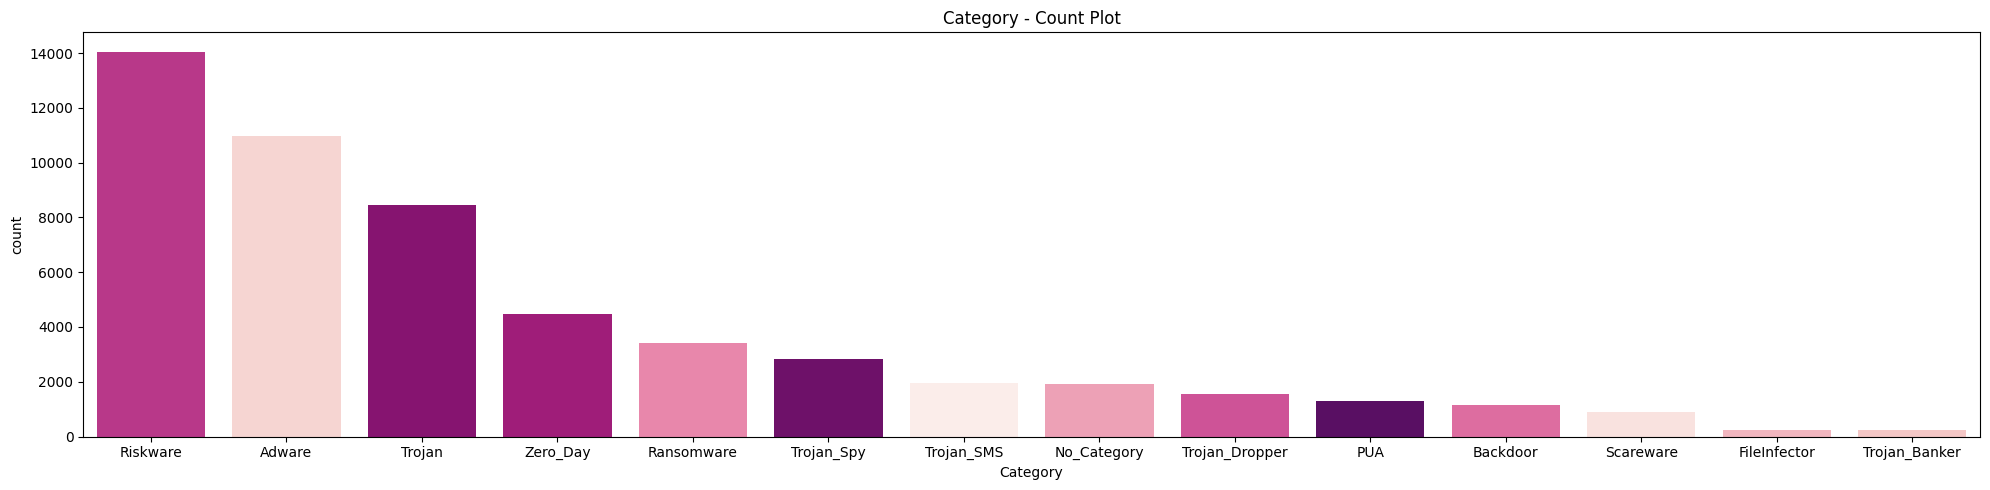

In [27]:
default_pipeline.EDA.plot_categorical_distributions(features=["Category"], n_cols=1, sorted = True)

## Data Type Distribution

In [28]:
# # Plotting the frequency of data types
# type_counts.plot(kind='bar', color='skyblue')

# # Add title and labels
# plt.title('Frequency of Data Types in DataFrame')
# plt.xlabel('Data Type')
# plt.ylabel('Frequency')

In [29]:
default_pipeline.dataset.df.dtypes.value_counts()

int64     141
object      2
Name: count, dtype: int64

We can see that most columns are numerical. Lets gets to see which are the variables that are of type object.

In [30]:
default_pipeline.dataset.df.select_dtypes(include=["object"]).columns

Index(['Category', 'Reboot'], dtype='object')

In [31]:
df = default_pipeline.dataset.df

## Network

In [32]:
network_columns = [col for col in default_pipeline.dataset.df.columns if col.startswith("Network_")]

for col in network_columns:
    print(f"{col}")

columns_to_display = network_columns + ['Reboot']
display(default_pipeline.dataset.df[columns_to_display].head(20))

Network_TotalReceivedBytes
Network_TotalReceivedPackets
Network_TotalTransmittedBytes
Network_TotalTransmittedPackets


Network_TotalReceivedBytes  Network_TotalReceivedPackets  \
0                            0                             0   
1                        12530                            36   
2                       157452                           218   
3                            0                             0   
4                            0                             0   
5                       118859                           101   
6                            0                             0   
7                            0                             0   
8                         8050                            37   
9                            0                             0   
10                           0                             0   
11                           0                             0   
12                           0                             0   
13                           0                             0   
14                           0                             0   
15                        4830                            39   
16                           0                             0   
17                           0                             0   
18                           0                             0   
19                       12652                            36   

    Network_TotalTransmittedBytes  Network_TotalTransmittedPackets  Reboot  
0                               0                                0  before  
1                            4595                               42  before  
2                           33555                              233  before  
3                               0                                0  before  
4                               0                                0  before  
5                            4565                               73  before  
6                               0                                0  before  
7                               0                                0  before  
8                            4585                               60  before  
9                               0                                0  before  
10                              0                                0  before  
11                           2880                               48  before  
12                              0                                0  before  
13                              0                                0  before  
14                              0                                0  before  
15                           4590                               49  before  
16                              0                                0  before  
17                              0                                0  before  
18                              0                                0  before  
19                           4796                               47  before

A packet is a unit of data transmitted over a network. Each packet includes the data called payload (data from the web, packets from streaming, messaging or downloading files or any data downloaded/uploaded in the device), and metadata (like headers).

A byte is used to measure data size. A single character like 'A' takes 1 byte (8 bits). 

Packets do not have a fixed size, but there are limits and conventions that control how large they can be depending on the network protocol.

Features

Network_TotalReceivedBytes: total bytes received over the Network.

Network_TotalReceivedPackets: total network packets received.

Network_TotalTransmittedBytes: total bytes transmitted over the network. 

Network_TotalTransmittedPackets: total network packets transmitted. 

#### Network_TotalReceivedBytes

In [ ]:
df["Network_TotalReceivedBytes"].describe()

In [ ]:
default_pipeline.EDA.plot_histograms(features=["Network_TotalReceivedBytes"], n_cols=1, bins=500)

Concentrate on outliers 

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Network_TotalReceivedBytes",
    category_column="Category"
)

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Network_TotalReceivedBytes",
    category_column="Category",
    by_reboot = True
)

In [ ]:
df.groupby('Category')['Network_TotalReceivedBytes'].describe()

#### Network_TotalTransmittedBytes

In [ ]:
df["Network_TotalTransmittedBytes"].describe()

In [ ]:
default_pipeline.EDA.plot_histograms(features=["Network_TotalTransmittedBytes"], n_cols=1, bins=500)

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Network_TotalTransmittedBytes",
    category_column="Category"
)

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Network_TotalTransmittedBytes",
    category_column="Category",
    by_reboot = True
)

In [ ]:
df.groupby('Category')['Network_TotalTransmittedBytes'].describe()

#### Network_TotalReceivedPackets

In [ ]:
default_pipeline.EDA.plot_histograms(features=["Network_TotalReceivedPackets"], n_cols=1, bins=500)

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Network_TotalReceivedPackets",
    category_column="Category"
)

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Network_TotalReceivedPackets",
    category_column="Category",
    by_reboot = True
)

In [ ]:
df.groupby('Category')['Network_TotalReceivedPackets'].describe()

#### Network_TotalTransmittedPackets

In [ ]:
default_pipeline.EDA.plot_histograms(features=["Network_TotalTransmittedPackets"], n_cols=1, bins=500)

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Network_TotalTransmittedPackets",
    category_column="Category"
)

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Network_TotalTransmittedPackets",
    category_column="Category",
    by_reboot = True
)

In [ ]:
df.groupby('Category')['Network_TotalTransmittedPackets'].describe()

#### Metrics Comparison

In [ ]:
network_features = [
    "Network_TotalReceivedBytes", 
    "Network_TotalReceivedPackets",
    "Network_TotalTransmittedBytes", 
    "Network_TotalTransmittedPackets"
]

# Option 1: Call the method sequentially for all features
for feature in network_features:
    print(f"\n--- {feature} Analysis ---")
    default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
        feature=feature,
        category_column="Category",
    )

Option 1: Bytes vs Packets (Efficiency Analysis)
Comparing sent bytes vs sent packets (and received bytes vs received packets) reveals:

Traffic Efficiency: How much data per packet is being transmitted
Payload Size Patterns: Whether malware uses many small packets or fewer large packets
Exfiltration Signatures: Large bytes/packet ratio could indicate data theft
This helps identify efficiency patterns within each communication direction.

Option 2: Sent vs Received (Direction Analysis)
Comparing sent bytes vs received bytes (and sent packets vs received packets) reveals:

Traffic Direction Balance: Whether more data is flowing in or out
Command & Control Pattern: High incoming/outgoing packet ratio suggests frequent commands
Data Theft Pattern: High outgoing data volume suggests exfiltration

In [ ]:
features_of_interest = ["Network_TotalReceivedBytes","Network_TotalTransmittedBytes", "Network_TotalReceivedPackets", "Network_TotalTransmittedPackets"]

category_means_filtered = (
    default_pipeline.dataset.df.groupby(['Category', 'Reboot'])[features_of_interest]
    .mean()
    .unstack()
)

category_means_filtered['Difference_ReceivedBytes'] = (
    category_means_filtered[('Network_TotalReceivedBytes', 'after')] - 
    category_means_filtered[('Network_TotalReceivedBytes', 'before')]
)
category_means_filtered['Difference_TransmittedBytes'] = (
    category_means_filtered[('Network_TotalTransmittedBytes', 'after')] - 
    category_means_filtered[('Network_TotalTransmittedBytes', 'before')]
)
category_means_filtered['Difference_ReceivedPackets'] = (
    category_means_filtered[('Network_TotalReceivedPackets', 'after')] - 
    category_means_filtered[('Network_TotalReceivedPackets', 'before')]
)
category_means_filtered['Difference_TransmittedPackets'] = (
    category_means_filtered[('Network_TotalTransmittedPackets', 'after')] - 
    category_means_filtered[('Network_TotalTransmittedPackets', 'before')]
)

print("Differences in Network_TotalReceivedBytes, Network_TotalTransmittedBytes, Network_TotalReceivedPackets and Network_TotalTransmittedPackets (After - Before Reboot):")
print(category_means_filtered[['Difference_ReceivedBytes', 'Difference_TransmittedBytes', 'Difference_ReceivedPackets', 'Difference_TransmittedPackets']])

category_means_filtered[['Difference_ReceivedBytes', 'Difference_TransmittedBytes', 'Difference_ReceivedPackets']].plot(
    kind='bar', figsize=(14, 8), title='Difference in Network Features (After - Before Reboot)'
)
plt.ylabel('Difference in Mean')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Zero Activity Rows: 

Hypothesis: 

Some types of malware might intentionally avoid any network activity during initial execution to stay under the radar. For example, they could be waiting for a trigger, like a reboot or user action, before doing anything suspicious. So just because a sample doesn’t show network behavior right away doesn’t mean it’s harmless — it could actually be a sign that it’s trying to hide.

In [ ]:
network_features = [
    'Network_TotalReceivedBytes',
    'Network_TotalReceivedPackets', 
    'Network_TotalTransmittedBytes',
    'Network_TotalTransmittedPackets'
]

# Get the data from your pipeline
df = default_pipeline.dataset.df

# Create a mask for rows where all network features are 0
zero_network_mask = (df[network_features] == 0).all(axis=1)

# Calculate overall statistics
total_samples = len(df)
zero_network_samples = zero_network_mask.sum()
zero_network_percentage = (zero_network_samples / total_samples) * 100

print(f"\nOverall Zero Network Activity Statistics:")
print(f"Total samples: {total_samples}")
print(f"Samples with no network activity: {zero_network_samples}")
print(f"Percentage of samples with no network activity: {zero_network_percentage:.2f}%")

# Calculate per-category statistics
category_stats = pd.DataFrame({
    'Total': df['Category'].value_counts(),
    'Zero_Network': df[zero_network_mask]['Category'].value_counts()
})
category_stats['Percentage'] = (category_stats['Zero_Network'] / category_stats['Total'] * 100)

print("\nPer-Category Zero Network Activity Statistics:")
print(category_stats)

#  Bar plot comparing categories
plt.figure(figsize=(12, 6))
sns.barplot(x=category_stats.index, y='Percentage', data=category_stats, color='pink')
plt.title('Percentage of Samples with Zero Network Activity by Category')
plt.xlabel('Malware Category')
plt.ylabel('Percentage of Samples (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Out of over 53,000 total samples, around 35% showed no network communication at all during execution, which shows to be a pretty high number. This supports the idea that some malware might suppress network behavior in early stages to avoid detection, possibly lying dormant until triggered. When breaking it down by category we can see that nearly 96% of ransomware samples had no network activity. Similarly, Scareware, Droppers, and various Trojan types also showed over 60% inactivity. On the other hand, categories like Adware and Riskware had much lower percentages, aligning with a noisy and persistent background behavior.

To dig deeper into whether this lack of network activity is part of a stealth strategy, we looked at how behavior changes before and after a device reboot. The idea here is that some malware might be designed to stay quiet initially, especially during sandbox analysis, and only activate after a reboot, when it assumes it’s running on a real device. 

So, we calculated the percentage of samples with zero network activity before versus after reboot for each malware category. By comparing these two stages with a barplot, we’re able to spot patterns where certain malware types start off dormant but become active later on. If we see a significant drop in zero activity samples after reboot, that would suggest those categories are using reboot as a trigger, possibly as a sandbox evasion technique.

In [ ]:
# Get the data from your pipeline
df = default_pipeline.dataset.df

# Split data by reboot status and calculate percentages
def calculate_zero_network_percentage(data):
    return (data[network_features] == 0).all(axis=1).mean() * 100

# Calculate percentages for before and after reboot for each category
stats = []
for category in df['Category'].unique():
    category_data = df[df['Category'] == category]
    
    before_reboot = category_data[category_data['Reboot'] == 'before']
    after_reboot = category_data[category_data['Reboot'] == 'after']
    
    before_zero_pct = calculate_zero_network_percentage(before_reboot)
    after_zero_pct = calculate_zero_network_percentage(after_reboot)
    
    stats.append({
        'Category': category,
        'Before_Reboot_Zero_Pct': before_zero_pct,
        'After_Reboot_Zero_Pct': after_zero_pct,
        'Difference': after_zero_pct - before_zero_pct,
        'Samples_Before': len(before_reboot),
        'Samples_After': len(after_reboot)
    })

# Convert to DataFrame
stats_df = pd.DataFrame(stats)
stats_df = stats_df.sort_values('Difference', ascending=False)

# Print statistics
print("Zero Network Activity Analysis - Before vs After Reboot:")
print("\nPercentages by Category:")
print(stats_df[['Category', 'Before_Reboot_Zero_Pct', 'After_Reboot_Zero_Pct', 'Difference']])

# Create grouped bar plot
plt.figure(figsize=(15, 8))
x = np.arange(len(stats_df))
width = 0.35

plt.bar(x - width/2, stats_df['Before_Reboot_Zero_Pct'], width, label='Before Reboot', color='pink')
plt.bar(x + width/2, stats_df['After_Reboot_Zero_Pct'], width, label='After Reboot', color='hotpink')

plt.xlabel('Malware Category')
plt.ylabel('Percentage of Zero Network Activity (%)')
plt.title('Zero Network Activity: Before vs After Reboot by Category')
plt.xticks(x, stats_df['Category'], rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed analysis
print("\nDetailed Analysis:")
print("\nCategories with biggest increase in activity after reboot (largest negative difference):")
print(stats_df.nsmallest(5, 'Difference')[['Category', 'Difference']])

print("\nCategories with biggest decrease in activity after reboot (largest positive difference):")
print(stats_df.nlargest(5, 'Difference')[['Category', 'Difference']])

# Calculate overall statistics
print("\nOverall Statistics:")
total_before = df[df['Reboot'] == 'before']
total_after = df[df['Reboot'] == 'after']
print(f"Overall zero network activity before reboot: {calculate_zero_network_percentage(total_before):.2f}%")
print(f"Overall zero network activity after reboot: {calculate_zero_network_percentage(total_after):.2f}%")

# Identify significant changes
significant_change = stats_df[abs(stats_df['Difference']) > 10]
print("\nCategories with significant change (>10% difference):")
print(significant_change[['Category', 'Before_Reboot_Zero_Pct', 'After_Reboot_Zero_Pct', 'Difference']])

Overall, the percentage of samples with zero network activity slightly increased after reboot (from 33.9% to 35.87%), which wasn’t what we initially expected. 

Trojan_Banker showed the bigget change jumping from 62.7% of samples being inactive before reboot to over 81% after. Similarly, categories like Trojan, Zero_Day, and Backdoor also became more dormant post reboot. This suggests that instead of reboot triggering activity, some malware might be designed to go quiet after reboot, possibly to blend in with normal system behavior or to delay actions until further conditions are met.

On the other side, a few categories did show a decrease in zero network activity after reboot. FileInfector and Trojan_Spy, for instance, had lower percentages of inactivity post reboot, which supports the idea that these types might actually be triggered to start behaving after the system restarts. 

Categories clearly respond to reboot differently, possibly using it as a way to hide longer or wait for the right moment to act.

### Asymmetric communication
Received vs Transmitted Ratio: Shows communication balance

Hypothesis: 

If a malware sample is only sending or only receiving data, that might tell us something about what it's trying to do. For instance, malware that only sends data could be stealing information, while one that only receives could be waiting for commands from a remote server. This kind of unbalanced communication pattern isn’t typical in most normal apps, so it could be a useful behavioral clue.

Code:

Create Boolean masks:

Sent > 0, Received = 0

Sent = 0, Received > 0

Group by category, count and visualize both cases


In [ ]:
# Create boolean masks for unidirectional communication
only_sending_mask = (
    (df['Network_TotalTransmittedBytes'] > 0) & 
    (df['Network_TotalTransmittedPackets'] > 0) & 
    (df['Network_TotalReceivedBytes'] == 0) & 
    (df['Network_TotalReceivedPackets'] == 0)
)

only_receiving_mask = (
    (df['Network_TotalTransmittedBytes'] == 0) & 
    (df['Network_TotalTransmittedPackets'] == 0) & 
    (df['Network_TotalReceivedBytes'] > 0) & 
    (df['Network_TotalReceivedPackets'] > 0)
)

# Calculate statistics per category using a more efficient approach
stats = []
for category in df['Category'].unique():
    category_mask = df['Category'] == category
    total_samples = category_mask.sum()
    
    # Calculate intersections of masks
    only_sending = (category_mask & only_sending_mask).sum()
    only_receiving = (category_mask & only_receiving_mask).sum()
    
    stats.append({
        'Category': category,
        'Total_Samples': total_samples,
        'Only_Sending': only_sending,
        'Only_Receiving': only_receiving,
        'Only_Sending_Percentage': (only_sending / total_samples * 100),
        'Only_Receiving_Percentage': (only_receiving / total_samples * 100)
    })

# Convert to DataFrame
stats_df = pd.DataFrame(stats)

# Sort by total unidirectional communication
stats_df['Total_Unidirectional'] = stats_df['Only_Sending_Percentage'] + stats_df['Only_Receiving_Percentage']
stats_df = stats_df.sort_values('Total_Unidirectional', ascending=False)

# Print overall statistics
print("Unidirectional Network Communication Analysis")
print("\nOverall Statistics:")
print(f"Total samples: {len(df)}")
print(f"Samples only sending data: {only_sending_mask.sum()} ({only_sending_mask.mean()*100:.2f}%)")
print(f"Samples only receiving data: {only_receiving_mask.sum()} ({only_receiving_mask.mean()*100:.2f}%)")

# Print per-category statistics
print("\nPer-Category Statistics:")
print(stats_df[['Category', 'Total_Samples', 'Only_Sending_Percentage', 'Only_Receiving_Percentage']])


In [ ]:
# Create grouped bar plot
plt.figure(figsize=(15, 8))
x = np.arange(len(stats_df))
width = 0.35

plt.bar(x - width/2, stats_df['Only_Sending_Percentage'], width, 
        label='Only Sending', color='pink', alpha=0.7)
plt.bar(x + width/2, stats_df['Only_Receiving_Percentage'], width, 
        label='Only Receiving', color='hotpink', alpha=0.7)

plt.xlabel('Malware Category')
plt.ylabel('Percentage of Samples (%)')
plt.title('Unidirectional Network Communication Patterns by Category')
plt.xticks(x, stats_df['Category'], rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Additional analysis: Look at the actual amounts of data for unidirectional communications
print("\nAverage Data Volumes in Unidirectional Communications:")

# For sending-only samples
sending_volumes = df[only_sending_mask].groupby('Category').agg({
    'Network_TotalTransmittedBytes': 'mean',
    'Network_TotalTransmittedPackets': 'mean'
}).round(2)

print("\nAverage volumes for sending-only samples:")
print(sending_volumes.sort_values('Network_TotalTransmittedBytes', ascending=False))

# For receiving-only samples
receiving_volumes = df[only_receiving_mask].groupby('Category').agg({
    'Network_TotalReceivedBytes': 'mean',
    'Network_TotalReceivedPackets': 'mean'
}).round(2)

print("\nAverage volumes for receiving-only samples:")
print(receiving_volumes.sort_values('Network_TotalReceivedBytes', ascending=False))


Even though only a small portion of samples (4.68%) showed send only behavior, the fact that it’s most common in Adware, Trojan_Banker, and Backdoor isn’t surprising. These are the kinds of malware that usually need to push data out, whether it’s ads, stolen login details, or system information. 

What stood out more was that no malware was found to be receive only, which suggests most threats don’t just sit and wait for commands, they’re usually the ones reaching out. 

Also, while Trojan_Spy and Riskware didn’t have the highest counts for total_samples, the ones that did send only traffic were sending much larger volumes (As seen in Average volumes for sending-only samples). That points to more intentional, stealthy behavior, like stealing chunks of data quietly instead of just pinging a server.

### Combined behavior

Hypothesis: 

Looking at network behavior alone might miss important signs of malware. Some malware might not talk to the network much but could still be doing shady stuff in memory or through system calls. On the other hand, malware that does use the network a lot might also be more active in other areas. So combining different kinds of behavioral data could give a much clearer picture of what’s actually going on.

In [ ]:
def identify_dormant_malware(df):
    """Check if samples with no network activity are completely dormant across all features."""
    network_features = [
        'Network_TotalReceivedBytes',
        'Network_TotalReceivedPackets',
        'Network_TotalTransmittedBytes',
        'Network_TotalTransmittedPackets'
    ]
    
    # Get all feature columns except Category and Reboot
    all_features = [col for col in df.columns if col not in ['Category', 'Reboot']]
    
    # Get samples with zero network activity
    network_zeros = df[network_features].sum(axis=1) == 0
    # Check if these samples have zero activity across all features
    complete_zeros = df[all_features].sum(axis=1) == 0
    
    dormant_samples = df[network_zeros & complete_zeros]
    return dormant_samples[['Category'] + all_features]

In [ ]:
dormant = identify_dormant_malware(default_pipeline.dataset.df)
print(f"Found {len(dormant)} completely dormant samples")
display(dormant)

### Packets per ratio 

Hypothesis

The amount of data sent per packet can tell us a lot about what the malware is doing. For example, if it's sending lots of tiny packets, it might be pinging a server repeatedly. On the other hand, large packets could mean it’s uploading stolen data or downloading a payload. 

Different types of malware might have their own "signature" when it comes to how much data they send per packet. For example, spyware or banking trojans might send fewer but larger packets because they're exfiltrating specific chunks of sensitive data, while adware might generate lots of small packets through constant background communication for ad loading or tracking. 

By looking at how the bytes-per-packet ratio varies across categories, we might be able to use it as a feature that helps distinguish between things like adware, ransomware, and backdoors.

In [ ]:
def calculate_bytes_per_packet(bytes_col, packets_col):
    # Avoid division by zero by masking where packets > 0
    mask = packets_col > 0
    bytes_per_packet = pd.Series(np.nan, index=bytes_col.index)
    bytes_per_packet[mask] = bytes_col[mask] / packets_col[mask]
    return bytes_per_packet

In [ ]:
# Calculate received and transmitted bytes per packet
received_bytes_per_packet = calculate_bytes_per_packet(
    df['Network_TotalReceivedBytes'], 
    df['Network_TotalReceivedPackets']
)

transmitted_bytes_per_packet = calculate_bytes_per_packet(
    df['Network_TotalTransmittedBytes'], 
    df['Network_TotalTransmittedPackets']
)

analysis_df = pd.DataFrame({
    'Category': df['Category'],
    'Received_Bytes_Per_Packet': received_bytes_per_packet,
    'Transmitted_Bytes_Per_Packet': transmitted_bytes_per_packet
})

In [ ]:
print("Bytes per packet statistics:")
bpp_stats = analysis_df[['Received_Bytes_Per_Packet', 'Transmitted_Bytes_Per_Packet']].describe()
display(bpp_stats)

In [ ]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=analysis_df, x='Category', y='Received_Bytes_Per_Packet', color='pink')
plt.xticks(rotation=45, ha='right')
plt.title('Received Bytes per Packet by Category')
plt.xlabel('Malware Category')
plt.ylabel('Bytes per Packet (Received)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
sns.boxplot(data=analysis_df, x='Category', y='Transmitted_Bytes_Per_Packet', color='hotpink')
plt.xticks(rotation=45, ha='right')
plt.title('Transmitted Bytes per Packet by Category')
plt.xlabel('Malware Category')
plt.ylabel('Bytes per Packet (Transmitted)')
plt.tight_layout()
plt.show()

In [ ]:
avg_by_category = analysis_df.groupby('Category')[['Received_Bytes_Per_Packet', 'Transmitted_Bytes_Per_Packet']].mean().reset_index()
avg_by_category = avg_by_category.sort_values('Received_Bytes_Per_Packet', ascending=False)

# 6. Bar plot for average RX bytes per packet
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Received_Bytes_Per_Packet', data=avg_by_category, 
           order=avg_by_category['Category'], color='pink')
plt.title('Average Received Bytes per Packet by Category')
plt.xlabel('Malware Category')
plt.ylabel('Avg Received Bytes per Packet')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Bar plot for average TX bytes per packet
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Transmitted_Bytes_Per_Packet', data=avg_by_category, 
           order=avg_by_category.sort_values('Transmitted_Bytes_Per_Packet', ascending=False)['Category'], 
           color='hotpink')
plt.title('Average Transmitted Bytes per Packet by Category')
plt.xlabel('Malware Category')
plt.ylabel('Avg Transmitted Bytes per Packet')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Count samples with unusually large or small bytes per packet
rx_mean, rx_std = analysis_df['Received_Bytes_Per_Packet'].mean(), analysis_df['Received_Bytes_Per_Packet'].std()
tx_mean, tx_std = analysis_df['Transmitted_Bytes_Per_Packet'].mean(), analysis_df['Transmitted_Bytes_Per_Packet'].std()

large_rx = analysis_df[analysis_df['Received_Bytes_Per_Packet'] > rx_mean + 2*rx_std]
large_tx = analysis_df[analysis_df['Transmitted_Bytes_Per_Packet'] > tx_mean + 2*tx_std]

print(f"Samples with unusually large Received bytes per packet (>2 std): {len(large_rx)}")
print(f"Samples with unusually large Transmitted bytes per packet (>2 std): {len(large_tx)}")

# Category distribution for samples with extreme bytes per packet
if len(large_rx) > 0:
    print("\nCategory distribution for samples with large Rreceived bytes per packet:")
    display(large_rx['Category'].value_counts())

if len(large_tx) > 0:
    print("\nCategory distribution for samples with large Transmitted bytes per packet:")
    display(large_tx['Category'].value_counts())

# Remove the dataframe copy to free memory
del analysis_df

On one hand, PUA, Scareware, and FileInfector had the highest average in received bytes per packet, which could mean they download larger chunks of data at once, like pulling down a payload. 

On the other hand, when it comes to sending data, Trojan  dominates, making up almost all of the samples with large transmitted packets. That kind of pattern is typical of data exfiltration, where malware gathers sensitive information (like credentials, messages, or files) and sends it out in fewer but larger packets, instead of lots of small messages. This helps it fly under the radar by reducing the number of connections, which could otherwise get flagged.

Adware and Riskware showed up on both sides, but with much smaller packet sizes, which fits with their typical behavior of sending out lots of lightweight requests, probably for ads or background activity. 

Overall, the bytes-per-packet ratio really seems to reflect what the malware is actually trying to do.


### Total Network Activity Score

Hypothesis:

Different types of malware probably have different "loudness" levels when it comes to network traffic. For example, adware might constantly send and receive data for ads, while something like ransomware might only make a quick connection to get a key. So looking at the total amount of network activity might help us tell apart different malware types, or at least help flag the really noisy ones.

Goal: Rank samples and categories by their overall network intensity.
Code:

Sum of all 4 network metrics per row 



In [ ]:
def calculate_total_network_activity(df):
    """
    Calculate total network activity by summing all network metrics.
    Returns a new DataFrame with the total activity and category.
    """
    network_features = [
        'Network_TotalReceivedBytes',
        'Network_TotalReceivedPackets',
        'Network_TotalTransmittedBytes',
        'Network_TotalTransmittedPackets'
    ]
    
    # Create a new DataFrame with just Category and total activity
    activity_df = pd.DataFrame()
    activity_df['Category'] = df['Category']
    activity_df['Total_Network_Activity'] = df[network_features].sum(axis=1)
    
    return activity_df

In [ ]:
activity_df = calculate_total_network_activity(default_pipeline.dataset.df)
display(activity_df)

In [ ]:
top_samples = activity_df.sort_values(by='Total_Network_Activity', ascending=False).head(10)
print("Top 10 Most Network-Intensive Samples:")
display(top_samples)

In [ ]:
category_avg = activity_df.groupby('Category')['Total_Network_Activity'].mean().sort_values(ascending=False)
print("\nAverage Total Network Activity by Category:")
display(category_avg)


In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=category_avg.index, y=category_avg.values, color='pink')
plt.title('Average Total Network Activity per Malware Category')
plt.xlabel('Malware Category')
plt.ylabel('Mean Total Network Activity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

There’s a massive difference in total network activity across malware types, with PUA standing out as the loudest by far. On average, it generates over 26 million bytes of traffic per sample, which is way more than any other category. In fact, it almost completely dominates the top 10 most network intensive samples. This kind of behavior probably comes from constantly pulling ads, sending telemetry, or doing background communication. 

On the other hand, malware like Ransomware, Trojan_Banker, and Trojan_Spy are much quieter. These types seem to keep network activity minimal, likely because they don’t need to constantly talk to a server, they just connect once or twice to fetch a key or send stolen data. 

So just by looking at how "loud" a sample is on the network, we can already get an idea of what kind of malware it might be.

## Battery

Features: 

Battery_wakelock: Tracks wake lock usage. 

Wavelock: mechanism that keeps the device CPU active even if the screen is turned off or the device is in a low-power state. When an app wants to keep the device awake for a specific period, it acquires a wake lock to then release it when no longer needed. However, when a wakelock is held for an extended period, it prevents the device from entering a deep sleep state, which drains the battery.

Malware may abuse wakelocks to keep the device awake for tasks like:

Persistent network communication (e.g., beaconing or data exfiltration), background monitoring or spying, draining the battery deliberately.

High or frequent wakelock usage might suggest long-running background activity, which could be indicative of malware trying to stay active undetected.

Battery_service: measures interactions with battery-related Android system services, like monitoring battery state, registering for battery events (charging, discharging, low battery)

Certain malware may monitor the system’s power status to decide when to execute payloads or avoid draining the battery, which might alert the user.

### Wakelocks usage 

Hypothesis:

Malware that needs to stay active in the background may abuse wakelocks to keep the device’s CPU awake. This allows them to continue operations like listening for events, uploading stolen data, or showing ads, even when the user isn’t using the device. 

In [ ]:
df.groupby('Category')['Battery_wakelock'].mean().sort_values(ascending=False).plot(kind='bar', color='pink')

On average, Trojans hold the most wakelocks, which might mean they’re staying active in the background for longer, maybe to keep sending data, wait for instructions, or just avoid going to sleep. Bankers and Riskware aren’t far behind. 
On the other hand, malware like Ransomware and Scareware barely use wakelocks at all, these types often execute quickly and don’t need to remain active long. This kind of pattern suggests wakelock usage could be a useful signal for spotting malware that tries to stick around silently.


### Battery interaction

Hypothesis:

Some malware categories may interact with battery related system services to time their actions and avoid detection. For example, they may wait until the device is charging or has sufficient battery before executing a heavy payload to avoid detection or/and ensure successful execution. 

In [ ]:
df.groupby('Category')['Battery_service'].mean().sort_values(ascending=False).plot(kind='bar', color='pink')


Trojan_Dropper, Adware, and Riskware show the highest battery service access, suggesting they might be monitoring power status as part of their execution logic. This could mean they’re trying to stay hidden (by avoiding execution while charging for example), or optimizing for long-running background behavior. In contrast, Scareware and FileInfector barely use battery services at all, which indicate they’re short attacks and don’t need to track system conditions. So, high battery service usage could be a clue that the malware is more “aware” of the device’s state and trying to adapt its behavior accordingly.

### Combined effect

The reason battery wakelock usage and battery service access are not the same across malware categories is because they have different underlying meanings. 

Wakelocks are used to keep the device awake, which means the malware that wants to stay active in the background, like constantly running, sending data, or maintaining a connection. 

On the other hand, battery service usage is more about awareness, the malware is checking the device’s power state to decide when or whether to act. 

So while wakelocks are about persistence, battery service access is more about stealth or timing.

High wakelock & high battery service: Stealthy but persistent - long-running and context-aware

High wakelock & low battery service: Persistent — doesn’t care about battery state, just stays on

Low wakelock & high battery service: Stealthy — checks system state but avoids staying awake

Low wakelock & low battery service: Quick or inactive — does its thing fast or waits quietly

The classification will now be done based on whether each malware category’s average Battery_wakelock and Battery_service values are above or below the overall median across all samples, placing them into one of four behavioral profiles that reflect different levels of persistence and system awareness.

In [ ]:
# Step 1: Compute average wakelock and battery service usage by malware category
avg_battery_usage = df.groupby('Category')[['Battery_wakelock', 'Battery_service']].mean()

# Step 2: Define thresholds using the overall medians
wakelock_median = df['Battery_wakelock'].median()
service_median = df['Battery_service'].median()

# Step 3: Classification logic into four behavior types
def classify_behavior(row):
    if row['Battery_wakelock'] > wakelock_median and row['Battery_service'] > service_median:
        return 'High Wakelock + High Service'
    elif row['Battery_wakelock'] > wakelock_median:
        return 'High Wakelock + Low Service'
    elif row['Battery_service'] > service_median:
        return 'Low Wakelock + High Service'
    else:
        return 'Low Wakelock + Low Service'

# Step 4: Apply classification
avg_battery_usage['Battery_Behavior_Type'] = avg_battery_usage.apply(classify_behavior, axis=1)

# Step 5: Group categories by their behavior type - Fix the deprecation warning
behavior_groups = {}
for behavior_type, group_df in avg_battery_usage.groupby('Battery_Behavior_Type'):
    behavior_groups[behavior_type] = list(group_df.index)

# Step 6: Display results
for behavior, categories in behavior_groups.items():
    print(f"\n{behavior}:")
    for cat in categories:
        print(f" - {cat}")

### Outliers

High Battery Feature Samples (Outlier Analysis)

Filter top 5% of samples with the highest Battery_wakelock or Battery_service

Group by Category and count


## Process

Process_total: Tracks total active processes (Actively executing)

Higher values could indicate:

Malware spawning many child processes 

Attempts at evasion or persistence, like breaking into smaller threads

Abusive use of the system

Lower values may reflect:

Silent or dormant behavior

Lightweight payloads that don’t fork or persist

### Relationship Between API Usage and Active Process Count

In [ ]:
df = default_pipeline.dataset.df
process_cols = [col for col in df.columns if any(term in col.lower() for term in 
                ['process', 'proc'])]

print(f"Found {len(process_cols)} process-related columns:")
print(process_cols)

There are four API specific features that involve the creation and kill of processes. In this section we check whether the number of active processes reflect how often the app starts or kills processes. In other words, whether process_total can be rebuilt from API behavior.

The four mentioned features are:

API_Process_android.os.Process_start: an app starts a new process. Most likely increases process_total.

API_Process_android.app.ActivityManager_killBackgroundProcesses: An app terminates background processes. Most likely decreases process_total.

API_Process_android.os.Process_killProcess: an app kills a specific process by its PID. Most likely decreases process_total.

API_Command_java.lang.ProcessBuilder_start: Starts a new process using ProcessBuilder. This provides a more flexible way to control and manage a process, useful when you want to perform complex system commands. Most likely increases process_total.



In [ ]:
# List of process-related API/command features
process_api_features = [
    'API_Process_android.os.Process_start',
    'API_Process_android.app.ActivityManager_killBackgroundProcesses',
    'API_Process_android.os.Process_killProcess',
    'API_Command_java.lang.ProcessBuilder_start'
]

# Correlation with Process_total
corr_df = df[['Process_total'] + process_api_features].corr()
process_corrs = corr_df['Process_total'].drop('Process_total').sort_values(ascending=False)

print("Correlation of Process_total with process-related APIs/commands:")
print(process_corrs)


The correlation between Process_total and process-related API usage is surprisingly weak. None of the APIs showed any strong relationship, most correlation values are very close to zero, and one is even negative. ProcessBuilder.start commonly used to start new processes, had slight negative correlation (−0.02). This suggests that the total number of active processes isn’t directly explained by how often these specific APIs are used.

### Stealth vs. Active Malware

Hypothesis:

Some malware might rely on creating multiple processes to execute different stages of its attack. At the same time, other types of malware may prioritize stealth. Malware that focuses on staying hidden is likely to keep its number of active processes as low as possible to avoid detection. Instead of creating multiple visible subprocesses, it might run as a single, quiet background task.

In [ ]:
df = default_pipeline.dataset.df.copy()
print("Basic statistics for process_total:")
display(df['Process_total'].describe())

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Process_total'], color='hotpink')
plt.title('Distribution of process_total Across All Samples', fontsize=14)
plt.xlabel('Process Total Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
category_col = 'Category'  
category_stats = df.groupby(category_col)['Process_total'].agg(['mean', 'median', 'std', 'count'])
category_stats = category_stats.sort_values('mean', ascending=False)

print("\nProcess total statistics by category:")
display(category_stats)

In [ ]:
# Average processes by category
plt.figure(figsize=(14, 7))
ax = sns.barplot(x=category_stats.index, y=category_stats['mean'], 
                order=category_stats.index, color='hotpink')
plt.title('Average Process Count by Malware Category', fontsize=14)
plt.ylabel('Average Number of Processes', fontsize=12)
plt.xlabel('Malware Category', fontsize=12)
plt.xticks(rotation=45)

# Add mean values as text labels
for i, v in enumerate(category_stats['mean']):
    ax.text(i, v + 0.1, f"{v:.1f}", ha='center')

plt.tight_layout()
plt.show()

Despite the hypothesis, the number of active processes looks almost the same across all malware categories. Most averages cluster around 190, with very little spread, the standard deviation is just under 3. This suggests that Process_total might not be influenced by malware behavior.

### Trigger-Based Activation

Hypothesis:

Some malware may lie dormant before reboot and only become active (spawning processes) after reboot, as part of a sandbox evasion strategy.

In [ ]:
copy = default_pipeline.dataset.df.copy()

# mean Process_total for each category and reboot state
pivot = copy.pivot_table(
    values='Process_total',
    index='Category',
    columns='Reboot',
    aggfunc='mean'
)

pivot['difference'] = pivot['after'] - pivot['before']
pivot = pivot.sort_values('difference', ascending=False)
print("Process count comparison before vs after reboot:")
display(pivot)


In [ ]:
# Create a grouped bar chart
plt.figure(figsize=(16, 8))

# Set width of bars
barWidth = 0.35
r1 = np.arange(len(pivot.index))
r2 = [x + barWidth for x in r1]

# Create bars
plt.bar(r1, pivot['before'], width=barWidth, color='lightblue', label='Before Reboot')
plt.bar(r2, pivot['after'], width=barWidth, color='hotpink', label='After Reboot')

# Add labels and title
plt.xlabel('Malware Category', fontsize=12)
plt.ylabel('Average Process Count', fontsize=12)
plt.title('Process Count Before vs After Reboot by Malware Category', fontsize=14)
plt.xticks([r + barWidth/2 for r in r1], pivot.index, rotation=45, ha='right')
plt.legend()

# Add text annotations for differences
for i, (idx, row) in enumerate(pivot.iterrows()):
    diff = row['difference']
    if not np.isnan(diff):
        color = 'green' if diff > 0 else 'red'
        plt.text(i + barWidth/2, 
                 max(row['before'], row['after']) + 2, 
                 f"{diff:+.1f}", 
                 color=color,
                 ha='center',
                 fontweight='bold')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

There’s a consistent increase in average process count after reboot across all malware categories of about 3 to 4 more processes. While the difference isn’t huge, it’s consistent. However, the effect is too small to confidently attribute it to sandbox evasion.

## Memory (Proportional Set Size)

- outliers
- check the sum

### PSS


PSS refers to the portion of memory that is proportionally assigned to a process, taking into acount shared memory.

Features:
- Memory_PssTotal
- Memory_PssClean
- Memory_SharedDirty
- Memory_PrivateDirty
- Memory_SharedClean
- Memory_PrivateClean
- Memory_SwapPssDirty

Clean vs Dirty:
- Clean: memory pages that hasnt been modified since it was mapped (Example: Libraries)
- Dirty: memory pages that have been modified.

Private vs Shared:
- Private: only available to a process
- Shared: mapped by multiple processes. The most important thing to take into account is that we divide the number of Kb by number of proccesses accessing to it.

Hypothesis:  
If malware is present on a system, it can load code or data into shared memory (e.g., a shared library), which reduces its individual memory footprint. Additionally, malware can inject code into other processes, keeping its own PSS relatively low. This is why PSS alone is likely insufficient for reliably detecting malicious applications.

#### Memory_PssTotal

This is the sum of Memory_PssClean, Memory_sharedDirty and Memory_PrivateDirty (Memory_PssDirty is not a feature). 

In [ ]:
default_pipeline.dataset.df['Memory_PssTotal'].describe()

There is a really high standard deviation. The max value is extremely high. It's more than 10 times the mean. In general we can see a quite high mempry usage.

In [ ]:
default_pipeline.EDA.plot_histograms(features=["Memory_PssTotal"], n_cols=1, bins=500)

In [ ]:
default_pipeline.dataset.df['Memory_PssTotal'].max()

In [ ]:
default_pipeline.dataset.df.groupby('Category')['Memory_PssTotal'].describe()

It's interesting to note that both Scareware and Adware consume more memory, likely due to the UI activity. While Ransomware and Trojan_spy have relatively low memory consumption, meaning they are more memory efficient.

#### Memory_PssClean

In [ ]:
default_pipeline.EDA.plot_histograms(features=["Memory_PssTotal"], n_cols=1, bins=500)

In [ ]:
default_pipeline.dataset.df.groupby('Category')['Memory_PssClean'].describe()

## API 

The following features are functions from android APIs, which are a set of tools to create and manage Android devices. They let you interact with features such as processes, commands, activities. 

GENERAL EDA NOTE: as soon as the app tries to reach system level configurations we should be sceptical. This is the main pathway for intrusive attacks

Public APIs = intended for developers (normal app developers, malware writers too)

Hidden/Internal APIs = system-level functions not officially exposed to apps (need reflection, NDK, or privileged access)

In [33]:
network_columns = [col for col in default_pipeline.dataset.df.columns if col.startswith("API_")]

for col in network_columns:
    print(f"{col}")

columns_to_display = network_columns + ['Reboot']
display(default_pipeline.dataset.df[columns_to_display].head(10))

API_Process_android.os.Process_start
API_Process_android.app.ActivityManager_killBackgroundProcesses
API_Process_android.os.Process_killProcess
API_Command_java.lang.Runtime_exec
API_Command_java.lang.ProcessBuilder_start
API_JavaNativeInterface_java.lang.Runtime_loadLibrary
API_JavaNativeInterface_java.lang.Runtime_load
API_WebView_android.webkit.WebView_loadUrl
API_WebView_android.webkit.WebView_loadData
API_WebView_android.webkit.WebView_loadDataWithBaseURL
API_WebView_android.webkit.WebView_addJavascriptInterface
API_WebView_android.webkit.WebView_evaluateJavascript
API_WebView_android.webkit.WebView_postUrl
API_WebView_android.webkit.WebView_postWebMessage
API_WebView_android.webkit.WebView_savePassword
API_WebView_android.webkit.WebView_setHttpAuthUsernamePassword
API_WebView_android.webkit.WebView_getHttpAuthUsernamePassword
API_WebView_android.webkit.WebView_setWebContentsDebuggingEnabled
API_FileIO_libcore.io.IoBridge_open
API_FileIO_android.content.ContextWrapper_openFileInpu

API_Process_android.os.Process_start  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   
5                                     0   
6                                     0   
7                                     0   
8                                     0   
9                                     0   

   API_Process_android.app.ActivityManager_killBackgroundProcesses  \
0                                                  0                 
1                                                  0                 
2                                                  0                 
3                                                  0                 
4                                                  0                 
5                                                  0                 
6                                                  0                 
7                                                  0                 
8                                                  0                 
9                                                  0                 

   API_Process_android.os.Process_killProcess  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   
5                                           0   
6                                           0   
7                                           0   
8                                           0   
9                                           0   

   API_Command_java.lang.Runtime_exec  \
0                                   0   
1                                   0   
2                                   0   
3                                   0   
4                                   0   
5                                   0   
6                                   0   
7                                   0   
8                                   0   
9                                   0   

   API_Command_java.lang.ProcessBuilder_start  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   
5                                           0   
6                                           0   
7                                           0   
8                                           0   
9                                           0   

   API_JavaNativeInterface_java.lang.Runtime_loadLibrary  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       
5                                                  0       
6                                                  0       
7                                                  0       
8                                                  0       
9                                                  0       

   API_JavaNativeInterface_java.lang.Runtime_load  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   
5                                               0   
6                                               0   
7                                               0   
8                                               0   
9                                  

### Process Android

API_Process_android.os.Process_start: an app starts a new process. 

API_Process_android.app.ActivityManager_killBackgroundProcesses: An app terminates background processes.

API_Process_android.os.Process_killProcess: an app kills a specific process by its PID

#### os.Process_start

In [ ]:
df['API_Process_android.os.Process_start'].describe()

The start method was not called by any sample during the dynamic analysis. This means that no new process was started by any malware or that the instrumentation used to track this API call did not function correctly.

Malware typically don't use this API call since it is a system-level functions they are not meant for regular app use and requires special permissions that they do not have. This would only make the malware fail and make it easier to detect.

The tool could have been tracking user space behaviour rather than the kernel space where this system call runs.

Other ways to spawning processes could be using the shell command runtime.exec() or by a programmatic process creation like ProcessBuilder.start() which will be analysed in the next section.

As a result, API_Process_android.os.Process_start is not a meaningful feature and should be dropped since it provides no information.


#### app.ActivityManager_killBackgroundProcesses

In [ ]:
df['API_Process_android.app.ActivityManager_killBackgroundProcesses'].describe()

At least 75% of all samples never use this API indicating a very rare usage.

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_Process_android.app.ActivityManager_killBackgroundProcesses"], n_cols=1, bins=500)

The feature is heavily right skewed. Around 50000 samples do not use the API. 

In order to better visualize outliers we will plot the distribution of the feature excluding the zero value.

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Process_android.app.ActivityManager_killBackgroundProcesses"] > 0]
sns.histplot(nonzero_samples["API_Process_android.app.ActivityManager_killBackgroundProcesses"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Process_android.app.ActivityManager_killBackgroundProcesses"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Outliers are very sparse. The distribution shows two clusters. A small group of around 70 samples with 1 to 10 calls and a larger concentration of around 300 samples with 95 to 125 calls.

This might imply there is two different strategies. 
One where malware eliminates specific selected processes (low call count) and one where malware has a systematic clearing of the environment (high call count).

For these reasons binning could be a good approach for this feature since the distribution shows clear groupings of no activity, low usage, high usage and a few extreme outliers.

Given that the feature is highly skewed since over 50000 samples have zero calls and is spread everywhere else, binning could create a more balanced and meaningful representation.

Based on the strategic analysis, the exact count of kills is less important than the overall behavioral pattern. 

Binning would also help reduce the influence of extreme outlier values, preventing them from disproportionately affecting the models.

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_Process_android.app.ActivityManager_killBackgroundProcesses",
    category_column="Category"
)

Apparently, the high number of calls mainly belong to the category Ransomware. This malware probably methodically eliminates any process that might interfere with its encryption objectives.

This feature appears mostly a behavioral signature of this type of malware compared to the others.

In [ ]:
df.groupby('Category')['API_Process_android.app.ActivityManager_killBackgroundProcesses'].describe()

Only Ransomware (mean 11.85) and Trojan_Dropper (mean 0.26) show notable usage. All other categories have means below 0.01. 

The maximum values for Ransomware (260) and Trojan_Dopper (215) are much larger than for the rest of categories and six categories actually never use the API call, showing clear differences in malware behavior.


This pattern actually suggest that process killing is not a tactic for all malware but rather specific to mainly Ransomware and Trojan_Dopper. The difference in average usage (11.85 for Ransomware vs 0.26 for Trojan_Dopper) makes this feature maily mostly for Ransomware detection. 

In [ ]:
# Filter the dataset for only Ransomware samples
ransomware_data = default_pipeline.EDA.dataset[
    default_pipeline.EDA.dataset["Category"] == "Ransomware"
]

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=ransomware_data,
    x="API_Process_android.app.ActivityManager_killBackgroundProcesses",
    bins=50,
    color="pink"
)

# Add clear titles and labels
plt.title("Distribution of killBackgroundProcesses API Calls in Ransomware", fontsize=14)
plt.xlabel("API Call Count", fontsize=12)
plt.ylabel("Number of Ransomware Samples", fontsize=12)


# Add grid and show
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

High values strongly indicate Ransomware, with some false positives due Trojan_Dopper. 
This is because when high values are observed they are almost exclusively related with Ransomware but Trojan_Dopper maximum value is still 215. This should not worry us too much since Trojan_Dopper's mean usage is only 0.26 compared to 11.85 so these false positives are statistically infrequent. 

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_Process_android.app.ActivityManager_killBackgroundProcesses",
    category_column="Category",
    by_reboot = True
)

Ransomware has a pretty consistent behavior pre and post reboot. However, it seems like after reboot it performs a more agressive process killing but it could also be just normal statistical variance as this difference does not look very significative.

#### os.Process_killProcess

In [ ]:
df['API_Process_android.os.Process_killProcess'].describe()

Again, at least 75% of all samples never use this API indicating a very rare usage.

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_Process_android.os.Process_killProcess"], n_cols=1, bins=500)

The feature is heavily right skewed. Around 50000 samples do not use the API. 

We will follow the same process as before.

First, in order to better visualize outliers we will plot the distribution of the feature excluding the zero value.

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Process_android.os.Process_killProcess"] > 0]
sns.histplot(nonzero_samples["API_Process_android.os.Process_killProcess"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Process_android.os.Process_killProcess"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Unlike the previous API clustered distribution this API shows exactly three distinct call frequencies.

The three distinct patterns likely represent three specific malware variants or techniques.

This API appears to represent an even more specialized behavior than killBackgroundProcesses, potentially offering a signature of specific malware variants.

In [ ]:
df.groupby('Category')['API_Process_android.os.Process_killProcess'].describe()

In [ ]:
api_feature = "API_Process_android.os.Process_killProcess"

non_zero_count = (default_pipeline.EDA.dataset["API_Process_android.os.Process_killProcess"] > 0).sum()
total_samples = len(default_pipeline.EDA.dataset)

print(non_zero_count)
print(total_samples)

Malware clearly prefers package-based killing (killBackgroundProcesses) over PID-based targeting (killProces).

With only 3 instances, this represents highly anomalous behavior rather than a category-specific signature.

This feature has minimal classification value and should be deleted since it provides extremely low information and it is even potential noise.

### Command java lang

This commands allows us to execute system-level commands and manage processes using Java-based methods

Features:

API_Command_java.lang.Runtime_exec: Executes a system command. This is used for running shell commands or interacting with the os from the android app 
Runtime.exec() allows malware to:

Execute shell commands for system manipulation
Install additional malicious components
Disable security features
Create persistence mechanisms

EDA => too many calls from the app is likely a worrying signal. 

API_Command_java.lang.ProcessBuilder_start: Starts a new process using ProcessBuilder. This provides a more flexible way to control and manage a process, useful when you want to perform complex system commands.

#### Runtime_exec

In [ ]:
df['API_Command_java.lang.Runtime_exec'].describe()

At least 75% of all samples never use this API indicating a very rare usage.

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_Command_java.lang.Runtime_exec"], n_cols=1, bins=500)

No surprise, the feature is heavily right skewed. Around 50000 samples do not use the API. 

In order to better visualize outliers we will plot the distribution of the feature excluding the zero value.

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Command_java.lang.Runtime_exec"] > 0]
sns.histplot(nonzero_samples["API_Command_java.lang.Runtime_exec"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Command_java.lang.Runtime_exec"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In order to proceed with more accurate conclusions we will visualize values concentrated on 0 to 500 better.

In [ ]:
plt.figure(figsize=(12, 6))
filtered_samples = nonzero_samples[nonzero_samples["API_Command_java.lang.Runtime_exec"] <= 500]
sns.histplot(filtered_samples["API_Command_java.lang.Runtime_exec"], 
             bins=40, color='palevioletred')
plt.title('Runtime.exec() Calls (≤ 500)', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

We can distinguish three main peaks: 
around 950 samples near zero calls, around 700 samples with 60-80 calls, and around 1100 samples with 125-130 calls.

This shows three different attack approaches: a low count of calls represent a more targeted execution while a high count might represent a more systematic usage of the call.

There are little number of samples that do more than 200 command calls. This might be like a threshold. More could lead to evidence of malicious activity and so an easier detection.

This pattern seems to provide important information to identify malware.

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_Command_java.lang.Runtime_exec",
    category_column="Category"
)


In [ ]:
df.groupby('Category')['API_Command_java.lang.Runtime_exec'].describe()


Riskware shows a very different proportion of non-zero usage compared to all other categories and it is the only category with non-zero 75th percentile meaning more than 25% of samples make 129 calls or more. This aligns with the peak observed around 125-130 calls.

Scareware has also a distinctive pattern, however it has a very low usage (the mean is 0.33 - very low compared to other categories) as shown by the plot above, so it is not particularly useful for Scareware detection.

On the other hand, we can see that the features with largest means being Riskware (61.68), Trojan (37.03), PUA (16.10 mean), Trojan_Dropper (13.80), Backdoor (11.75).

In [ ]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]
api_feature = "API_Command_java.lang.Runtime_exec"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    
    # Add safety check to prevent division by zero
    if total_category_count > 0:
        percent = (sample_count / total_category_count) * 100
    else:
        percent = 0
        print(f"Warning: No samples found for category '{category}'")
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


These categories differ not just in how much they use Runtime.exec(), but in how they use it. 

Riskware: Strong concentration at 100-200 calls (matching its high mean of 61.68)

Trojan: Complex bimodal pattern with peaks at different values (consistent with 37.03 mean)

PUA: multimodal distribution with clear peaks at <20, 70-80 calls and around 90.

Trojan_Dropper: right skewed distribution with a cluster around low values and some scattered asround higher values.

Backdoor: mostly concentrated at low values (just one peak) with a few samples at moderate values. 

This makes the feature even more valuable to distinguish between these categories.

For Riskware it may be a primary feature to recognize it, for the others it is a supporting feature that may need combination with others to provide evidence.

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_Command_java.lang.Runtime_exec",
    category_column="Category",
    by_reboot = True
)

Riskware differentiation after reboot becomes even more pronounced.
Trojan also has a more pronounced peak after reboot.
This makes the feature a stronger differentiator between malware categories after reboot than before.

After a reboot, the behavior of Riskware becomes much more noticeable compared to other malware types. If we only look at the "before" and "after" API call counts separately, it can be hard for a model to tell the difference between legitimate software and malware, since both might have high values. Instead, focusing on how behavior changes across the reboot, by creating features like the difference (after - before) and the ratio (after + 1 / (before + 1)), gives us a much clearer signal. 

Riskware typically shows a big increase in API calls after a reboot, while other categories stay about the same. By capturing this shift directly, these new features highlight a rare and distinctive pattern that can help a model separate Riskware more accurately from other threats.

#### ProcessBuilder_start

In [ ]:
df['API_Command_java.lang.ProcessBuilder_start'].describe()

Again, more than 75% of samples do not call this API.

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_Command_java.lang.ProcessBuilder_start"], n_cols=1, bins=500)

Once again, lets focus on outliers.

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Command_java.lang.ProcessBuilder_start"] > 0]
sns.histplot(nonzero_samples["API_Command_java.lang.ProcessBuilder_start"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Command_java.lang.ProcessBuilder_start"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The concentration of samples at very low call counts suggests most malware makes targeted, minimal use of this functionality rather than the more systematic approach seen with Runtime.exec().

In [ ]:
# Comparison against Runtime_exec()
runtime_exec_count = len(df[df["API_Command_java.lang.Runtime_exec"] > 0])
process_builder_count = len(df[df["API_Command_java.lang.ProcessBuilder_start"] > 0])

print(f"Runtime.exec users: {runtime_exec_count}")
print(f"ProcessBuilder.start users: {process_builder_count}")

Both APIs are used almost the same amount of times.
Rather than one API displacing the other, malware appears to use both approaches. However ProcessBuilder makes less call counts than Runtime_exec, which seems like targeted vs systematic approaches.

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_Command_java.lang.ProcessBuilder_start",
    category_column="Category"
)

This plot looks very similar to the Runtime_exec plot. They show almost identical patterns.

The strong similarity between these APIs suggests that malware developers probably use them together, often within the same piece of code, rather than choosing one over the other. That would explain why they show up in nearly the same number of malware samples (11,073 vs 11,421) and why their usage patterns look so alike.

We will further analyze by category to see if actual different meaningful patterns can be find.

In [ ]:
df.groupby('Category')['API_Command_java.lang.ProcessBuilder_start'].describe()

In [ ]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]

api_feature = "API_Command_java.lang.ProcessBuilder_start"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


PUA: multi-modal pattern with strong peaks at around 0, 25 and 30
(Runtime_exec: PUA: multimodal distribution with clear peaks at <20, 70-80 calls and around 90)

Riskware: Strong concentration at 0-100 calls 
(Runtime_exec: Strong concentration at 100-200 calls)

Backdoor: mostly concentrated at low values (just one peak) with a few samples at moderate values. 
(Runtime_exec: mostly concentrated at low values (just one peak) with a few samples at moderate values.)

Trojan_Dopper: right skewed distribution with a cluster around low values and some scattered asround higher values
(Runtime_exec: right skewed distribution with a cluster around low values and some scattered asround higher values)

Trojan: bimodal pattern with peaks around what seems to be 25-50 and 180-200
(Runtime_exec: Complex bimodal pattern with peaks at different values)

If we normalize these features, they might become nearly identical because when we normalize using min-max scaling we preserve the shape of the distribution but eliminate the scale difference.

We will try to find if there is a common ratio.

In [ ]:
# Example: Feature_A and Feature_B are pandas Series
epsilon = 1e-8  # small number to avoid divide-by-zero
ratios = df["API_Command_java.lang.Runtime_exec"] / (df["API_Command_java.lang.ProcessBuilder_start"] + epsilon)

# Basic stats
print(f"Mean ratio: {ratios.mean():.3f}")
print(f"Std deviation of ratio: {ratios.std():.3f}")

# Visual check
plt.hist(ratios, bins=50, color ='mistyrose')
plt.title('Distribution of Feature_A / Feature_B')
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.show()


On average, API_Command_java.lang.Runtime_exec is about 0.584 × API_Command_java.lang.ProcessBuilder_start.

The mean being around 0.584 suggests there is some scaling between the two features, but the high standard deviation (1.154) means the relationship is very noisy and inconsistent.

Maybe within each malware category, the ratio is consistent, but across different categories, the scaling factor k changes. We will now explore this

In [ ]:
epsilon = 1e-8

# Create a copy first
df_copy = default_pipeline.dataset.df.copy()

# Calculate ratio in the copy
df_copy["ratio"] = df_copy["API_Command_java.lang.Runtime_exec"] / (df_copy["API_Command_java.lang.ProcessBuilder_start"] + epsilon)

# Group by category and get mean, std, and count
group_stats = df_copy.groupby("Category")["ratio"].agg(["mean", "std", "count"])

print(group_stats)


Inside each malware category, the average scaling factor k is different
meaning that the relationship between the two features depends on the malware type.

However, we cannot claim that there is a strict ratio within categories since many stds are quite large relative to the means.

Plots show there is a useful ratio-like trend across the malware. But it's too noisy to be a clean mathematical ratio. So, even if the ratio is noisy, we might consider including the feature and letting other metrics consider its importance.

Let's see the correlation

In [ ]:
api1 = "API_Command_java.lang.Runtime_exec"
api2 = "API_Command_java.lang.ProcessBuilder_start"

# 1. Calculate overall correlation
correlation = default_pipeline.EDA.dataset[api1].corr(default_pipeline.EDA.dataset[api2])
print(f"Overall correlation between {api1} and {api2}: {correlation:.4f}")

The extremely high correlation (0.97) indicates that these two APIs are nearly always used together in malware samples, and their usage scales very similarly, exactly as expected. These two features behave almost like scaled versions of each other across malware samples so one of them will be later deleted. 

Runtime_exec has a higher mean, greater variability, and a much larger maximum value across categories. This indicates that it captures more extreme and aggressive behaviors, the kind of signals that are often critical in detecting malware. 

ProcessBuilder_start is more stable and less noisy, but it also has a narrower dynamic range, which could cause it to miss important spikes in malicious behavior.

Even though keeping a more stable feature might help reduce noise and make things easier for simpler models, in malware detection it's more important to catch big, suspicious behavior changes. That's why, even with its extra variability, Runtime_exec might be a better choice to detect something unusual is happening.


Note: If we only keep features that spike big, the model might miss stealthier malware that uses these APIs quietly. However, if we keep Runtime_exec but transform it, using things like log-scaling, we can detect both loud and quiet attacks. 

### Java Native Interface 

This API allows Java-based android apps to interact with C/C++ libraries.

API_JavaNativeInterface_java.lang.Runtime_loadLibrary:  Loads a native library, which are precompiled and use to increase performance.

API_JavaNativeInterface_java.lang.Runtime_load: Loads a dynamic library which is shared code file that multiple programs processes can load at runtime

#### Runtime_loadLibrary

In [ ]:
df['API_JavaNativeInterface_java.lang.Runtime_loadLibrary'].describe()

This feature provides no valuable information and should be deleted.

#### Runtime_load

In [ ]:
df['API_JavaNativeInterface_java.lang.Runtime_load'].describe()

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_JavaNativeInterface_java.lang.Runtime_load"], n_cols=1, bins=500)

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_JavaNativeInterface_java.lang.Runtime_load"] > 0]
sns.histplot(nonzero_samples["API_JavaNativeInterface_java.lang.Runtime_load"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_JavaNativeInterface_java.lang.Runtime_load"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
df.groupby('Category')['API_JavaNativeInterface_java.lang.Runtime_load'].describe()

Since only No_Category and Zero_Day have values different from zero, and these categories will not be included in the model, this feature should be dropped.

### Web View Android

Web view Android

Webview os a built-in browser component in android that allows apps to display web pages inside the app itself instead of opening an external browser

Features:	

API_WebView_android.webkit.WebView_loadUrl: Loads a URL in WebView 

API_WebView_android.webkit.WebView_loadData: Loads raw HTML data in WebView. 

API_WebView_android.webkit.WebView_loadDataWithBaseURL: Loads HTML data with a base URL. 

API_WebView_android.webkit.WebView_addJavascriptInterface: Adds a JavaScript interface to WebView. 

API_WebView_android.webkit.WebView_evaluateJavascript: executes JavaScript code inside WebView. 

API_WebView_android.webkit.WebView_postUrl: Allows WebView to send HTTP POST requests
EDA NOTE => analyze if this an anomaly. It may be the case that for you to send HTTP POST you need rare privileges.

API_WebView_android.webkit.WebView_postWebMessage: Sends a web message via WebView. Used for secure communication between Android WebView and a website

API_WebView_android.webkit.WebView_savePassword: Saves login credentials in WebView for autofill.

 EDA NOTE => this is a very typical attack vector. Research on this.

API_WebView_android.webkit.WebView_setHttpAuthUsernamePassword: Stores HTTP authentication credentials for Authentication

API_WebView_android.webkit.WebView_getHttpAuthUsernamePassword: Retrieves saved HTTP authentication credentials. 

 EDA NOTE => this is a typical attack vector. Research on this.

API_WebView_android.webkit.WebView_setWebContentsDebuggingEnabled: Enables Chrome DevTools debugging for WebView. 

EDA NOTE => this may be completely irrelevant (considered to be dropped) for our problem

#### loadUrl

In [34]:
df['API_WebView_android.webkit.WebView_loadUrl'].describe()

count    53439.000000
mean         3.914463
std         60.301128
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       9483.000000
Name: API_WebView_android.webkit.WebView_loadUrl, dtype: float64

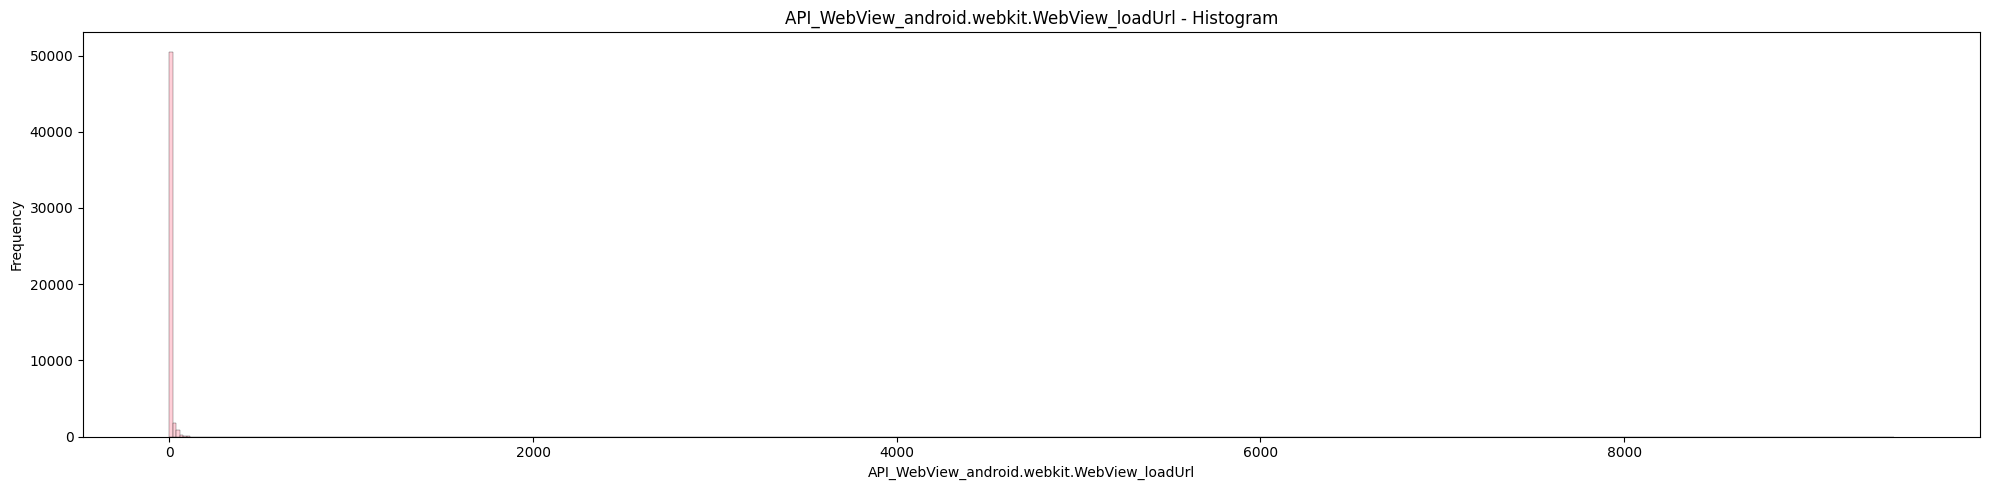

In [35]:
default_pipeline.EDA.plot_histograms(features=["API_WebView_android.webkit.WebView_loadUrl"], n_cols=1, bins=500)

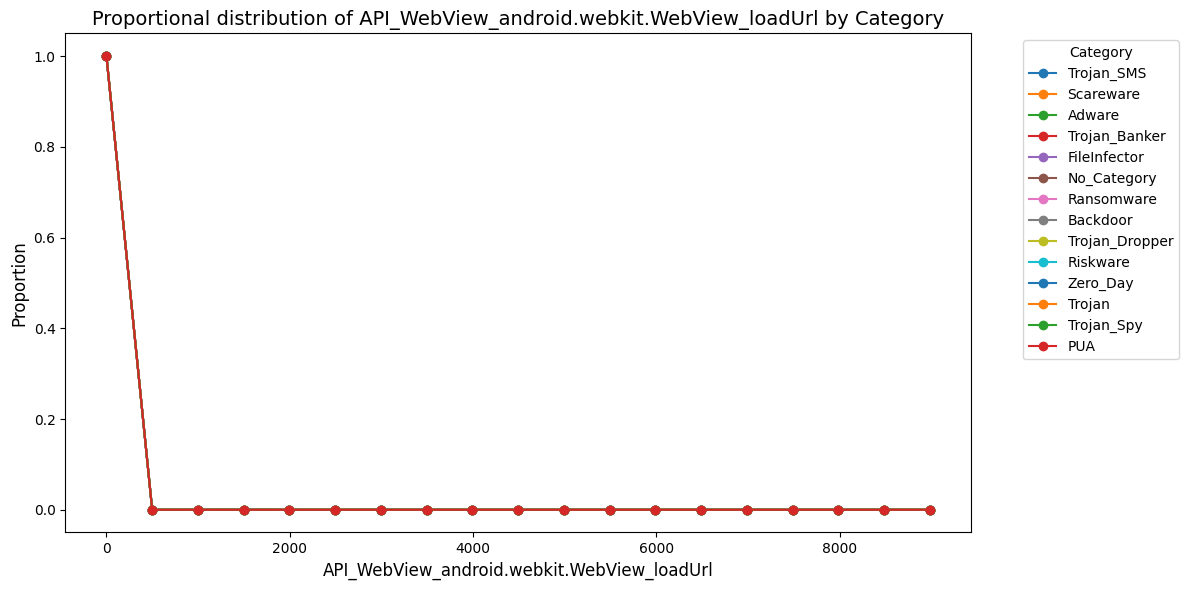

In [36]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_WebView_android.webkit.WebView_loadUrl",
    category_column="Category"
)


This proportional distribution plot shows that the vast majority of WebView_loadUrl API calls originate from samples labeled as PUA (Potentially Unwanted Applications), accounting for nearly all usage across categories. 
Other malware categories, such as Trojan_SMS, Adware, Ransomware, and Zero_Day, exhibit negligible or zero proportional usage. This indicates that embedding web content via WebView is a strong behavioral signal primarily tied to PUA, potentially for purposes like ad fraud, phishing, or deceptive redirects, while other malware types rarely rely on this API.

In [37]:
df.groupby('Category')['API_WebView_android.webkit.WebView_loadUrl'].describe()

count      mean         std  min  25%   50%   75%     max
Category                                                                   
Adware          10980.0  7.704281   20.078330  0.0  0.0   0.0   5.0   742.0
Backdoor         1137.0  1.285840    6.012612  0.0  0.0   0.0   0.0    44.0
FileInfector      248.0  2.661290    9.668922  0.0  0.0   0.0   2.0   142.0
No_Category      1932.0  8.498447  144.129446  0.0  0.0   0.0   1.0  4585.0
PUA              1290.0  2.903101   10.276129  0.0  0.0   0.0   0.0   152.0
Ransomware       3411.0  0.905013    5.868381  0.0  0.0   0.0   0.0   100.0
Riskware        14053.0  1.587134   48.793333  0.0  0.0   0.0   0.0  5619.0
Scareware         886.0  9.756208    6.725896  0.0  3.0  12.0  15.0    42.0
Trojan           8437.0  3.636838  108.048927  0.0  0.0   0.0   0.0  9483.0
Trojan_Banker     241.0  5.701245   15.350962  0.0  0.0   0.0   2.0   186.0
Trojan_Dropper   1570.0  0.598089    3.714080  0.0  0.0   0.0   0.0   117.0
Trojan_SMS       1939.0  6.334193   15.448798  0.0  0.0   0.0   5.0   241.0
Trojan_Spy       2840.0  1.905282    4.346052  0.0  0.0   0.0   0.0    69.0
Zero_Day         4475.0  3.928715   60.715990  0.0  0.0   0.0   1.0  3019.0

Scareware is the only category with consistent and substantial use of the WebView_loadUrl API (median=12, 75th percentile=15), clearly standing out from all other malware types.

For nearly all other categories, barring Scareware, the median usage is zero, meaning most samples never invoke this API.

This suggests that Scareware uniquely relies on WebView, likely to present fake warnings or deceptive content, which aligns with its scare-tactic nature.

Because of this distinct usage pattern, WebView_loadUrl could serve as a strong behavioral feature for detecting Scareware, as no other category shows similar consistency or frequency.

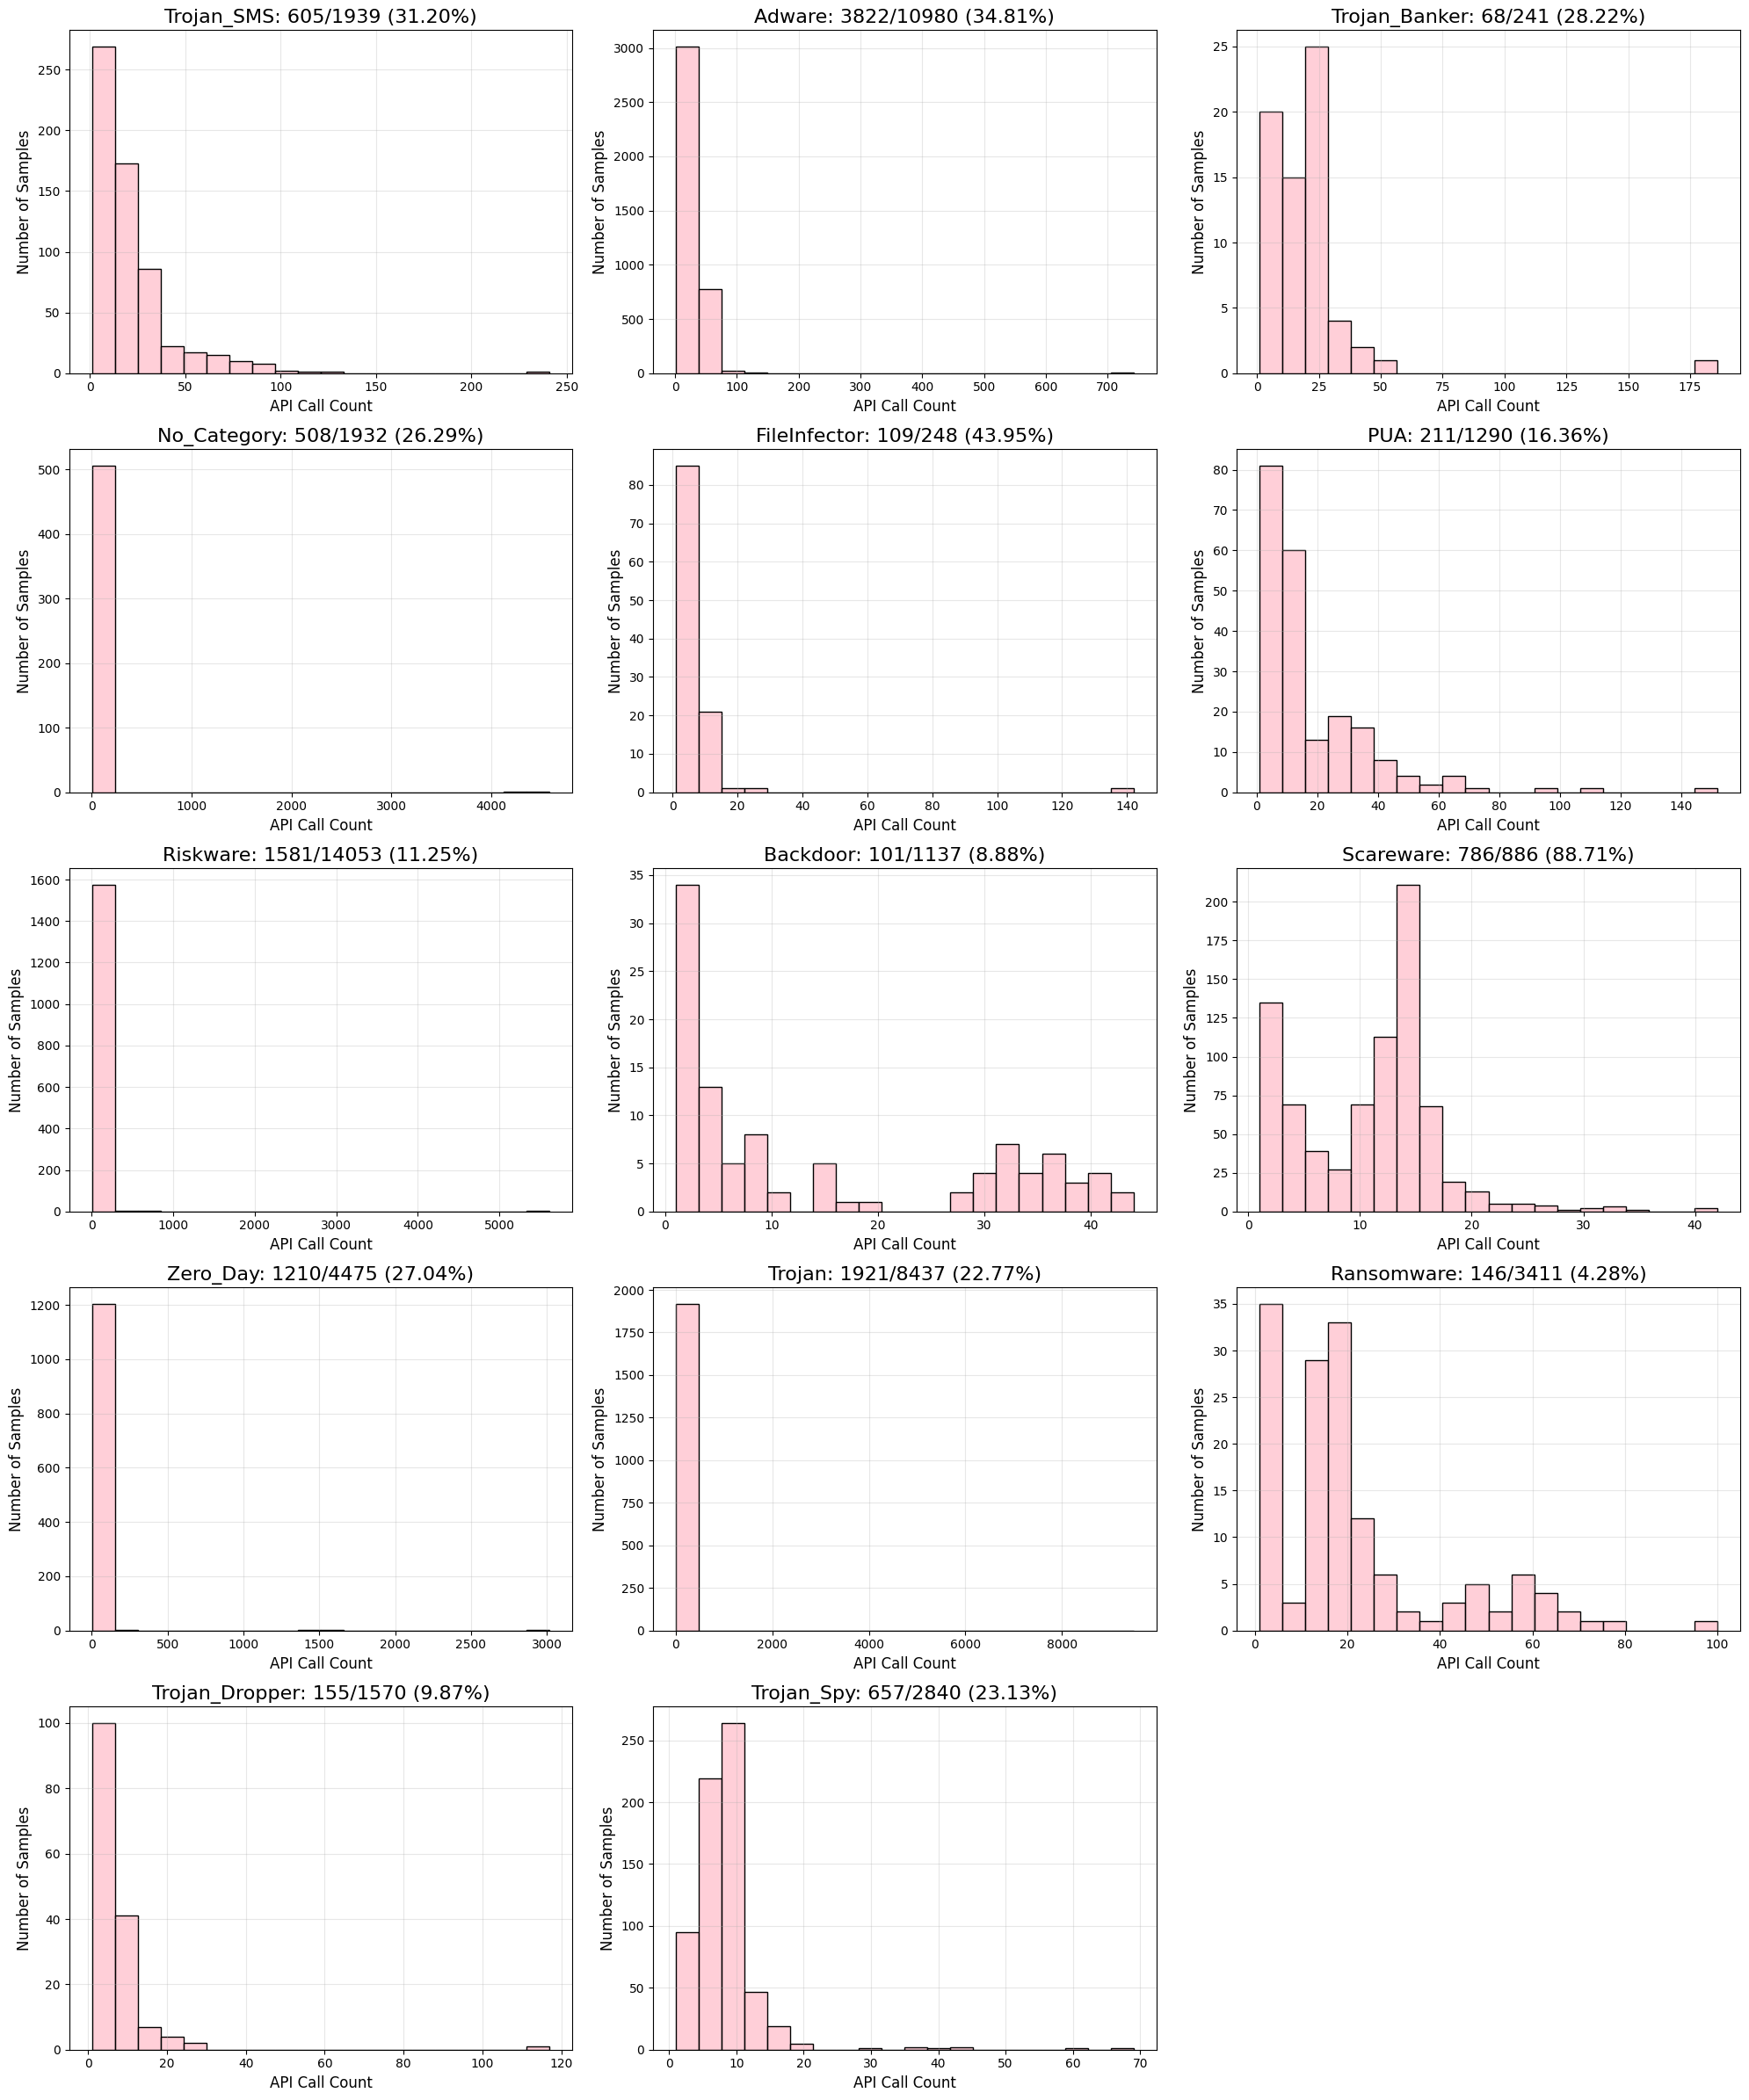

In [38]:
# Examine value distribution within categories that use this API
top_categories = ['Trojan_SMS', 'Adware', 'Trojan_Banker', "No_Category", "FileInfector",
                  "PUA", "Riskware", "Backdoor", "Scareware", "Zero_Day", "Trojan",
                  "Ransomware", "Trojan_Dropper", "Trojan_Spy"]
api_feature = "API_WebView_android.webkit.WebView_loadUrl"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(5, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

The WebView_loadUrl API shows significant variation in usage across malware categories, revealing meaningful behavioral patterns.

Scareware stands out with 88.71% of samples using this API, usually with consistent call counts (e.g. 8 or 16), likely to display fake warnings or alerts, making it highly distinctive.

Ransomware, by contrast, only uses it in 4.28% of cases, aligning with its stealthy, background focused behavior like file encryption.

FileInfector shows moderate usage (43.95%), often making 1 or 4 calls, suggesting templated design.

Trojan_SMS and Adware have high usage but overlapping patterns (1–5 calls), which may reduce their classification value.

Trojan_Banker, PUA, Riskware, and Zero_Day tend to stay around 0–2 calls, indicating minimal web interaction.

Backdoor shows structured jumps (1, 5, 9), while Trojan_Spy centers around 10 calls.

Trojan_Dropper and Ransomware show more scattered behavior.

These distributions highlight distinct usage patterns across categories. Despite some overlap, the API remains valuable for classification due to strong differences in frequency and intent, especially between Scareware and Ransomware.

#### loadData

In [39]:
df['API_WebView_android.webkit.WebView_loadData'].describe()

count    53439.000000
mean         0.027920
std          0.533337
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         57.000000
Name: API_WebView_android.webkit.WebView_loadData, dtype: float64

At lease 75% of all samples never use this API indicating a very rare usage.

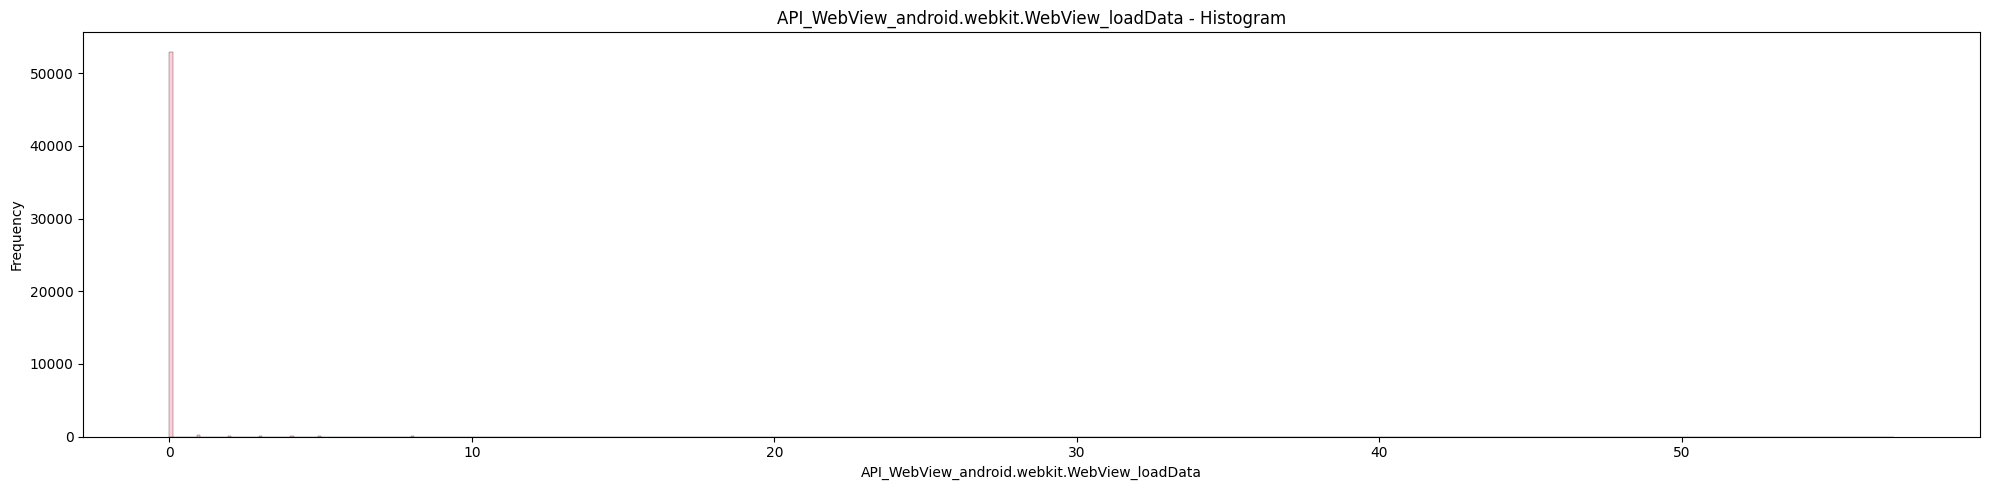

In [40]:
default_pipeline.EDA.plot_histograms(features=["API_WebView_android.webkit.WebView_loadData"], n_cols=1, bins=500)

This histogram shows a strong right skew, with the majority of samples (\~50,000) having zero calls to the WebView_loadData API. To better understand the distribution of actual API usage, we will replot the data excluding zero values.

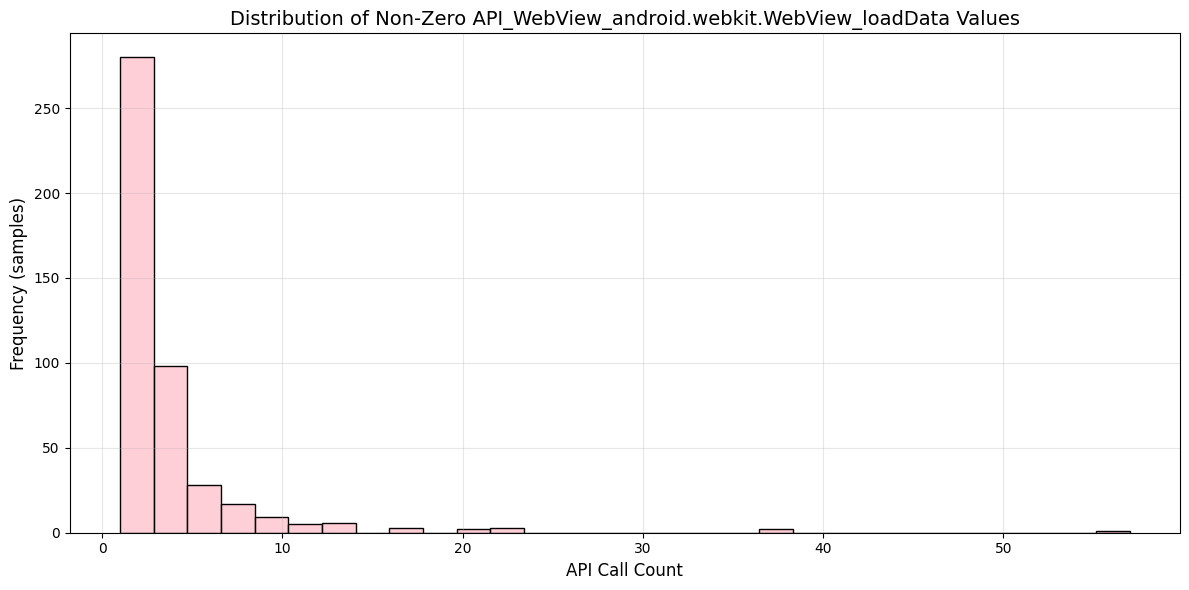

In [41]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_WebView_android.webkit.WebView_loadData"] > 0]
sns.histplot(nonzero_samples["API_WebView_android.webkit.WebView_loadData"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_WebView_android.webkit.WebView_loadData"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

This histogram shows the distribution of non-zero WebView_loadData API calls. Most samples make only 1 to 5 calls, with very few exceeding 30. This indicates the API is rarely used heavily and likely plays a minor or supporting role in malware behavior. The small call counts also present challenges for machine learning, as minimal differences (e.g. 1 vs 2 calls) may be due to noise rather than meaningful variation.


We will now see how the non-zero values are distributed among the categories

In [42]:
df.groupby('Category')['API_WebView_android.webkit.WebView_loadData'].describe()


count      mean       std  min  25%  50%  75%   max
Category                                                             
Adware          10980.0  0.083515  0.791982  0.0  0.0  0.0  0.0  37.0
Backdoor         1137.0  0.013193  0.306620  0.0  0.0  0.0  0.0   9.0
FileInfector      248.0  0.020161  0.261568  0.0  0.0  0.0  0.0   4.0
No_Category      1932.0  0.028986  0.435585  0.0  0.0  0.0  0.0  12.0
PUA              1290.0  0.024031  0.464617  0.0  0.0  0.0  0.0  12.0
Ransomware       3411.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0
Riskware        14053.0  0.004412  0.102532  0.0  0.0  0.0  0.0   6.0
Scareware         886.0  0.027088  0.600706  0.0  0.0  0.0  0.0  16.0
Trojan           8437.0  0.007704  0.474891  0.0  0.0  0.0  0.0  38.0
Trojan_Banker     241.0  0.070539  0.729728  0.0  0.0  0.0  0.0   8.0
Trojan_Dropper   1570.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0
Trojan_SMS       1939.0  0.126870  1.474025  0.0  0.0  0.0  0.0  57.0
Trojan_Spy       2840.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0
Zero_Day         4475.0  0.012067  0.413601  0.0  0.0  0.0  0.0  23.0

Non-zero values of API_WebView_android.webkit.WebView_loadData by category:


total_samples  non_zero_samples  percent_non_zero
Trojan_SMS               1939                57          2.939660
Adware                  10980               307          2.795993
Trojan_Banker             241                 3          1.244813
No_Category              1932                17          0.879917
FileInfector              248                 2          0.806452
PUA                      1290                 7          0.542636
Riskware                14053                43          0.305984
Backdoor                 1137                 3          0.263852
Scareware                 886                 2          0.225734
Zero_Day                 4475                 9          0.201117
Trojan                   8437                 4          0.047410
Ransomware               3411                 0          0.000000
Trojan_Dropper           1570                 0          0.000000
Trojan_Spy               2840                 0          0.000000

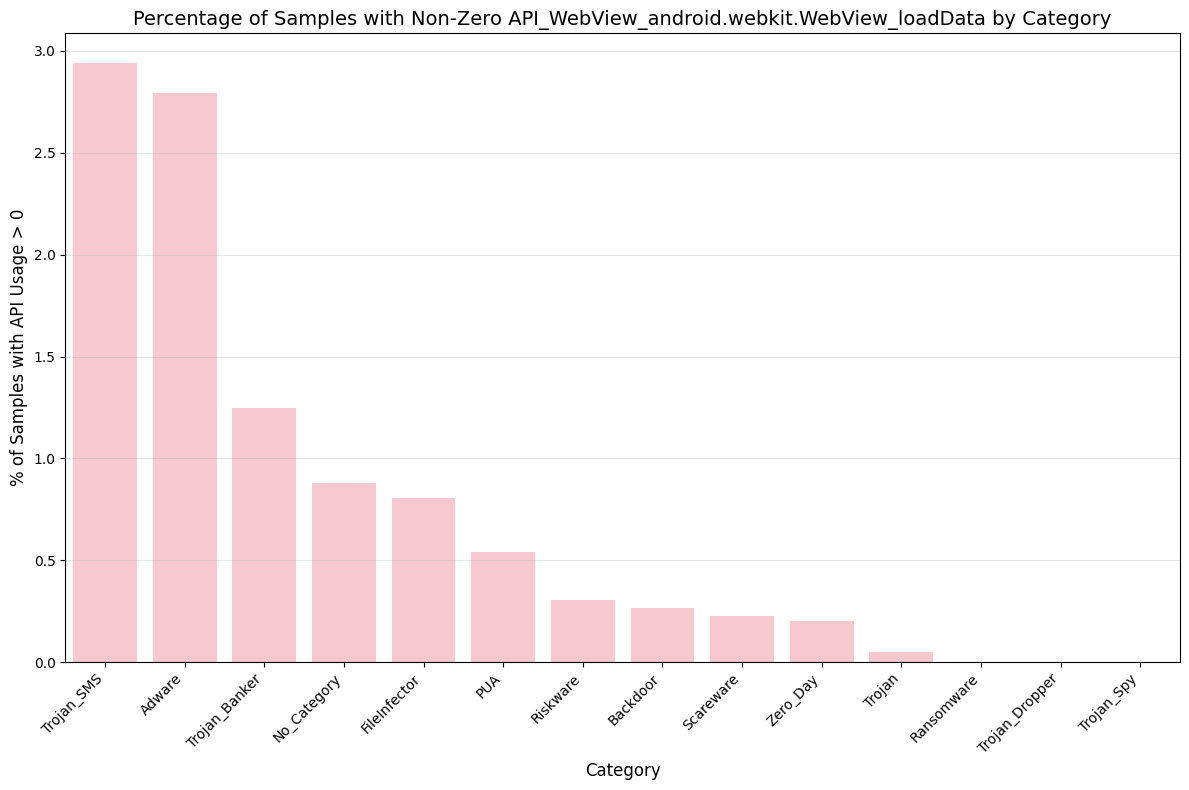

In [43]:
# Define which API to analyze
api_feature = "API_WebView_android.webkit.WebView_loadData"

# Group by Category and count non-zero values
category_counts = {}
total_counts = default_pipeline.EDA.dataset['Category'].value_counts()

# Loop through categories for detailed analysis
for category in default_pipeline.EDA.dataset['Category'].unique():
    # Filter for this category
    category_data = default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category]
    
    # Count non-zero values
    non_zero = (category_data[api_feature] > 0).sum()
    total = len(category_data)
    pct = (non_zero / total) * 100 if total > 0 else 0
    
    # Store results
    category_counts[category] = {
        'total_samples': total,
        'non_zero_samples': non_zero,
        'percent_non_zero': pct
    }

# Convert to DataFrame for better display
results_df = pd.DataFrame.from_dict(category_counts, orient='index')
results_df = results_df.sort_values('percent_non_zero', ascending=False)

# Display results
print(f"Non-zero values of {api_feature} by category:")
display(results_df)

# Optional: Create a visualization

plt.figure(figsize=(12, 8))
sns.barplot(x=results_df.index, y='percent_non_zero', data=results_df, color='pink')
plt.title(f"Percentage of Samples with Non-Zero {api_feature} by Category", fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('% of Samples with API Usage > 0', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

This bar chart shows that Adware and Trojan_SMS have the highest non-zero usage rates of the WebView_loadData API (2.94% and 2.80%), likely reflecting their use of web content for ads or phishing. However, overall usage remains rare, most categories use the API in less than 1% of their samples, suggesting limited relevance of this API for many malware types.

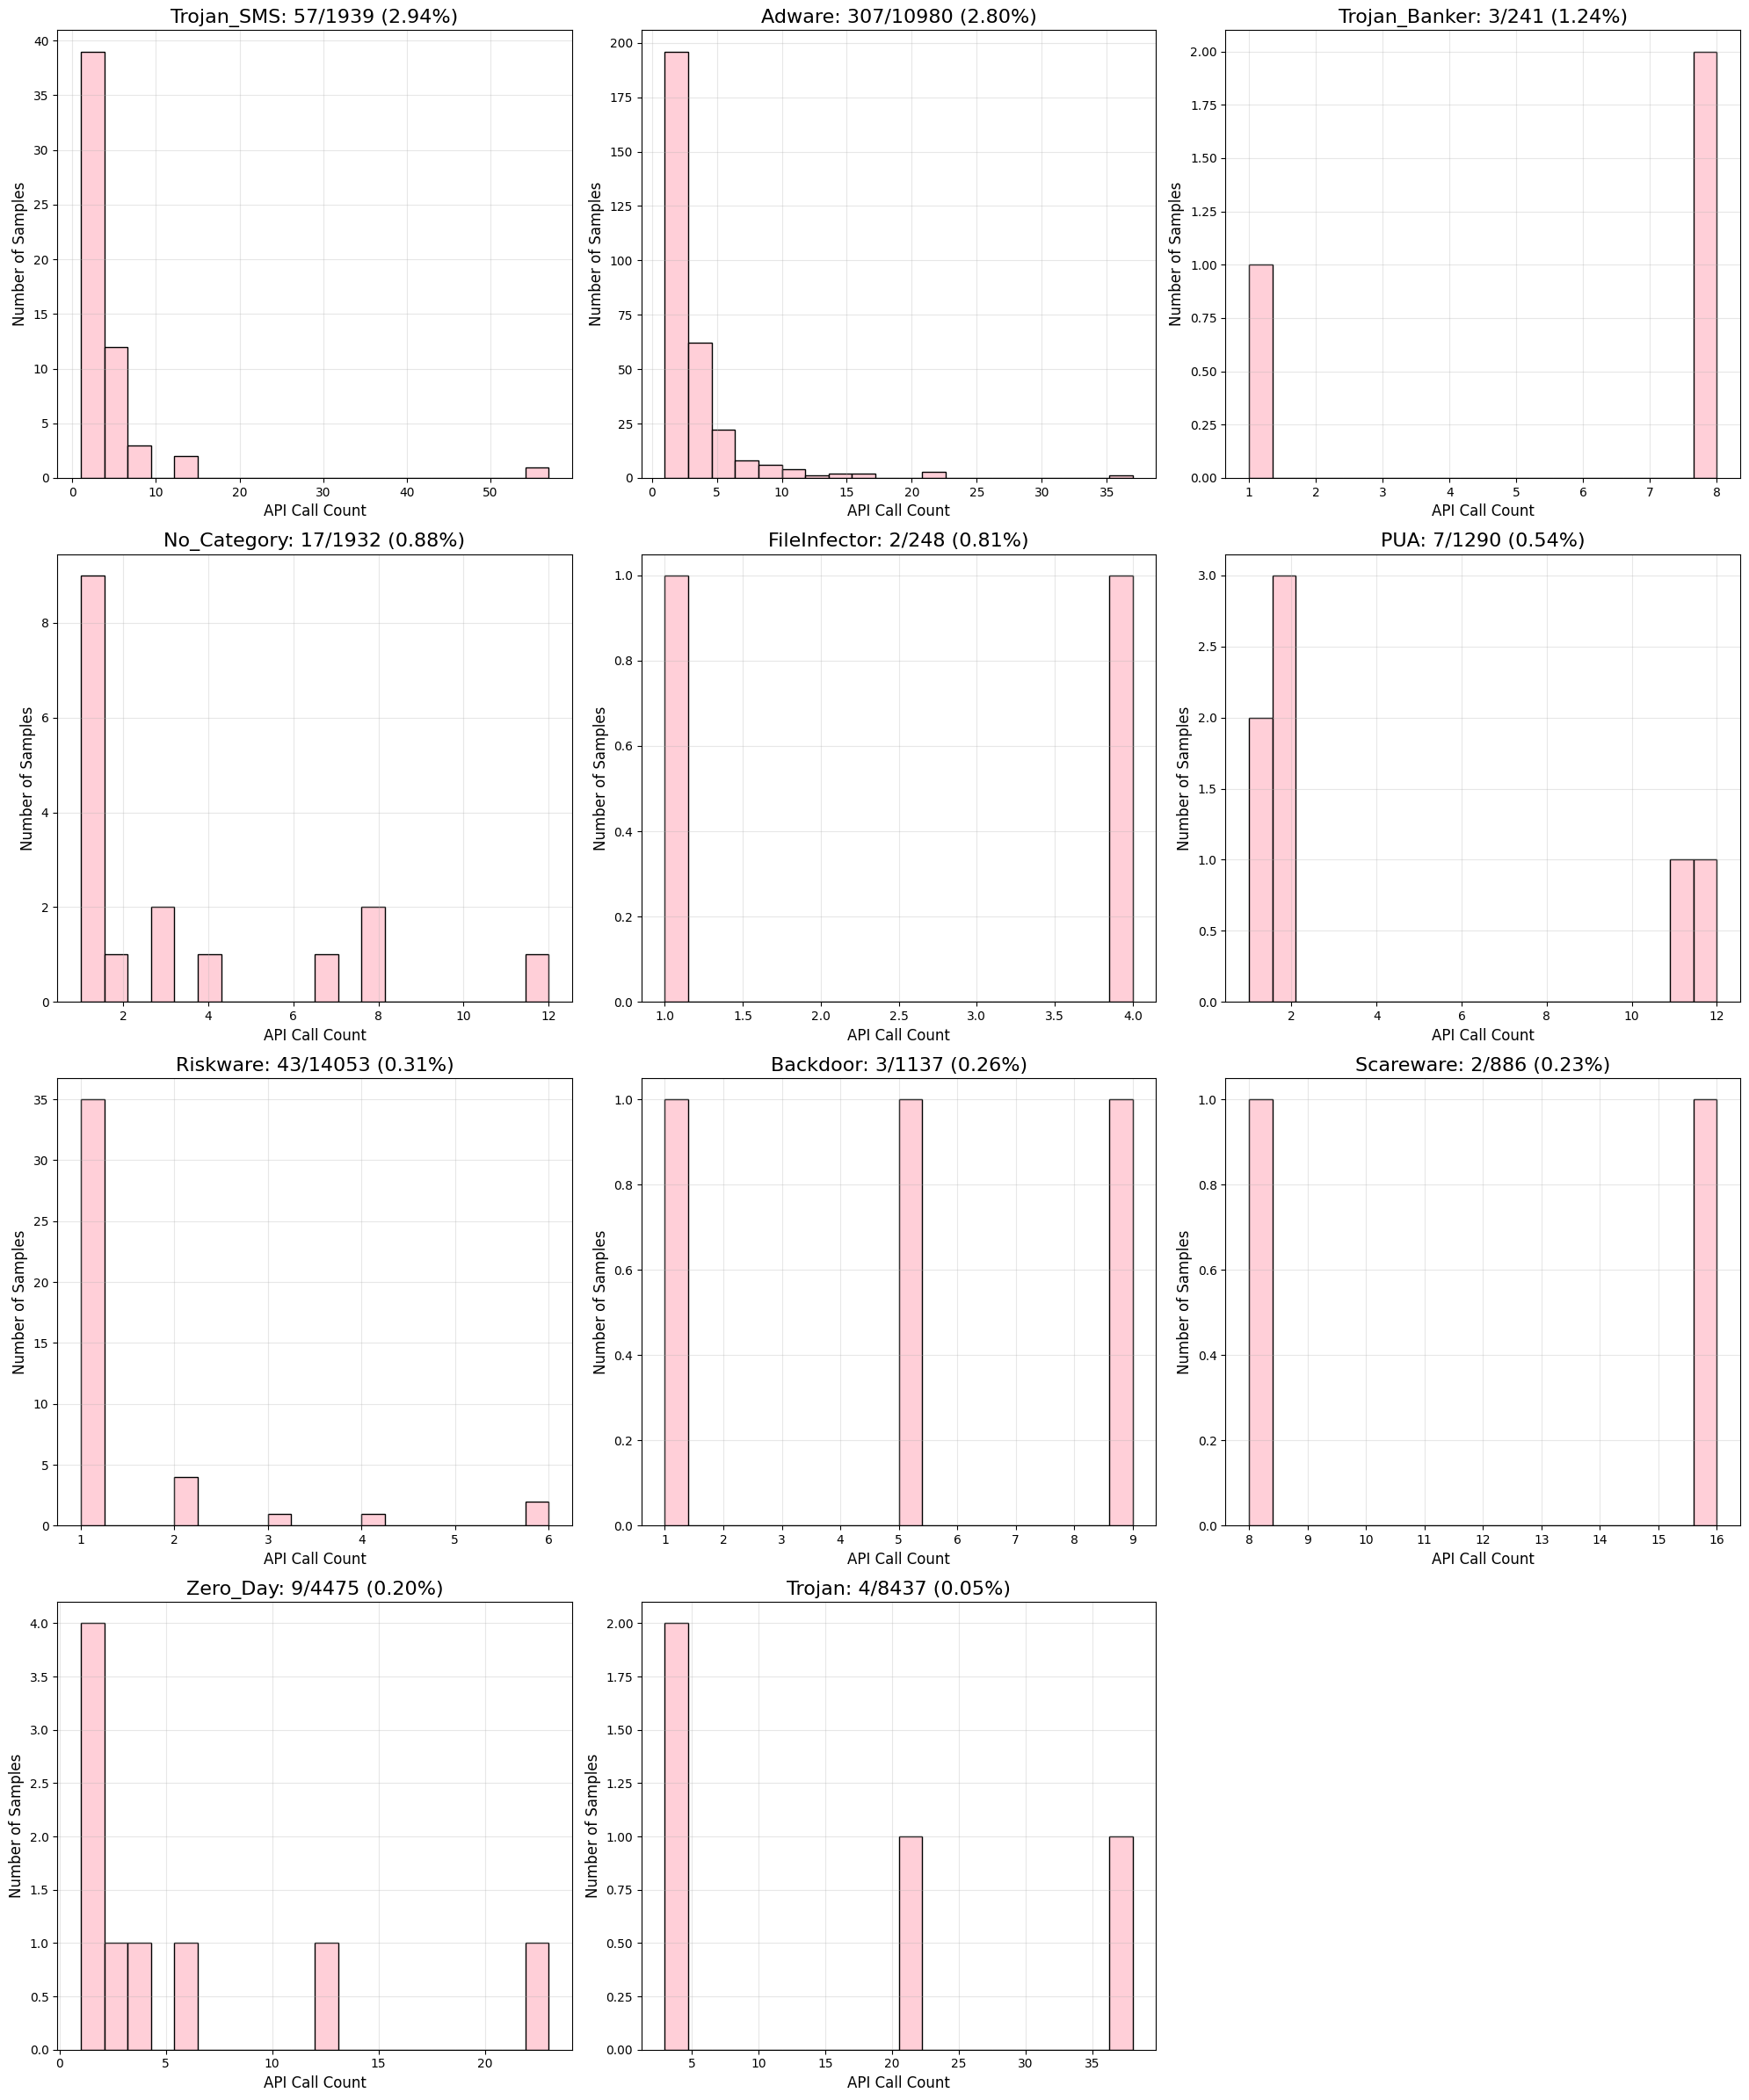

In [44]:
# Examine value distribution within categories that use this API
top_categories = ['Trojan_SMS', 'Adware', 'Trojan_Banker', "No_Category", "FileInfector",
                  "PUA", "Riskware", "Backdoor", "Scareware", "Zero_Day", "Trojan"]
api_feature = "API_WebView_android.webkit.WebView_loadData"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Most malware categories show very low usage of the WebView_loadData API, with only a handful of samples per type making any calls at all. Adware and Trojan_SMS are exceptions, Adware usage gradually declines from 1 to ~35 calls, suggesting dynamic content loading, while Trojan_SMS displays two spikes (1–5 and ~50 calls), hinting at different versions or tactics.

Trojan_Banker and FileInfector both exhibit bimodal distributions, typically 1 or 4–8 calls, likely tied to fixed templates. PUA and Riskware mainly stick to 1–2 calls, indicating minimal or supporting use. Backdoor shows deliberate jumps (1, 5, 9), which seems more staged than random.

Scareware shows a very rigid pattern (8 or 16 calls), pointing to template-driven scare tactics. Zero_Day and Trojan variants rarely call the API and cluster around 1 call, suggesting limited or experimental use.

There’s a wide variation in how often different malware families use this API: Scareware shows 88.71% usage, FileInfector 43.95%, and Ransomware only 4.28%. This reflects how differently malware operates, Scareware relies on visuals, while Ransomware works silently.

These usage patterns are highly category, specific, making this API useful for distinguishing malware behavior, especially when used in combination with other features.

Both Adware and Trojan_SMS samples frequently show 1 to 5 calls to this API. This overlap means the feature doesn't clearly separate these categories. The model sees nearly identical values for different malware types. And these are the ones with the highest percentage of non-zero calls.


Given how sparse and noisy it is across the dataset, dropping this feature could definitely be considered.

#### loadDataWithBaseURL

In [45]:
df['API_WebView_android.webkit.WebView_loadDataWithBaseURL'].describe()

count    53439.000000
mean         0.320945
std          2.334040
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        142.000000
Name: API_WebView_android.webkit.WebView_loadDataWithBaseURL, dtype: float64

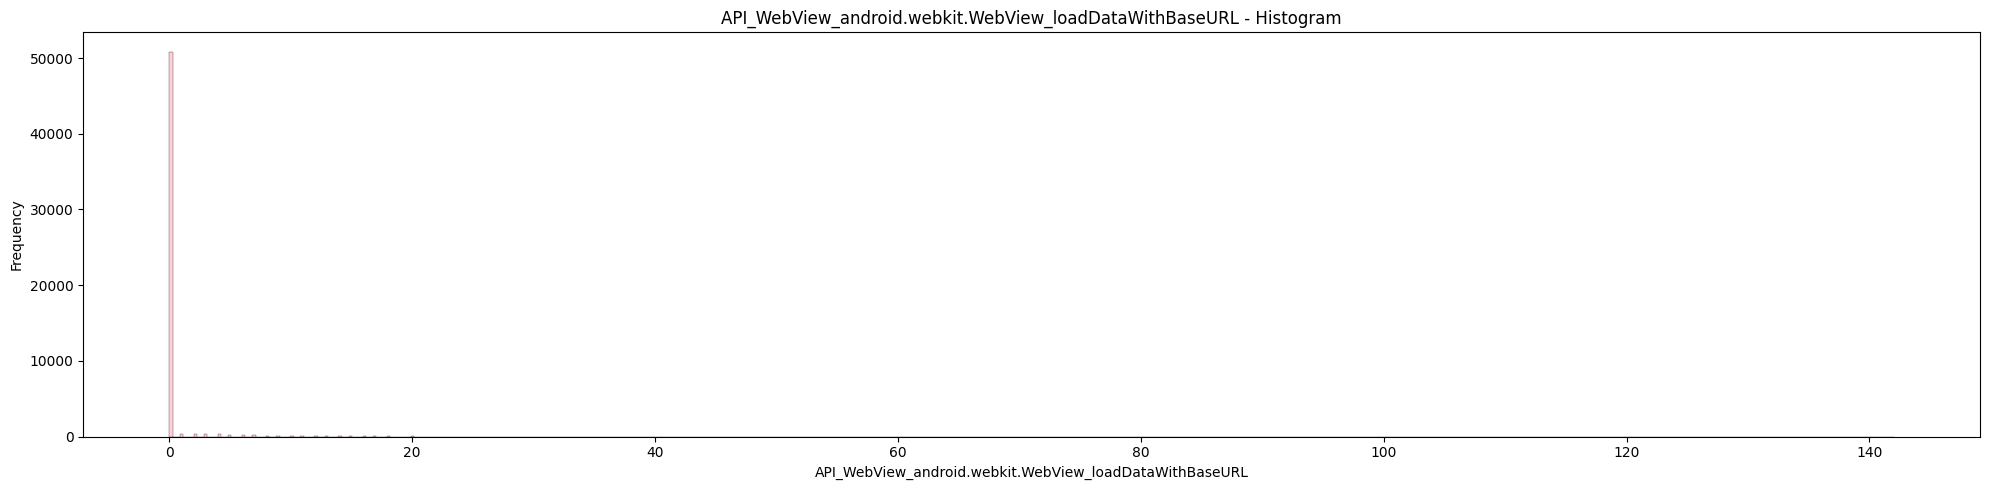

In [46]:
default_pipeline.EDA.plot_histograms(features=["API_WebView_android.webkit.WebView_loadDataWithBaseURL"], n_cols=1, bins=500)

This histogram shows a strong right skew, with most samples (~50,000) making zero calls to the WebView_loadDataWithBaseURL API. To better understand the pattern of actual usage, we will replot the distribution excluding the zero values.

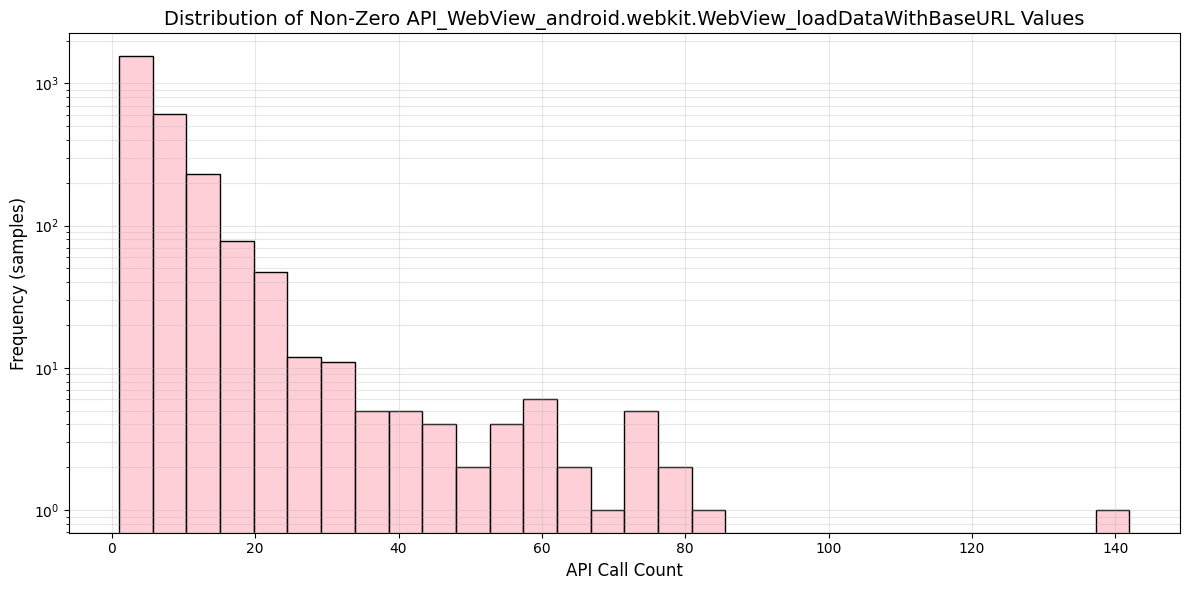

In [47]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_WebView_android.webkit.WebView_loadDataWithBaseURL"] > 0]
sns.histplot(nonzero_samples["API_WebView_android.webkit.WebView_loadDataWithBaseURL"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_WebView_android.webkit.WebView_loadDataWithBaseURL"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()

This bar chart shows that Adware and Trojan_SMS also have the highest non-zero usage of the WebView_loadDataWithBaseURL API (2.60% and 2.38%), likely tied to their need for displaying ads or crafting phishing views. Still, most categories use this API in fewer than 1% of their samples, reinforcing its limited relevance across broader malware families.

In [48]:
df.groupby('Category')['API_WebView_android.webkit.WebView_loadDataWithBaseURL'].describe()

count      mean       std  min  25%  50%  75%    max
Category                                                              
Adware          10980.0  0.624499  3.527530  0.0  0.0  0.0  0.0   84.0
Backdoor         1137.0  0.204925  1.778998  0.0  0.0  0.0  0.0   29.0
FileInfector      248.0  0.084677  0.573440  0.0  0.0  0.0  0.0    6.0
No_Category      1932.0  0.701863  3.092253  0.0  0.0  0.0  0.0   41.0
PUA              1290.0  0.296899  2.415570  0.0  0.0  0.0  0.0   43.0
Ransomware       3411.0  0.000000  0.000000  0.0  0.0  0.0  0.0    0.0
Riskware        14053.0  0.155412  1.378812  0.0  0.0  0.0  0.0   32.0
Scareware         886.0  0.200903  2.966906  0.0  0.0  0.0  0.0   61.0
Trojan           8437.0  0.140334  1.783301  0.0  0.0  0.0  0.0   62.0
Trojan_Banker     241.0  0.510373  2.325783  0.0  0.0  0.0  0.0   19.0
Trojan_Dropper   1570.0  0.012739  0.181603  0.0  0.0  0.0  0.0    6.0
Trojan_SMS       1939.0  0.558535  4.547882  0.0  0.0  0.0  0.0  142.0
Trojan_Spy       2840.0  1.065493  2.250108  0.0  0.0  0.0  0.0   12.0
Zero_Day         4475.0  0.112402  0.860713  0.0  0.0  0.0  0.0   16.0

This summary shows that while most categories have a median of zero WebView_loadDataWithBaseURL calls, indicating rare usage.
Adware, Trojan_SMS, and Trojan_Spy stand out with the highest means (0.62, 0.56, and 1.07 respectively), suggesting these malware types make more frequent use of this API, likely for dynamic content or phishing payloads.

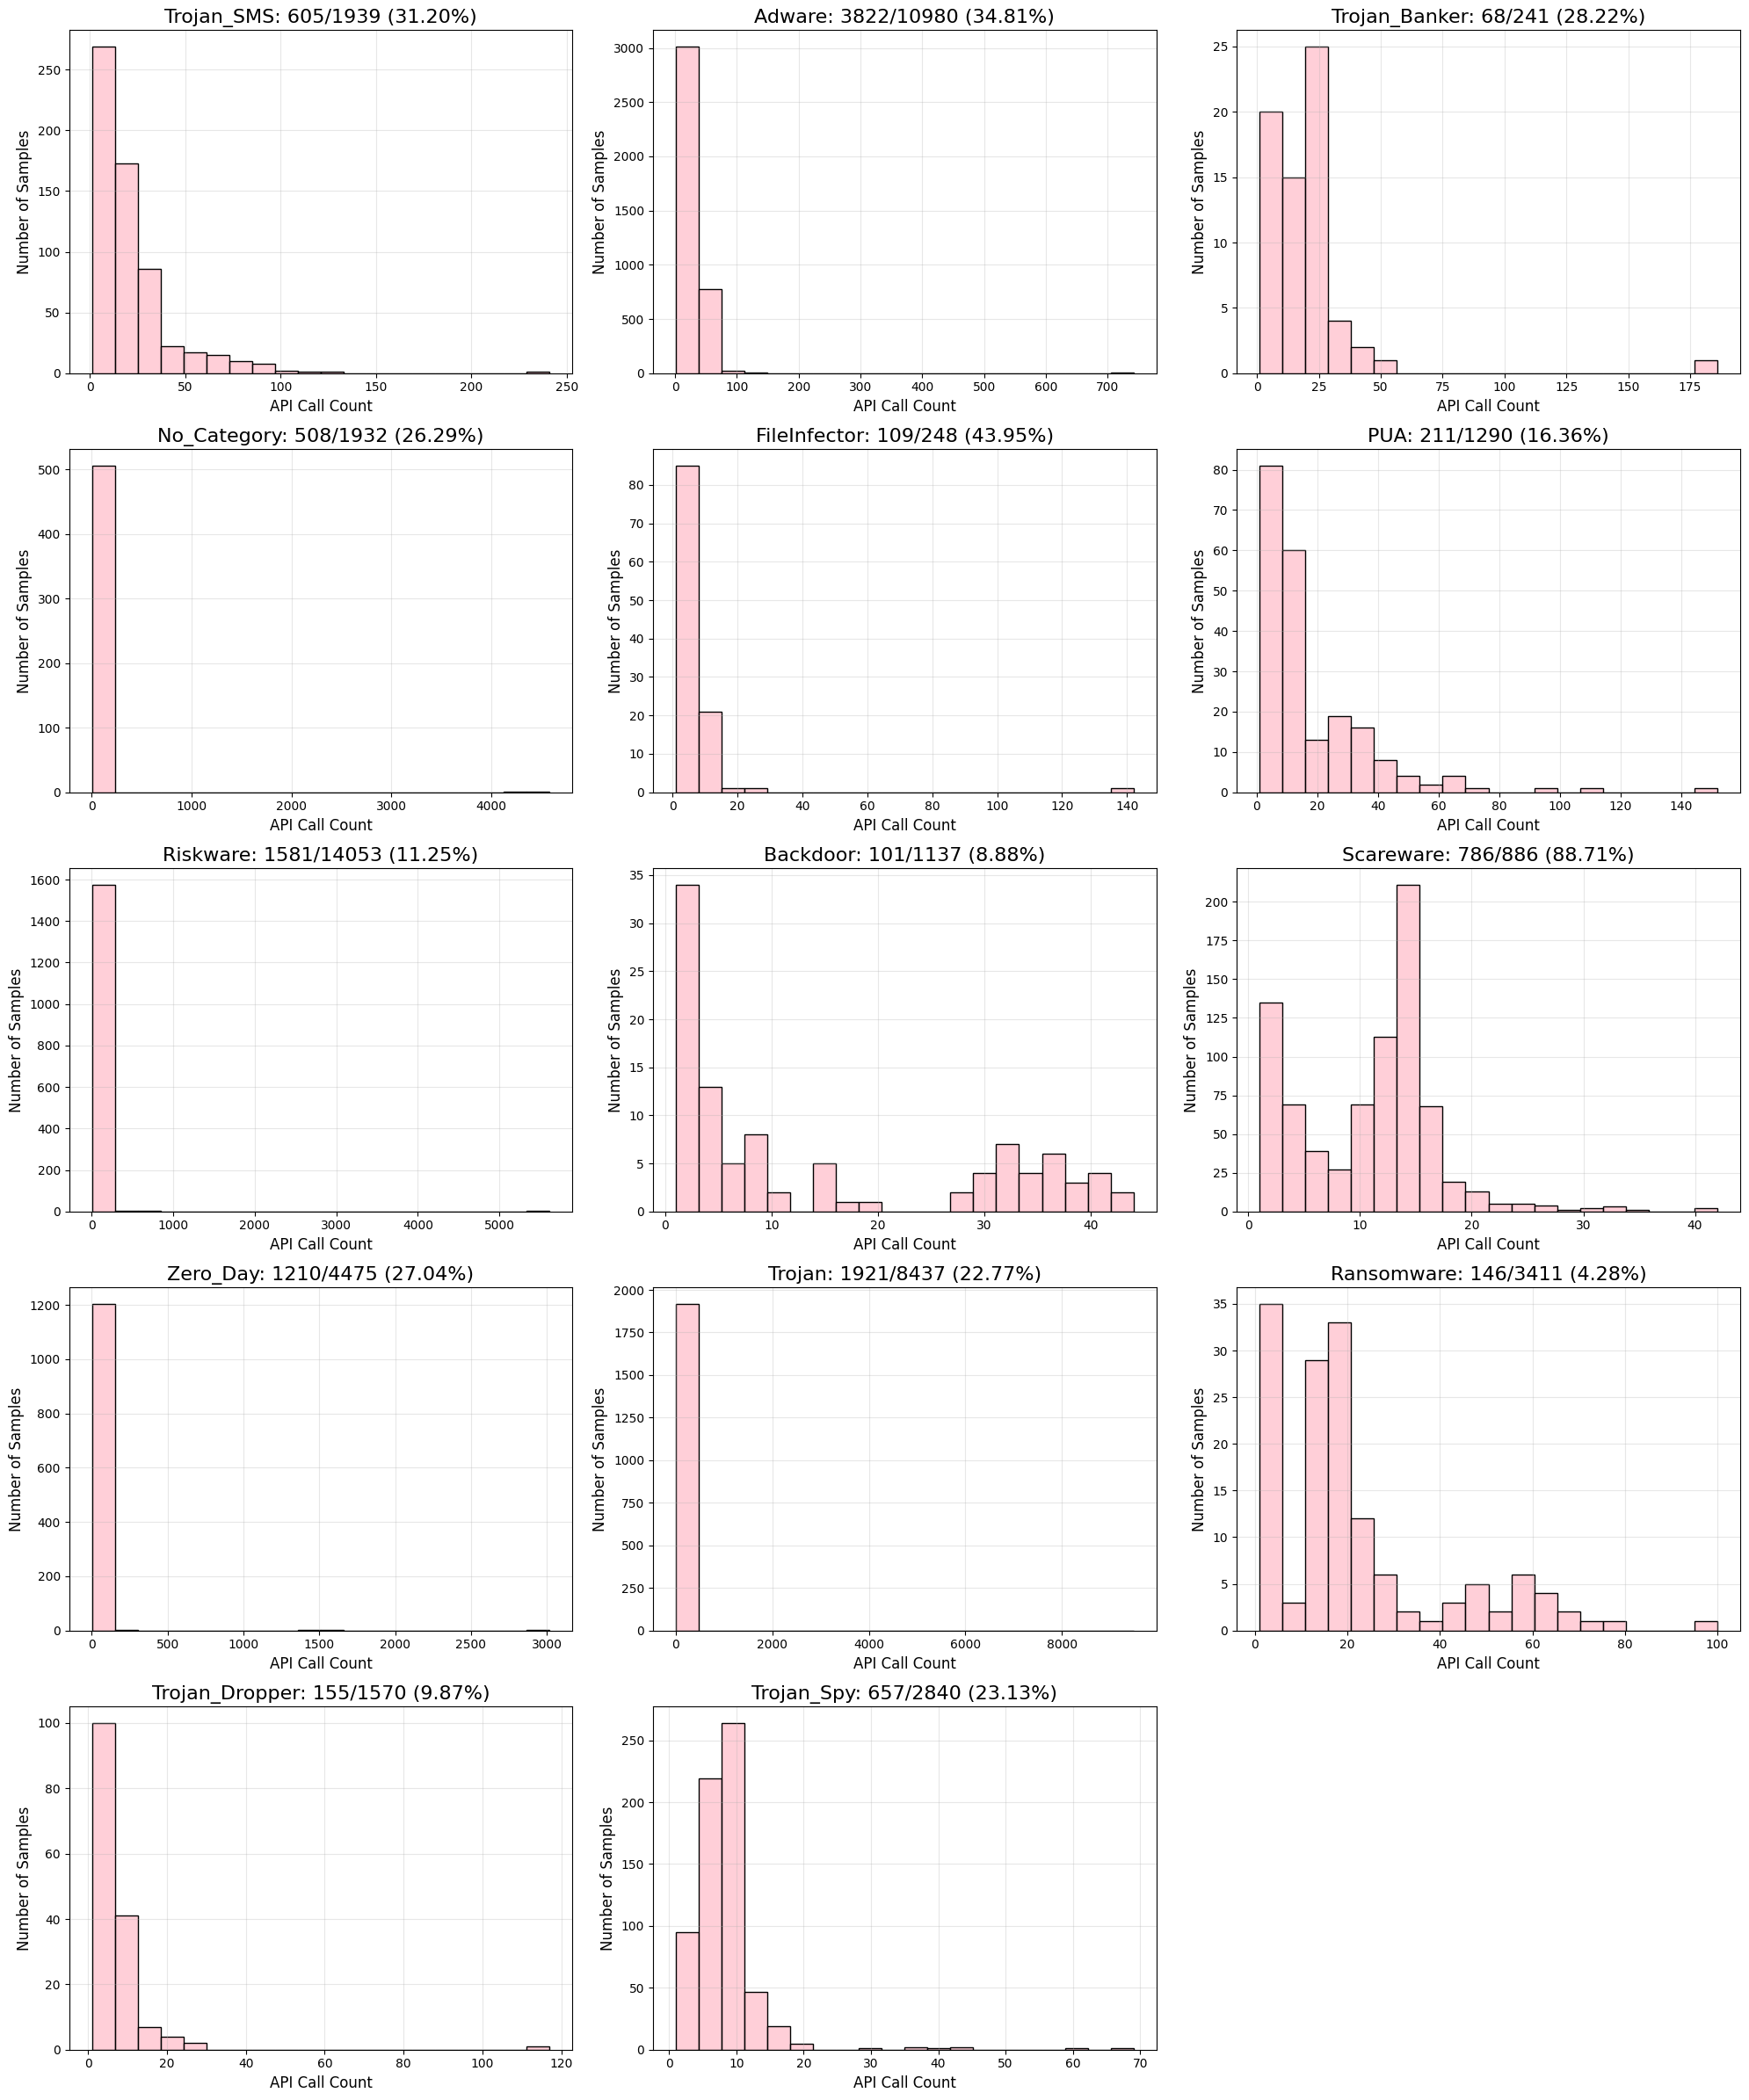

In [49]:
# Examine value distribution within categories that use this API
top_categories = ['Trojan_SMS', 'Adware', 'Trojan_Banker', "No_Category", "FileInfector",
                  "PUA", "Riskware", "Backdoor", "Scareware", "Zero_Day", "Trojan",
                  "Ransomware", "Trojan_Dropper", "Trojan_Spy"]
api_feature = "API_WebView_android.webkit.WebView_loadUrl"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(5, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

The distribution of WebView_loadDataWithBaseURL API usage shows distinct patterns across categories, though usage is generally sparse.

Scareware again stands out with a clear peak around 10–15 calls, consistent with scripted behavior for displaying fake alerts.

Backdoor shows spikes at regular intervals (1, 5, 10), suggesting periodic command-and-control behavior.

Riskware, PUA, and Zero_Day mostly make 1 or 2 calls, indicating simple, one-off uses.

Trojan and Trojan_Dropper show scattered usage with low density, pointing to inconsistent or optional use across samples.

Ransomware and Trojan_Banker barely use this API, reinforcing its limited role in their attack flow.

Trojan_Spy shows a subtle peak around 10 calls, possibly tied to accessing or exfiltrating web-based content.

Overall, this API is used meaningfully by only a few families, with Scareware being the clearest case—making it a minor but potentially useful feature.

#### addJavascriptInterface

In [ ]:
df['API_WebView_android.webkit.WebView_addJavascriptInterface'].describe()

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_WebView_android.webkit.WebView_addJavascriptInterface"], n_cols=1, bins=500)

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_WebView_android.webkit.WebView_addJavascriptInterface"] > 0]
sns.histplot(nonzero_samples["API_WebView_android.webkit.WebView_addJavascriptInterface"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_WebView_android.webkit.WebView_addJavascriptInterface"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
df.groupby('Category')['API_WebView_android.webkit.WebView_addJavascriptInterface'].describe()

In [ ]:
# Examine value distribution within categories that use this API
top_categories = ['Trojan_SMS', 'Adware', 'Trojan_Banker', "No_Category", "FileInfector",
                  "PUA", "Riskware", "Backdoor", "Scareware", "Zero_Day", "Trojan",
                  "Ransomware", "Trojan_Dropper", "Trojan_Spy"]
api_feature = "API_WebView_android.webkit.WebView_addJavascriptInterface"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(5, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### evaluateJavascript

In [ ]:
df['API_WebView_android.webkit.WebView_evaluateJavascript'].describe()

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_WebView_android.webkit.WebView_evaluateJavascript"], n_cols=1, bins=500)

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_WebView_android.webkit.WebView_evaluateJavascript"] > 0]
sns.histplot(nonzero_samples["API_WebView_android.webkit.WebView_evaluateJavascript"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_WebView_android.webkit.WebView_evaluateJavascript"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
df.groupby('Category')['API_WebView_android.webkit.WebView_evaluateJavascript'].describe()

In [ ]:
# Examine value distribution within categories that use this API
top_categories = ['Trojan_SMS', 'Adware', 'Trojan_Banker', "No_Category", "FileInfector",
                  "PUA", "Riskware", "Backdoor", "Scareware", "Zero_Day", "Trojan",
                  "Ransomware", "Trojan_Dropper", "Trojan_Spy"]
api_feature = "API_WebView_android.webkit.WebView_evaluateJavascript"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(5, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### postUrl

Allows WebView to send HTTP POST requests

In [ ]:
df['API_WebView_android.webkit.WebView_postUrl'].describe()

At lease 75% of all samples never use a WebView to send data via POST request, indicating a very rare behavior.

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_WebView_android.webkit.WebView_postUrl"], n_cols=1, bins=500)

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_WebView_android.webkit.WebView_postUrl"] > 0]
sns.histplot(nonzero_samples["API_WebView_android.webkit.WebView_postUrl"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_WebView_android.webkit.WebView_postUrl"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
df.groupby('Category')['API_WebView_android.webkit.WebView_postUrl'].describe()

In [ ]:
api_feature = "API_WebView_android.webkit.WebView_postUrl"

non_zero_count = (default_pipeline.EDA.dataset["API_WebView_android.webkit.WebView_postUrl"] > 0).sum()
total_samples = len(default_pipeline.EDA.dataset)

print(non_zero_count)
print(total_samples)

We will focus on Trojan, Zero_Day and PUA since they contain non-zero values.

We will now see the distribution of the non-zero values among these different categories.

In [ ]:
# Filter for Trojan samples
Trojan_data = default_pipeline.EDA.dataset[
    default_pipeline.EDA.dataset["Category"] == "Trojan"
]

# Count non-zero values
api_feature = "API_WebView_android.webkit.WebView_postUrl"
non_zero_data = Trojan_data[Trojan_data[api_feature] > 0]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: All data (zero-dominated)
sns.histplot(data=Trojan_data, x=api_feature, bins=20, color="pink", ax=ax1)
ax1.set_title("All Trojan Samples", fontsize=13)

# Right plot: Only non-zero values, without the annotation
sns.histplot(data=non_zero_data, x=api_feature, bins=10, color="hotpink", ax=ax2)
ax2.set_title("Non-Zero Values Only", fontsize=13)
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()

# Print counts without specifically calling out individual samples
print(Trojan_data[api_feature].value_counts().sort_index())

In [ ]:
# Filter for PUA samples
PUA_data = default_pipeline.EDA.dataset[
    default_pipeline.EDA.dataset["Category"] == "PUA"
]

# Count non-zero values
api_feature = "API_WebView_android.webkit.WebView_postUrl"
non_zero_data = PUA_data[PUA_data[api_feature] > 0]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: All data (zero-dominated)
sns.histplot(data=PUA_data, x=api_feature, bins=20, color="pink", ax=ax1)
ax1.set_title("All Trojan Samples", fontsize=13)

# Right plot: Only non-zero values, without the annotation
sns.histplot(data=non_zero_data, x=api_feature, bins=10, color="hotpink", ax=ax2)
ax2.set_title("Non-Zero Values Only", fontsize=13)
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()

# Print counts without specifically calling out individual samples
print(PUA_data[api_feature].value_counts().sort_index())

In [ ]:
# Filter for ZERO DAY samples
Zero_Day_data = default_pipeline.EDA.dataset[
    default_pipeline.EDA.dataset["Category"] == "Zero_Day"
]

# Count non-zero values
api_feature = "API_WebView_android.webkit.WebView_postUrl"
non_zero_data = Zero_Day_data[Zero_Day_data[api_feature] > 0]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: All data (zero-dominated)
sns.histplot(data=Zero_Day_data, x=api_feature, bins=20, color="pink", ax=ax1)
ax1.set_title("All Zero_Day Samples", fontsize=13)

# Right plot: Only non-zero values, without the annotation
sns.histplot(data=non_zero_data, x=api_feature, bins=10, color="hotpink", ax=ax2)
ax2.set_title("Non-Zero Values Only", fontsize=13)
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()

# Print counts without specifically calling out individual samples
print(Zero_Day_data[api_feature].value_counts().sort_index())

Out of 53,439 samples, only 21 showed any non-zero usage of the WebView.postUrl API, making it extremely rare overall. When looking by category, Zero-Day malware had just one sample using it, PUA had two, and Trojan also had two, each with very small values. There's no clear malware-specific pattern. 

Because this API is used so sparsely, it doesn't really help distinguish between different malware categories. Keeping it would likely introduce more noise than useful information. 
For feature selection, it is a good idea to remove this feature.


#### postWebMessage

In [ ]:
df['API_WebView_android.webkit.WebView_postWebMessage'].describe()

This feature has no predicting power and should be dropped.

#### savePassword

In [ ]:
df['API_WebView_android.webkit.WebView_savePassword'].describe()

This feature has no predicting power and should be dropped.

#### setHttpAuthUsernamePassword

In [ ]:
df['API_WebView_android.webkit.WebView_setHttpAuthUsernamePassword'].describe()

This feature has no predicting power and should be dropped.

#### getHttpAuthUsernamePassword

In [ ]:
df['API_WebView_android.webkit.WebView_getHttpAuthUsernamePassword'].describe()

This feature has no predicting power and should be dropped.

#### setWebContentsDebuggingEnabled

In [50]:
df['API_WebView_android.webkit.WebView_setWebContentsDebuggingEnabled'].describe()

count    53439.000000
mean         0.009731
std          1.270742
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        278.000000
Name: API_WebView_android.webkit.WebView_setWebContentsDebuggingEnabled, dtype: float64

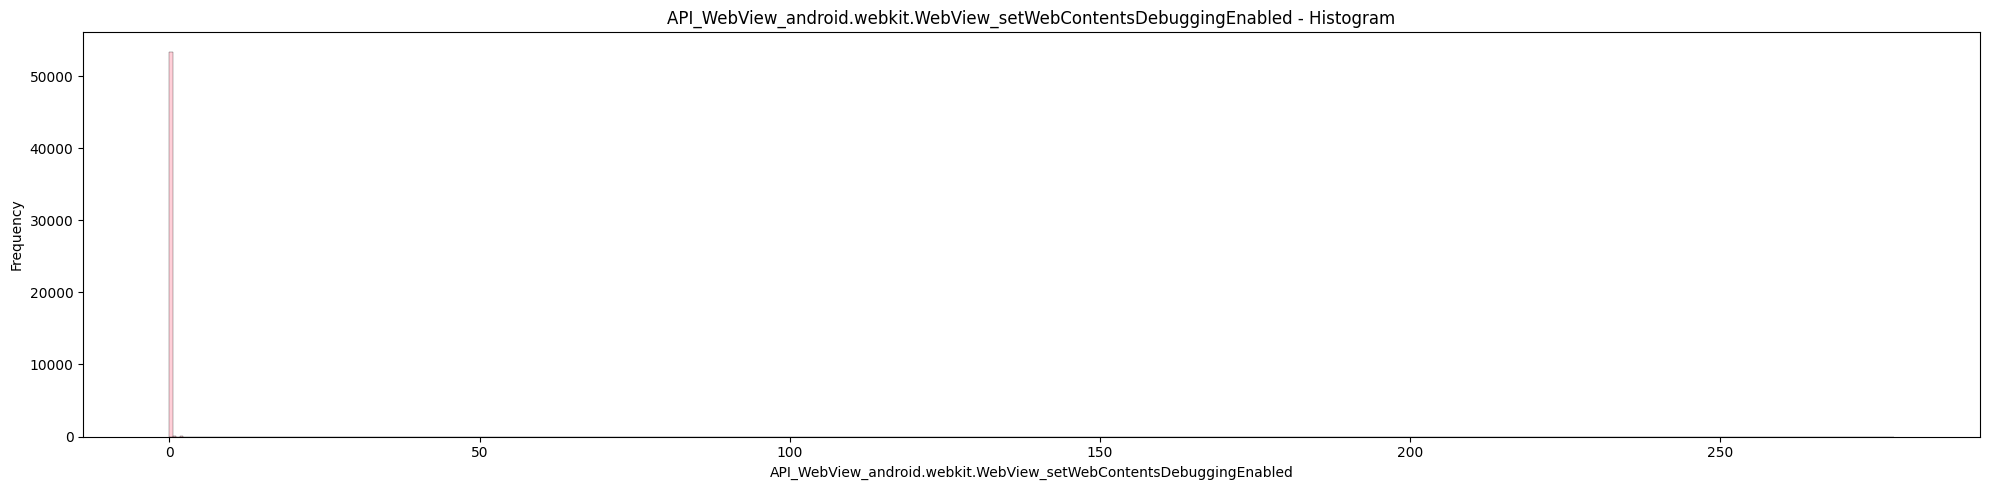

In [51]:
default_pipeline.EDA.plot_histograms(features=["API_WebView_android.webkit.WebView_setWebContentsDebuggingEnabled"], n_cols=1, bins=500)

This histogram shows a strong right skew, with the vast majority of samples (~50,000) having zero calls to the setWebContentsDebuggingEnabled API. To better understand the distribution of actual usage, we will replot the data excluding zero values.

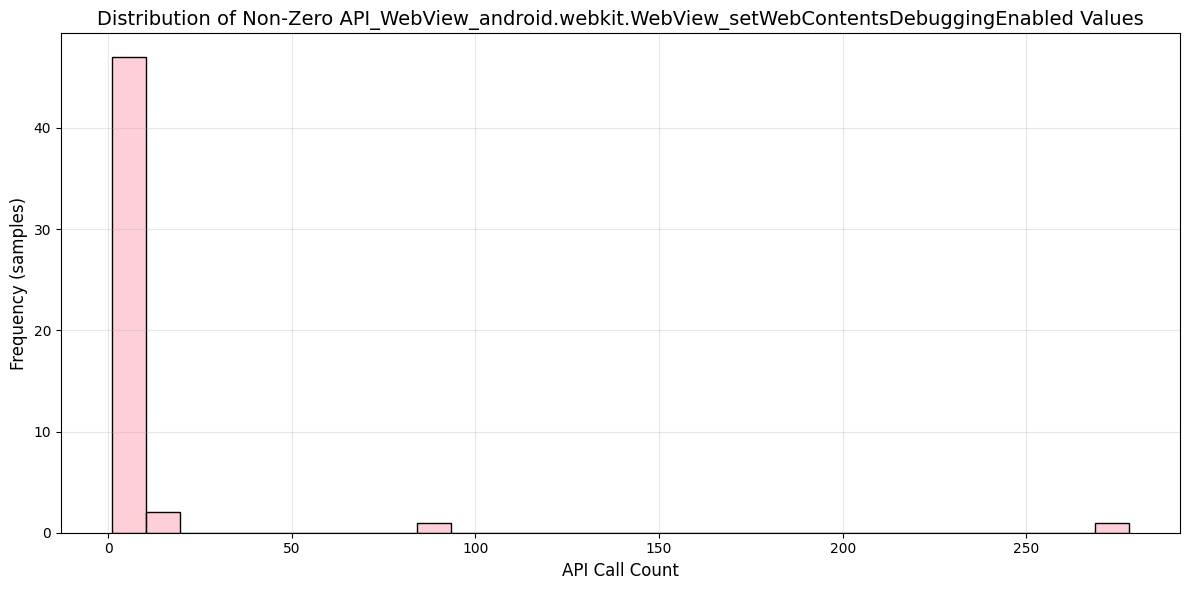

In [52]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_WebView_android.webkit.WebView_setWebContentsDebuggingEnabled"] > 0]
sns.histplot(nonzero_samples["API_WebView_android.webkit.WebView_setWebContentsDebuggingEnabled"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_WebView_android.webkit.WebView_setWebContentsDebuggingEnabled"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

This bar chart shows that the setWebContentsDebuggingEnabled API is rarely used across the dataset, with nearly all samples having zero calls and only a small handful showing minimal usage. A few rare outliers with high call counts exist, but the lack of consistent use across categories suggests this API is likely not a strong signal for malware classification.

In [53]:
df.groupby('Category')['API_WebView_android.webkit.WebView_setWebContentsDebuggingEnabled'].describe()

count      mean       std  min  25%  50%  75%    max
Category                                                              
Adware          10980.0  0.007741  0.223483  0.0  0.0  0.0  0.0   18.0
Backdoor         1137.0  0.323659  8.663552  0.0  0.0  0.0  0.0  278.0
FileInfector      248.0  0.000000  0.000000  0.0  0.0  0.0  0.0    0.0
No_Category      1932.0  0.004141  0.132628  0.0  0.0  0.0  0.0    5.0
PUA              1290.0  0.000000  0.000000  0.0  0.0  0.0  0.0    0.0
Ransomware       3411.0  0.001173  0.048422  0.0  0.0  0.0  0.0    2.0
Riskware        14053.0  0.002064  0.127083  0.0  0.0  0.0  0.0   12.0
Scareware         886.0  0.000000  0.000000  0.0  0.0  0.0  0.0    0.0
Trojan           8437.0  0.000711  0.034422  0.0  0.0  0.0  0.0    2.0
Trojan_Banker     241.0  0.000000  0.000000  0.0  0.0  0.0  0.0    0.0
Trojan_Dropper   1570.0  0.000000  0.000000  0.0  0.0  0.0  0.0    0.0
Trojan_SMS       1939.0  0.000000  0.000000  0.0  0.0  0.0  0.0    0.0
Trojan_Spy       2840.0  0.001056  0.032490  0.0  0.0  0.0  0.0    1.0
Zero_Day         4475.0  0.003799  0.134500  0.0  0.0  0.0  0.0    6.0

This summary table shows that the setWebContentsDebuggingEnabled API is rarely used across all categories, with most samples having zero calls and very low average values. While Backdoor stands out with occasional high call counts (max = 278), the lack of consistent usage across malware types suggests this API is not a reliable signal for classification.

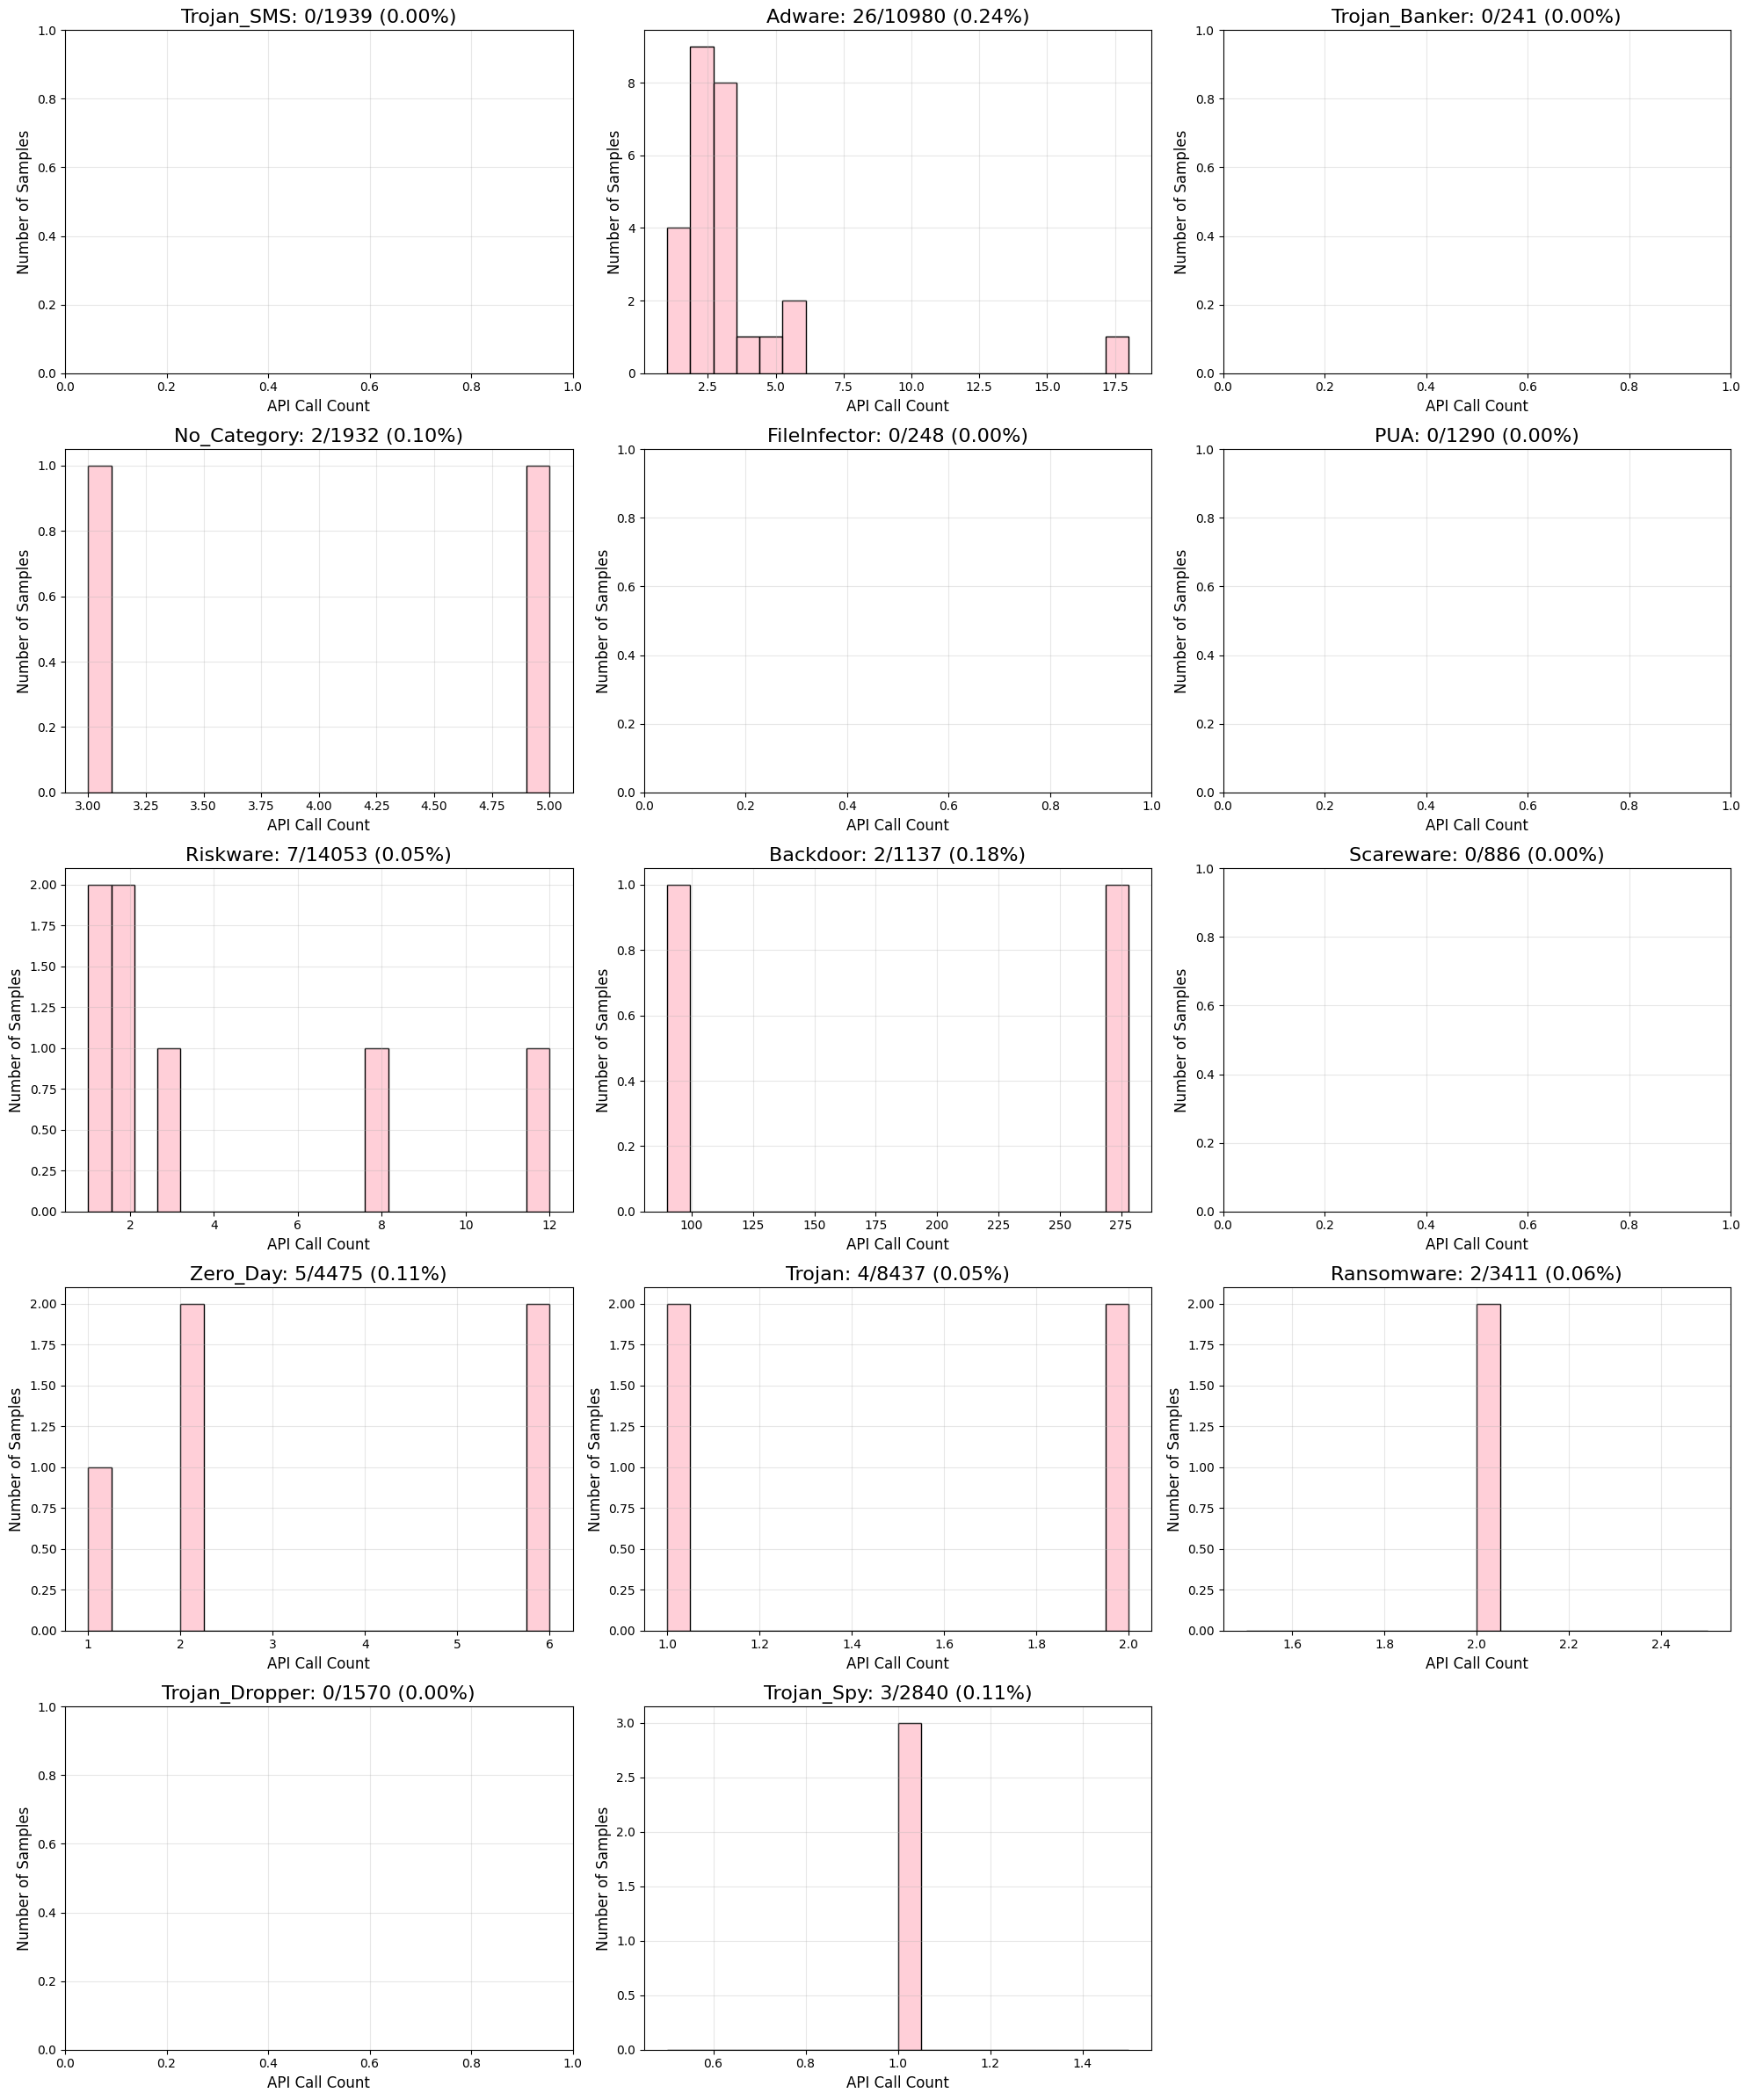

In [54]:
top_categories = ['Trojan_SMS', 'Adware', 'Trojan_Banker', "No_Category", "FileInfector",
                  "PUA", "Riskware", "Backdoor", "Scareware", "Zero_Day", "Trojan",
                  "Ransomware", "Trojan_Dropper", "Trojan_Spy"]
api_feature = "API_WebView_android.webkit.WebView_setWebContentsDebuggingEnabled"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(5, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

The distribution of setWebContentsDebuggingEnabled API usage is extremely sparse and inconsistent across all categories, reinforcing its limited practical use in malware classification.

Most categories, including Trojan_SMS, Trojan_Banker, FileInfector, PUA, Scareware, and Trojan_Dropper, show no usage at all, with zero non-zero samples recorded.

Adware is one of the few with detectable activity, 26 samples out of 10,980, showing a short peak between 2 and 6 calls, with one outlier near 18. This suggests limited but slightly more deliberate usage.

Backdoor stands out slightly due to rare outliers, with 2 samples making over 270 calls, pointing to very occasional, high-volume use that may reflect debugging or developer oversight.

No_Category and Zero_Day both show 2–5 samples making 1–5 calls, while Trojan, Ransomware, Riskware, and Trojan_Spy have a few isolated low-count samples (1–3 calls).

Overall, the API is barely touched by any category, with no consistent usage patterns and an overwhelming majority of samples at zero. It is likely not a meaningful signal for malware behavior modeling.

### FILE I/O

This API handles basic file operations in Android apps. 




Typical Malware File Needs
Most malware only requires access to:

Configuration/settings files
Specific system files for persistence
A few data storage files
Several network sockets for communication
Occasionally application files to inject code


Features:

API_FileIO_libcore.io.IoBridge_open: Opens a file or socket. This API specifically creates the necessary connection by returning a file descriptor that can be used for subsequent read/write operations.

API_FileIO_android.content.ContextWrapper_openFileInput: Opens a private file for reading. It's designed specifically for accessing files that belong to the application and are not directly accessible by other apps.

API_FileIO_android.content.ContextWrapper_openFileOutput: Opens a private file for writing. It returns a FileOutputStream that allows the app to write data to the specified file in the app's internal storage.

API_FileIO_android.content.ContextWrapper_deleteFile: Deletes a private file.


#### Libcore.io

**libcore.io.IoBridge_open**

In [ ]:
df['API_FileIO_libcore.io.IoBridge_open'].describe()

At least 50% of the malware does not use this feature.

And 25% call it 3 times or more.

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_FileIO_libcore.io.IoBridge_open"], n_cols=1, bins=500)

It is highly right skewed with a standar deviation more than eight times larger than the mean.

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_FileIO_libcore.io.IoBridge_open"] > 0]
sns.histplot(nonzero_samples["API_FileIO_libcore.io.IoBridge_open"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_FileIO_libcore.io.IoBridge_open"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log") 
plt.grid(alpha=0.3, which='both') 
plt.tight_layout()
plt.show()

The majority of these samples use this call 1 to 100 times. After 100 calls, the values drop a lot.

This is because file descriptors are reusable so opening a file once allows multiple read and write operations through that descriptor. Also, because the operating system puts limits on how many files or sockets an app can open at once, malware usually keeps things efficient. As a result, most malware sticks to fewer than 100 open operations to get the job done.

The samples with more than 1000 calls are probably malware with file-intensive purposes that need to interact with many files. Like ransomware that needs to access files for encryption.

In [ ]:
df.groupby('Category')['API_FileIO_libcore.io.IoBridge_open'].describe()

This feature might be very useful to predict Scareware since it is the only category with a meadian (9 calls) different than 0, and witg non-zero 25th percentile (3 calls). It also has a high usage compared to the others, having 25% of the samples make 13 or more calls, followed by Adware where 25% of samples make 6 or more calls (a pretty big difference).

This indicates file operations are fundamental to Scareware's core functionality which makes sense since it writes fake infection evidence, loads scary graphics and alarm sounds, and manages settings to keep the alerts popping up to scare the user and make fake alerts look real. 


Ransomware has the highest maximum (3042.0) despite 75th percentile of 0. This also makes sense since it targets many files for encryption.


IoBridge_open seems to be a good feature for detecting Scareware from all other categories, identifying extreme file-intensive Ransomware variants.

In [ ]:
top_categories = top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]
api_feature = "API_FileIO_libcore.io.IoBridge_open"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Near all scareware samples use this call. This percentage of sample usage is very high compared to the rest of categories. It also shows multiple high peaks compared to the other categories which appear to have a single high peak but for Trojan_Dropper.

This feature seems to be ideal to identifying all Scareware and distinguish between 
high-usage categories (like Adware or Riskware) and low-usage categories (like Ransomware or Trojan_Dropper).

#### android.content.ContextWrapper

**openFileInput**

In [ ]:
df['API_FileIO_android.content.ContextWrapper_openFileInput'].describe()

At least 75% of all samples never use this API. 

A maximum of 1,120 calls and mean of almost 2 shows extreme outliers.

The feature provides high variability

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_FileIO_android.content.ContextWrapper_openFileInput"], n_cols=1, bins=500)

Unsurprisingly, this feature is also very right skewed.

We will visualize the values without the 0s.

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_FileIO_android.content.ContextWrapper_openFileInput"] > 0]
sns.histplot(nonzero_samples["API_FileIO_android.content.ContextWrapper_openFileInput"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_FileIO_android.content.ContextWrapper_openFileInput"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log") 
plt.grid(alpha=0.3, which='both') 
plt.tight_layout()
plt.show()

Most samples make few openFileInput calls. 

More than 10000 samples make 1 to 40 calls, which indicate simple configigurations. 
Around 100 samples do 40 to 80 calls, showing a more elaborate data management.
And less than around 30 samples seem to take values larger than 200.

There are also some clear clusterings around high values like 600, 700 or around 1200, which makes us believe that the malware that make those calls is either the same or shares a common code. This feature will be probably good for distinguishing these malware categories.

In [ ]:
df.groupby('Category')['API_FileIO_android.content.ContextWrapper_openFileInput'].describe()

Opening private files is normal but limited behavior for apps (and even for malware).

Private File Access Analysis by Malware Category
The openFileInput API usage statistics reveal distinct patterns across malware categories:

At least 50% of the samples across all categories never used this call (median is 0). Only Riskware and Adware show have a 75th percentile different than 0. This shows that private file access is a specialized behavior and not something common to all malware, although each malware category has at least one sample that has used it. 

The highest usage categories are Riskware, followed by PUA and Adware.

Trojan_SMS and Backdoor have the maximum values of 247 and 244, respectively which will be further analyzed.

This feature looks as it could provide good discriminative power for mostly Riskware and Adware or specific variants of Trojan_SMS and Backdoor.



In [ ]:
top_categories = top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]
api_feature = "API_FileIO_android.content.ContextWrapper_openFileInput"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

We can devide usage in three main groups:

Frequent API callers: Riskware(41.93%), Adware (26.20%), PUA (24.88%)

Medium API callers: Backdoor (19.17%), Trojan_Spy (18.98%), Trojan (15.84%)

Minimal API callers: Trojan_SMS (8.72%), Ransomware (1.03%), Scareware (0.68%)

The frequent openFileInput callers probably depend on persistent private storage for their fundamental operations.

Adware & Riskware have pretty similar patterns with concentration at low values while PUA shows a slight more varied pattern.

Distingushing Riskware from Trojan is usually hard in Android security because they show very similar mechanisms and patterns. The thing is Trojans require immediate removal because it is clearly malicious but but Riskware is often legitimate apps that have potential risks due to security vulnerability or legal violations so they may not need to be removed right away, unless it is clear that they are being used for something harmful.

Here, there is a very big difference between non-zero samples of Riskware and Trojan, which makes it a good feature to use it for differentiating between them.

In comparison to IoBridge_open we can see that Scareware shows to be a more file-intensive category focusing on external files while Riskware and Adware show to be more privacy-invasive focusing on internal storage.

Lets compare the private vs public file access ratio by category.

In [ ]:
# Compare private vs public file access by category
private_api = "API_FileIO_android.content.ContextWrapper_openFileInput"
public_api = "API_FileIO_libcore.io.IoBridge_open"

# Calculate usage ratio
df['private_public_ratio'] = df[private_api] / (df[public_api] + 1)  # Add 1 to prevent division by zero

# Plot ratios by category (for samples using either API)
users = df[(df[private_api] > 0) | (df[public_api] > 0)]
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='private_public_ratio', data=users, color='orchid')
plt.yscale('log')
plt.title('Ratio of Private to Public File Access by Category')
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Those with ratio higher than 1, meaning PUA, accessed more private files than public ones, leading to more suspicious behavior.

On the other hand, Backdoor, Riskware and Trojan_Spy seem to have a balance between accessing private and public files. And Trojan_SMS, Scareware, Trojan_Banker, FileInfector and Ransomware accessed mostly public files but for a few outliers.

Public focused vs private focused clustering?

We will now move on and analyze the before and after reboor for the main categories that show activity.

In [ ]:
# Compare private file access patterns before and after reboot
plt.figure(figsize=(12, 8))
categories = ['Riskware', 'Adware', 'PUA', 'Backdoor', 'Trojan_Spy', 'Trojan']

for i, category in enumerate(categories):
    plt.subplot(len(categories), 1, i+1)
    
    before_data = df[(df['Category'] == category) & (df['Reboot'] == 'before')]
    after_data = df[(df['Category'] == category) & (df['Reboot'] == 'after')]
    
    sns.kdeplot(before_data["API_FileIO_android.content.ContextWrapper_openFileInput"], 
               label="Before Reboot", color="darkviolet", fill=True, alpha=0.3)
    sns.kdeplot(after_data["API_FileIO_android.content.ContextWrapper_openFileInput"], 
               label="After Reboot", color="hotpink", fill=True, alpha=0.3)
    
    plt.title(f"{category}: Before vs After Reboot")
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

**openFileOutput**

In [ ]:
df['API_FileIO_android.content.ContextWrapper_openFileOutput'].describe()

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_FileIO_android.content.ContextWrapper_openFileOutput"], n_cols=1, bins=500)

In [ ]:

plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_FileIO_android.content.ContextWrapper_openFileOutput"] > 0]
sns.histplot(nonzero_samples["API_FileIO_android.content.ContextWrapper_openFileOutput"], bins=20, color='pink')
plt.title(f'Distribution of Non-Zero {"API_FileIO_android.content.ContextWrapper_openFileOutput"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log") 
plt.grid(alpha=0.3, which='both') 
plt.tight_layout()
plt.show()

Most samples are concentrated around low values. 

This shows a difference distribution than openFileInput which has more samples around higher values. This makes sense since writing operations are probably more easily detected than reading ones.

In [ ]:
df.groupby('Category')['API_FileIO_android.content.ContextWrapper_openFileOutput'].describe()

Trojan_Spy and Trojan have relatively high activity, suggesting they might be writing config files, stolen data, or persistent payloads.

Trojan_Dopper as well but it has a more extreme variance, which means few samples with very high counts.

Although typically less dangerous, Adware shows the single highest maximum value (897). This could reflect ad libraries caching data aggressively in private storage (for example, cookies, ad personalization).

Ransomware, Trojan_Banker, Scareware and FileInfector have really low means and very low maximum values compared to the others. This shows that these malware types don't rely heavily on private file output during dynamic analysis (for example, Ransomware encrypts existing files rather than creating many new ones).

In [ ]:
top_categories = top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]
api_feature = "API_FileIO_android.content.ContextWrapper_openFileOutput"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.yscale("log") 
    plt.grid(alpha=0.3, which='both') 

plt.tight_layout()
plt.show()


The distributions of the categories seem pretty different from one another which makes it good for differenciating them. 

Most categories have low API call counts but with outliers. For example, in Adware and Trojan families there are spikes at pretty high values, suggesting there might be more agressive variants.

Categories like FileInfector, Ransomware, and Scareware almost never write to private files. This suggests they don't really need to save anything locally to do their job, they probably work by attacking the whole system directly.

Overall, although the majority of samples barely touch private storage, the presence of high-volume outliers (especially in Trojan-related malware) indicates that write-heavy behavior could be a valuable signal for detecting malware.

Lets see the read/write ratio to identify every malware's primary function (data theft vs. configuration)

In [ ]:
# Define read and write APIs
read_api = "API_FileIO_android.content.ContextWrapper_openFileInput"    # Reading from private files
write_api = "API_FileIO_android.content.ContextWrapper_openFileOutput"  # Writing to private files

'''
Each bar represents a malware category (Adware, Backdoor, etc.)

Colors within each bar show different storage behaviors:

Purple (no_storage): Samples that don't use private storage at all
Light pink (read_only): Samples that only read from private storage
Pink (read_heavy): Samples that read significantly more than they write
Light color (balanced): Samples with roughly equal read/write operations
Light purple (write_heavy): Samples that write significantly more than they read
Darker pink (write_only): Samples that only write to private storage
Height of each color segment shows what percentage of samples in that category exhibit that behavior
'''

# Create a copy of the dataset to avoid modifying the original
df_copy = df.copy()

# Calculate read/write ratio (handling division by zero)
df_copy['read_write_ratio'] = df_copy.apply(
    lambda row: 0 if row[read_api] == 0 
                else float('inf') if row[write_api] == 0 
                else row[read_api] / row[write_api], 
    axis=1
)

# Create meaningful categories for the ratio
df_copy['storage_behavior'] = df_copy.apply(
    lambda row: 'no_storage' if row[read_api] == 0 and row[write_api] == 0
                else 'read_only' if row[write_api] == 0 and row[read_api] > 0
                else 'write_only' if row[read_api] == 0 and row[write_api] > 0
                else 'balanced' if 0.67 <= row['read_write_ratio'] <= 1.5
                else 'read_heavy' if row['read_write_ratio'] > 1.5
                else 'write_heavy',  # ratio < 0.67
    axis=1
)

# Analyze patterns by category
behavior_by_category = pd.crosstab(
    df_copy['Category'], 
    df_copy['storage_behavior'], 
    normalize='index'
) * 100  # Convert to percentages

color_palette = [
    '#E0BBE4',  # Light lavender
    '#957DAD',  # Medium purple
    '#D291BC',  # Medium pink
    '#FEC8D8',  # Light pink
    '#FFDFD3',  # Peach
    '#CF71AF'   # Deep pink
]

# Visualize the storage behavior distribution
plt.figure(figsize=(14, 8))
behavior_by_category.plot(
    kind='bar', 
    stacked=True, 
    color=color_palette,
    figsize=(14, 8)
)
plt.title('Private Storage Access Behavior by Malware Category', fontsize=16)
plt.xlabel('Malware Category', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Storage Behavior', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Riskware shows the strongest "read_only" pattern (around 40%), focused on accessing existing private data with minimal writing.

Trojan_Spy shows the strongest "write_heavy pattern".

PUA displays the most diverse storage behavior, highest "balanced" usage (around 15%) and significant "read_heavy" components.

Trojan_SMS: Unique for high "write_heavy" and "write_only" behaviors (around 20% combined), focused on creating rather than reading files.

We can differentiate four different types of malware depending on theier function:

Information Extractors like Riskware which dominates in read-focused behaviors.
Minimal Storage Actors like FileInfector, Ransomware and Trojan_Banker that avoid private storage almost entirely.
Data Writers like Trojan_SMS which is uniquely write-focused behavior.
Balanced Storage Users like PUA, No_Category that have the most evenly distributed behaviors.

This analysis really shows that building features around storage behavior could be useful.
For example, a "storage_behavior" feature would help a lot with spotting Riskware or differentiating PUAs, which have a more balanced mix of reading and writing compared to other malware.

Before moving on lets analyze the impact of rebooting in the number of this API calls.

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_FileIO_android.content.ContextWrapper_openFileOutput",
    category_column="Category",
    by_reboot = True
)

**deleteFile**

In [ ]:
df['API_FileIO_android.content.ContextWrapper_deleteFile'].describe()

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_FileIO_android.content.ContextWrapper_deleteFile"] > 0]
sns.histplot(nonzero_samples["API_FileIO_android.content.ContextWrapper_deleteFile"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_FileIO_android.content.ContextWrapper_deleteFile"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log") 
plt.grid(alpha=0.3, which='both') 
plt.tight_layout()
plt.show()

Most malware seems to avoid calling file deletions too much because it's a behavior that can easily raise alarms. Instead, some samples seem to do small, timed cleanups, for probably clearing specific files after certain actions, to stay under the radar. Then there’s a small group of malware that makes more calss, probably trying to delete every trace of what they did.

This distribution patter shows how malware tries to balance doing their "job" while not getting caught, most try to stay quiet and unnoticed, but a few are built for full self-erasure once they’re done.



In [ ]:
df.groupby('Category')['API_FileIO_android.content.ContextWrapper_deleteFile'].describe()

Riskware shows a higher average deletion activity, it is even the only one with a non-zero value on the 75th percentile.

It is followed by PUA, Backdoor and Trojan_Dopper. PUA, also has the largest standard deviation, showing very different number of calls.

And FileInfector, Trojan_Banker and Ransomware barely delete files.

In [ ]:
top_categories = top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]
api_feature = "API_FileIO_android.content.ContextWrapper_deleteFile"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.yscale("log") 
    plt.grid(alpha=0.3, which='both') 
   

plt.tight_layout()
plt.show()


Most samples barely delete files at all, most of them do 0 to 5 calls.

Most samples either delete nothing or a few files. Turning it into a binary feature ("did delete" vs "did not delete") could improve signal-to-noise ratio.

We could also create the bins by intensity: Low Cleanup (1–5 deletions), Medium Cleanup (6–20 deletions) or High Cleanup (+20 deletions). This would better capture the few samples that do aggressive cleanup (mostly Riskware and some Trojans).

We could also conssider combining the feature with file creation features, like a deletion-creation ratio to distinguish between creators and destroyers.

**Combination Proposal**

In [ ]:
# Define the 4 file IO APIs we want to analyze
file_apis = [
    "API_FileIO_libcore.io.IoBridge_open",
    "API_FileIO_android.content.ContextWrapper_openFileInput",
    "API_FileIO_android.content.ContextWrapper_openFileOutput",
    "API_FileIO_android.content.ContextWrapper_deleteFile"
]

# API names for titles (simplified)
api_names = ["External Files (IoBridge_open)", 
             "Private File Reading (openFileInput)",
             "Private File Writing (openFileOutput)",
             "Private File Deletion (deleteFile)"]

# Define colors for each API
api_colors = ['#FFC0CB', '#FFB6C1', '#FF69B4', '#FF1493']

# Select top categories to include
top_categories = ['Adware', 'Backdoor', 'FileInfector', 'PUA', 
                 'Ransomware', 'Riskware', 'Scareware', 'Trojan',
                 'Trojan_Dropper', 'Trojan_SMS', 'Trojan_Spy']

# Create a large figure with 4 rows (APIs) and 1 column
fig, axes = plt.subplots(4, 1, figsize=(20, 24))

# For each API, create a plot
for i, (api, api_name) in enumerate(zip(file_apis, api_names)):
    ax = axes[i]
    
    # For each category, plot a distribution
    for j, category in enumerate(top_categories):
        # Filter for category and non-zero values
        cat_data = df[(df['Category'] == category) & (df[api] > 0)]
        
        # Calculate usage percentage
        sample_count = len(cat_data)
        total_category_count = len(df[df['Category'] == category])
        percent = (sample_count / total_category_count) * 100
        
        # Plot KDE for this category
        sns.kdeplot(
            data=cat_data[api], 
            ax=ax, 
            label=f"{category} ({percent:.1f}%)",
            alpha=0.7,
            clip=(0, None)  # Only show positive values
        )
    
    # Configure axis
    ax.set_title(f"Distribution of Non-Zero {api_name} Values", fontsize=18)
    ax.set_xlabel('API Call Count', fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
    ax.set_xscale('log')  # Log scale to show wide range of values
    ax.grid(alpha=0.3, which='both')
    
    # Add a legend (with percentage of non-zero samples for each category)
    ax.legend(title="Category (% using API)", fontsize=12, bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.show()

ContextWrapper APIs could be groupped together into a combined "private file access" behavior feature which is the sum of openFileInput, openFileOutput and deleteFile counts. This would capture how much each sample manipulates private files.

### Android Database Context Wrapper and SQLite - 19

This API is used for managing SQLite databases within Android apps.

Features:

API_Database_android.content.ContextWrapper_openOrCreateDatabase: opens an existing SQLite database or creates a new one if it doesn't exist. 

API_Database_android.content.ContextWrapper_databaseList: returns a list of all database files associated with the application

API_Database_android.content.ContextWrapper_deleteDatabase: deletes a SQLite database associated with the application

API_Database_android.database.sqlite.SQLiteDatabase_execSQL: executes a raw SQL statement that doesn't return results, such as CREATE TABLE, DROP TABLE, INSERT, etc. It's used for direct database schema manipulation or data operations.

API_Database_android.database.sqlite.SQLiteDatabase_deleteDatabase: removes an SQLite database file from the filesystem

API_Database_android.database.sqlite.SQLiteDatabase_getPath: retrieves the database file path.

API_Database_android.database.sqlite.SQLiteDatabase_insert: inserts a new record.

API_Database_android.database.sqlite.SQLiteDatabase_insertOrThrow: Inserts a record, but throws an SQLException if the insertion fails

API_Database_android.database.sqlite.SQLiteDatabase_insertWithOnConflict: inserts a new record with a specified conflict resolution strategy. Used when inserting data that might violate unique constraints. It lets u specify how conflicts should be handled

API_Database_android.database.sqlite.SQLiteDatabase_openDatabase: opens an existing database

API_Database_android.database.sqlite.SQLiteDatabase_openOrCreateDatabase: opens or creates (if it doesn’t exist) an SQLite database.

API_Database_android.database.sqlite.SQLiteDatabase_query: executes a query on the database and returns a cursor (A cursor is database object that allows you to process row-by-row the query results)

API_Database_android.database.sqlite.SQLiteDatabase_queryWithFactory: Executes a query, but allows specifying a CursorFactory to customize the Cursor type returned

API_Database_android.database.sqlite.SQLiteDatabase_rawQuery: executes a raw SQL SELECT query and returns the results as a Cursor

API_Database_android.database.sqlite.SQLiteDatabase_rawQueryWithFactory: executes a raw SQL SELECT query and returns the results as a Cursor but allows specifying a CursorFactory to customize the Cursor type returned

API_Database_android.database.sqlite.SQLiteDatabase_update: updates existing records in a database table.

API_Database_android.database.sqlite.SQLiteDatabase_updateWithOnConflict: updates existing records in a database table but with an additional conflict resolution parameter that determines how conflicts are handled

API_Database_android.database.sqlite.SQLiteDatabase_compileStatement: compiles an SQL statement into a reusable SQLiteStatement object.

API_Database_android.database.sqlite.SQLiteDatabase_create: creates a new SQLite database.


Note

1. ContextWrapper.openOrCreateDatabase
Class: android.content.ContextWrapper

Layer: Application-level context API

Usage: This is the high-level, app-facing method used to open or create a database.

What it does: Delegates the request to the lower-level SQLiteDatabase class internally.

Common in: Standard app logic, activities, services, or broadcast receivers that use the context to open DBs.

Think of this as: The frontend access point — the app calls this through a Context, and Android handles the rest.

2. SQLiteDatabase.openOrCreateDatabase
Class: android.database.sqlite.SQLiteDatabase

Layer: Database engine API

Usage: Lower-level, direct method to open or create a DB file with explicit path handling.

What it does: Gives finer control over file paths and configurations.

Common in: Custom database handlers, native code bridges, or obfuscated malware.

Think of this as: The backend engine call — it handles the actual opening mechanics under the hood.


#### ContextWrapper_openOrCreateDatabase

In [36]:
df['API_Database_android.content.ContextWrapper_openOrCreateDatabase'].describe()

count    53439.000000
mean         0.071352
std          3.348170
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        687.000000
Name: API_Database_android.content.ContextWrapper_openOrCreateDatabase, dtype: float64

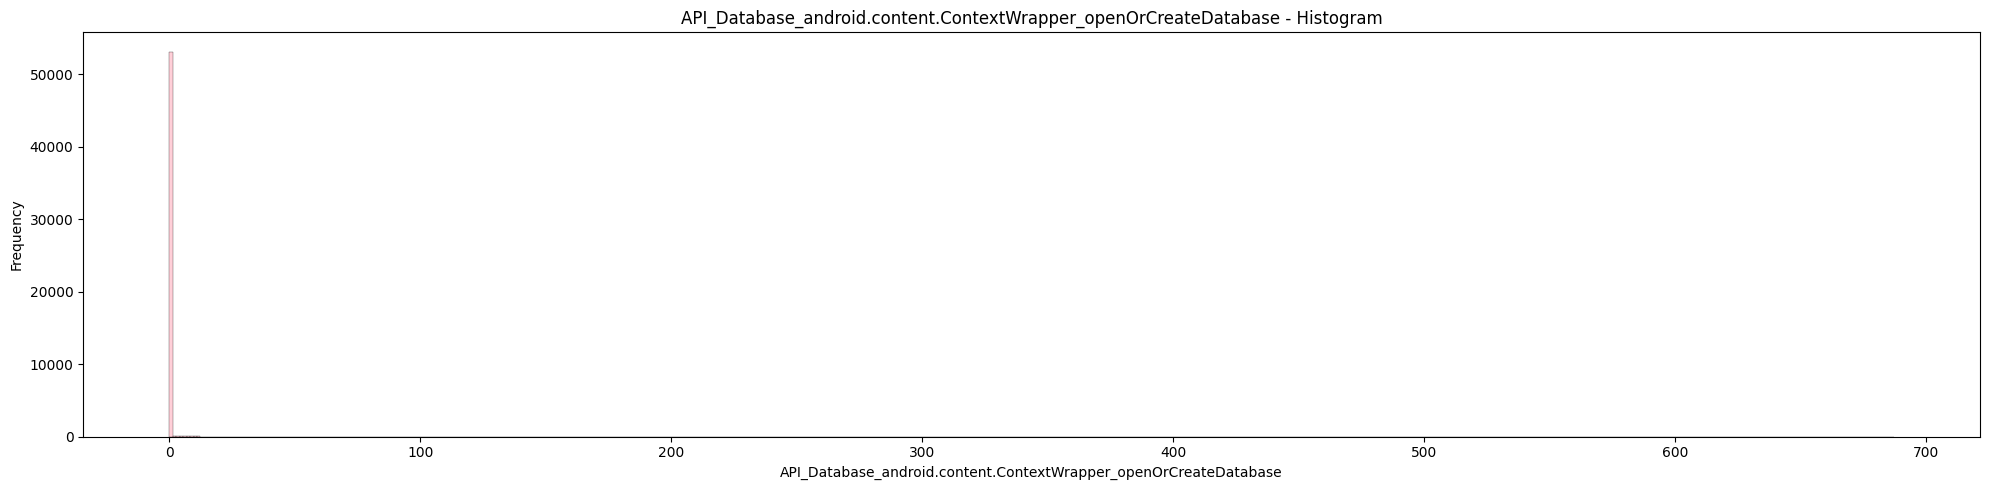

In [54]:
default_pipeline.EDA.plot_histograms(features=["API_Database_android.content.ContextWrapper_openOrCreateDatabase"], n_cols=1, bins=500)

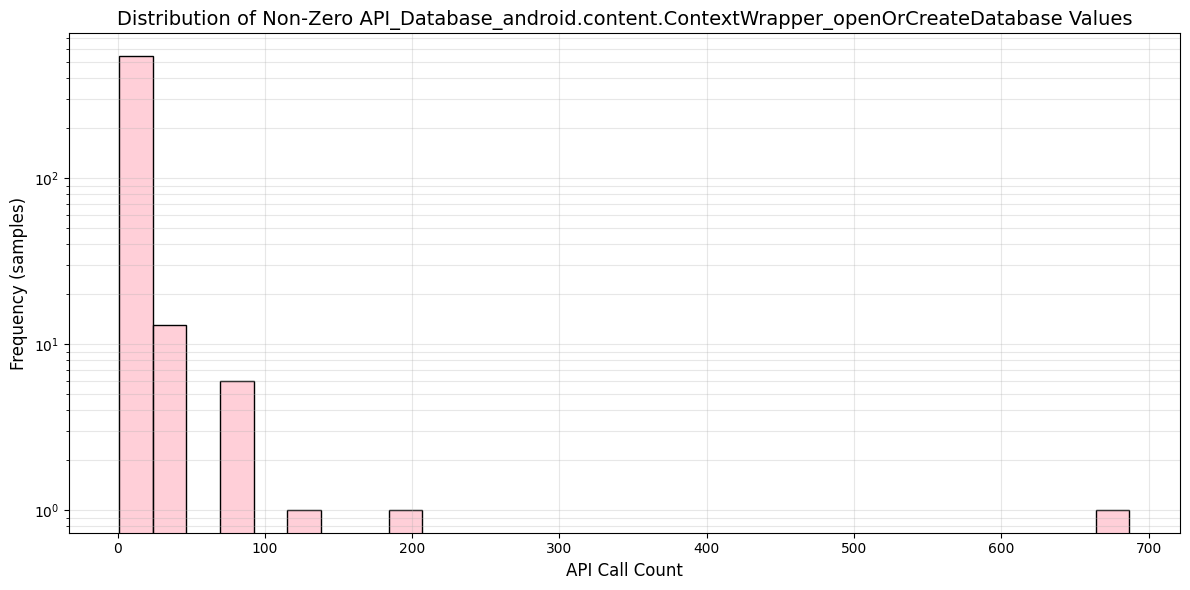

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Database_android.content.ContextWrapper_openOrCreateDatabase"] > 0]
sns.histplot(nonzero_samples["API_Database_android.content.ContextWrapper_openOrCreateDatabase"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Database_android.content.ContextWrapper_openOrCreateDatabase"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()

Most samples have low API call counts. There are a few outliers going up to almost 700.

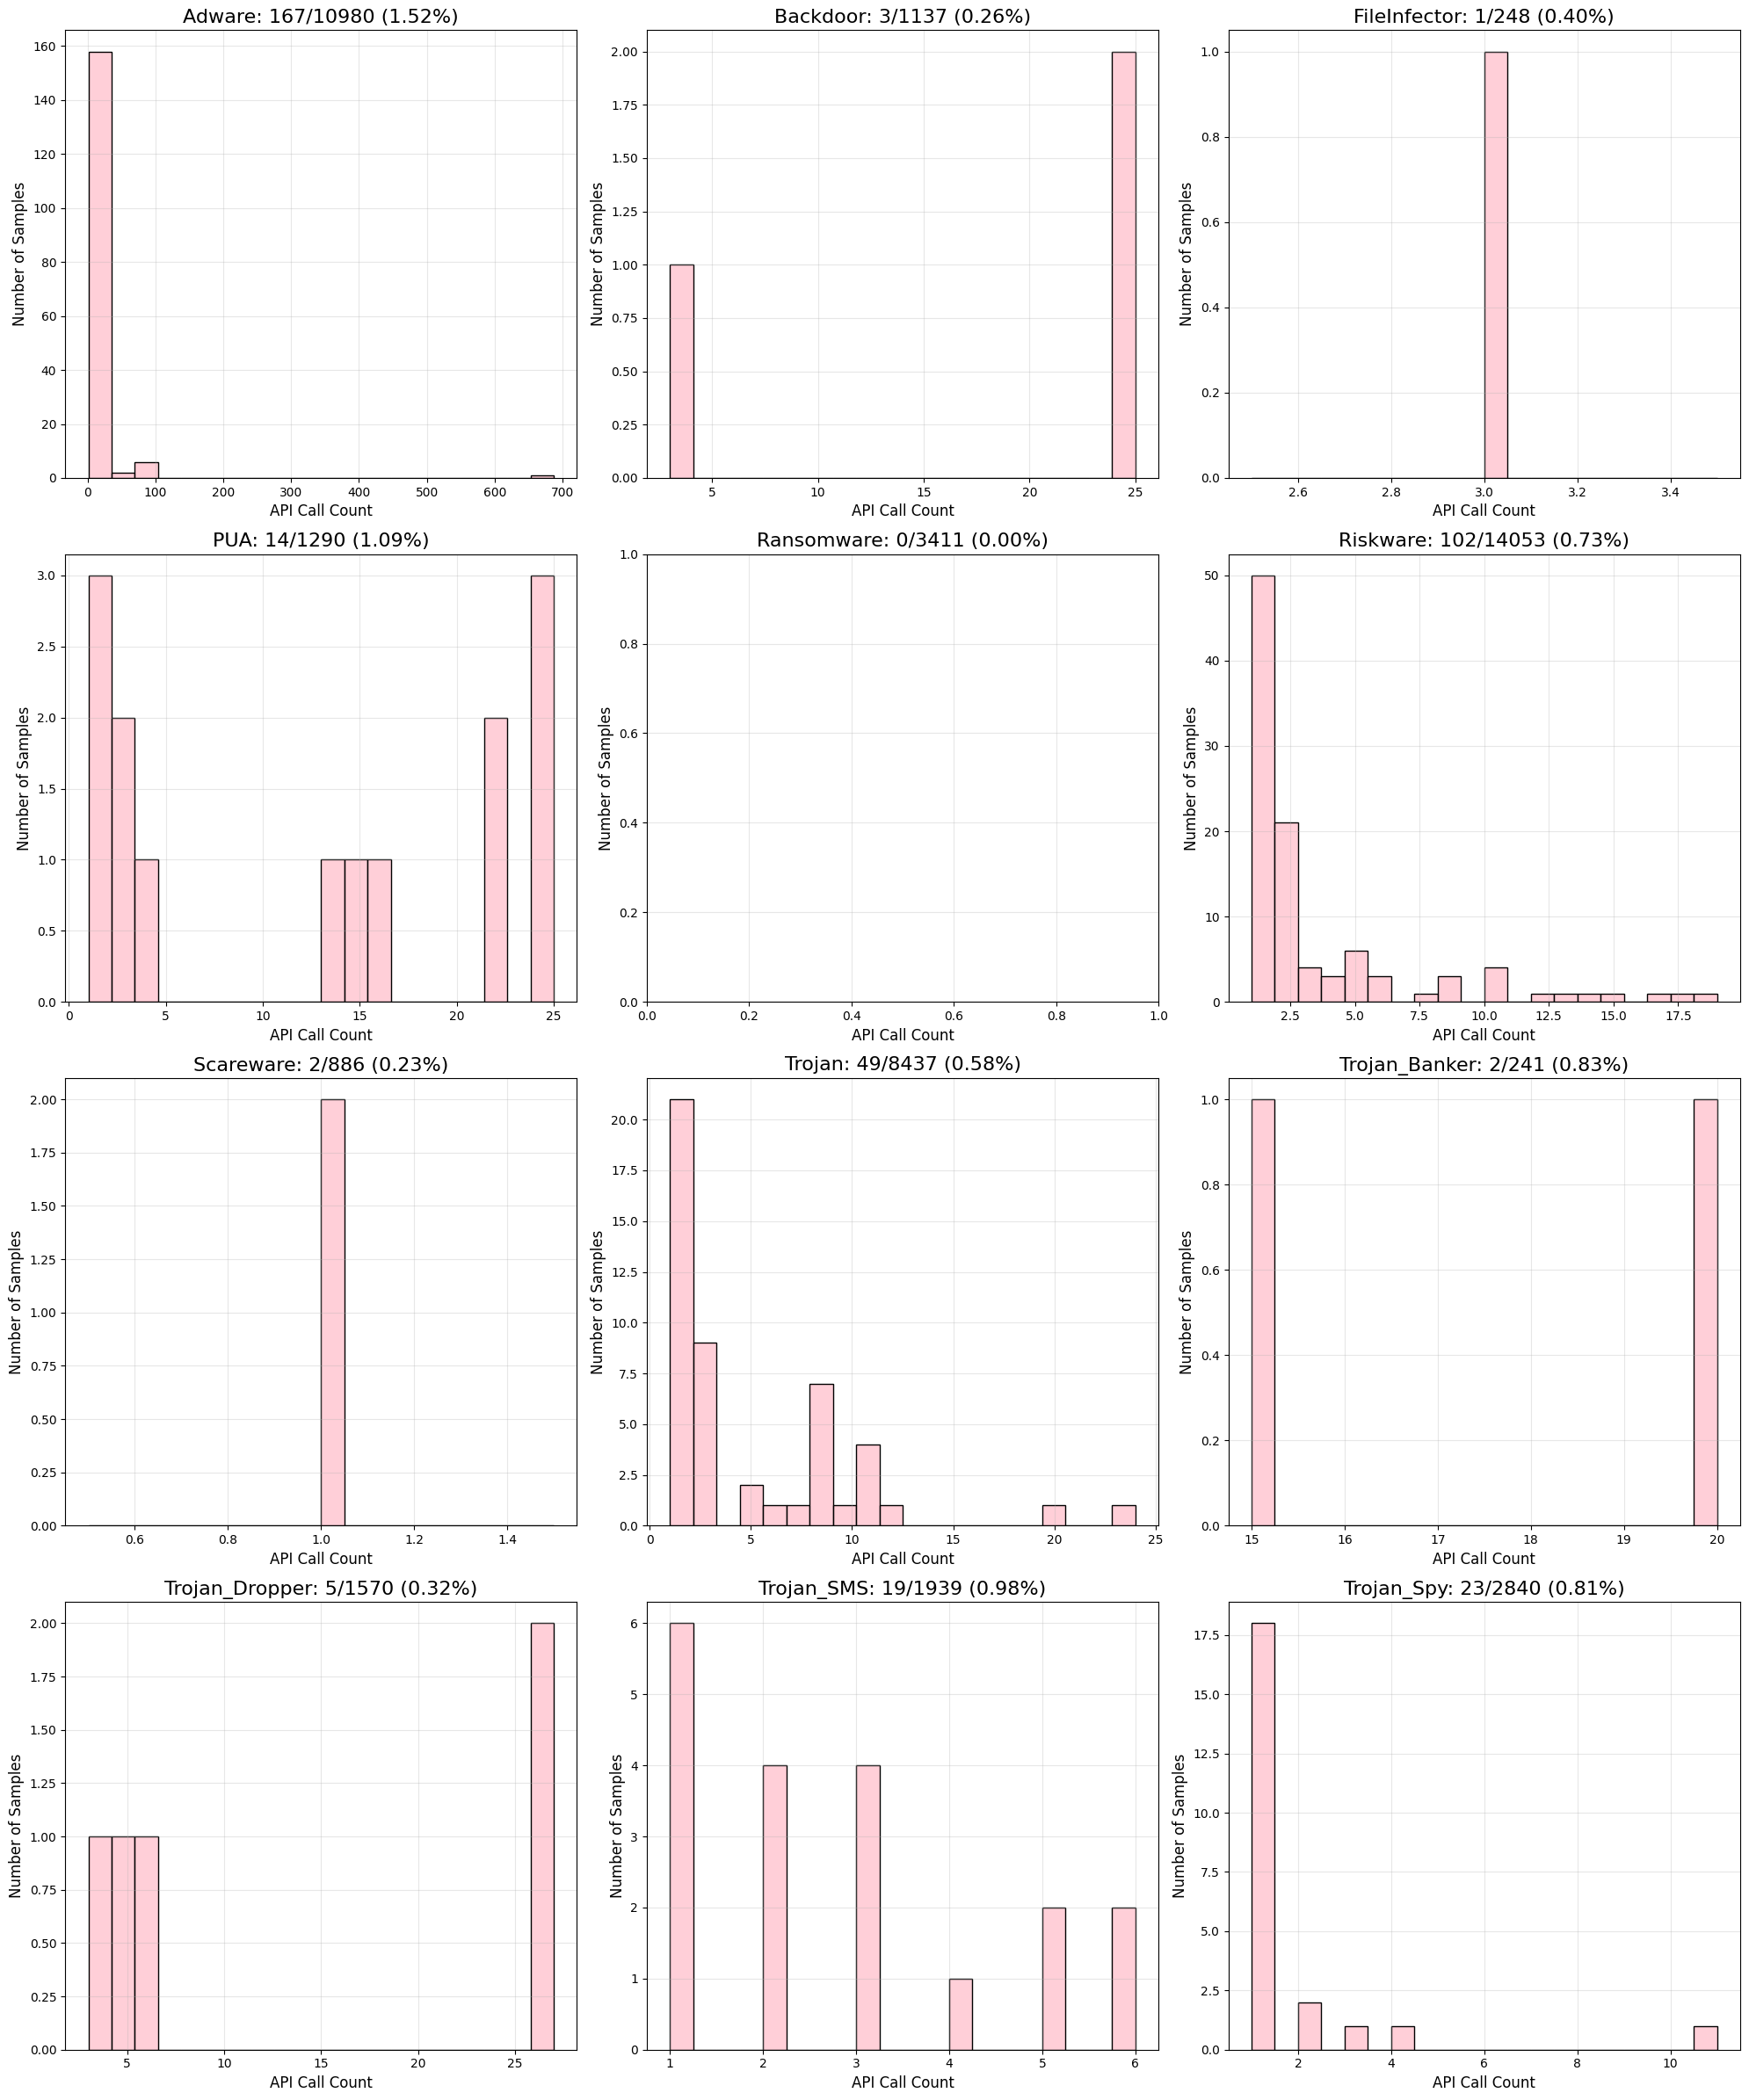

In [59]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]

api_feature = "API_Database_android.content.ContextWrapper_openOrCreateDatabase"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

This API is used very rarely across the dataset, with most malware categories showing non-zero usage in less than 1% of their samples. Adware stands out the most, with 167 out of 10,980 samples using it and in some cases, calling it over 600 times. 

Categories like PUA, Trojan_Spy, and Trojan_SMS also also have non-zero values appearing in small but consistent counts.

When it does appear, especially in high volumes, this API likely indicates an attempt to store data locally. 

Because it's so sparsely used overall and skewed toward specific behaviors, the feature is both sparse and imbalanced. To prevent overfitting when using it it is a good idea to create bins (marking whether it’s used or not), apply log-scaling or cap the extreme values, or only use it in tree-based models. 

    TO DO: 
group it with other features that suggest data persistence or local storage behavior.

Let's now analyse the effect of reboot.

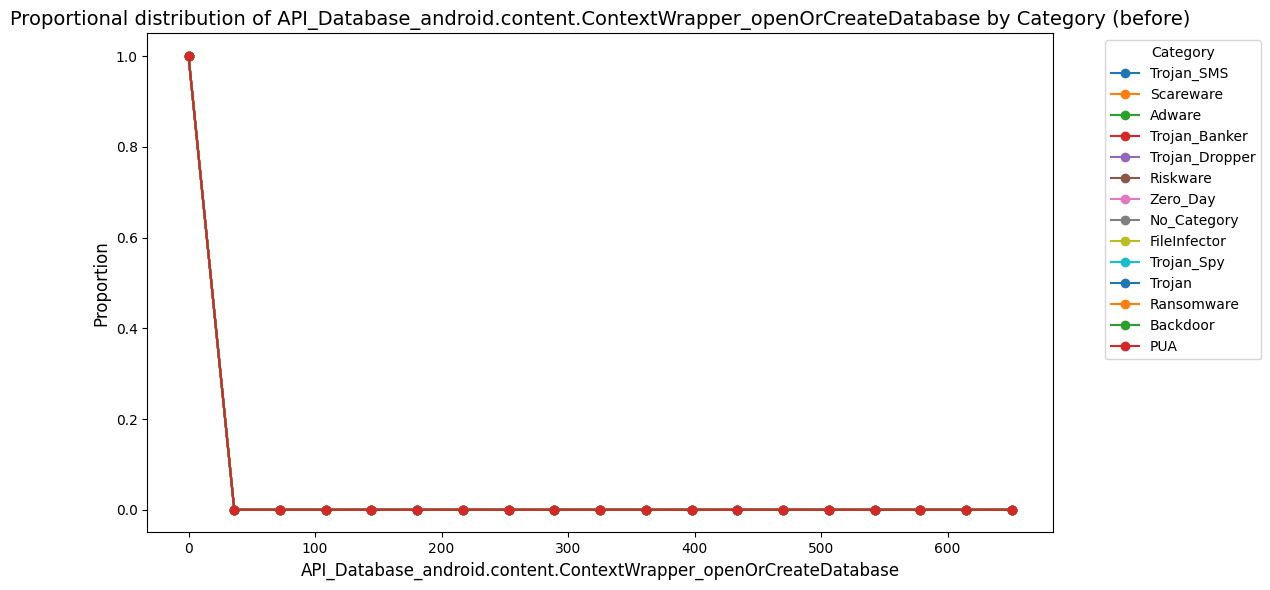

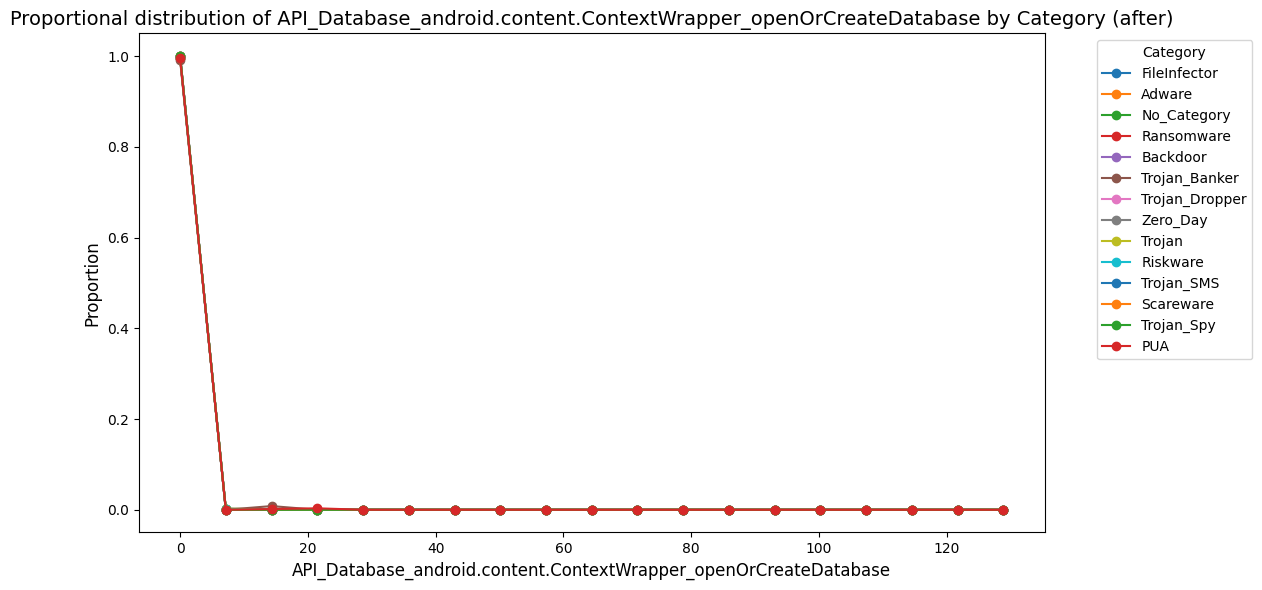

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_Database_android.content.ContextWrapper_openOrCreateDatabase",
    category_column="Category",
    by_reboot = True
)



Reboot has a small effect on Trojan_Banker which appears to make more calls after rebooting, but the effect appears negligible.

#### ContextWrapper_databaseList

In [49]:
df['API_Database_android.content.ContextWrapper_databaseList'].describe()

count    53439.000000
mean         0.008608
std          0.095370
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          6.000000
Name: API_Database_android.content.ContextWrapper_databaseList, dtype: float64

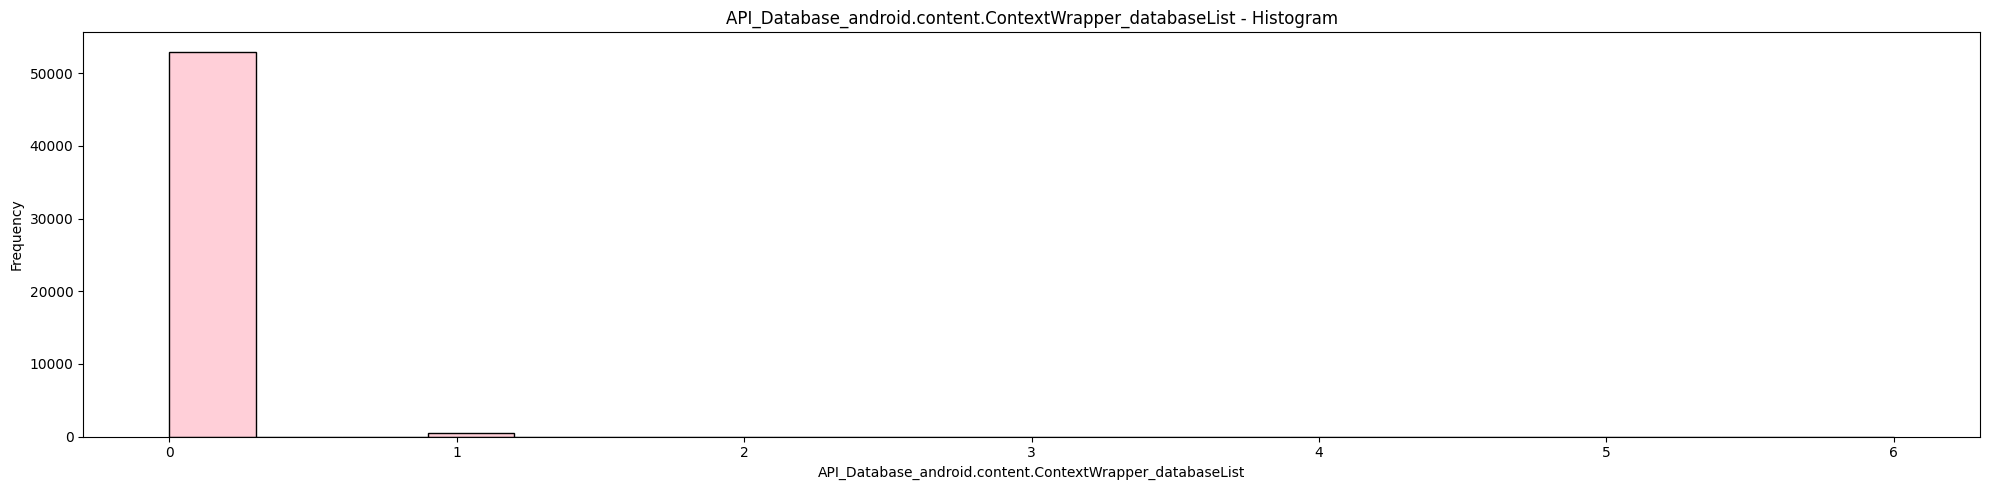

In [61]:
default_pipeline.EDA.plot_histograms(features=["API_Database_android.content.ContextWrapper_databaseList"], n_cols=1, bins=20)

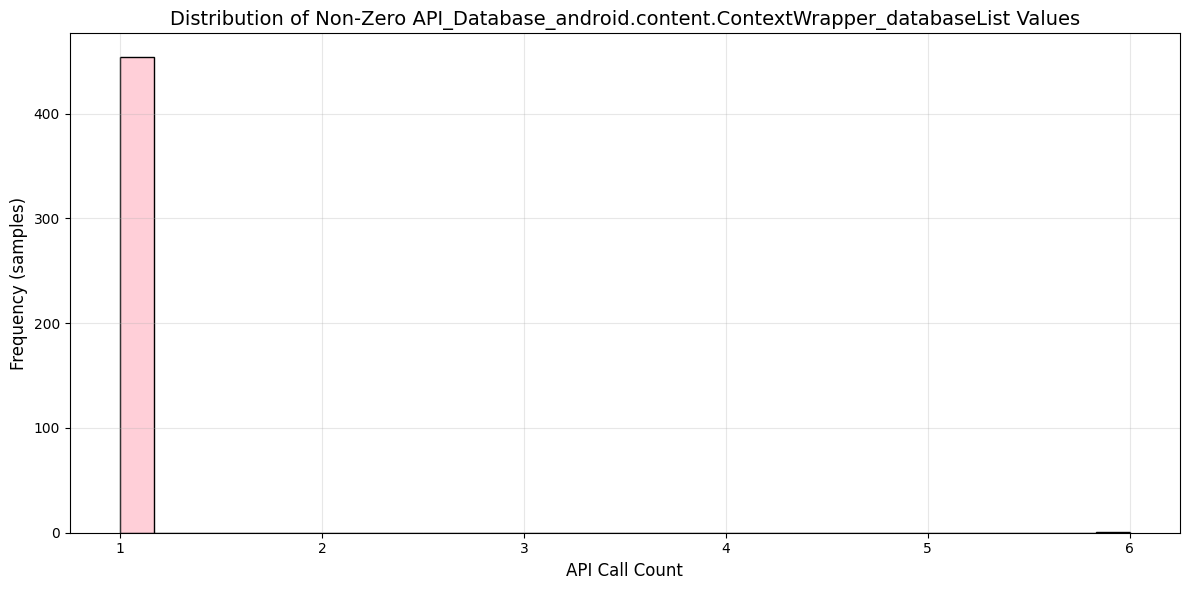

In [63]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Database_android.content.ContextWrapper_databaseList"] > 0]
sns.histplot(nonzero_samples["API_Database_android.content.ContextWrapper_databaseList"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Database_android.content.ContextWrapper_databaseList"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [67]:
(df['API_Database_android.content.ContextWrapper_databaseList'] == 6).sum()


1

If we take out the 0 values, this feature only takes either value 1 or 6. This indicates that the feature primarily captures whether the API is used (non-zero values) or not used (zero values), rather than providing meaningful granularity in the number of calls. The value 6 appears only one time so it will probably be only contributing noise. This is why, if kept, a binary representation is suggested.

In [64]:
df.groupby('Category')['API_Database_android.content.ContextWrapper_databaseList'].describe()

count      mean       std  min  25%  50%  75%  max
Category                                                            
Adware          10980.0  0.040984  0.205037  0.0  0.0  0.0  0.0  6.0
Backdoor         1137.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
FileInfector      248.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
No_Category      1932.0  0.001035  0.032166  0.0  0.0  0.0  0.0  1.0
PUA              1290.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Ransomware       3411.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Riskware        14053.0  0.000356  0.018860  0.0  0.0  0.0  0.0  1.0
Scareware         886.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Trojan           8437.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Trojan_Banker     241.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Trojan_Dropper   1570.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Trojan_SMS       1939.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Trojan_Spy       2840.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Zero_Day         4475.0  0.000670  0.025886  0.0  0.0  0.0  0.0  1.0

With such limited variance, this feature contributes very little discriminative power to most models, especially linear ones like logistic regression. Without strong regularization, it risks acting as noise and potentially skewing the model. Unless this API call can be shown to distinctly predict a specific class (like Adware), it’s more efficient to drop it or, at most, convert it into a binary indicator for access presence. 

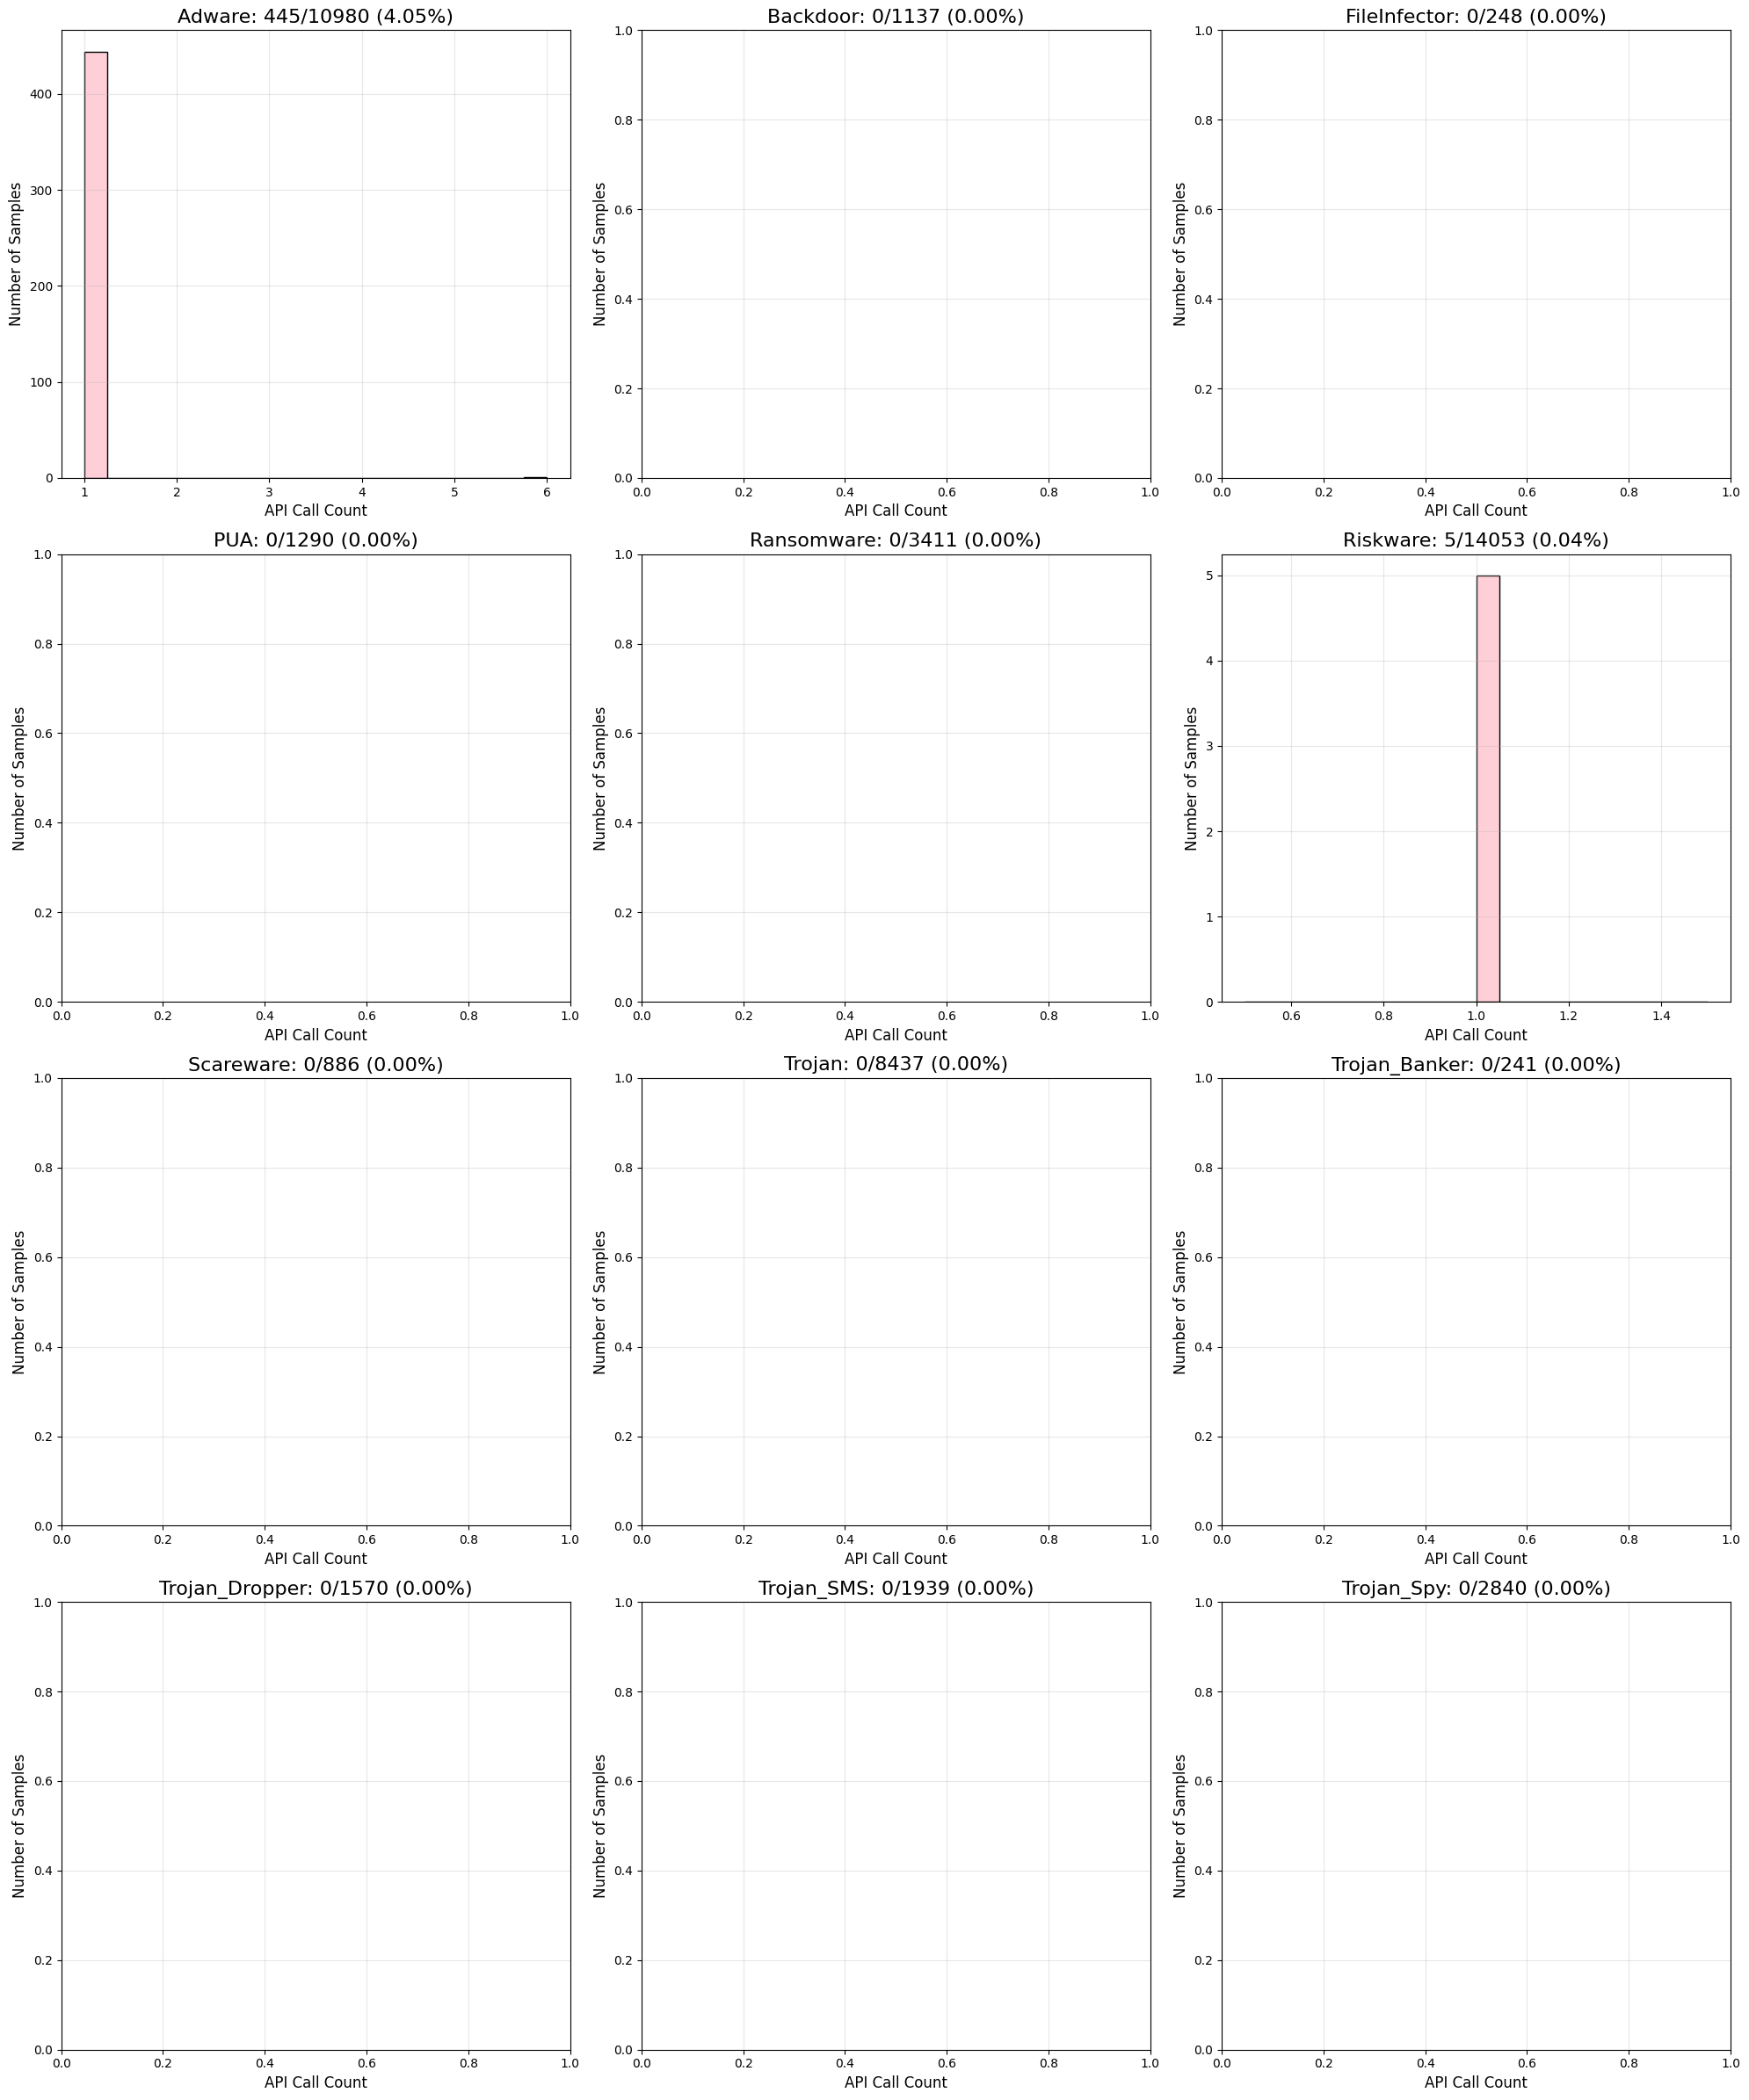

In [68]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]

api_feature = "API_Database_android.content.ContextWrapper_databaseList"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


The ones probably represent a specific Adware family.
While Adware and Riskware are among the most represented categories in the dataset, the fact that only 4.05% of Adware samples and an even smaller percentage of Riskware samples use the feature ContextWrapper_databaseList indicates that even with a lot of data, this feature is rarely invoked. Its concentrated presence in mostly Adware, increases the risk of overfitting rather than generalizable learning. 

This feature should be considered for removal. 

#### ContextWrapper_deleteDatabase and SQLiteDatabase_deleteDatabase

In [22]:
df['API_Database_android.content.ContextWrapper_deleteDatabase'].describe()

count    53439.000000
mean         0.003630
std          0.228384
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         26.000000
Name: API_Database_android.content.ContextWrapper_deleteDatabase, dtype: float64

In [23]:
df['API_Database_android.database.sqlite.SQLiteDatabase_deleteDatabase'].describe()

count    53439.000000
mean         0.003630
std          0.228384
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         26.000000
Name: API_Database_android.database.sqlite.SQLiteDatabase_deleteDatabase, dtype: float64

Basic statistics show the same value so we are going to proceed by checking whether these columns contain the same values.

In [ ]:
(df['API_Database_android.content.ContextWrapper_deleteDatabase'] == df['API_Database_android.database.sqlite.SQLiteDatabase_deleteDatabase']).all()

Given that these columns contain the same values for al records. So we delete one of them. 

In [24]:
df.drop('API_Database_android.database.sqlite.SQLiteDatabase_deleteDatabase', axis=1, inplace=True)

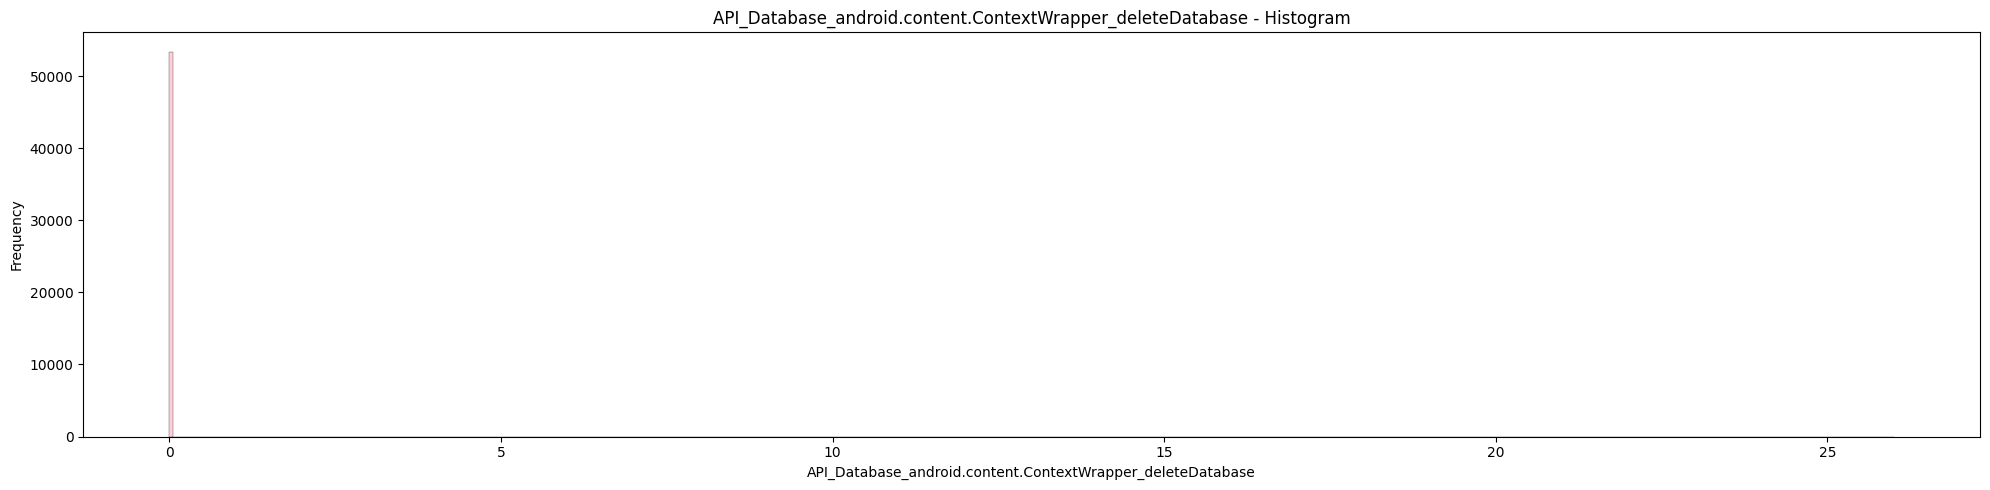

In [26]:
default_pipeline.EDA.plot_histograms(features=["API_Database_android.content.ContextWrapper_deleteDatabase"], n_cols=1, bins=500)

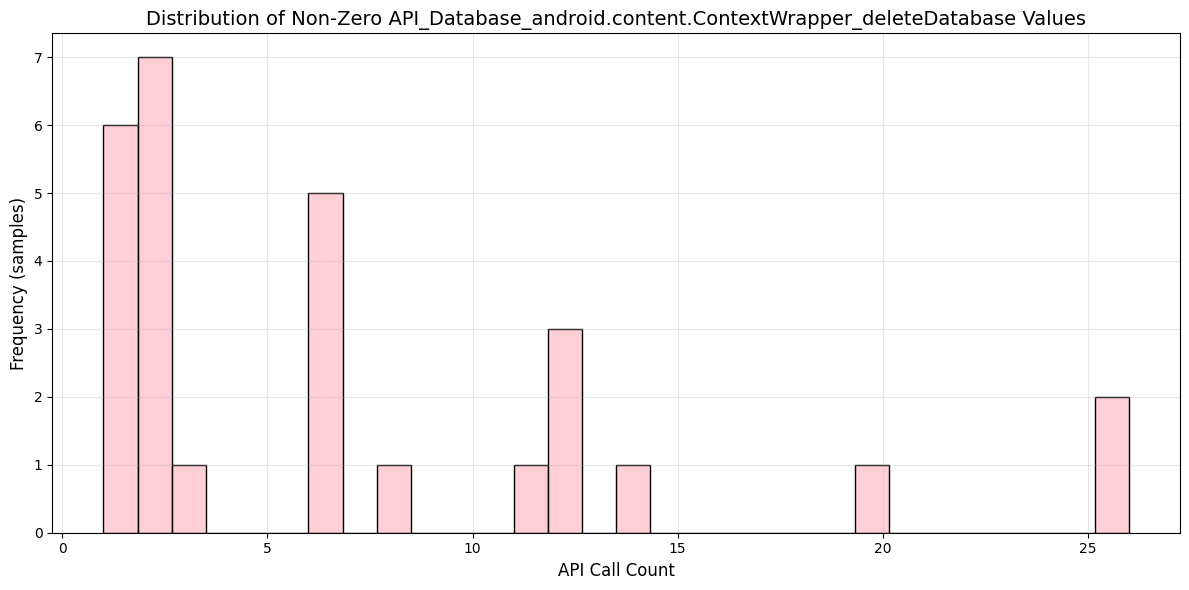

In [28]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Database_android.content.ContextWrapper_deleteDatabase"] > 0]
sns.histplot(nonzero_samples["API_Database_android.content.ContextWrapper_deleteDatabase"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Database_android.content.ContextWrapper_deleteDatabase"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
(df['API_Database_android.content.ContextWrapper_deleteDatabase'] != 0).sum()

28

In [32]:
# Filter rows where the feature is non-zero
nonzero_df = df[df['API_Database_android.content.ContextWrapper_deleteDatabase'] != 0]

# Count how many of those belong to each category
category_counts = nonzero_df['Category'].value_counts()

print(category_counts)


Category
Adware            8
No_Category       6
Riskware          6
Zero_Day          4
Trojan_Dropper    3
Trojan            1
Name: count, dtype: int64


In [35]:
# List of categories you're interested in
target_categories = ['Adware', 'Riskware', 'Trojan_Dropper', 'Trojan']

# Count samples for each of these categories
df[df['Category'].isin(target_categories)]['Category'].value_counts()


Category
Riskware          14053
Adware            10980
Trojan             8437
Trojan_Dropper     1570
Name: count, dtype: int64

The data for this feature is clearly right skewed, with most samples showing very low API call counts and only a small number of outliers reaching up to around 25 calls. In fact, only 18 samples have non zero values, making the feature extremely sparse. These correspond to Riskware, Adware, Trojan and Trojan_Dropper. The thing is, this classes are also highly imbalanced. All of this creates a serious risk of overfitting. One way to mitigate this is to simplify the feature by binarizing. Or, since tree-based models like Random Forest or Gradient Boosting handle sparse features more robustly, we might choose to use this feature only with these models and exclude it from others to prevent overfitting.



#### SQLiteDatabase_execSQL

In [48]:
df['API_Database_android.database.sqlite.SQLiteDatabase_execSQL'].describe()

count    53439.000000
mean         3.183911
std         49.957457
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       4406.000000
Name: API_Database_android.database.sqlite.SQLiteDatabase_execSQL, dtype: float64

This feature has no predictive power so it will be dropped.

#### SQLiteDatabase_getPath

In [47]:
df['API_Database_android.database.sqlite.SQLiteDatabase_getPath'].describe()

count    53439.000000
mean        28.252849
std         85.137537
min          0.000000
25%          0.000000
50%          0.000000
75%         17.000000
max       4415.000000
Name: API_Database_android.database.sqlite.SQLiteDatabase_getPath, dtype: float64

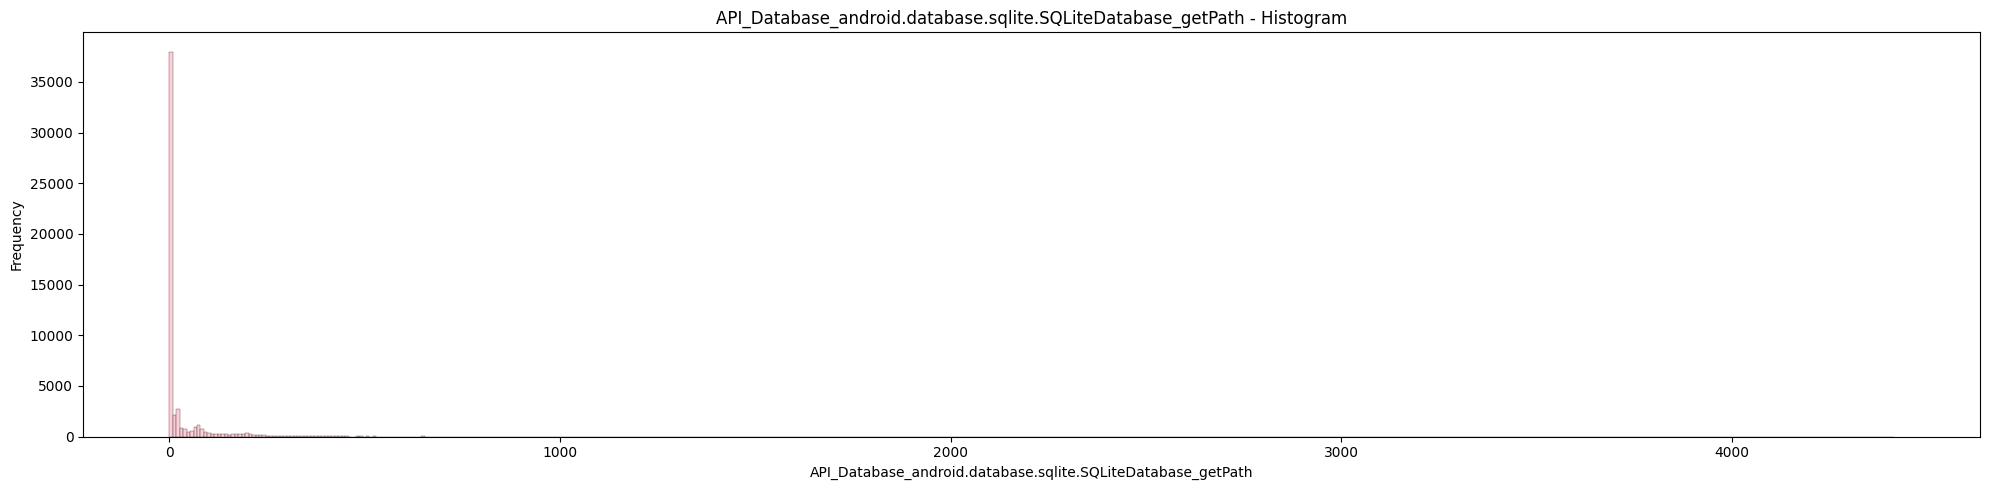

In [79]:
default_pipeline.EDA.plot_histograms(features=["API_Database_android.database.sqlite.SQLiteDatabase_getPath"], n_cols=1, bins=500)

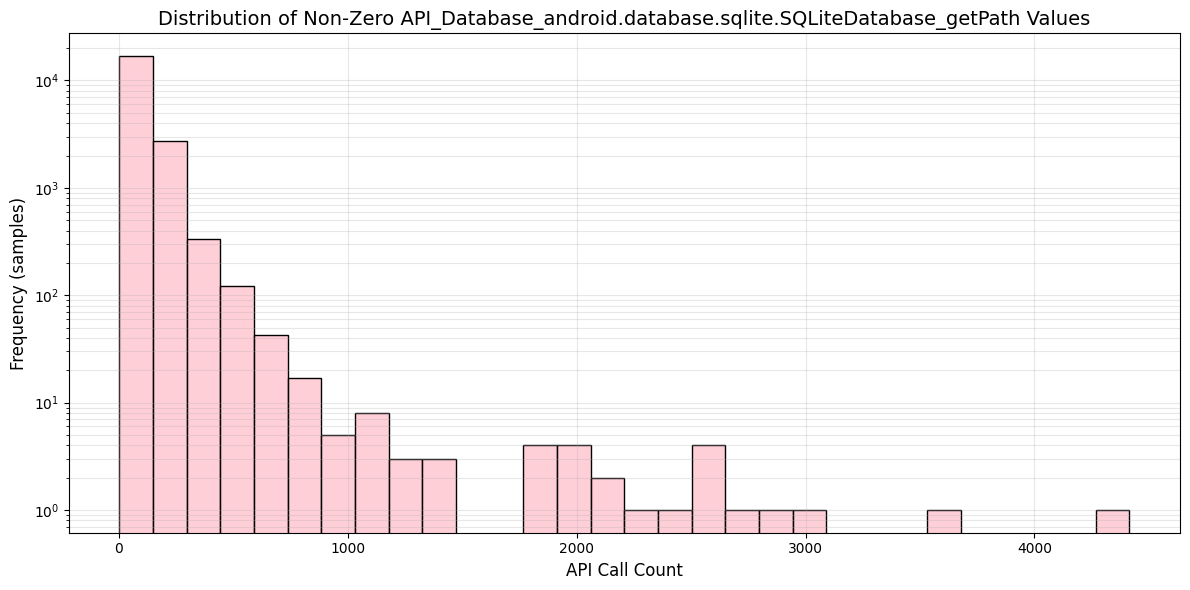

In [81]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Database_android.database.sqlite.SQLiteDatabase_getPath"] > 0]
sns.histplot(nonzero_samples["API_Database_android.database.sqlite.SQLiteDatabase_getPath"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Database_android.database.sqlite.SQLiteDatabase_getPath"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()

Most samples invoke this API only a few times, but there is a long tail of outliers with counts exceeding 4000. So, there might be specific variants or malwares that use it excessively.

To to the skewness, log transformation would be valuable.

In [131]:
df.groupby('Category')['API_Database_android.database.sqlite.SQLiteDatabase_getPath'].describe()

count       mean         std  min  25%  50%   75%     max
Category                                                                   
Adware          10980.0  24.309563   62.535664  0.0  0.0  0.0  17.0  2495.0
Backdoor         1137.0  15.751979   47.810642  0.0  0.0  0.0  24.0   545.0
FileInfector      248.0   2.802419   16.395827  0.0  0.0  0.0   0.0   226.0
No_Category      1932.0  16.581781  108.558318  0.0  0.0  0.0   1.0  3649.0
PUA              1290.0  27.926357  126.163175  0.0  0.0  0.0   0.0  1467.0
Ransomware       3411.0  13.007329  176.513340  0.0  0.0  0.0   0.0  4415.0
Riskware        14053.0  50.121398   93.117086  0.0  0.0  2.0  28.0  1041.0
Scareware         886.0   0.892777   11.161517  0.0  0.0  0.0   0.0   260.0
Trojan           8437.0  26.488444   53.299804  0.0  0.0  0.0  55.0  2508.0
Trojan_Banker     241.0   8.697095   28.440939  0.0  0.0  0.0   0.0   256.0
Trojan_Dropper   1570.0  15.162420   49.225432  0.0  0.0  0.0   0.0   865.0
Trojan_SMS       1939.0   3.226405   17.882537  0.0  0.0  0.0   0.0   329.0
Trojan_Spy       2840.0   9.957746   27.737669  0.0  0.0  0.0   6.0   464.0
Zero_Day         4475.0  27.437765   79.109660  0.0  0.0  0.0  16.0  1432.0

Riskware stands out because it is the only one with a non-zero median and it has the highest mean. It also has the second highest 75th percentile.

Trojan also shows activity with has a very high 75th percentile, highlighting a lots of big values in a range up to 2508.

Meanwhile, Ransomware and categories like Trojan_Dropper, despite moderate means, exhibit extremely high max values (up to 4415 calls), revealing rare but highly abnormal behaviors.

On the other hand, FileInfector and Scareware have minimal interaction with this API, with near-zero means and low maximum values, implying this feature holds little relevance for them.

These insights suggest this API is a valuable feature for differentiating between high-activity and low-activity malware types.


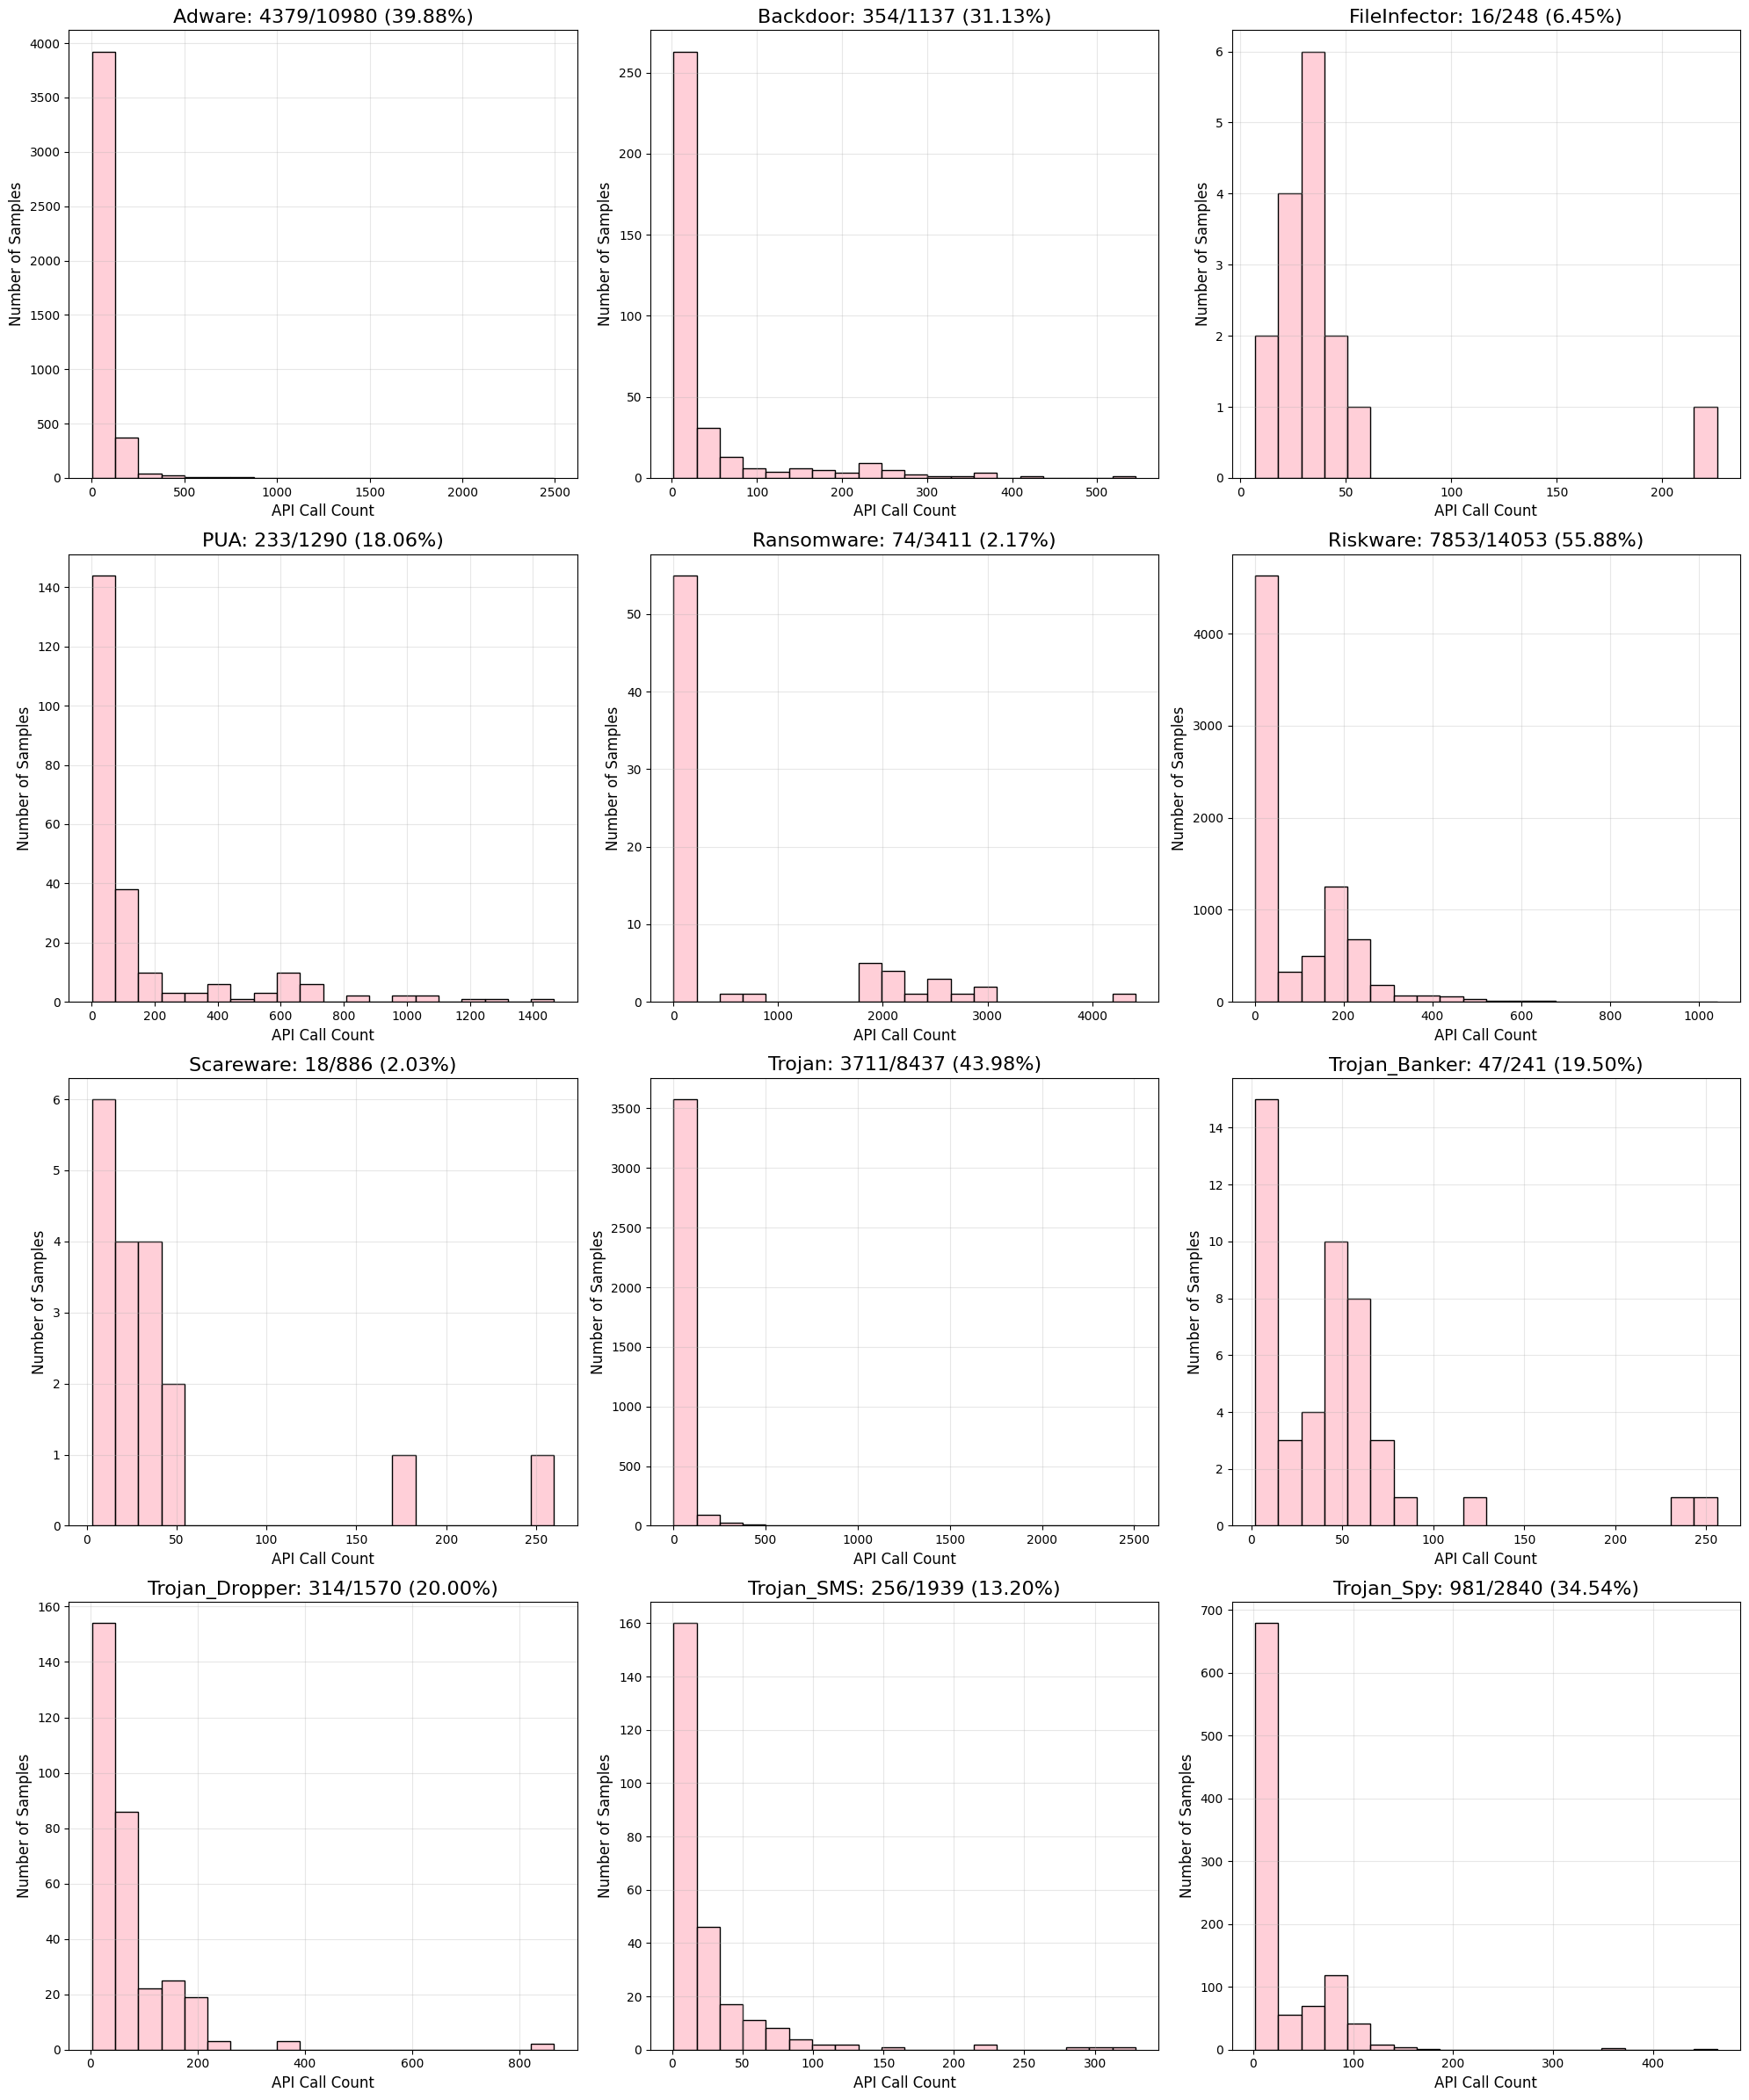

In [132]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]

api_feature = "API_Database_android.database.sqlite.SQLiteDatabase_getPath"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

This API is widely used across multiple malware categories, with notable variation in frequency and intensity.

Riskware, Trojan, Adware, Trojan_Spy and Backdoor show a high proportion of usage (around 55% to 30%).

Trojan_Dropper, Trojan_Banker, PUA and Trojan_SMS show a moderate usage (around 20% to 13%)

FileInfector, Ransomware and Scareware show a low usage (arounf 7% to 2%)

The number of calls done by malwares also varies. Categories like Ransomware or PUA have pretty high calls by sample while Trojan_SMS or Trojan_SPY show a lower number of calls.


This makes the feature potentially discriminative. 

For preprocessing, it would be advisable to consider log transformation or binning to handle this skewness.

We will analyse the effect of reboot on different categories

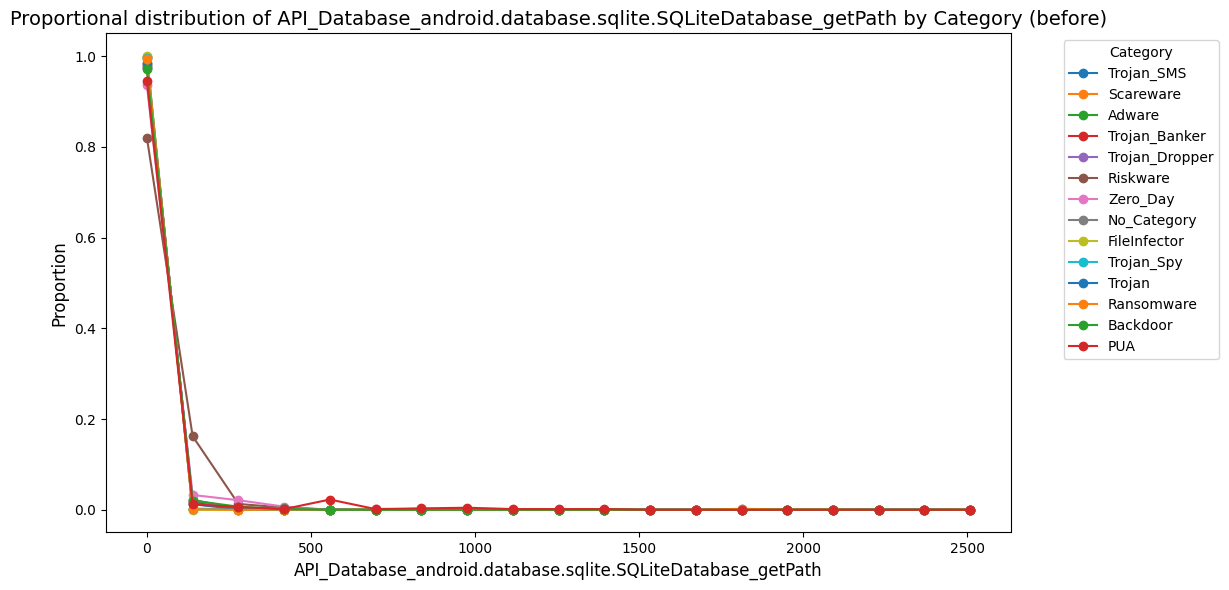

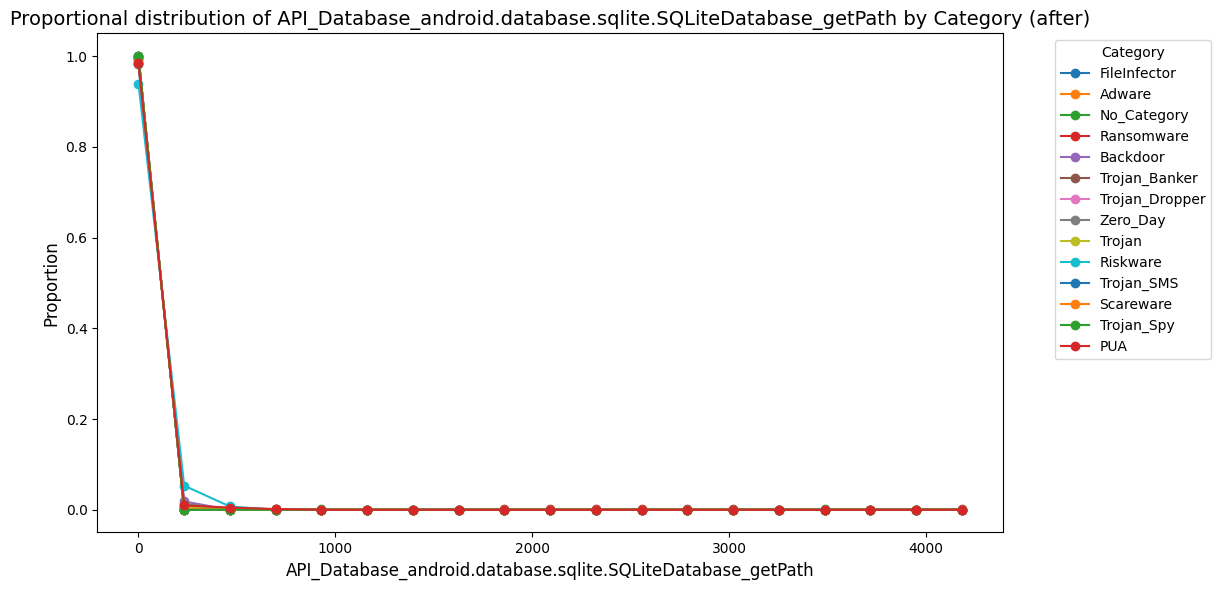

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_Database_android.database.sqlite.SQLiteDatabase_getPath",
    category_column="Category",
    by_reboot = True
)

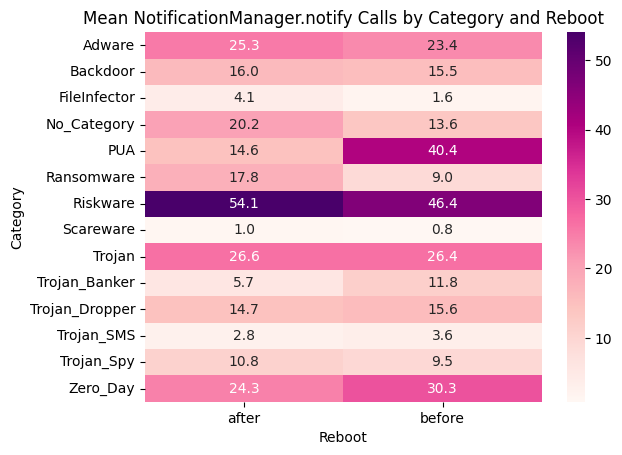

In [135]:
df = default_pipeline.dataset.df.copy()
df['notify_bin'] = pd.cut(df['API_Database_android.database.sqlite.SQLiteDatabase_getPath'], bins=5)

pivot = df.pivot_table(index='Category', columns='Reboot', values='API_Database_android.database.sqlite.SQLiteDatabase_getPath', aggfunc='mean')
sns.heatmap(pivot, annot=True, fmt=".1f", cmap='RdPu')
plt.title('Mean NotificationManager.notify Calls by Category and Reboot')
plt.show()

PUA shows the most significant change in before and after reboot. Showing a much less active API calling after the reboot, maybe as an evasion strategy. On the other hand, Riskware appears to activate with rebooting. This can be clearly seen by both plots

#### SQLiteDatabase_insert and SQLiteDatabase_insertWithOnConflict 

In [46]:
df['API_Database_android.database.sqlite.SQLiteDatabase_insert'].describe()

count    53439.000000
mean         2.054193
std         35.397792
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4818.000000
Name: API_Database_android.database.sqlite.SQLiteDatabase_insert, dtype: float64

In [139]:
df['API_Database_android.database.sqlite.SQLiteDatabase_insertWithOnConflict'].describe()

count    53439.000000
mean         3.161942
std         65.796059
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       7374.000000
Name: API_Database_android.database.sqlite.SQLiteDatabase_insertWithOnConflict, dtype: float64

Both show more than 75% of the 53,439 samples with zero usage. However, when these APIs are used, insertWithOnConflict stands out with a higher average call count (3.16 vs. 2.05), a much larger maximum value (7374 vs. 4818), and nearly double the standard deviation, indicating greater variability in its usage. This suggests that while both APIs serve similar roles in database operations, insertWithOnConflict is used more.  


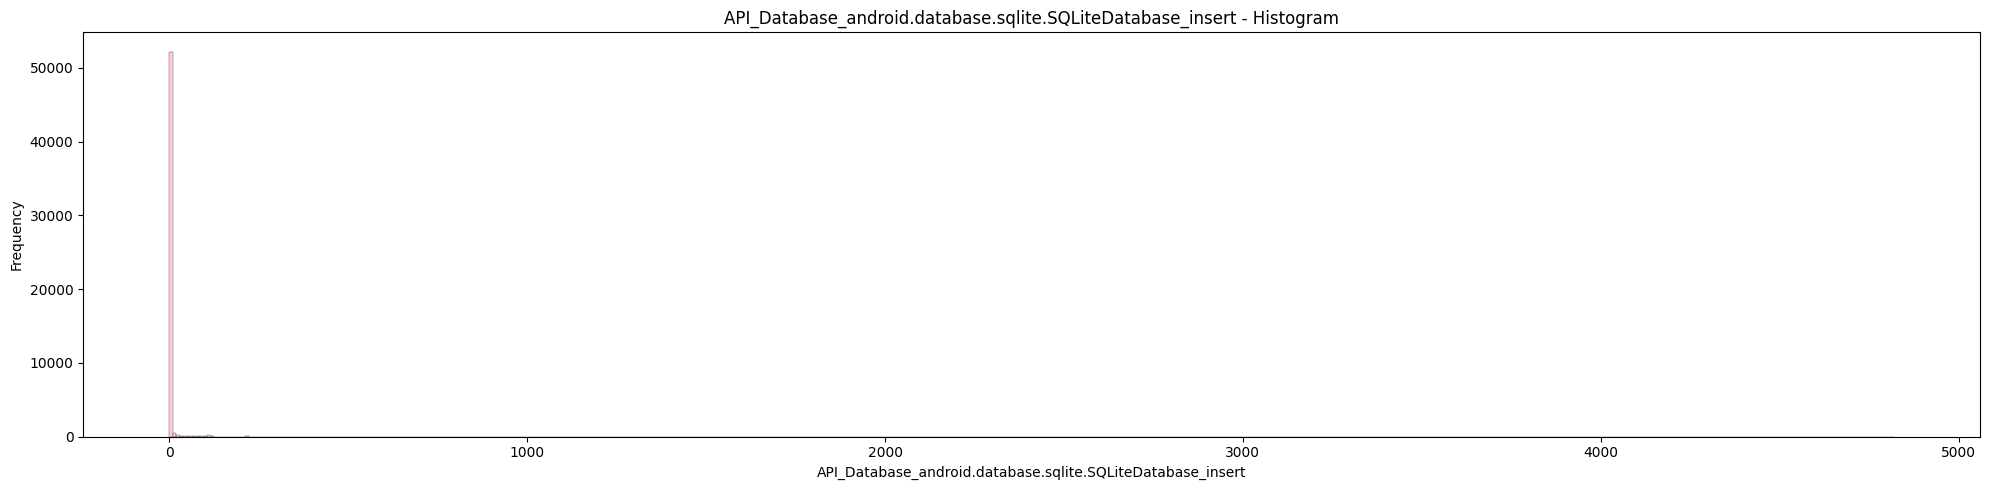

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_Database_android.database.sqlite.SQLiteDatabase_insert"], n_cols=1, bins=500)

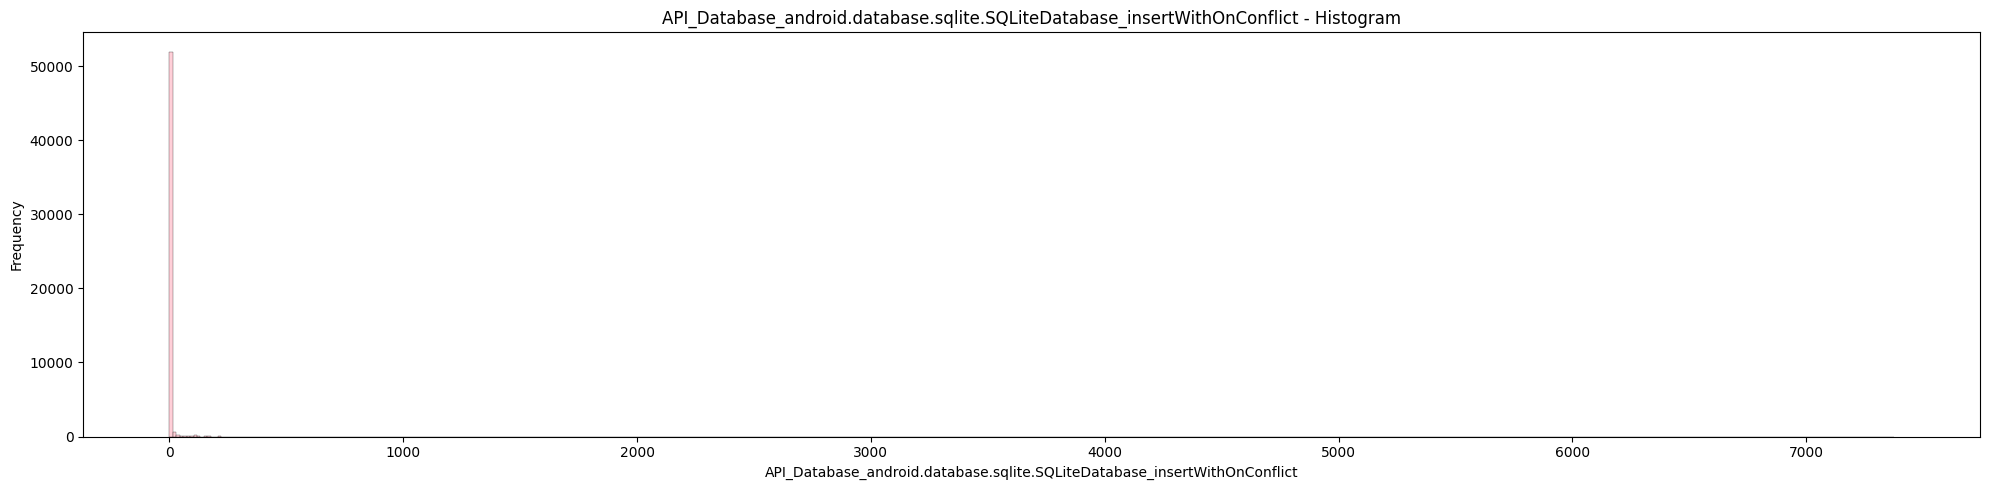

In [140]:
default_pipeline.EDA.plot_histograms(features=["API_Database_android.database.sqlite.SQLiteDatabase_insertWithOnConflict"], n_cols=1, bins=500)

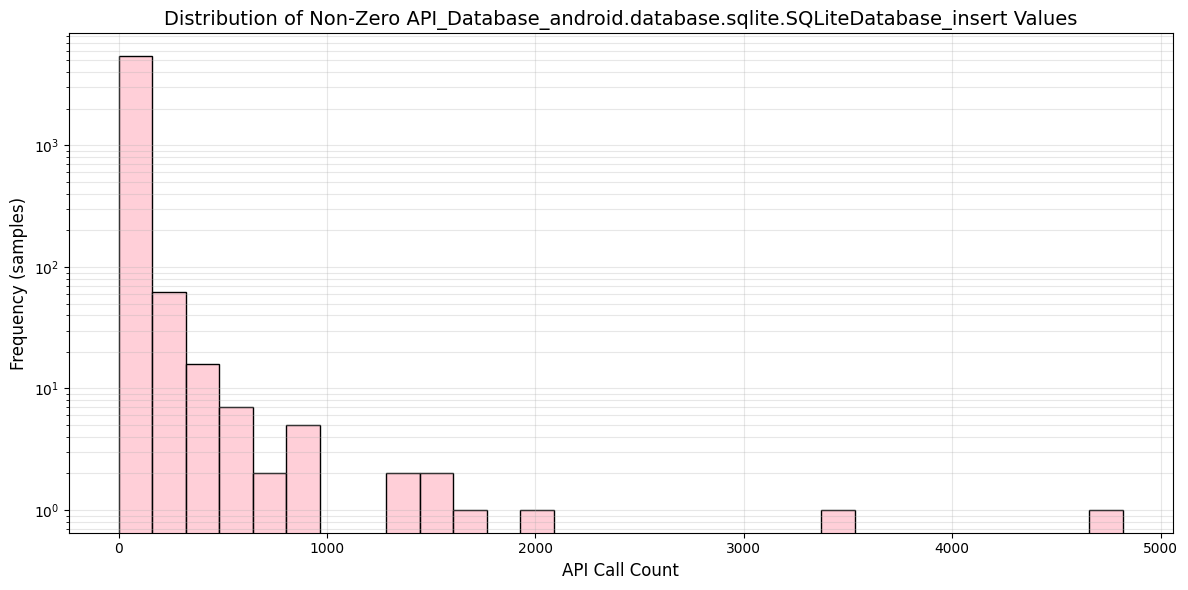

In [84]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Database_android.database.sqlite.SQLiteDatabase_insert"] > 0]
sns.histplot(nonzero_samples["API_Database_android.database.sqlite.SQLiteDatabase_insert"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Database_android.database.sqlite.SQLiteDatabase_insert"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()

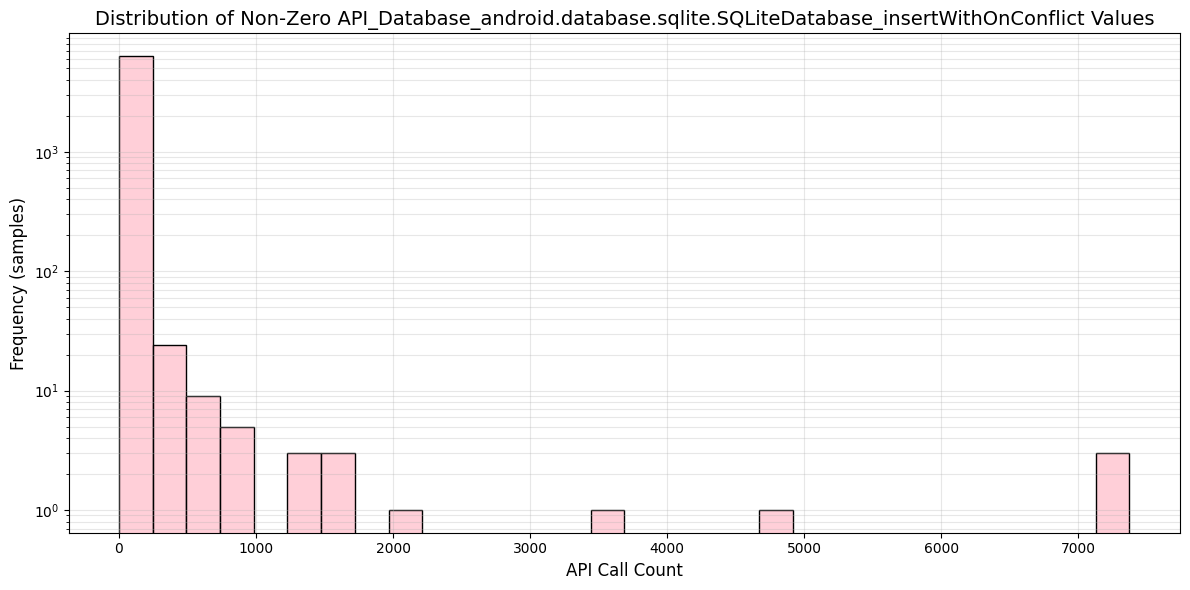

In [141]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Database_android.database.sqlite.SQLiteDatabase_insertWithOnConflict"] > 0]
sns.histplot(nonzero_samples["API_Database_android.database.sqlite.SQLiteDatabase_insertWithOnConflict"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Database_android.database.sqlite.SQLiteDatabase_insertWithOnConflict"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()

Both distributions are heavily right-skewed. insertWithOnConflict not only reaches a higher maximum but also shows a slightly longer tail with more high-frequency outliers. This suggests that when malware chooses to use  insertWithOnConflict, it makes more calls. Overall, both features look pretty similar so let's compare how this features behave specifically by category.

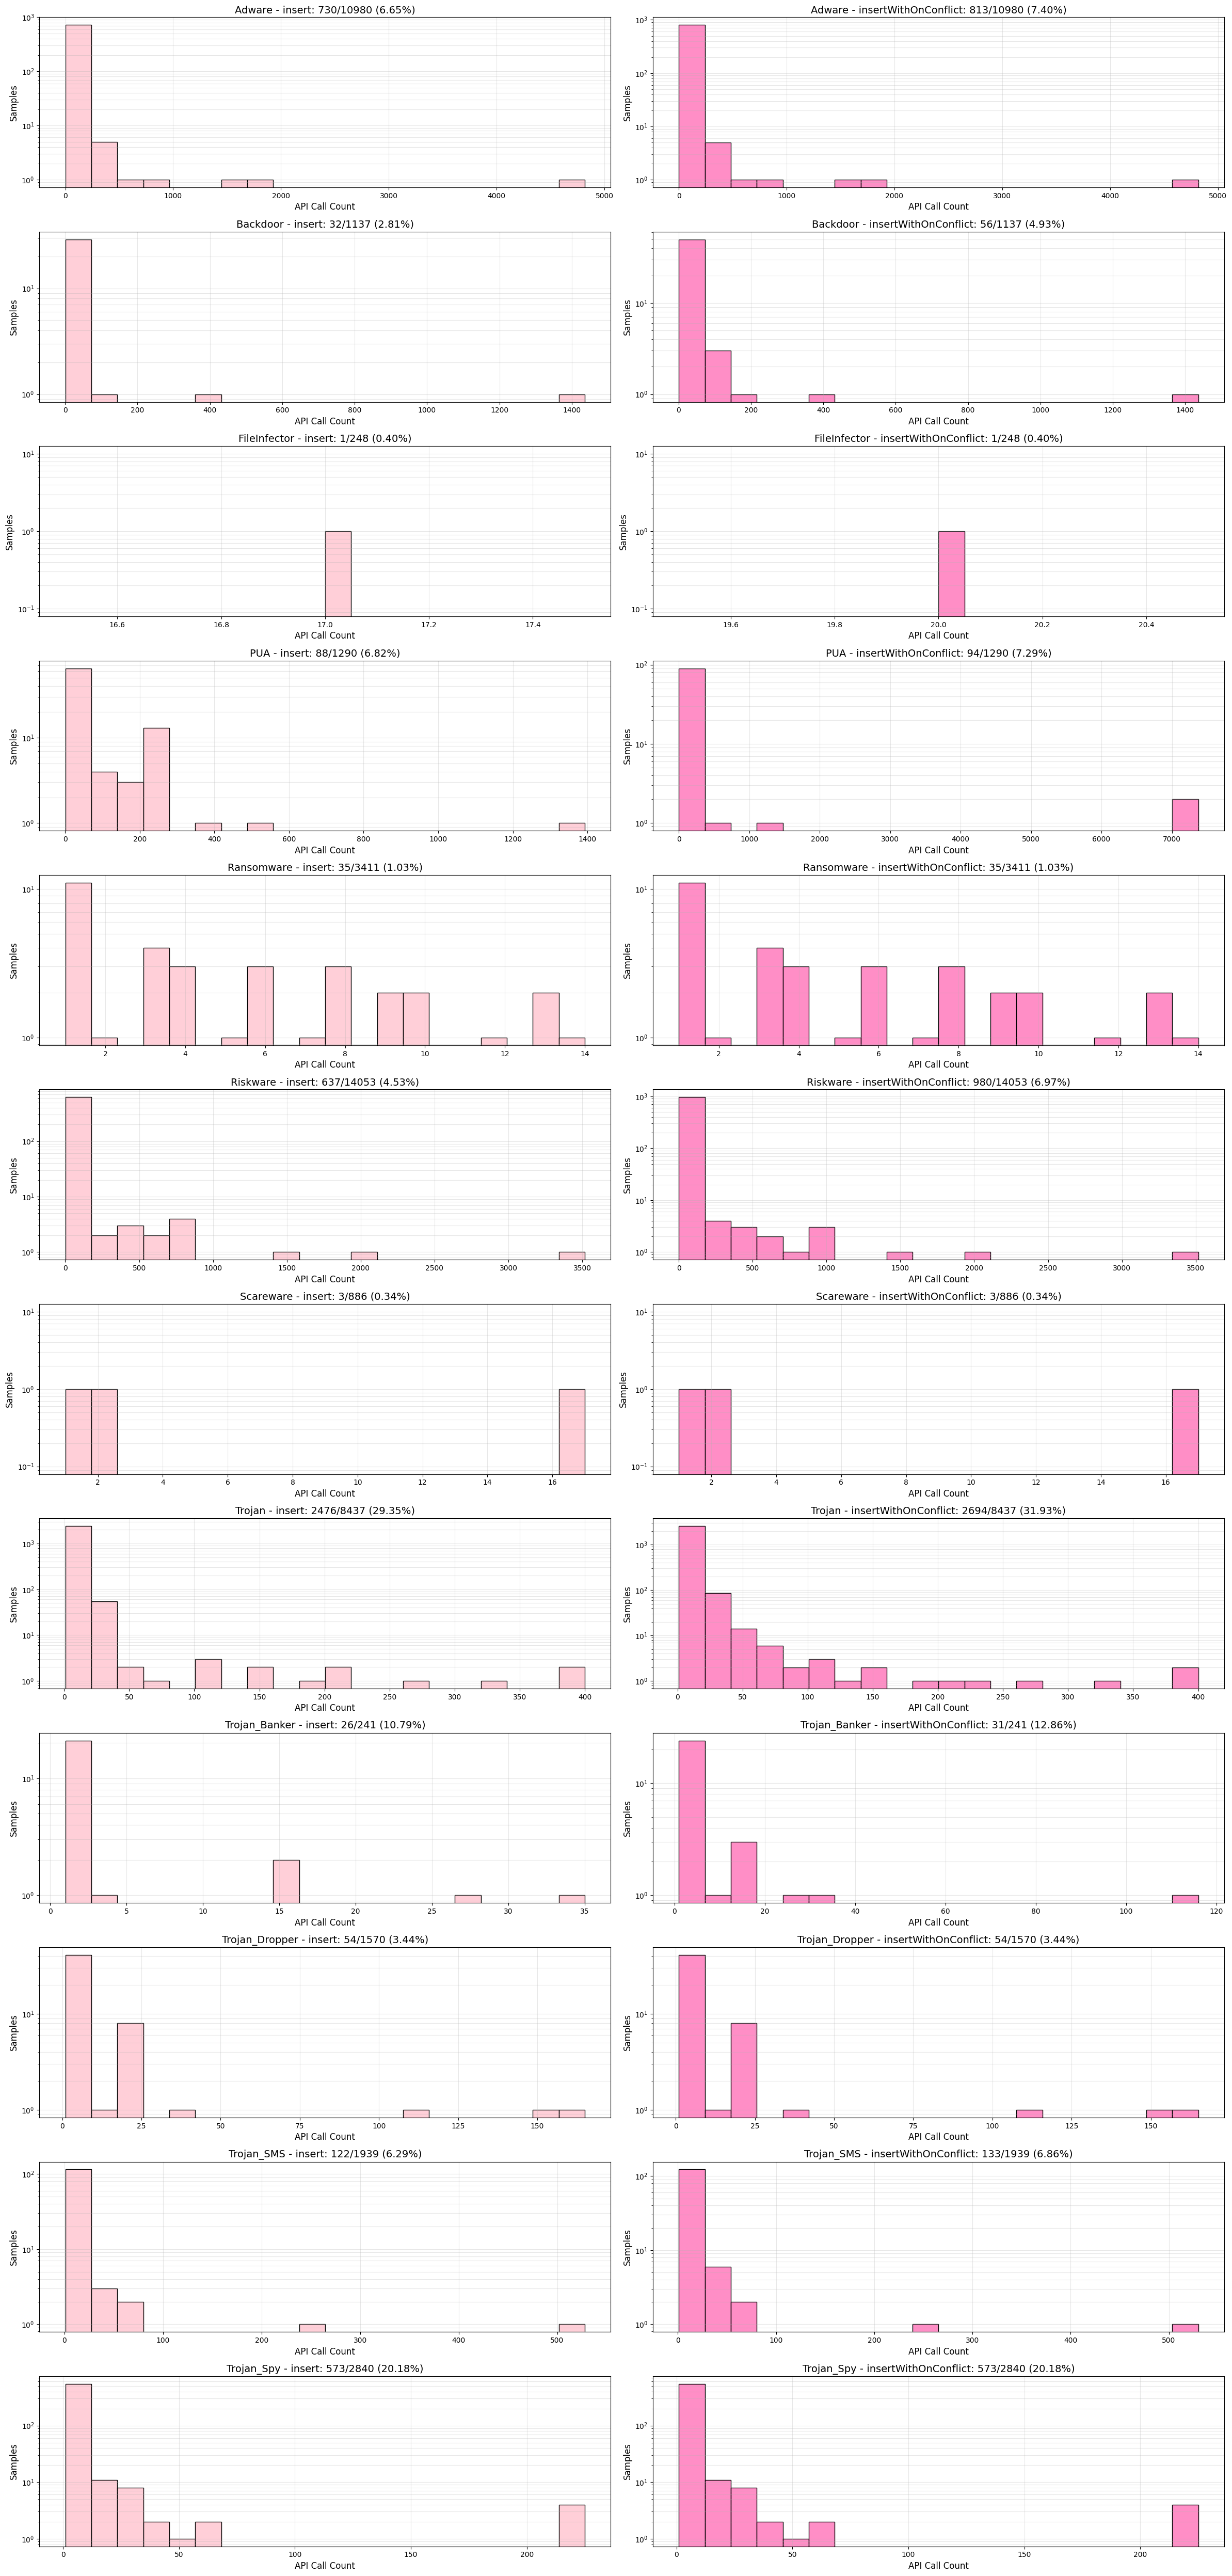

In [144]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]

feature_1 = "API_Database_android.database.sqlite.SQLiteDatabase_insert"
feature_2 = "API_Database_android.database.sqlite.SQLiteDatabase_insertWithOnConflict"

# Set up grid: 12 categories, 2 columns per category → total 24 plots (12 rows, 2 columns)
plt.figure(figsize=(24, 50))  # Adjust size to fit all plots clearly

for i, category in enumerate(top_categories):
    # Get full count for current category
    category_mask = default_pipeline.EDA.dataset['Category'] == category
    total_category_count = category_mask.sum()
    
    # --- Feature 1: insert ---
    cat_data_1 = default_pipeline.EDA.dataset[
        category_mask & (default_pipeline.EDA.dataset[feature_1] > 0)
    ]
    count_1 = len(cat_data_1)
    percent_1 = (count_1 / total_category_count) * 100

    plt.subplot(len(top_categories), 2, 2*i + 1)
    sns.histplot(cat_data_1[feature_1], bins=20, color='pink')
    plt.title(f"{category} - insert: {count_1}/{total_category_count} ({percent_1:.2f}%)", fontsize=14)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Samples", fontsize=12)
    plt.yscale("log")
    plt.grid(alpha=0.3,which='both')

    # --- Feature 2: insertWithOnConflict ---
    cat_data_2 = default_pipeline.EDA.dataset[
        category_mask & (default_pipeline.EDA.dataset[feature_2] > 0)
    ]
    count_2 = len(cat_data_2)
    percent_2 = (count_2 / total_category_count) * 100

    plt.subplot(len(top_categories), 2, 2*i + 2)
    sns.histplot(cat_data_2[feature_2], bins=20, color='hotpink')
    plt.title(f"{category} - insertWithOnConflict: {count_2}/{total_category_count} ({percent_2:.2f}%)", fontsize=14)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Samples", fontsize=12)
    plt.yscale("log")
    plt.grid(alpha=0.3,which='both')

plt.tight_layout()
plt.show()



Trojan_Spy, Trojan_SMS, Trojan_Dropper, Scareware, Ransomware and Adware seem to do the same number of calls. But let's check this formally.

In [163]:

# Define the two API feature names
feature_insert = "API_Database_android.database.sqlite.SQLiteDatabase_insert"
feature_onconflict = "API_Database_android.database.sqlite.SQLiteDatabase_insertWithOnConflict"

# Container for results
records = []

# Loop over each category and reboot state
for category in df['Category'].unique():
    for reboot_state in ['before', 'after']:
        subset = df[(df['Category'] == category) & (df['Reboot'] == reboot_state)]
        
        insert_nonzero = (subset[feature_insert] > 0).sum()
        onconflict_nonzero = (subset[feature_onconflict] > 0).sum()
        difference = abs(insert_nonzero - onconflict_nonzero)
        
        records.append({
            'Category': category,
            'Reboot': reboot_state,
            'Insert_NonZero': insert_nonzero,
            'InsertWithOnConflict_NonZero': onconflict_nonzero,
            'Difference': difference
        })

# Create DataFrame
comparison_df = pd.DataFrame(records)

# Pivot to get before/after columns side-by-side
pivot_df = comparison_df.pivot(index='Category', columns='Reboot', values=['Insert_NonZero', 'InsertWithOnConflict_NonZero', 'Difference'])

# Optional: reorder the columns for clarity
pivot_df = pivot_df[['Insert_NonZero', 'InsertWithOnConflict_NonZero', 'Difference']]

# Display result
print(pivot_df)



               Insert_NonZero        InsertWithOnConflict_NonZero         \
Reboot                  after before                        after before   
Category                                                                   
Adware                    250    480                          295    518   
Backdoor                    8     24                           18     38   
FileInfector                1      0                            1      0   
No_Category                68    105                          103    129   
PUA                        27     61                           29     65   
Ransomware                 15     20                           15     20   
Riskware                  206    431                          368    612   
Scareware                   1      2                            1      2   
Trojan                   1152   1324                         1264   1430   
Trojan_Banker               3     23                            6     25   
Trojan_Dropp

FileInfector, Ransomware, Scareware, Trojan_Dropper and Trojan_Spy remain the same in both features. Despite Trojan_Spy does not behave the same number of calls the difference is also pretty small, and same happens with PUA and Trojan_Banker.

So out of 12 malware categories five are the same. This could indicate some correlation between this features. In any case, insertWithConflic is clearly more used both before and after reboot.

On the other hand there does not seem to be any clear pattern that reboot does affect how many calls are made.

Malware like Trojan, Riskware and Adware use these database APIs a lot, and they keep using them in pretty much the same way even after a reboot. That suggests rebooting the device doesn’t really change how they write or store data. On the other hand, families like Ransomware, Scareware, and FileInfector almost never call these APIs, which likely means they don’t rely much on local storage to carry out their activities.

For modeling both features can be important, especially for tree-based models that can handle skewed inputs. However, for logistic regression for instance, it might be better to do a combined feature, such as total inserts, to avoid multicollinearity.


#### SQLiteDatabase_insertOrThrow

In [167]:
df['API_Database_android.database.sqlite.SQLiteDatabase_insertOrThrow'].describe()

count    53439.000000
mean         0.456090
std          6.831511
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        505.000000
Name: API_Database_android.database.sqlite.SQLiteDatabase_insertOrThrow, dtype: float64

Over 75% of all samples don't use this call, and out of the ones that do, the number of calls is pretty low with a maximum value of 505 and mean of only 0.46.

Since this method throws an exception on failure, its limited use may reflect an attempt to avoid application crashes during malicious operations. 

This method throws an error if something goes wrong so malware may try not to use it to prevent crashing the app. This could explain the low number of calls. This API will probably not be the more discriminative feature.

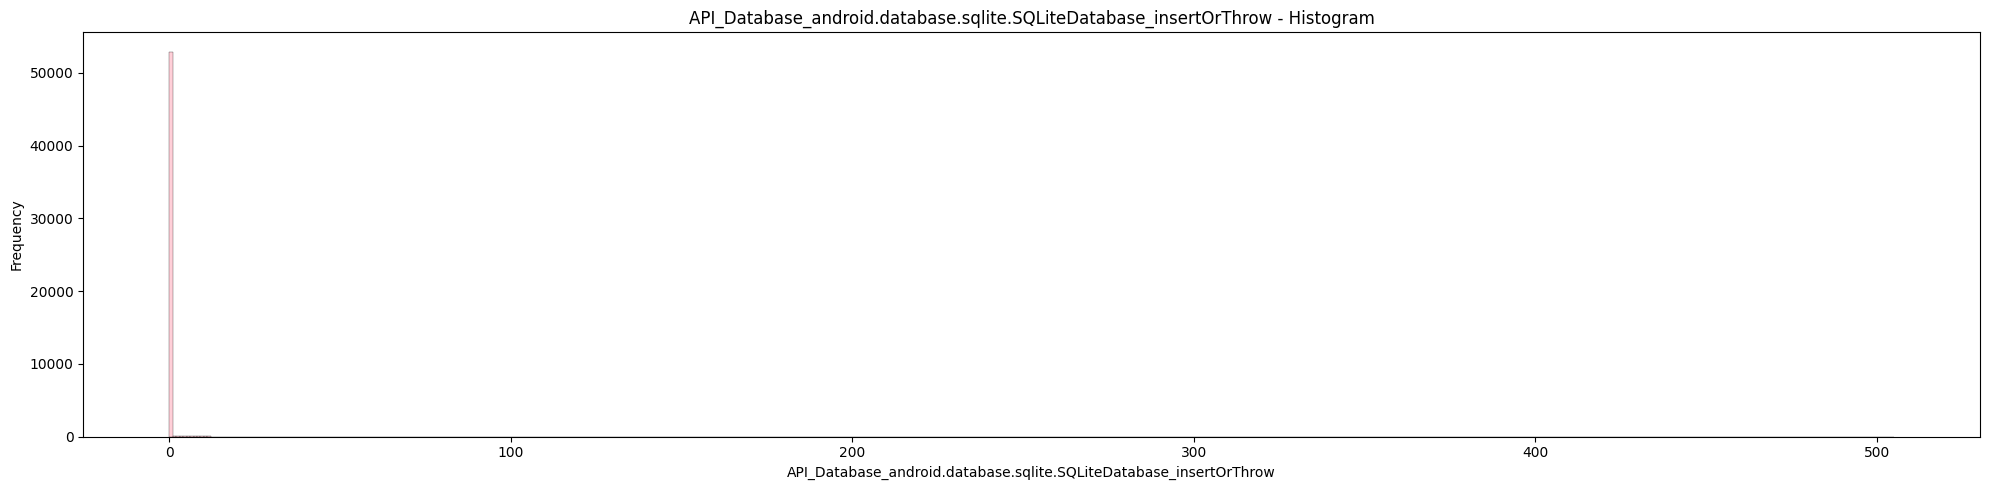

In [168]:
default_pipeline.EDA.plot_histograms(features=["API_Database_android.database.sqlite.SQLiteDatabase_insertOrThrow"], n_cols=1, bins=500)

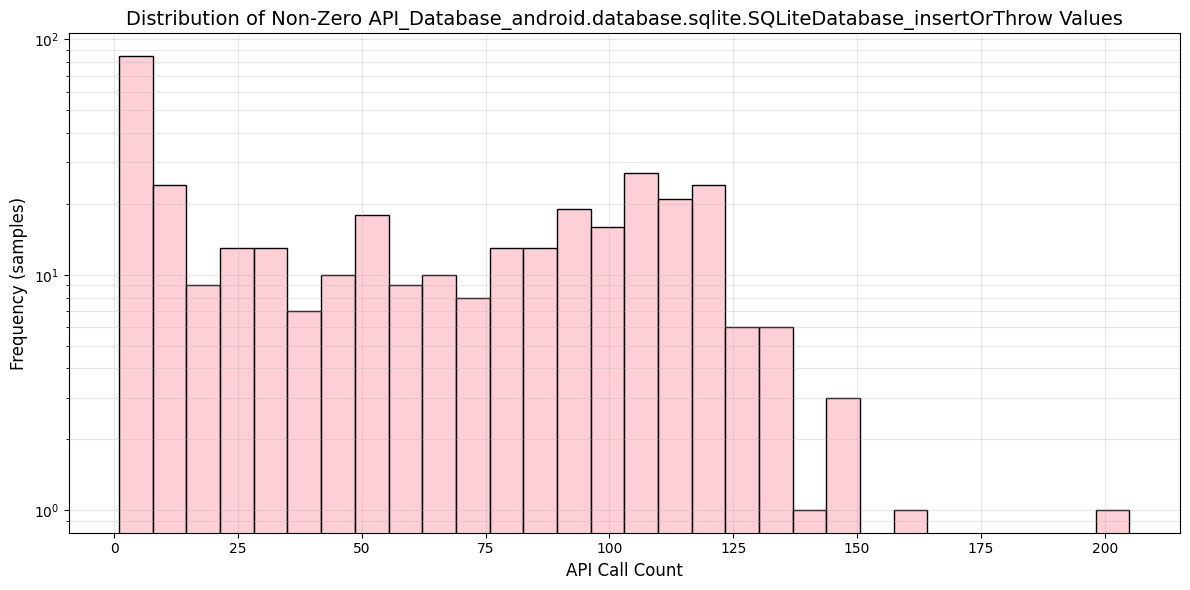

In [183]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Database_android.database.sqlite.SQLiteDatabase_insertOrThrow"] > 0]
sns.histplot(nonzero_samples["API_Database_android.database.sqlite.SQLiteDatabase_insertOrThrow"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Database_android.database.sqlite.SQLiteDatabase_insertOrThrow"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3,which='both')
plt.tight_layout()
plt.show()

Most values are concentrated on the range of 0 to 150 API calls. Then it suddently drops. A single outlier can be identified at a value of around 200. High usage does not seem common which supports the idea that the API call is not very much use for any purpose in general but for something more specific.

In [184]:
df.groupby('Category')['API_Database_android.database.sqlite.SQLiteDatabase_insertOrThrow'].describe()

count      mean        std  min  25%  50%  75%    max
Category                                                               
Adware          10980.0  0.020765   0.616090  0.0  0.0  0.0  0.0   37.0
Backdoor         1137.0  0.094107   1.480189  0.0  0.0  0.0  0.0   30.0
FileInfector      248.0  0.000000   0.000000  0.0  0.0  0.0  0.0    0.0
PUA              1290.0  0.293023   6.662729  0.0  0.0  0.0  0.0  205.0
Ransomware       3411.0  0.000000   0.000000  0.0  0.0  0.0  0.0    0.0
Riskware        14053.0  1.421974  11.575940  0.0  0.0  0.0  0.0  160.0
Scareware         886.0  0.000000   0.000000  0.0  0.0  0.0  0.0    0.0
Trojan           8437.0  0.009601   0.197849  0.0  0.0  0.0  0.0    6.0
Trojan_Banker     241.0  0.518672   7.168265  0.0  0.0  0.0  0.0  111.0
Trojan_Dropper   1570.0  0.000000   0.000000  0.0  0.0  0.0  0.0    0.0
Trojan_SMS       1939.0  0.003094   0.096324  0.0  0.0  0.0  0.0    3.0
Trojan_Spy       2840.0  0.000000   0.000000  0.0  0.0  0.0  0.0    0.0

There is a pretty uneven usage of this API.

Trojan_Spy, Trojan_Dropper, Scareware, Ransomware and FileInfector show 0 activity.

On the other hand, Riskware stands out with the highest mean compared to all others, suggesting that this category includes samples performing repeated insertions where they want to strictly enforce write conditions. 

PUA and Trojan_Banker also show some usage, with moderate means.

Trojan, Trojan_SMS, and Adware barely use this API.

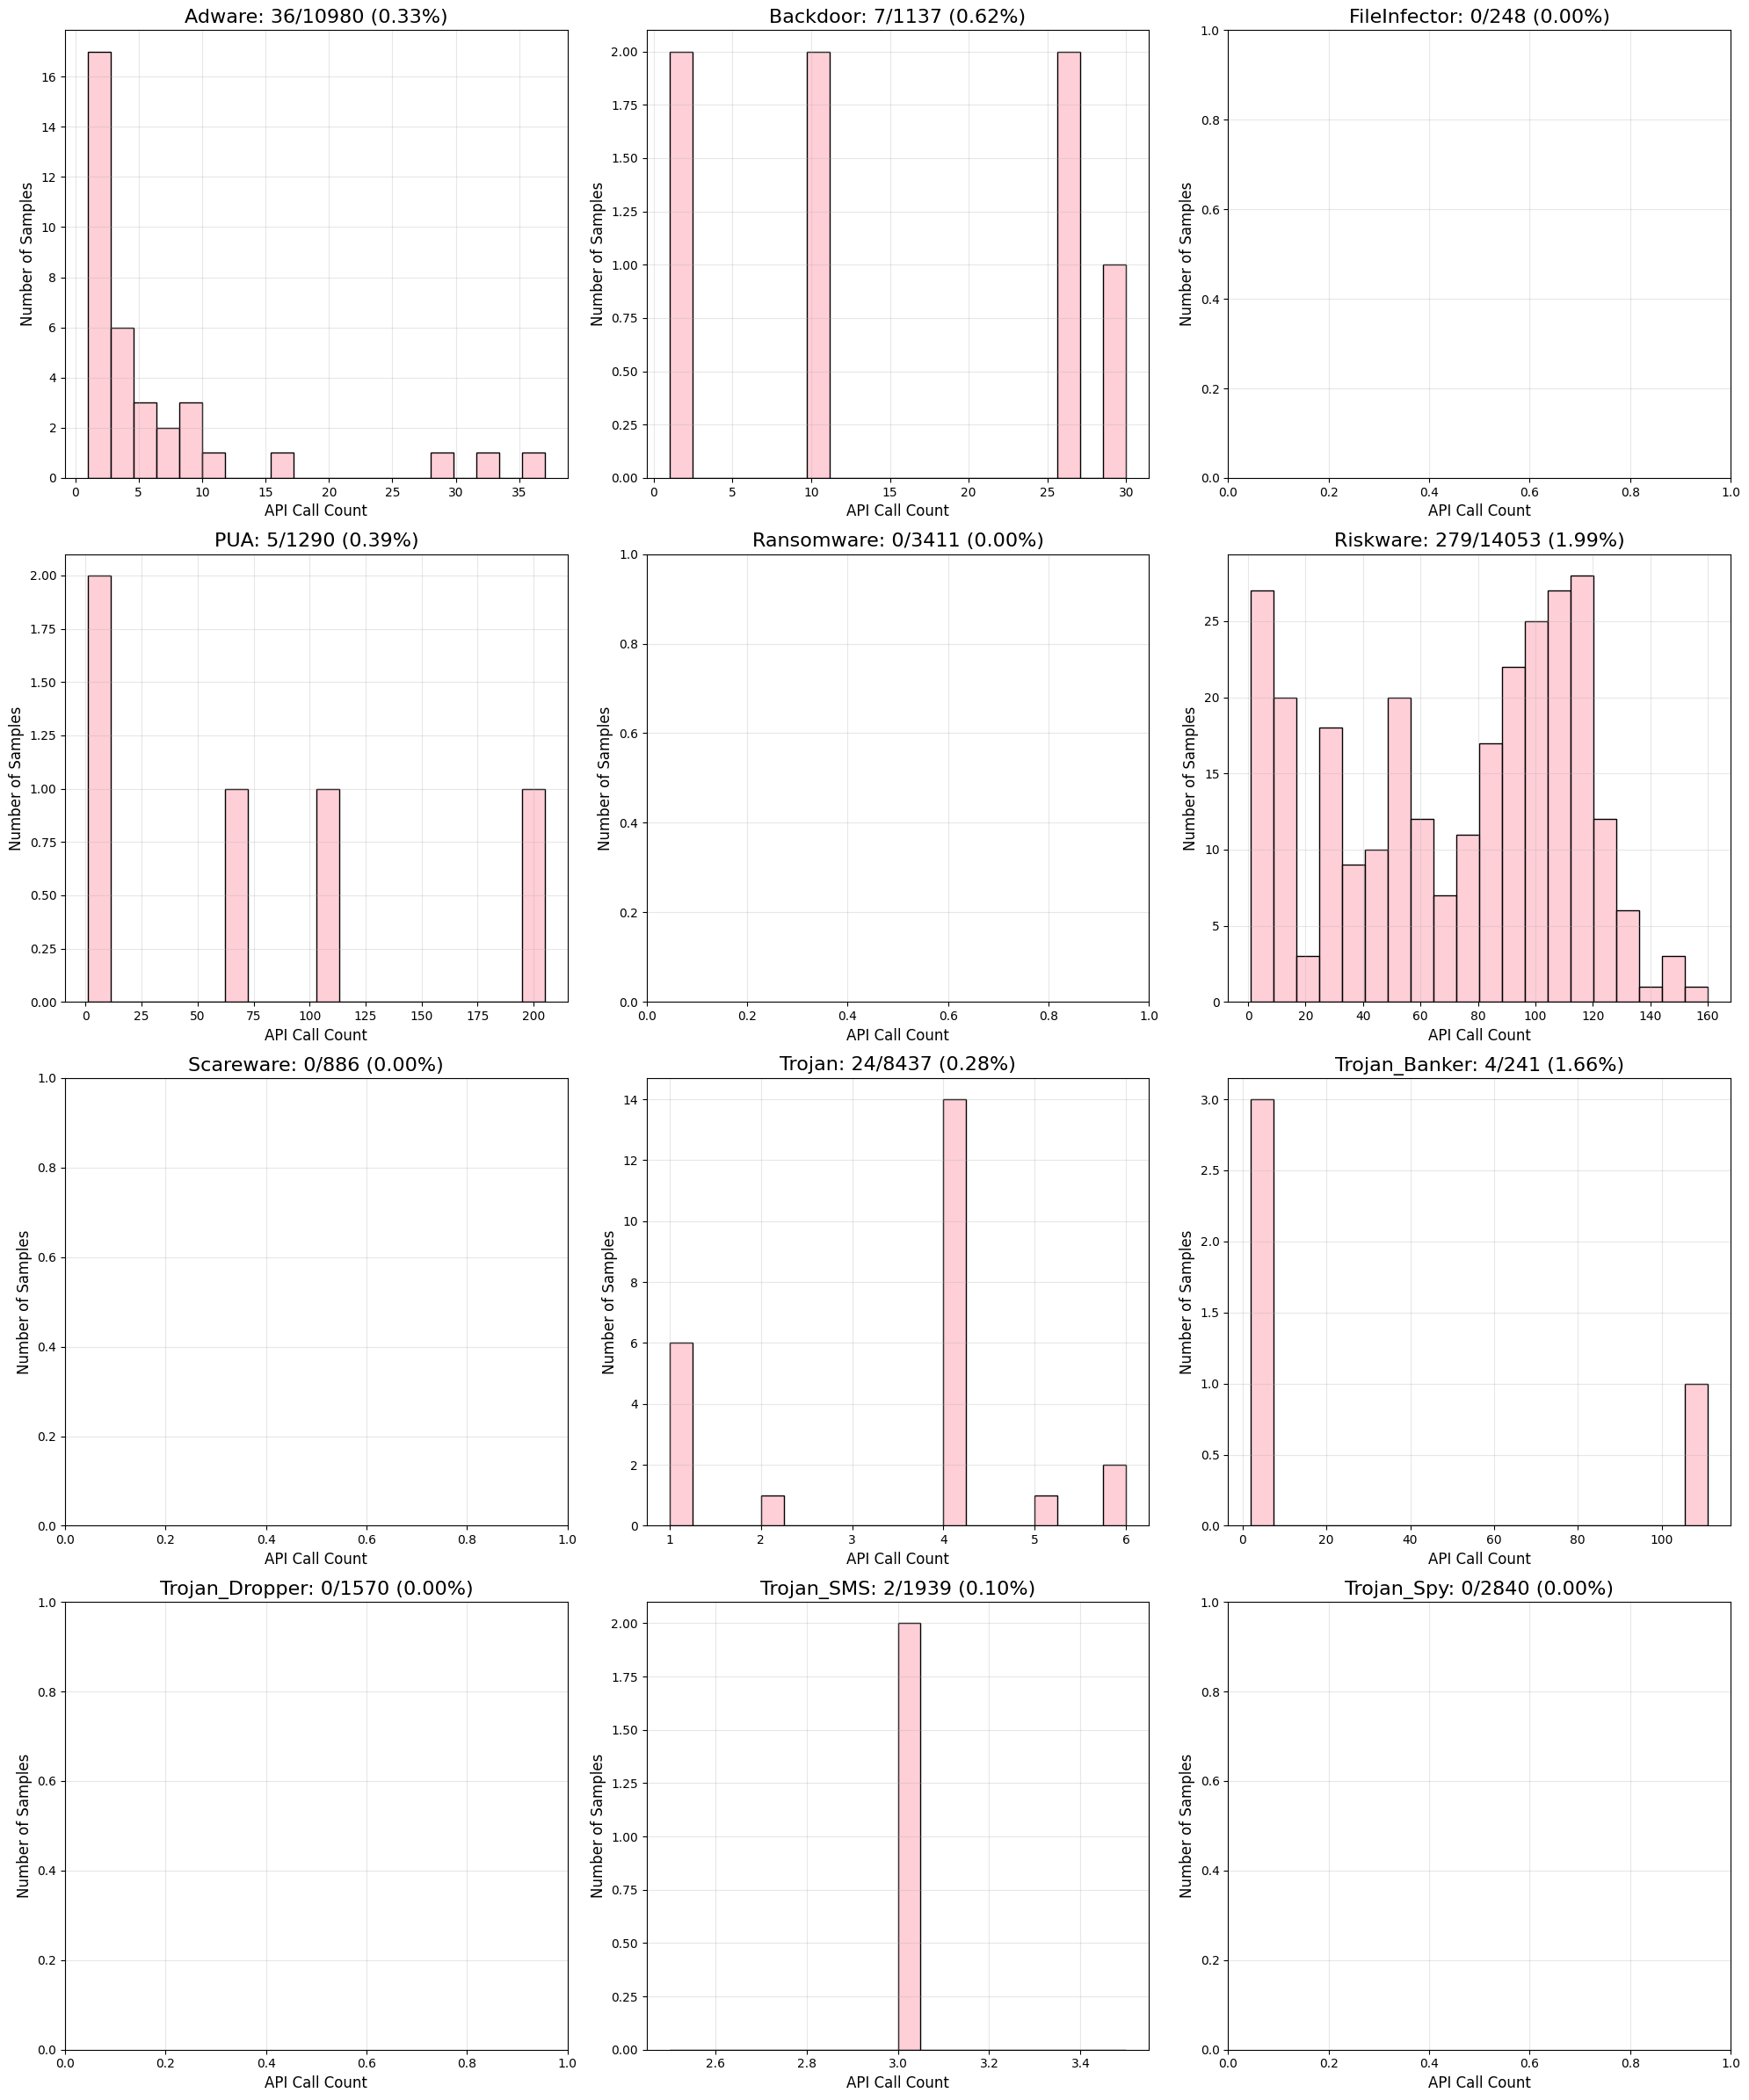

In [148]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]

api_feature = "API_Database_android.database.sqlite.SQLiteDatabase_insertOrThrow"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Riskware clearly stands out. It not only uses the insertOrThrow API more often than other categories, but also does it consistently, especially with a tight cluster of calls between 100 and 130. This suggests it’s intentionally using this method for tasks like reliable data logging or storage, where keeping data intact really matters.

Other types like Adware, PUA, and Backdoor use the API occasionally, but it’s pretty inconsistent.

Trojan_Banker's behavior is also interesting. Even though only a few of its samples use the API, when they do, they use it a lot.

This feature isn't probably useful to discriminate all malware categories, but it might be good for distinguishing specific types like Riskware. However, since most categories show little to no activity, it is probably not strong enough in general.

Let's now analyse the impact of reboot.

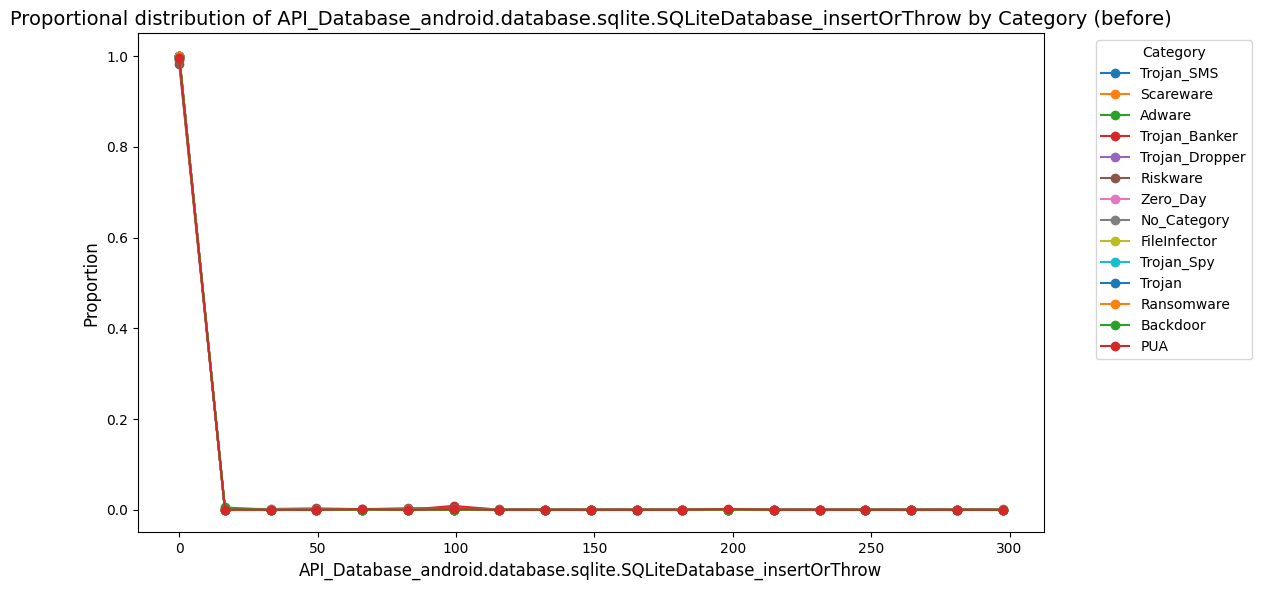

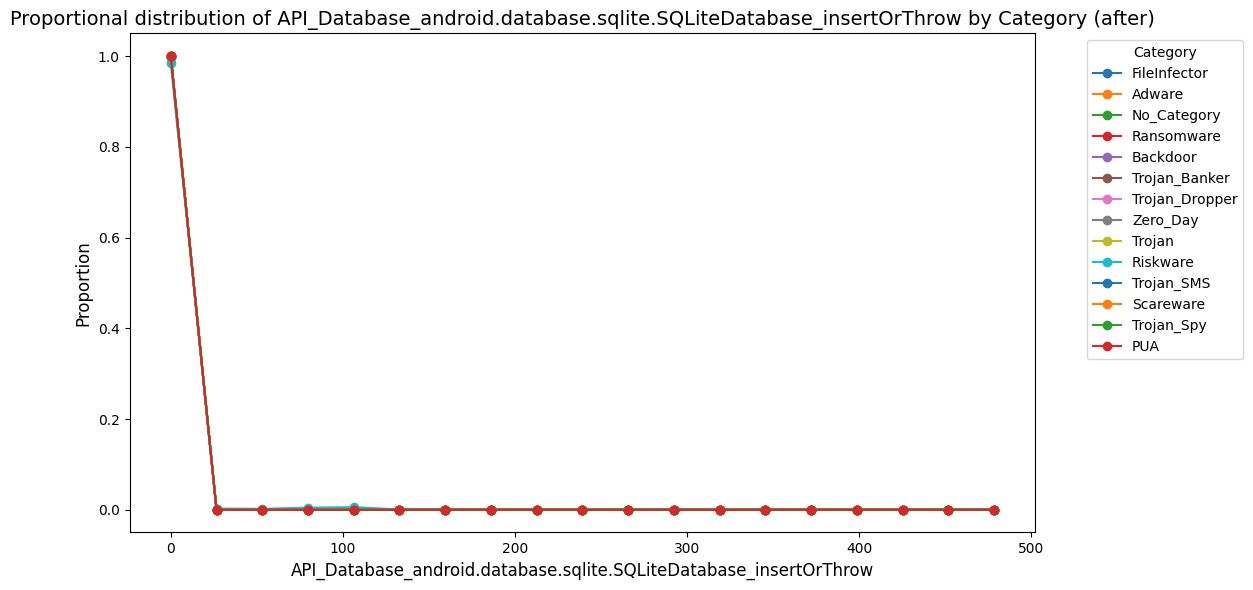

In [149]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_Database_android.database.sqlite.SQLiteDatabase_insertOrThrow",
    category_column="Category",
    by_reboot = True
)

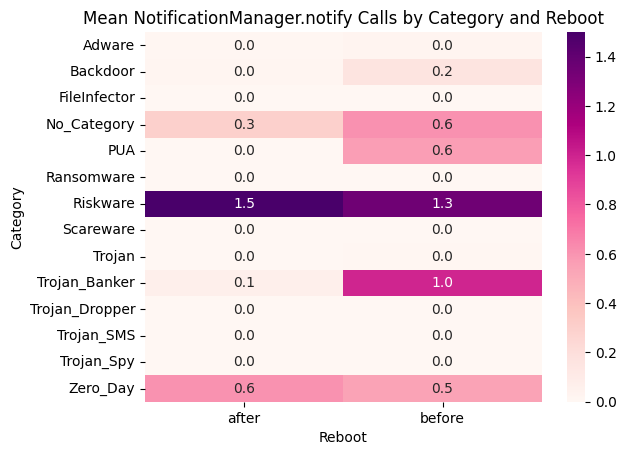

In [170]:
df = default_pipeline.dataset.df.copy()
df['notify_bin'] = pd.cut(df['API_Database_android.database.sqlite.SQLiteDatabase_insertOrThrow'], bins=5)

pivot = df.pivot_table(index='Category', columns='Reboot', values='API_Database_android.database.sqlite.SQLiteDatabase_insertOrThrow', aggfunc='mean')
sns.heatmap(pivot, annot=True, fmt=".1f", cmap='RdPu')
plt.title('Mean NotificationManager.notify Calls by Category and Reboot')
plt.show()

The effect of reboot seems to be minimal on the calls made by each category.

#### SQLiteDatabase_openDatabase and SQLiteDatabase_openOrCreateDatabase

In [55]:
df['API_Database_android.database.sqlite.SQLiteDatabase_openDatabase'].describe()

count    53439.000000
mean         7.432493
std         24.647981
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max       1264.000000
Name: API_Database_android.database.sqlite.SQLiteDatabase_openDatabase, dtype: float64

This shows a highly skewed distributions with the majority of samples not using it at all.

The mean is 7.43 but the median is 0, and 75% of samples make fewer than 2 calls, indicating that while some samples use this API heavily (up to 1,264 calls), most don't use it at all. This points to a few high-usage outliers potentially driving up the average.

In [56]:
df['API_Database_android.database.sqlite.SQLiteDatabase_openOrCreateDatabase'].describe()

count    53439.000000
mean         0.486031
std          8.554101
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        522.000000
Name: API_Database_android.database.sqlite.SQLiteDatabase_openOrCreateDatabase, dtype: float64

This also shows an even more sparse distribution. 
The mean is 0.49, but 75% of samples still call it zero times. A small number of samples (with a max of 522 calls) contribute all the non-zero activity.

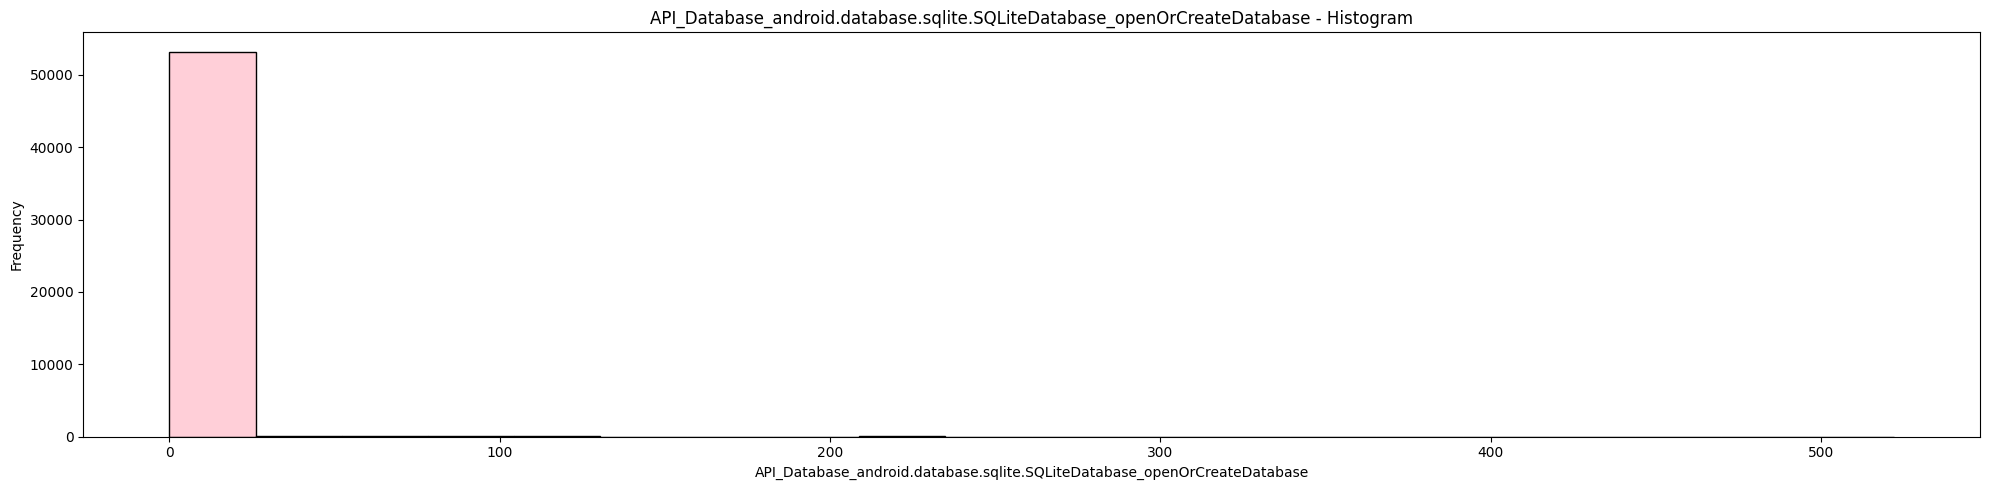

In [57]:
default_pipeline.EDA.plot_histograms(features=["API_Database_android.database.sqlite.SQLiteDatabase_openOrCreateDatabase"], n_cols=1, bins=20)

This histogram shows a heavy right skew for the SQLiteDatabase_openOrCreateDatabase API, with the vast majority of samples (\~53,000) never calling it. To better understand the behavior of samples that do use it, we’ll replot the distribution excluding zero values.

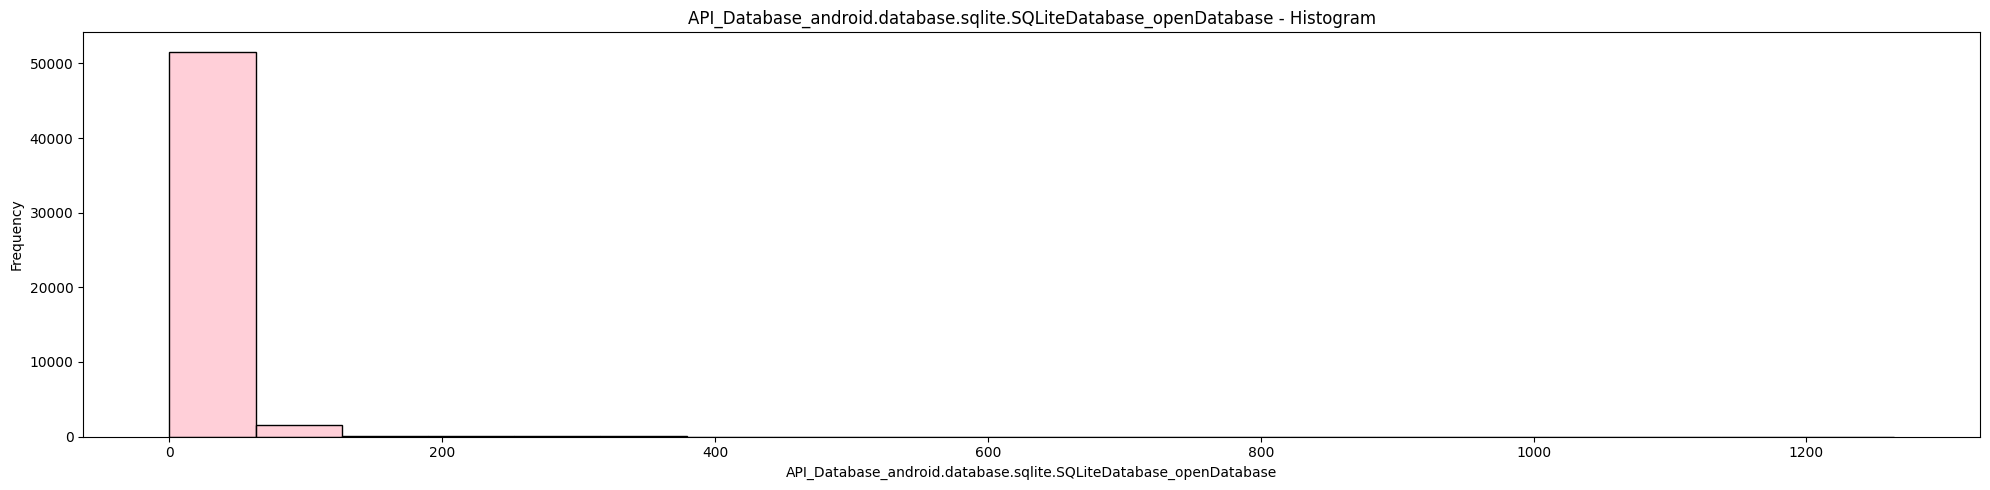

In [114]:
default_pipeline.EDA.plot_histograms(features=["API_Database_android.database.sqlite.SQLiteDatabase_openDatabase"], n_cols=1, bins=20)

This histogram shows a strong right skew for the SQLiteDatabase_openDatabase API, with the vast majority of samples (~53,000) making zero calls. To better explore actual usage patterns, we will replot the data excluding these zero values.

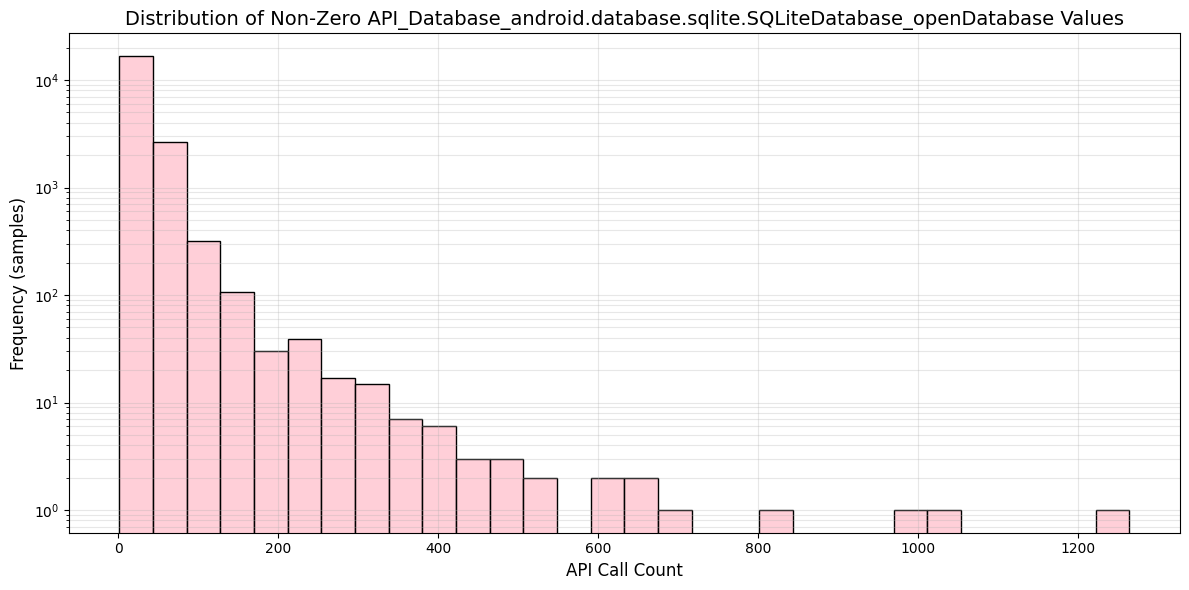

In [116]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Database_android.database.sqlite.SQLiteDatabase_openDatabase"] > 0]
sns.histplot(nonzero_samples["API_Database_android.database.sqlite.SQLiteDatabase_openDatabase"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Database_android.database.sqlite.SQLiteDatabase_openDatabase"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3,which='both')
plt.tight_layout()
plt.show()

This histogram of non-zero SQLiteDatabase_openOrCreateDatabase API calls shows a long-tail distribution. Most samples use the API fewer than 200 times, but a few outliers exceed 1000 calls. This suggests that while usage is uncommon overall, a subset of malware relies heavily on local database creation, possibly for storing stolen data or app configuration.

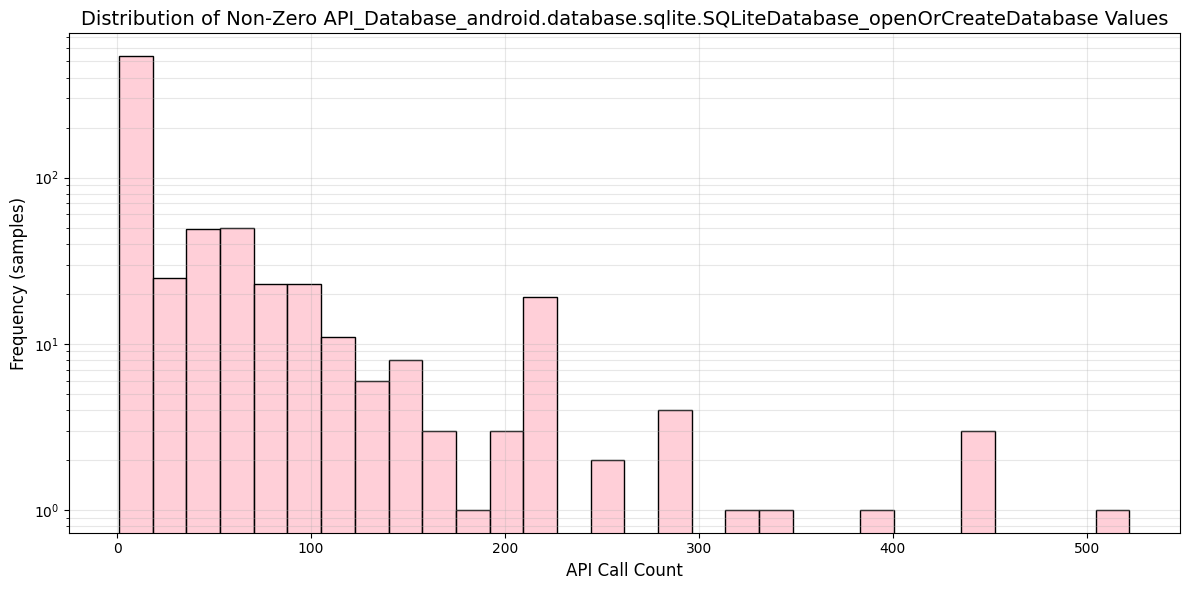

In [117]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Database_android.database.sqlite.SQLiteDatabase_openOrCreateDatabase"] > 0]
sns.histplot(nonzero_samples["API_Database_android.database.sqlite.SQLiteDatabase_openOrCreateDatabase"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Database_android.database.sqlite.SQLiteDatabase_openOrCreateDatabase"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3,which='both')
plt.tight_layout()
plt.show()

The distribution of non-zero SQLiteDatabase_openOrCreateDatabase API calls is broad and irregular, with most samples making between 1 and 100 calls, and a long tail stretching past 500. This wide spread and lack of strong peaks suggest highly variable usage patterns, potentially indicating differing internal logic or use cases among malware families.

In [118]:
df.groupby('Category')['API_Database_android.database.sqlite.SQLiteDatabase_openDatabase'].describe()

count       mean        std  min  25%  50%  75%     max
Category                                                                 
Adware          10980.0   7.013297  19.389804  0.0  0.0  0.0  4.0   532.0
Backdoor         1137.0   4.157432  13.482148  0.0  0.0  0.0  4.0   149.0
FileInfector      248.0   0.520161   4.297584  0.0  0.0  0.0  0.0    59.0
No_Category      1932.0   4.524327  35.223955  0.0  0.0  0.0  1.0  1264.0
PUA              1290.0   9.852713  46.127055  0.0  0.0  0.0  0.0   523.0
Ransomware       3411.0   1.719437  22.207397  0.0  0.0  0.0  0.0   416.0
Riskware        14053.0  14.240162  27.334072  0.0  0.0  1.0  8.0   334.0
Scareware         886.0   0.422122   5.593189  0.0  0.0  0.0  0.0   130.0
Trojan           8437.0   3.700130  22.224397  0.0  0.0  0.0  2.0  1015.0
Trojan_Banker     241.0   4.626556  16.331767  0.0  0.0  0.0  0.0   145.0
Trojan_Dropper   1570.0   9.091720  34.161716  0.0  0.0  0.0  0.0   692.0
Trojan_SMS       1939.0   1.536359  11.213340  0.0  0.0  0.0  0.0   274.0
Trojan_Spy       2840.0   4.773592  13.856348  0.0  0.0  0.0  2.0   164.0
Zero_Day         4475.0   5.446480  25.211390  0.0  0.0  0.0  2.0   840.0

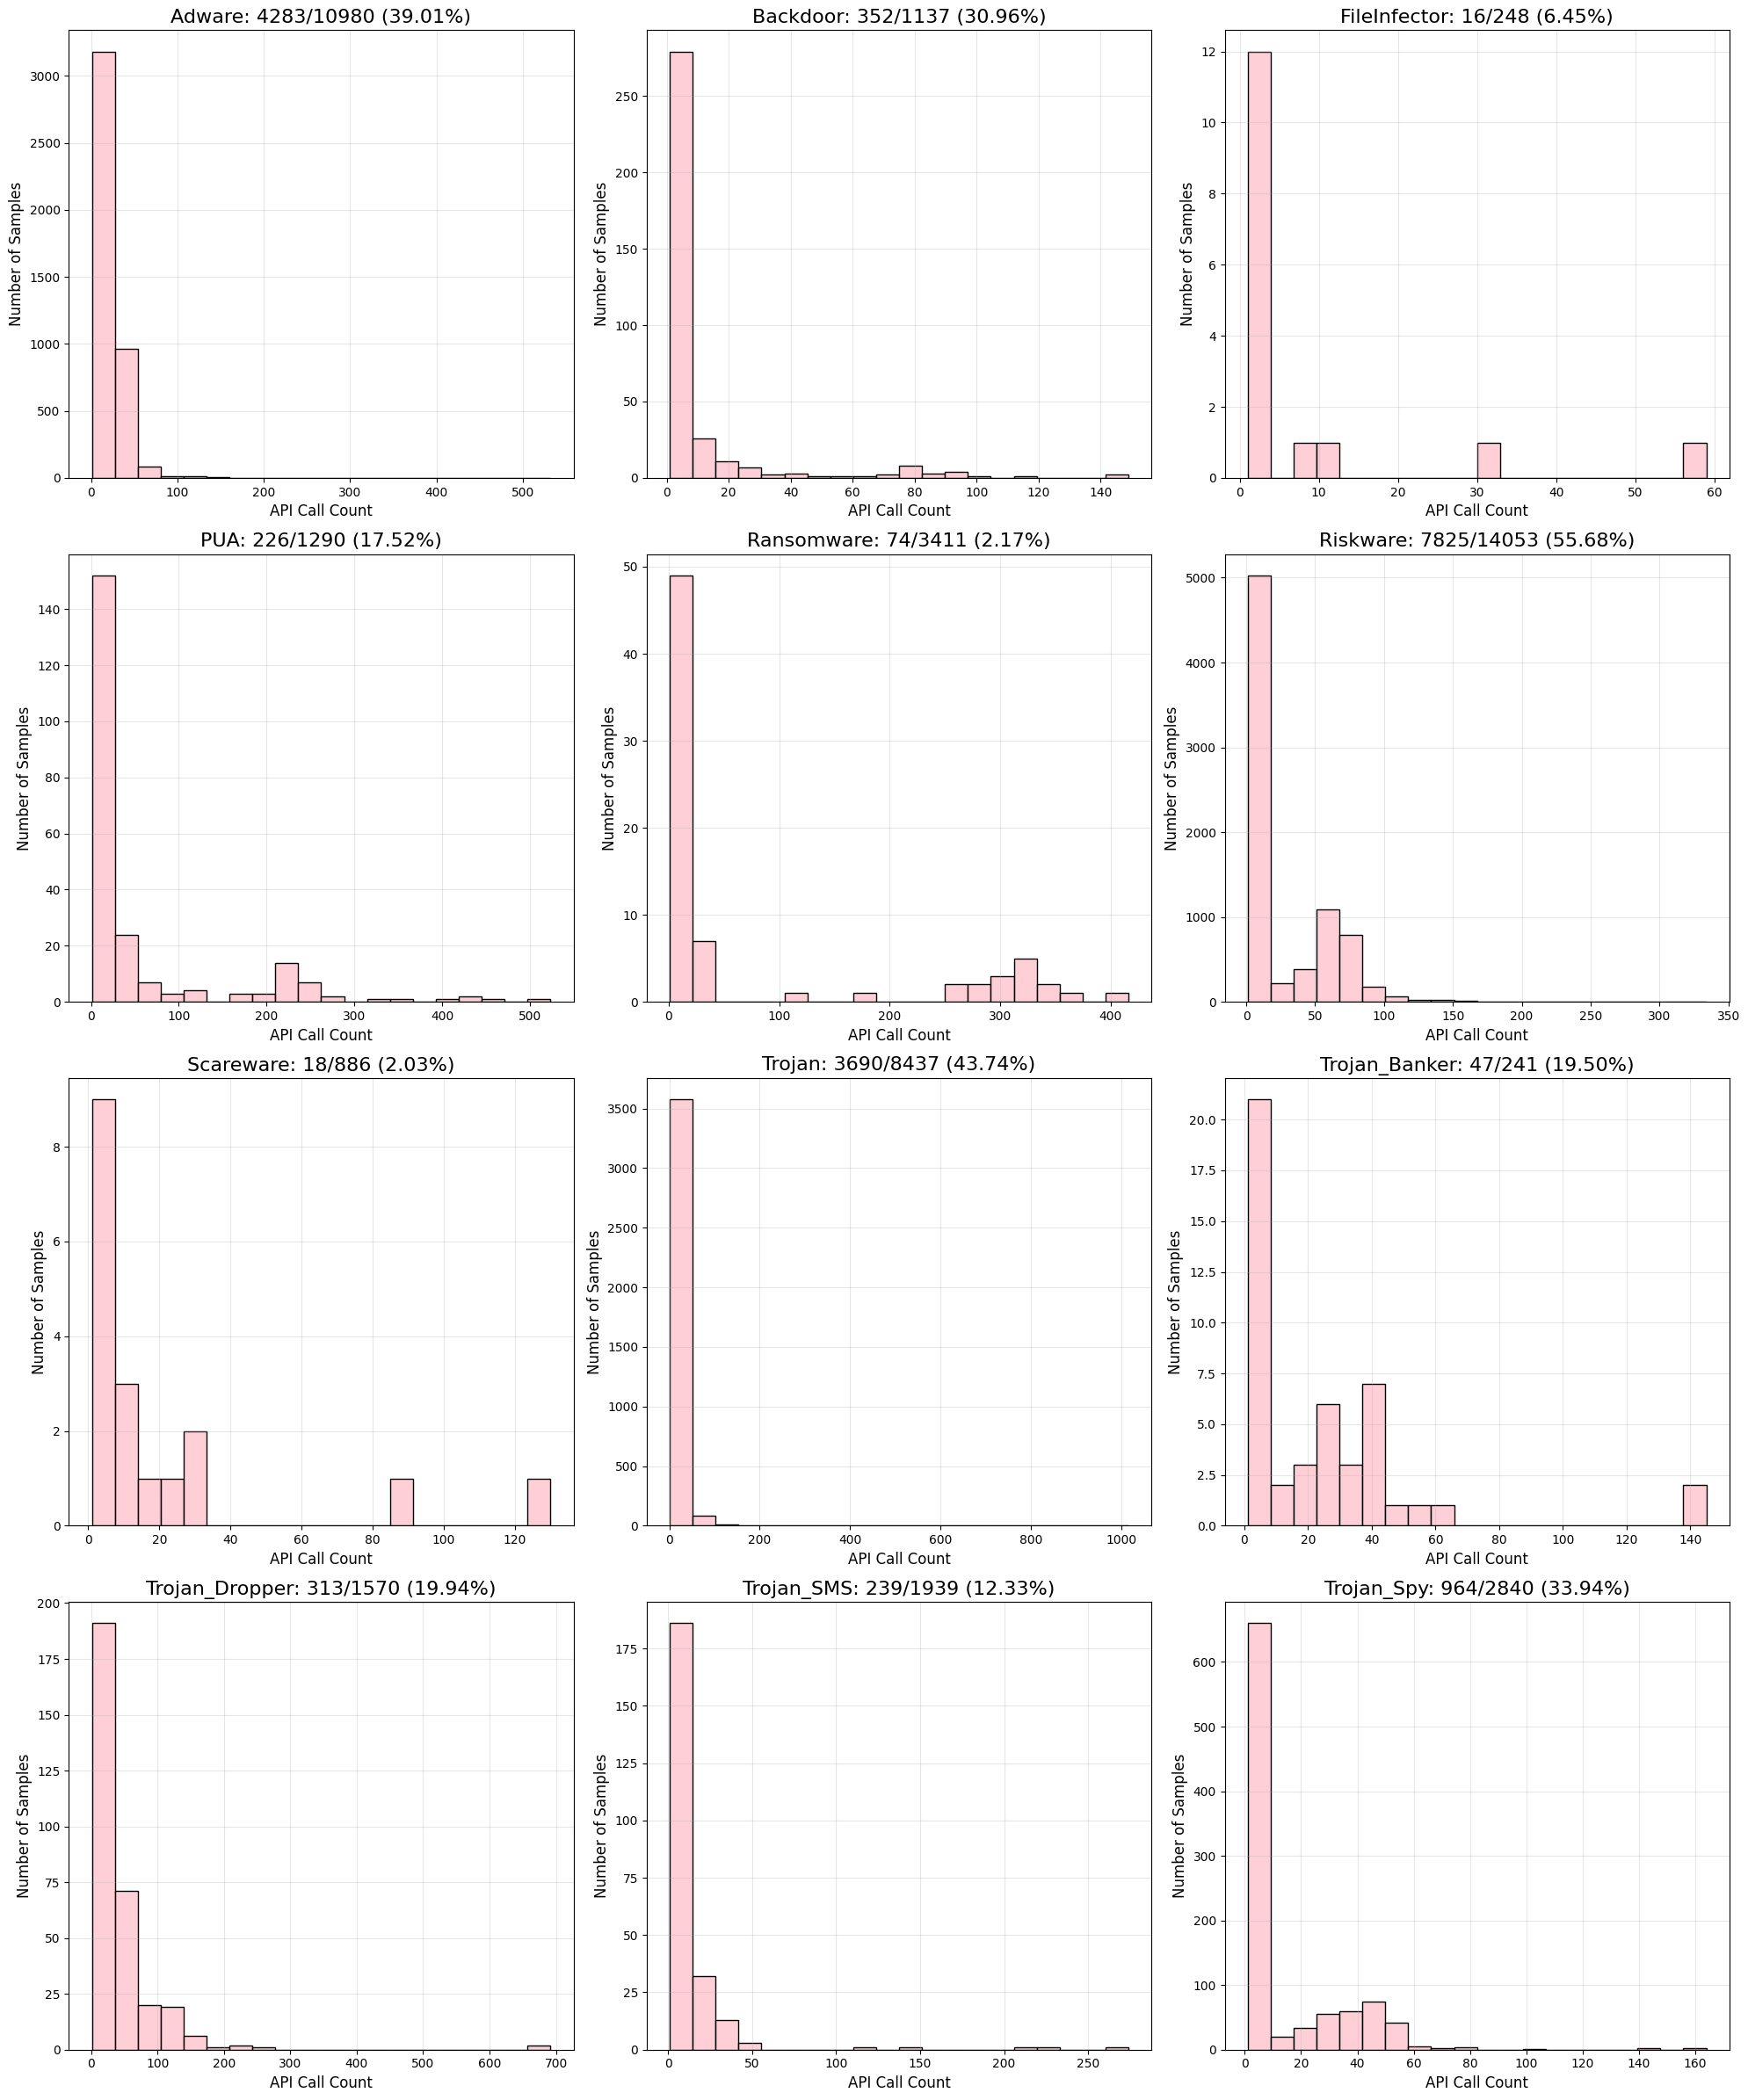

In [66]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]

api_feature = "API_Database_android.database.sqlite.SQLiteDatabase_openDatabase"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

PUA, Trojan_Dropper, and Riskware show the highest average usage of SQLiteDatabase_openOrCreateDatabase, suggesting frequent local data handling, possibly for config storage or payload delivery.

No_Category and Trojan_Spy also show above-average use, with some samples reaching over 1000 calls, indicating potential heavy reliance on databases in specific variants.

In contrast, Scareware, FileInfector, and Trojan_SMS use this API rarely, reinforcing their limited need for structured storage.

The wide max values (e.g., 1264 in No_Category and 1015 in Trojan) confirm that while this API is broadly underused, a small subset of samples relies on it heavily, making it potentially useful in classifying certain behaviors.

In [119]:
df.groupby('Category')['API_Database_android.database.sqlite.SQLiteDatabase_openOrCreateDatabase'].describe()

count      mean        std  min  25%  50%  75%    max
Category                                                               
Adware          10980.0  0.147086   3.833965  0.0  0.0  0.0  0.0  248.0
Backdoor         1137.0  0.060686   0.614391  0.0  0.0  0.0  0.0   11.0
FileInfector      248.0  0.000000   0.000000  0.0  0.0  0.0  0.0    0.0
No_Category      1932.0  0.607143  10.207501  0.0  0.0  0.0  0.0  296.0
PUA              1290.0  5.700000  40.806768  0.0  0.0  0.0  0.0  522.0
Ransomware       3411.0  0.015245   0.246505  0.0  0.0  0.0  0.0    6.0
Riskware        14053.0  0.387177   5.169696  0.0  0.0  0.0  0.0  256.0
Scareware         886.0  0.015801   0.335774  0.0  0.0  0.0  0.0    8.0
Trojan           8437.0  0.959820   9.303847  0.0  0.0  0.0  0.0  174.0
Trojan_Banker     241.0  0.000000   0.000000  0.0  0.0  0.0  0.0    0.0
Trojan_Dropper   1570.0  0.029299   0.585926  0.0  0.0  0.0  0.0   14.0
Trojan_SMS       1939.0  0.000000   0.000000  0.0  0.0  0.0  0.0    0.0
Trojan_Spy       2840.0  0.009155   0.353995  0.0  0.0  0.0  0.0   16.0
Zero_Day         4475.0  0.466145   7.515081  0.0  0.0  0.0  0.0  224.0

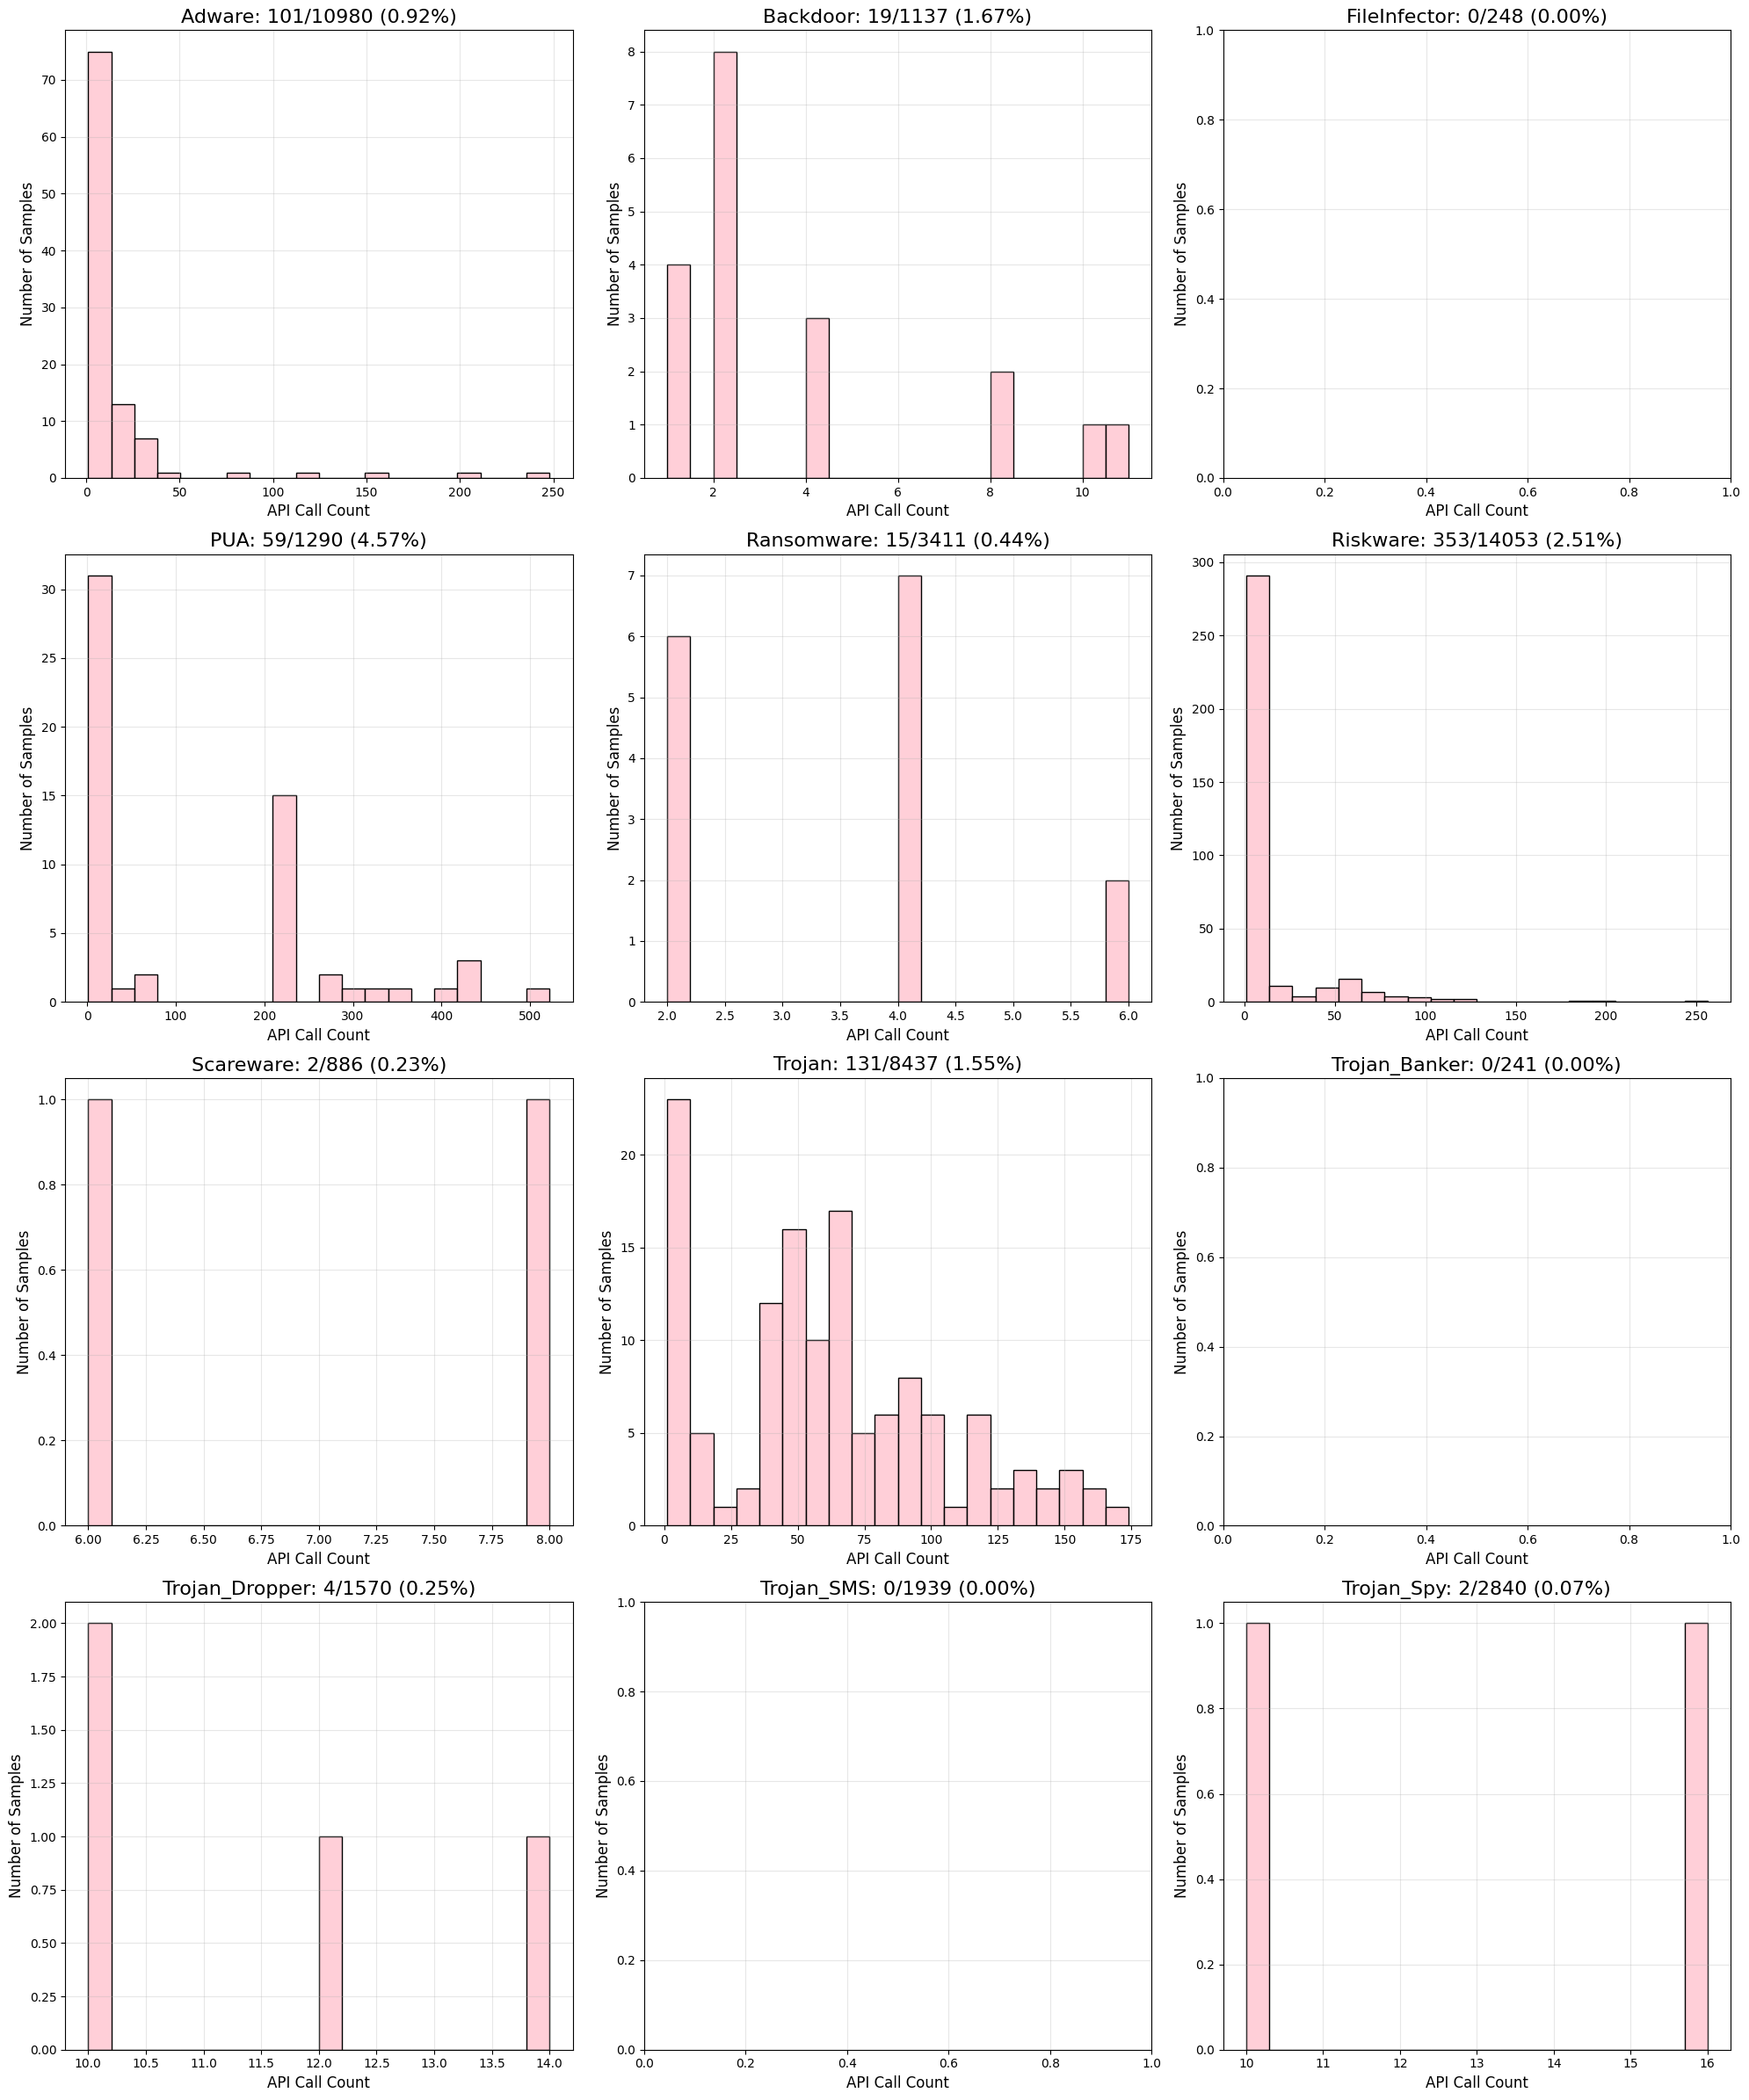

In [67]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]

api_feature = "API_Database_android.database.sqlite.SQLiteDatabase_openOrCreateDatabase"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

The distribution of SQLiteDatabase_openOrCreateDatabase API usage shows wide variability across categories, with only a few families using it consistently and most barely calling it at all.

PUA leads in average usage (mean ≈ 5.7), with some samples reaching over 500 calls, suggesting frequent use of local storage for lightweight or ad-driven behavior.

Trojan and No_Category also show moderate usage, but with extreme outliers (up to 174 and 296 calls), implying diverse or unstructured use cases.

Riskware and Adware have relatively high maxima (256 and 248), but their average usage remains low, hinting at occasional but not dominant reliance on local database features.

Zero_Day and Trojan_Dropper sit in the middle range, with modest means and wide spreads, perhaps tied to experimental features or multi-stage payloads.

Most other categories—including FileInfector, Trojan_Banker, Trojan_SMS, and Trojan_Spy—show near-zero usage, pointing to little to no interaction with database functionality.

Overall, while this API sees significant use in a handful of families, its inconsistent distribution and heavy-tailed behavior suggest it's more supportive than defining for classification.

#### SQLiteDatabase_query and SQLiteDatabase_queryWithFactory

In [50]:
df['API_Database_android.database.sqlite.SQLiteDatabase_query'].describe()

count    53439.000000
mean         2.459571
std         28.042331
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4412.000000
Name: API_Database_android.database.sqlite.SQLiteDatabase_query, dtype: float64

In [39]:
df['API_Database_android.database.sqlite.SQLiteDatabase_queryWithFactory'].describe()

count    53439.000000
mean         2.361758
std         27.484477
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4413.000000
Name: API_Database_android.database.sqlite.SQLiteDatabase_queryWithFactory, dtype: float64

Both features look very similar statistically: they have nearly identical means (2.46 and 2.36), very close std (28.04 and 27.48) and have the same median and interquartile range (all 0). Moreover the maximum value registered only differs by one unit (4412 and 4413)

This high similarity might mean that heeping both is most likely redundant and might introduce unnecessary noise or collinearity.

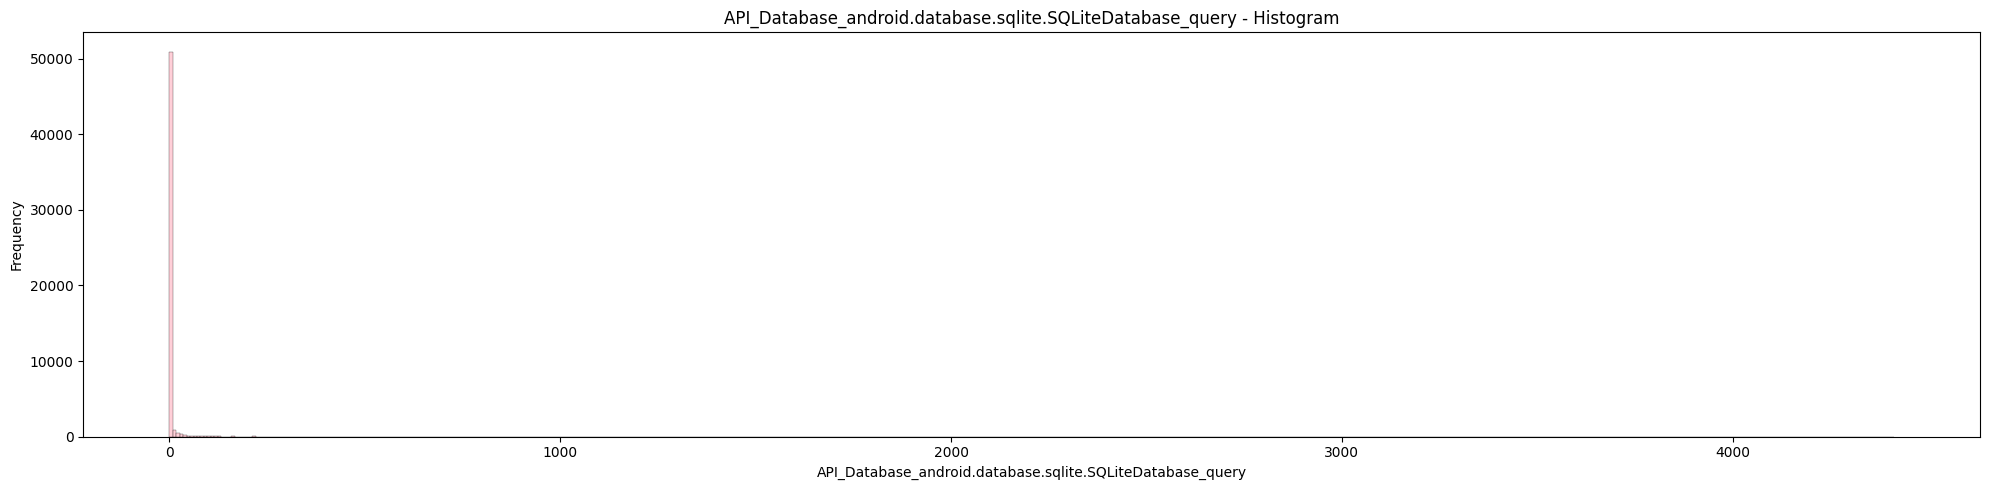

In [173]:
default_pipeline.EDA.plot_histograms(features=["API_Database_android.database.sqlite.SQLiteDatabase_query"], n_cols=1, bins=500)

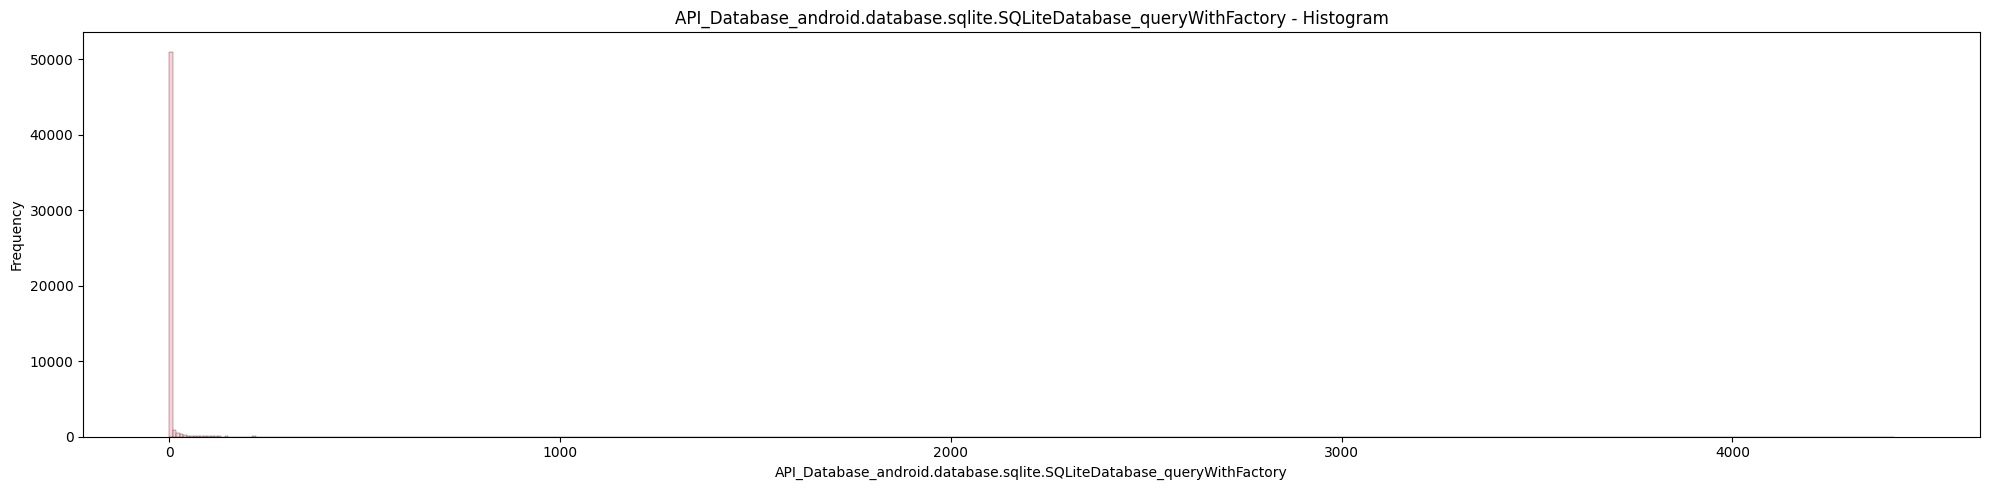

In [174]:
default_pipeline.EDA.plot_histograms(features=["API_Database_android.database.sqlite.SQLiteDatabase_queryWithFactory"], n_cols=1, bins=500)

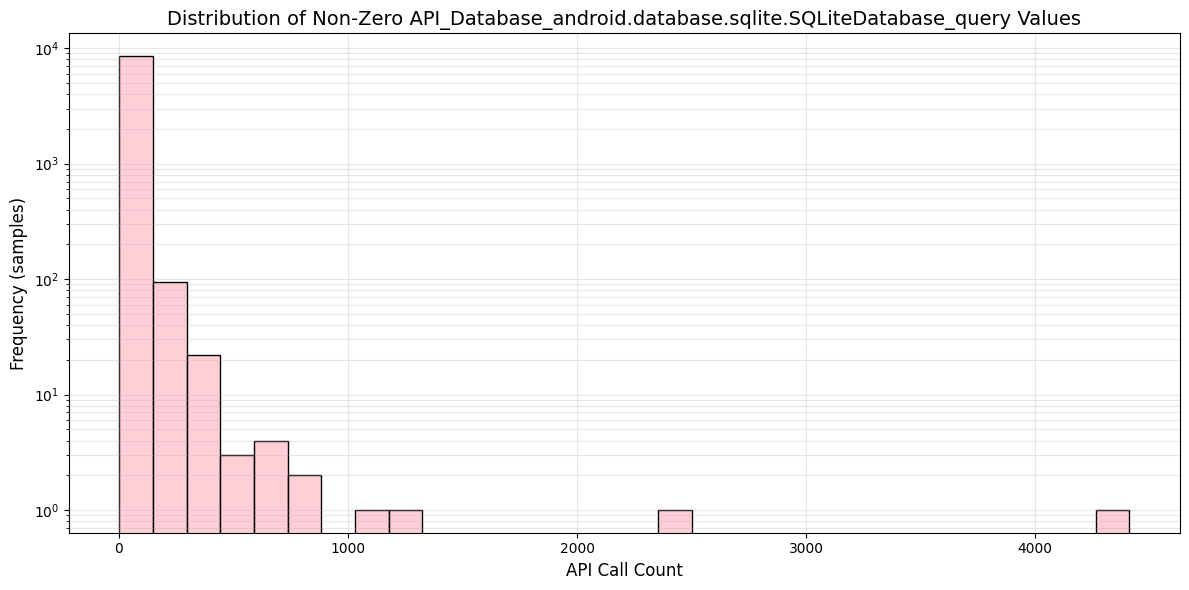

In [175]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Database_android.database.sqlite.SQLiteDatabase_query"] > 0]
sns.histplot(nonzero_samples["API_Database_android.database.sqlite.SQLiteDatabase_query"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Database_android.database.sqlite.SQLiteDatabase_query"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()


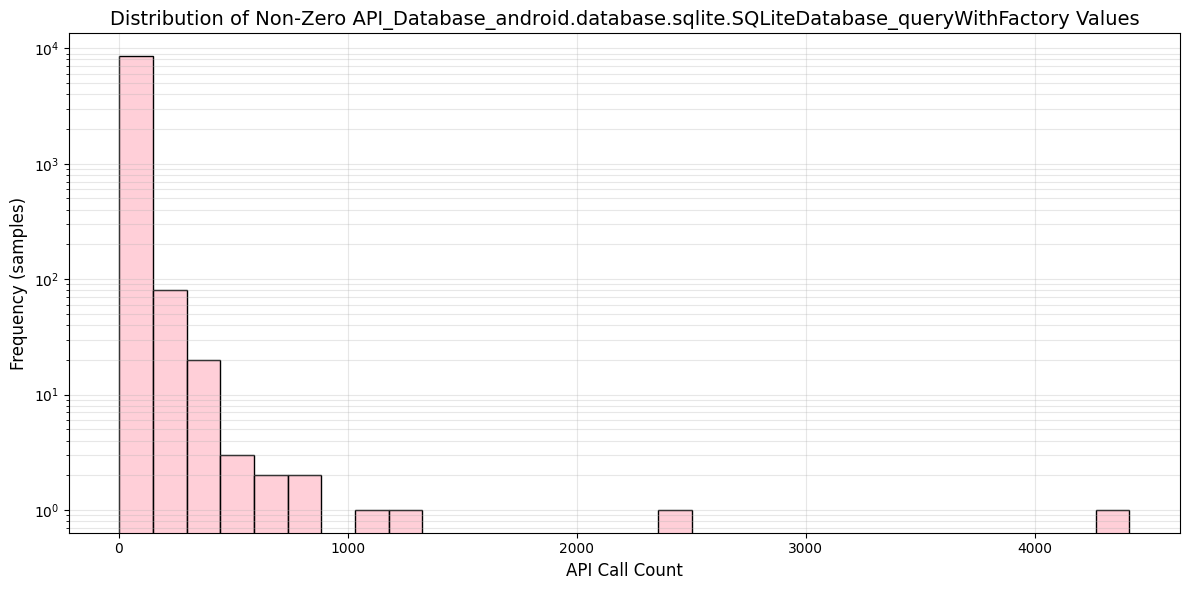

In [176]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Database_android.database.sqlite.SQLiteDatabase_queryWithFactory"] > 0]
sns.histplot(nonzero_samples["API_Database_android.database.sqlite.SQLiteDatabase_queryWithFactory"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Database_android.database.sqlite.SQLiteDatabase_queryWithFactory"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()

These distributions are very similar, there is only a noticeable difference mainly aroung 600 to 900 calls. Both APIs follow a highly right-skewed distribution. 

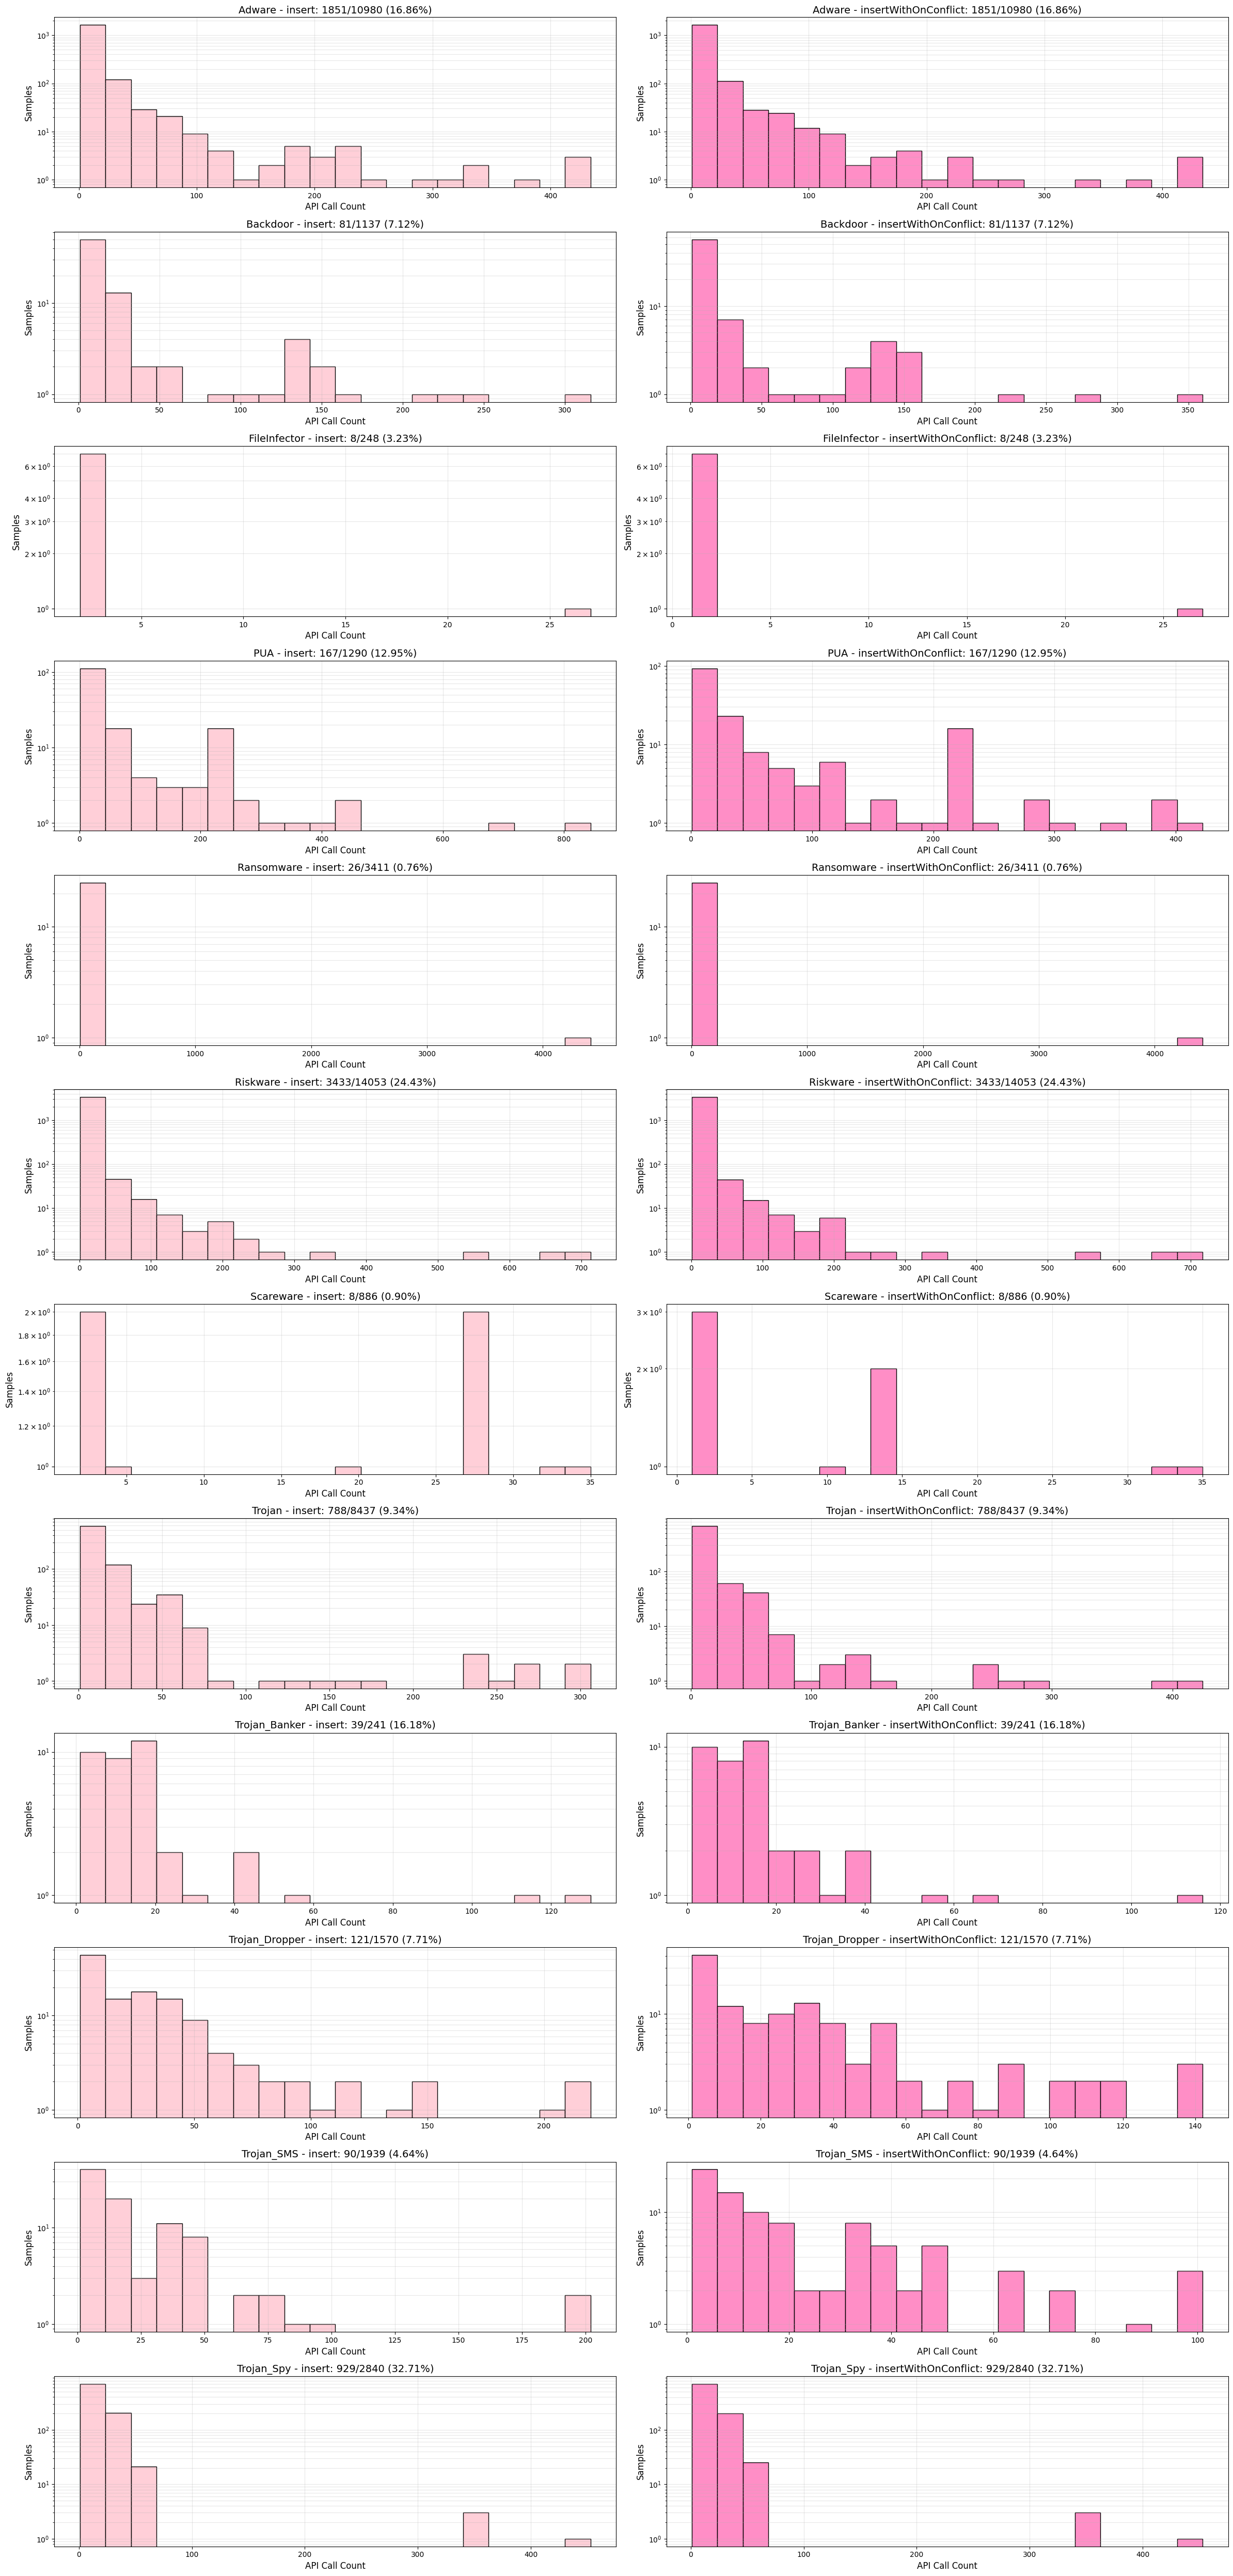

In [178]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]

feature_1 = "API_Database_android.database.sqlite.SQLiteDatabase_query"
feature_2 = "API_Database_android.database.sqlite.SQLiteDatabase_queryWithFactory"

# Set up grid: 12 categories, 2 columns per category → total 24 plots (12 rows, 2 columns)
plt.figure(figsize=(24, 50))  # Adjust size to fit all plots clearly

for i, category in enumerate(top_categories):
    # Get full count for current category
    category_mask = default_pipeline.EDA.dataset['Category'] == category
    total_category_count = category_mask.sum()
    
    # --- Feature 1: insert ---
    cat_data_1 = default_pipeline.EDA.dataset[
        category_mask & (default_pipeline.EDA.dataset[feature_1] > 0)
    ]
    count_1 = len(cat_data_1)
    percent_1 = (count_1 / total_category_count) * 100

    plt.subplot(len(top_categories), 2, 2*i + 1)
    sns.histplot(cat_data_1[feature_1], bins=20, color='pink')
    plt.title(f"{category} - insert: {count_1}/{total_category_count} ({percent_1:.2f}%)", fontsize=14)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Samples", fontsize=12)
    plt.yscale("log")
    plt.grid(alpha=0.3,which='both')

    # --- Feature 2: insertWithOnConflict ---
    cat_data_2 = default_pipeline.EDA.dataset[
        category_mask & (default_pipeline.EDA.dataset[feature_2] > 0)
    ]
    count_2 = len(cat_data_2)
    percent_2 = (count_2 / total_category_count) * 100

    plt.subplot(len(top_categories), 2, 2*i + 2)
    sns.histplot(cat_data_2[feature_2], bins=20, color='hotpink')
    plt.title(f"{category} - insertWithOnConflict: {count_2}/{total_category_count} ({percent_2:.2f}%)", fontsize=14)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Samples", fontsize=12)
    plt.yscale("log")
    plt.grid(alpha=0.3,which='both')

plt.tight_layout()
plt.show()


When visualizing the APIs call counts by categories, the small differences become a little bit more noticeable. However, Trojan_Spy, Ransomware, Riskware and FileInfector, still appear to be the same in both features. To quantify the differences we will compute the mean for both features and calculate the absolute difference.

In [ ]:
# Group by 'Category' and compute the mean for both features
grouped = df.groupby('Category')[[feature_1, feature_2]].mean()

# Calculate the absolute difference
grouped['Difference'] = (grouped[feature_1] - grouped[feature_2]).abs()

# Filter to only show categories where the features differ
different_categories = grouped[grouped['Difference'] > 0]

# Display result
print(different_categories)


                API_Database_android.database.sqlite.SQLiteDatabase_query  \
Category                                                                    
Adware                                                   2.051457           
Backdoor                                                 2.787159           
FileInfector                                             0.165323           
No_Category                                              6.051242           
PUA                                                      9.266667           
Ransomware                                               1.714746           
Riskware                                                 1.509856           
Scareware                                                0.171558           
Trojan                                                   1.515586           
Trojan_Banker                                            3.290456           
Trojan_Dropper                                           2.712102           

While the overall means across categories are very close, the difference column reveals subtle but maybe important differences in usage.

Most categories differ by less than 0.1 calls on average, suggesting the two APIs are often used interchangeably across the majority of samples. But PUA stands out with a difference of 1.43 more query calls than queryWithFactory on average, indicating that this group prefers the simpler query method.

Trojan_Banker and Trojan_Dropper also show moderate differences of around 0.3.

In categories like FileInfector, Scareware, and Ransomware the differences are almost none, which means that both are pretty much used in the same way. 



So, for most models, especially linear ones (like Logistic Regression, SVM) or neural networks, dropping one will help reduce redundancy and avoid multicollinearity. Since SQLiteDatabase_query has higher values than queryWithFactory, the latter could be dropped. A new feature, like the total query, could be another option to consider.

For tree-based models, which can handle correlated features, both can be kept.

#### SQLiteDatabase_rawQuery and SQLiteDatabase_rawQueryWithFactory

In [58]:
df['API_Database_android.database.sqlite.SQLiteDatabase_rawQuery'].describe()

count    53439.000000
mean        12.126743
std         37.087976
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        879.000000
Name: API_Database_android.database.sqlite.SQLiteDatabase_rawQuery, dtype: float64

The rawQuery API usage distribution suggest rare but sometimes intensive database querying activity across samples.

The mean is just over 12 calls per sample, but with a high standard deviation (~37), and a median of 0, indicating that most samples don’t use it, while a few call it frequently (up to 879 times).

In [59]:
df['API_Database_android.database.sqlite.SQLiteDatabase_rawQueryWithFactory'].describe()

count    53439.000000
mean        20.338068
std         66.936079
min          0.000000
25%          0.000000
50%          0.000000
75%         10.000000
max       4414.000000
Name: API_Database_android.database.sqlite.SQLiteDatabase_rawQueryWithFactory, dtype: float64

rawQueryWithFactory shows a similar trend, though more extreme. It has a higher mean (~20), an even larger standard deviation (~67), and a max value of 4414 calls, reflecting rare but very high-volume usage in specific samples.

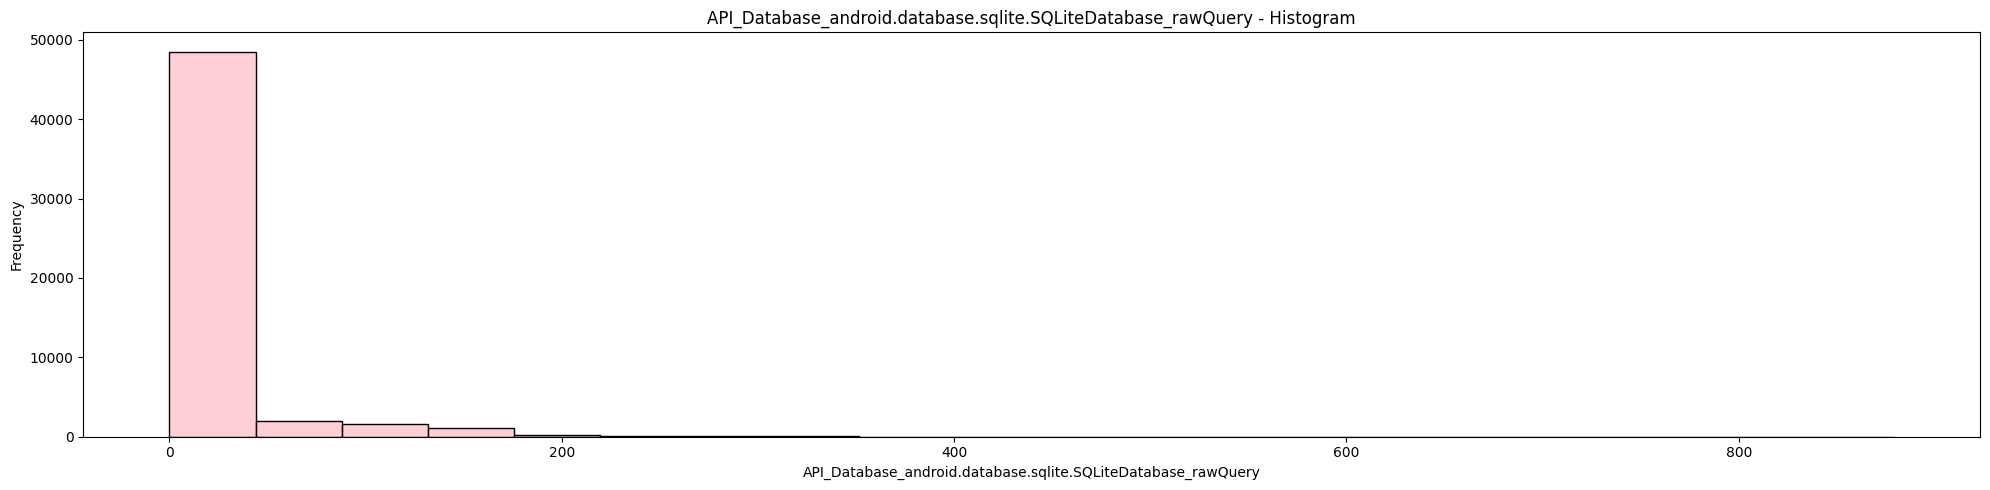

In [60]:
default_pipeline.EDA.plot_histograms(features=["API_Database_android.database.sqlite.SQLiteDatabase_rawQuery"], n_cols=1, bins=20)

This histogram shows a strong right skew for the SQLiteDatabase_rawQuery API, with the majority of samples (~50,000) making zero calls, and a long tail of sparse high-call outliers. To better explore actual usage patterns, we will replot the data excluding these zero values.

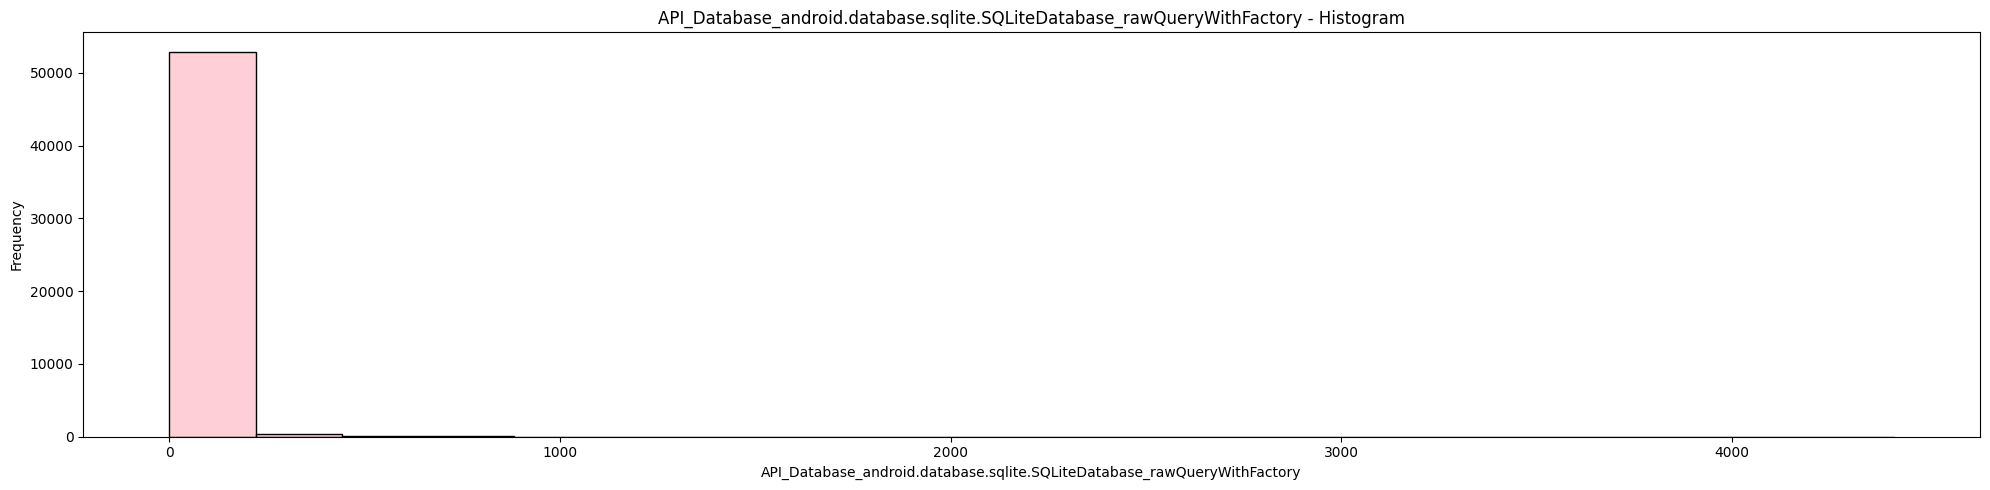

In [129]:
default_pipeline.EDA.plot_histograms(features=["API_Database_android.database.sqlite.SQLiteDatabase_rawQueryWithFactory"], n_cols=1, bins=20)

This histogram shows a strong right skew for the SQLiteDatabase_rawQueryWithFactory API, with the vast majority of samples (~50,000) never calling it, and a sparse trail of high-call outliers. To better explore actual usage patterns, we will replot the data excluding these zero values.

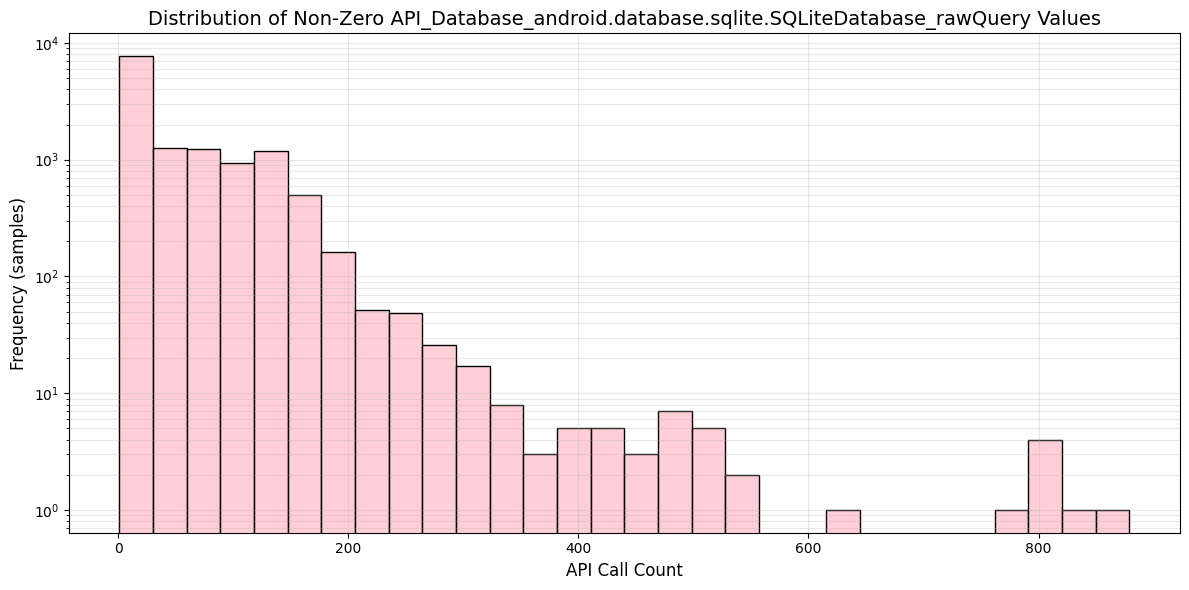

In [128]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Database_android.database.sqlite.SQLiteDatabase_rawQuery"] > 0]
sns.histplot(nonzero_samples["API_Database_android.database.sqlite.SQLiteDatabase_rawQuery"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Database_android.database.sqlite.SQLiteDatabase_rawQuery"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3,which='both')
plt.tight_layout()
plt.show()

This histogram reveals a gradual drop-off in non-zero call frequencies for the SQLiteDatabase_rawQuery API, with most samples concentrated under 200 calls but a long tail extending past 800, indicating a mix of lightweight and intensive database access patterns across malware types.

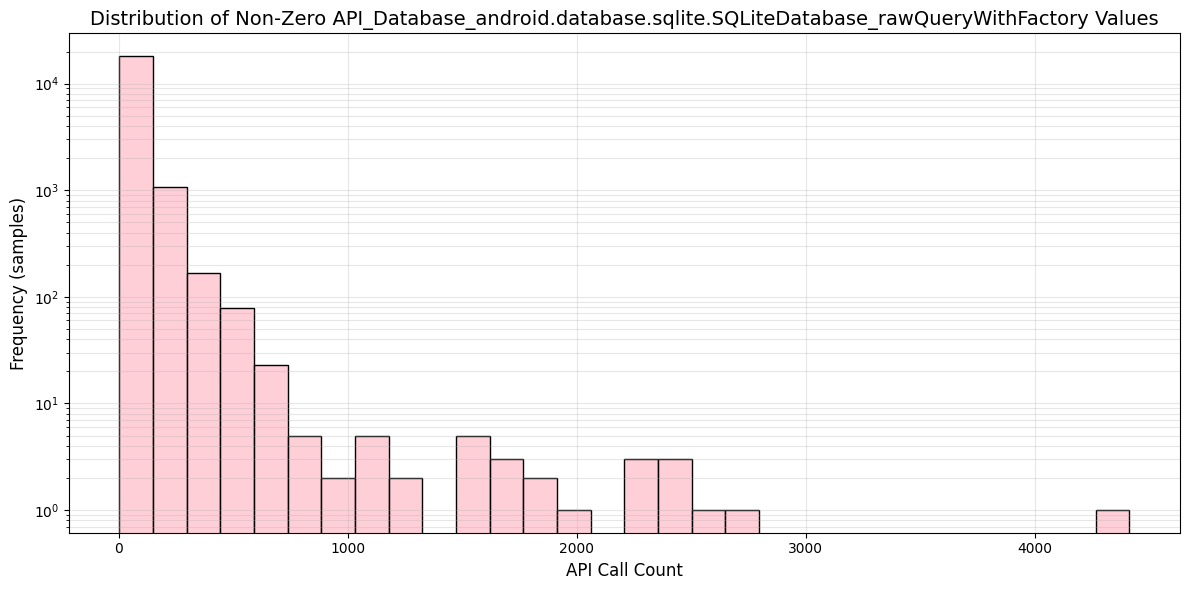

In [127]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Database_android.database.sqlite.SQLiteDatabase_rawQueryWithFactory"] > 0]
sns.histplot(nonzero_samples["API_Database_android.database.sqlite.SQLiteDatabase_rawQueryWithFactory"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Database_android.database.sqlite.SQLiteDatabase_rawQueryWithFactory"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3,which='both')
plt.tight_layout()
plt.show()

This histogram shows a steep right skew in the non-zero usage of the SQLiteDatabase_rawQueryWithFactory API, with most samples falling below 500 calls but a sparse set of extreme outliers reaching well beyond 4000, suggesting that while most use is modest, certain samples perform intensive or repeated database interactions.

In [126]:
df.groupby('Category')['API_Database_android.database.sqlite.SQLiteDatabase_rawQuery'].describe()

count       mean        std  min  25%  50%   75%    max
Category                                                                 
Adware          10980.0  14.095993  35.139342  0.0  0.0  0.0   5.0  815.0
Backdoor         1137.0   8.307828  27.957435  0.0  0.0  0.0  10.0  305.0
FileInfector      248.0   0.814516   6.579156  0.0  0.0  0.0   0.0   94.0
No_Category      1932.0   3.960145  19.384655  0.0  0.0  0.0   0.0  331.0
PUA              1290.0   3.034884  17.648086  0.0  0.0  0.0   0.0  346.0
Ransomware       3411.0   3.038405  42.654824  0.0  0.0  0.0   0.0  879.0
Riskware        14053.0  26.728243  53.338103  0.0  0.0  0.0  16.0  317.0
Scareware         886.0   0.328442   5.397993  0.0  0.0  0.0   0.0  130.0
Trojan           8437.0   3.809055  14.768345  0.0  0.0  0.0   2.0  538.0
Trojan_Banker     241.0   0.298755   1.906666  0.0  0.0  0.0   0.0   20.0
Trojan_Dropper   1570.0   3.582803  10.741583  0.0  0.0  0.0   0.0  112.0
Trojan_SMS       1939.0   0.578649   5.030185  0.0  0.0  0.0   0.0  113.0
Trojan_Spy       2840.0   0.258803   4.972229  0.0  0.0  0.0   0.0  143.0
Zero_Day         4475.0  10.300559  31.506386  0.0  0.0  0.0   3.0  625.0

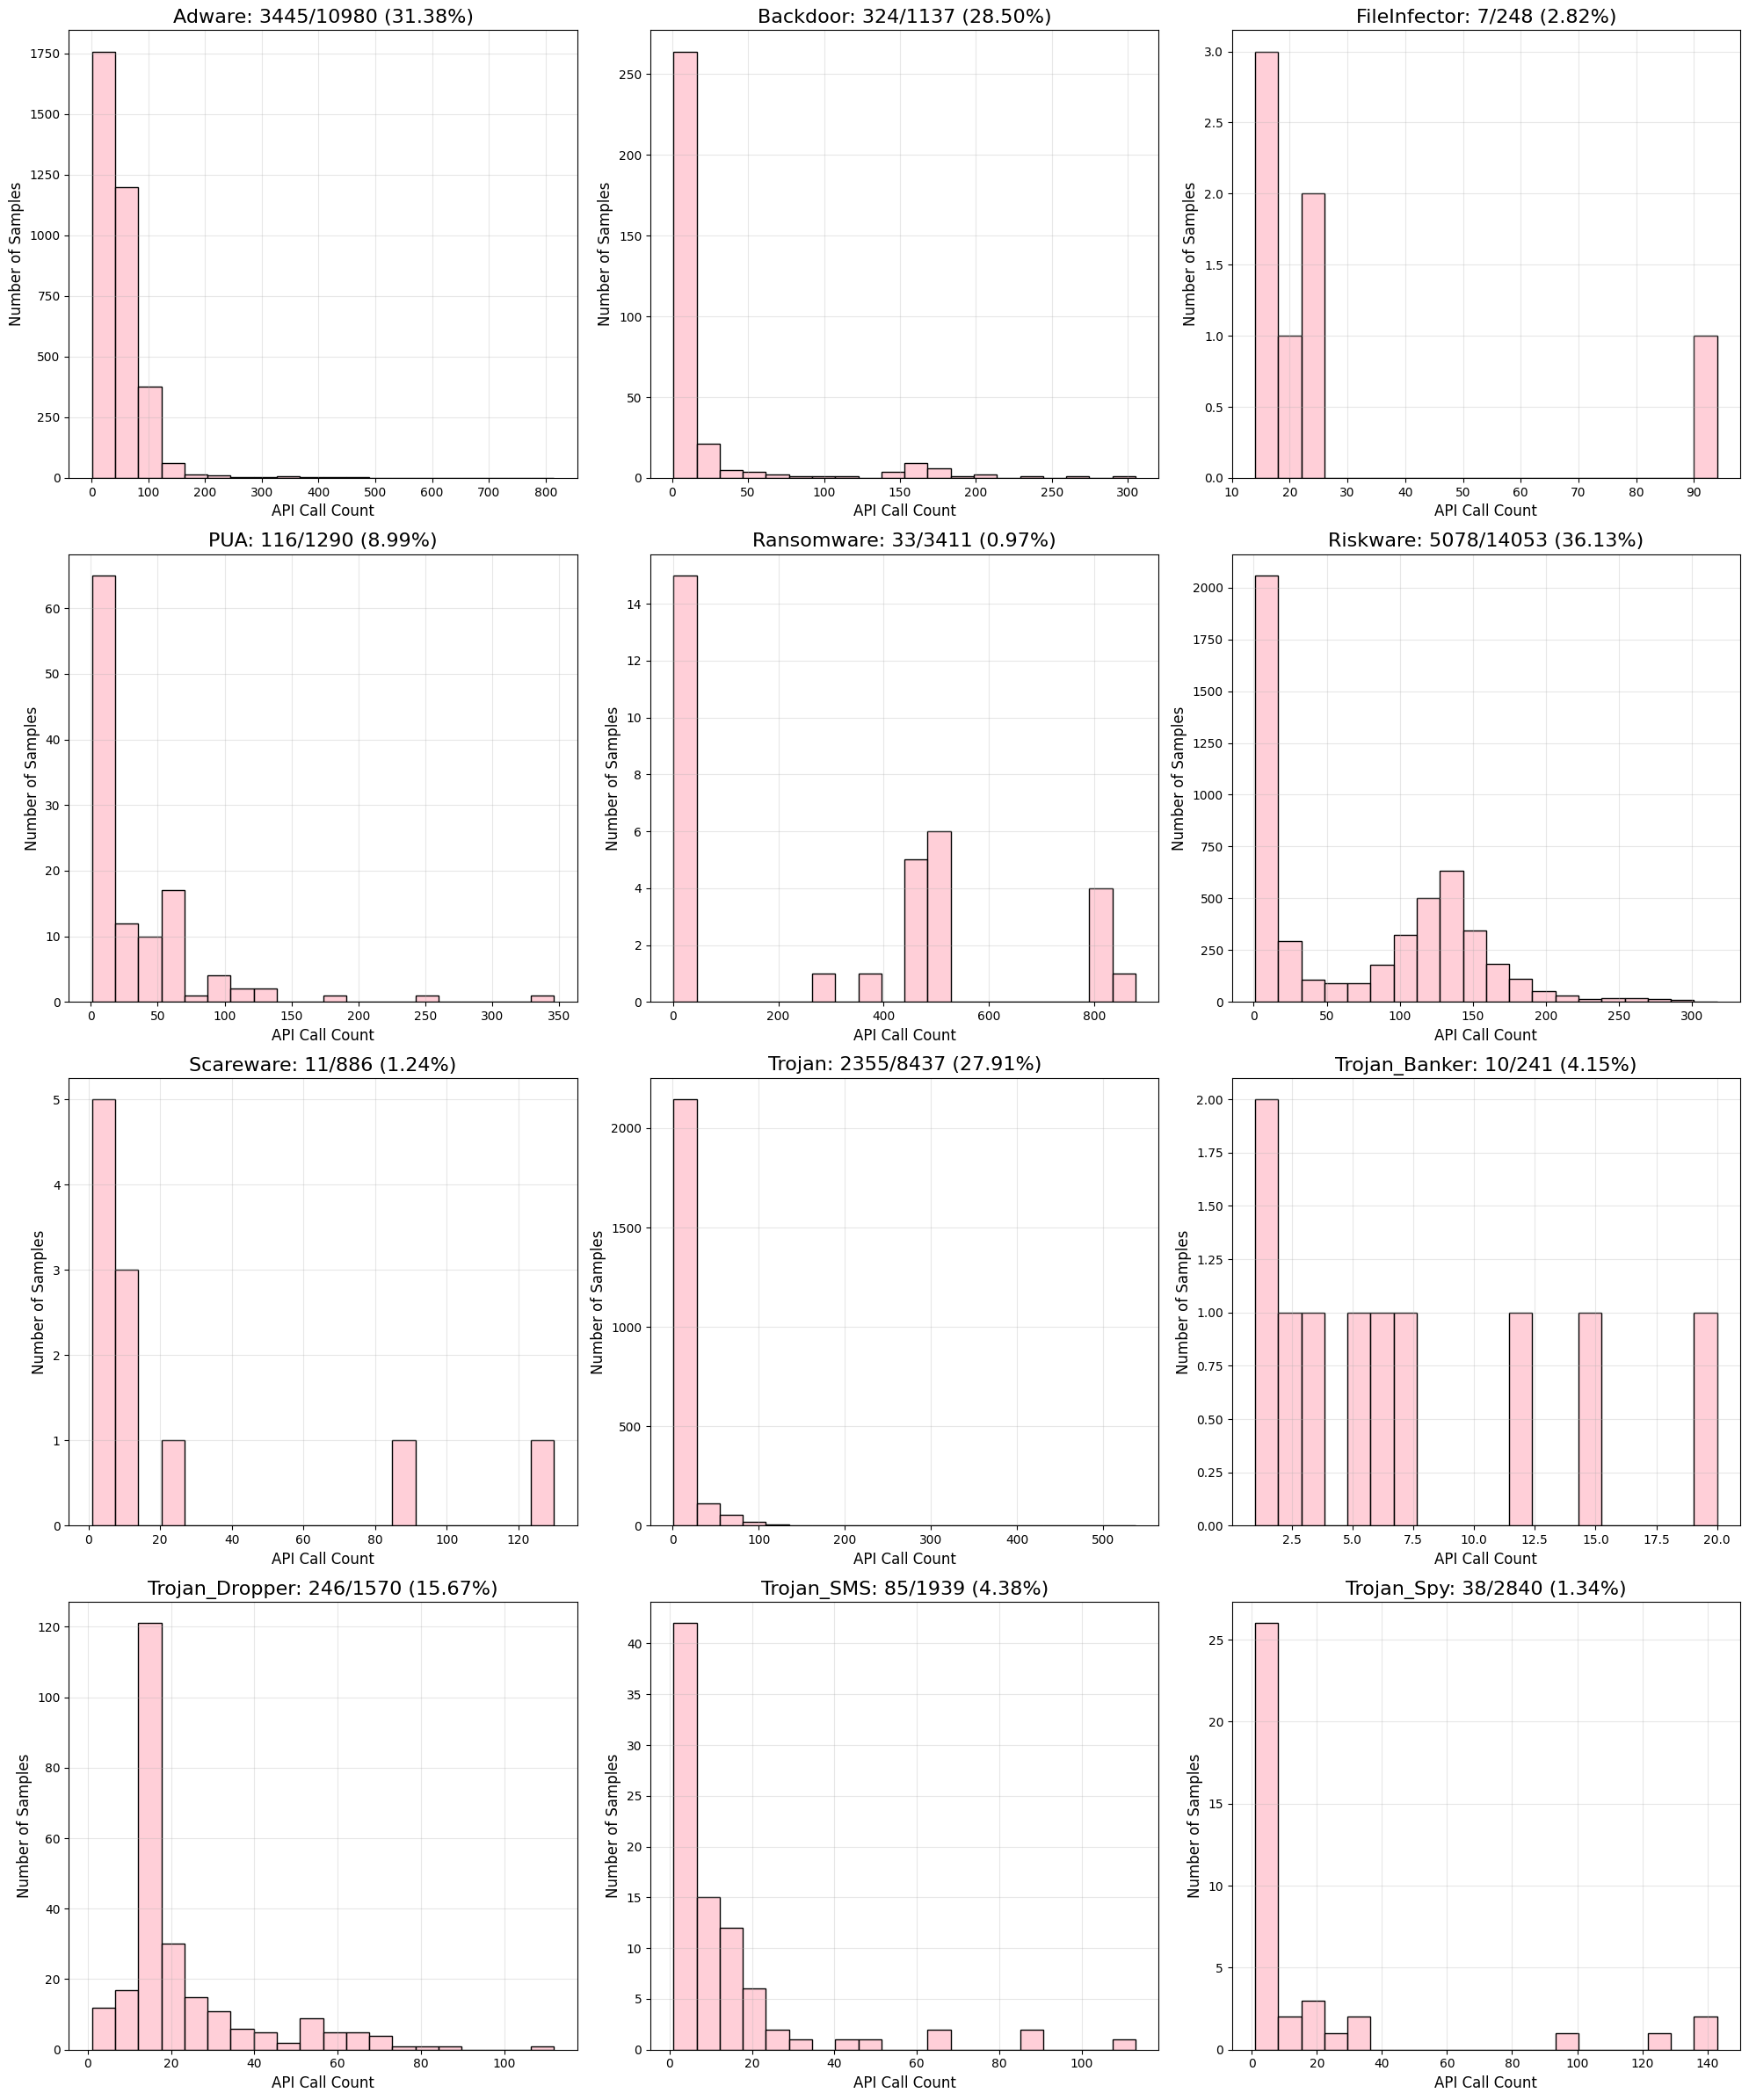

In [64]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]

api_feature = "API_Database_android.database.sqlite.SQLiteDatabase_rawQuery"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Riskware, Adware, and Zero_Day show the highest average usage of the SQLiteDatabase_rawQuery API, suggesting these families may frequently query local databases, while most other categories, including Trojan_SMS, Trojan_Spy, and Trojan_Banker, show minimal to near-zero interaction, indicating limited database access behavior in those samples.

In [125]:
df.groupby('Category')['API_Database_android.database.sqlite.SQLiteDatabase_rawQueryWithFactory'].describe()

count       mean         std  min  25%  50%   75%     max
Category                                                                   
Adware          10980.0  17.100091   50.135718  0.0  0.0  0.0  10.0  2493.0
Backdoor         1137.0  11.357960   35.343054  0.0  0.0  0.0  15.0   360.0
FileInfector      248.0   2.270161   12.367991  0.0  0.0  0.0   0.0   164.0
No_Category      1932.0  11.670807   76.151028  0.0  0.0  0.0   0.0  2387.0
PUA              1290.0  12.246512   49.884814  0.0  0.0  0.0   0.0   675.0
Ransomware       3411.0  11.246555  156.871299  0.0  0.0  0.0   0.0  4414.0
Riskware        14053.0  35.568633   72.176207  0.0  0.0  1.0  19.0  1034.0
Scareware         886.0   0.452596    5.676546  0.0  0.0  0.0   0.0   130.0
Trojan           8437.0  21.909091   38.225035  0.0  0.0  0.0  47.0  1528.0
Trojan_Banker     241.0   3.676349   12.067649  0.0  0.0  0.0   0.0   116.0
Trojan_Dropper   1570.0   5.984076   17.310286  0.0  0.0  0.0   0.0   174.0
Trojan_SMS       1939.0   1.693657   10.230421  0.0  0.0  0.0   0.0   186.0
Trojan_Spy       2840.0   5.163732   18.020172  0.0  0.0  0.0   3.0   453.0
Zero_Day         4475.0  21.358212   64.669285  0.0  0.0  0.0  11.0  1138.0

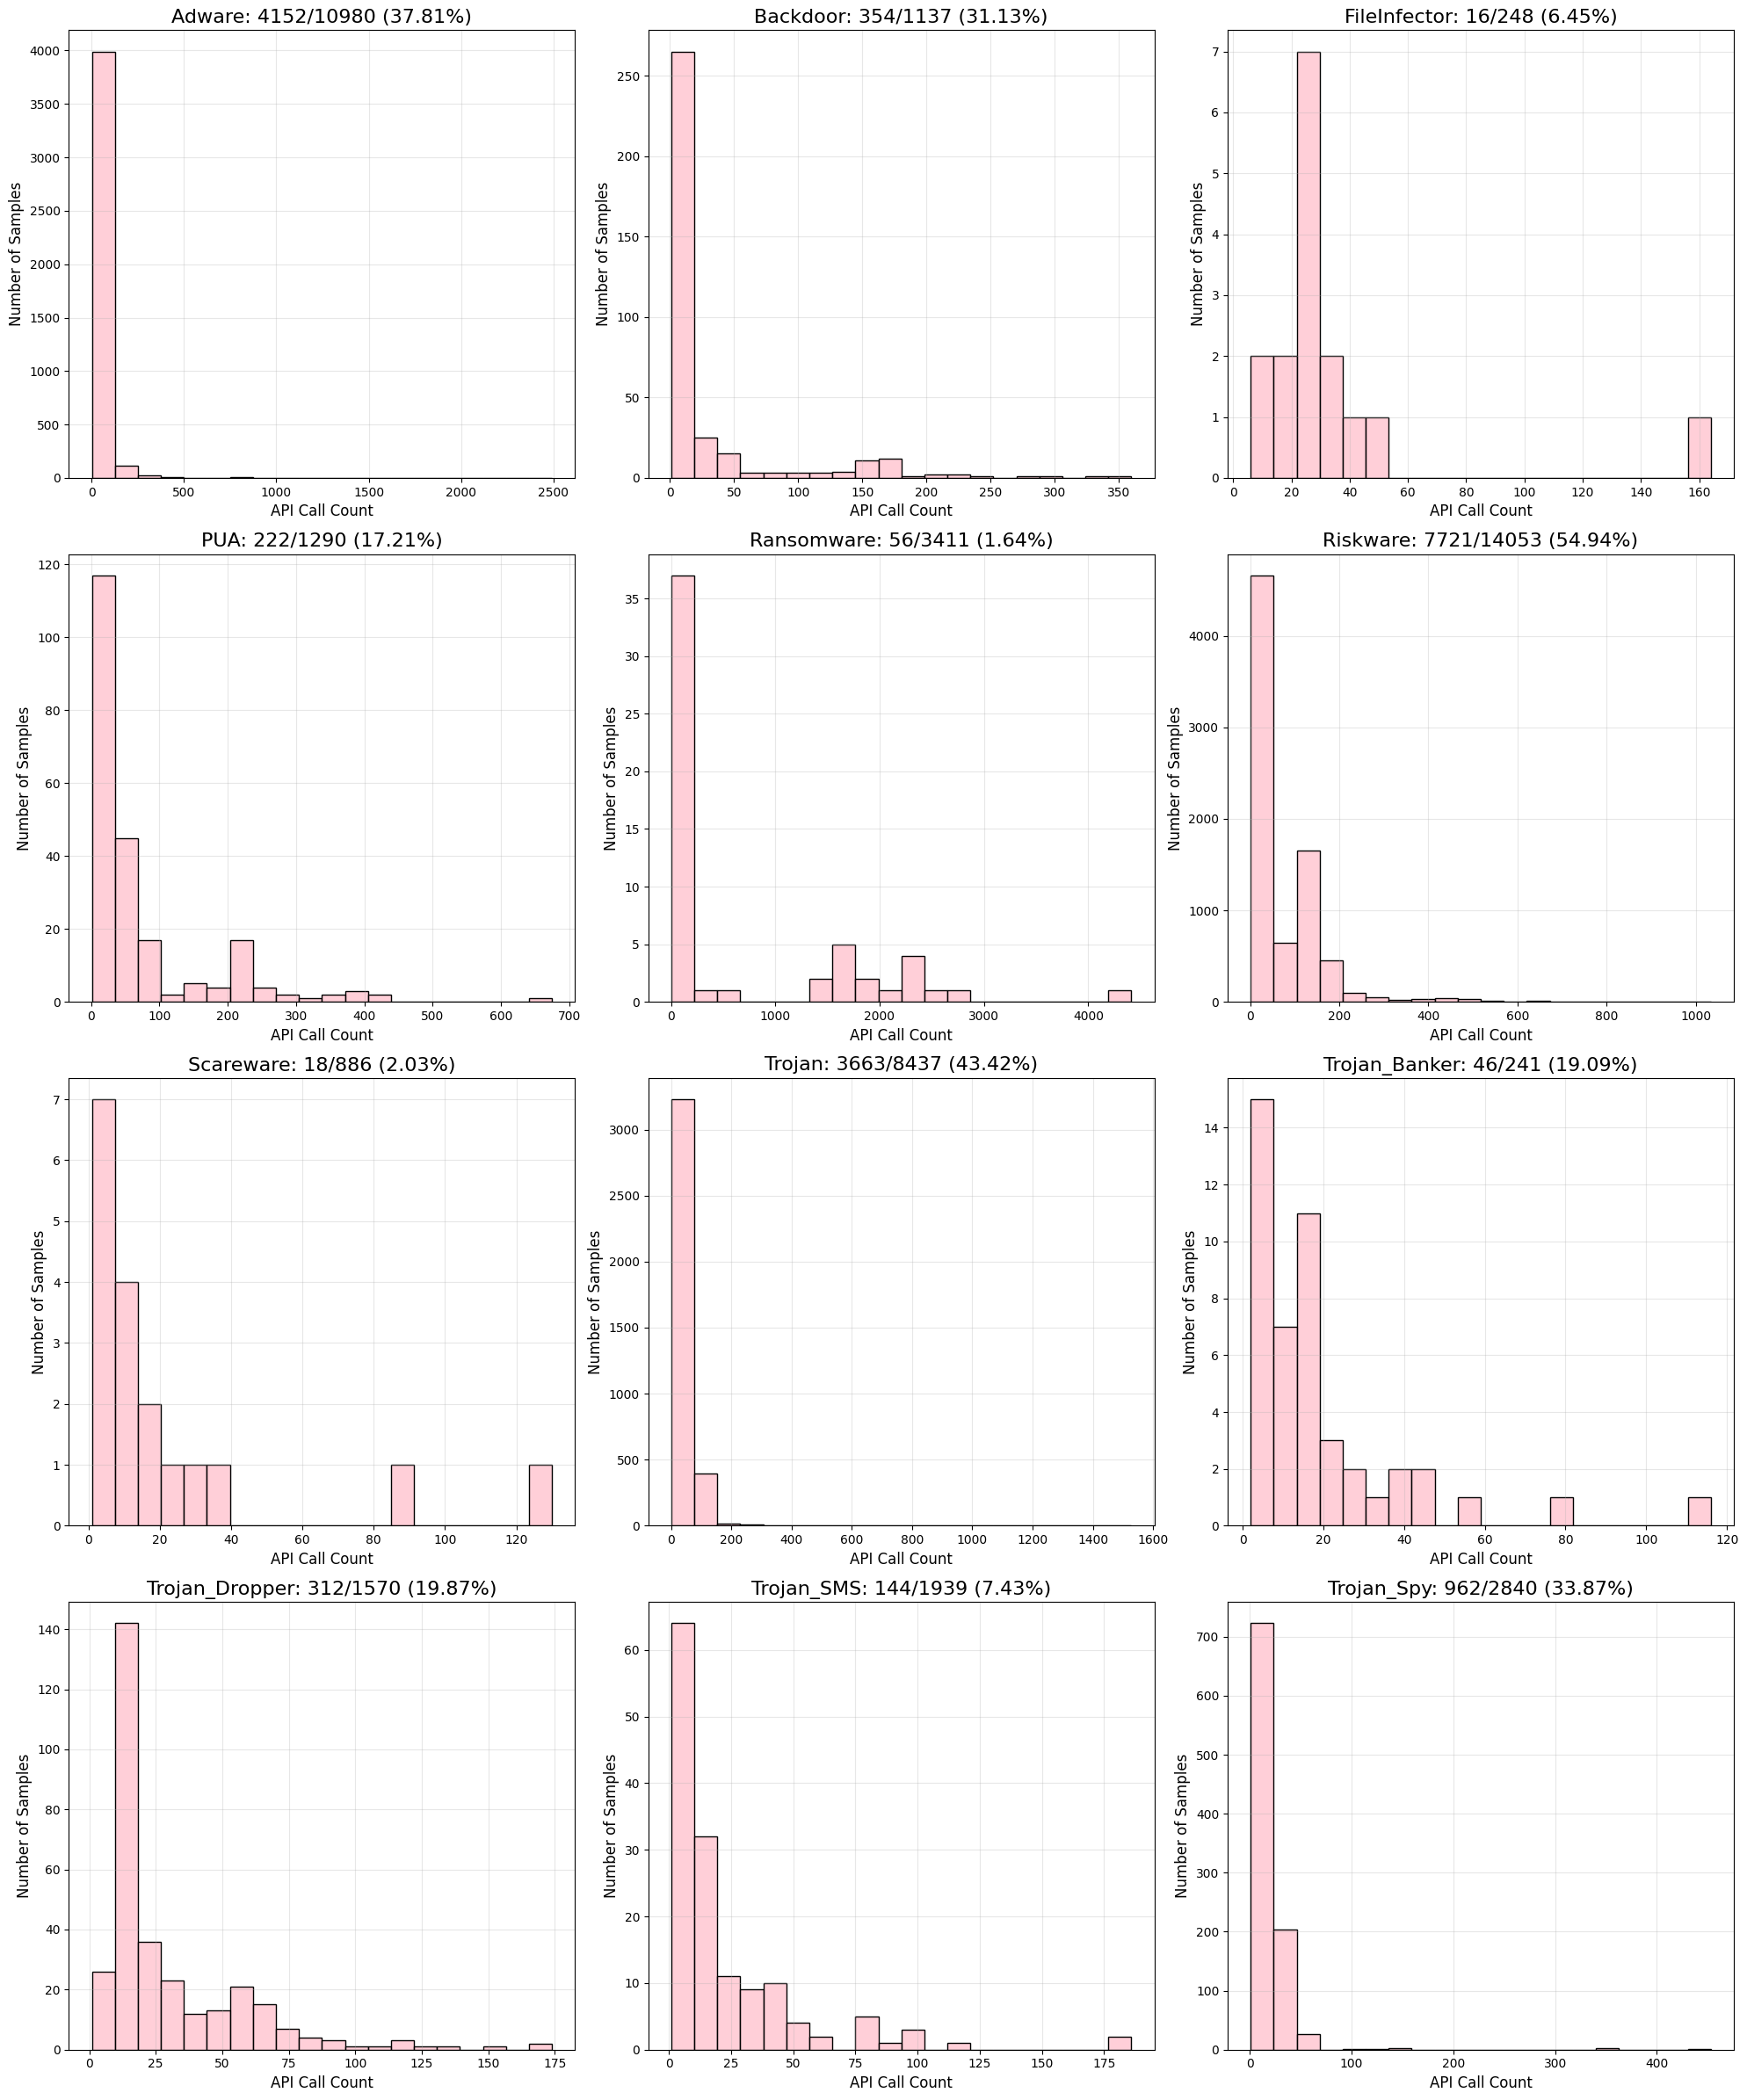

In [65]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]

api_feature = "API_Database_android.database.sqlite.SQLiteDatabase_rawQueryWithFactory"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Riskware, Zero_Day, and Trojan exhibit the highest mean usage of the SQLiteDatabase_rawQueryWithFactory API, indicating frequent and possibly complex database queries, while most other families, including Scareware, Trojan_SMS, and FileInfector, show minimal to negligible usage, reinforcing this API’s relevance for only a subset of more data-intensive malware types.

#### SQLiteDatabase_update and SQLiteDatabase_updateWithOnConflict

In [43]:
df['API_Database_android.database.sqlite.SQLiteDatabase_update'].describe()

count    53439.000000
mean         1.020547
std         13.708362
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2297.000000
Name: API_Database_android.database.sqlite.SQLiteDatabase_update, dtype: float64

The SQLiteDatabase_update API shows highly sparse usage across the dataset, with most samples never calling it. 

In [42]:
df['API_Database_android.database.sqlite.SQLiteDatabase_updateWithOnConflict'].describe()

count    53439.000000
mean         2.059376
std         63.368568
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       6322.000000
Name: API_Database_android.database.sqlite.SQLiteDatabase_updateWithOnConflict, dtype: float64

SQLiteDatabase_updateWithOnConflict API also shows highly sparse usage across the dataset, with most samples never calling it, but it exhibits a slightly higher mean and a much longer tail (max = 6322), suggesting it may be used more heavily in specific, edge-case behaviors.

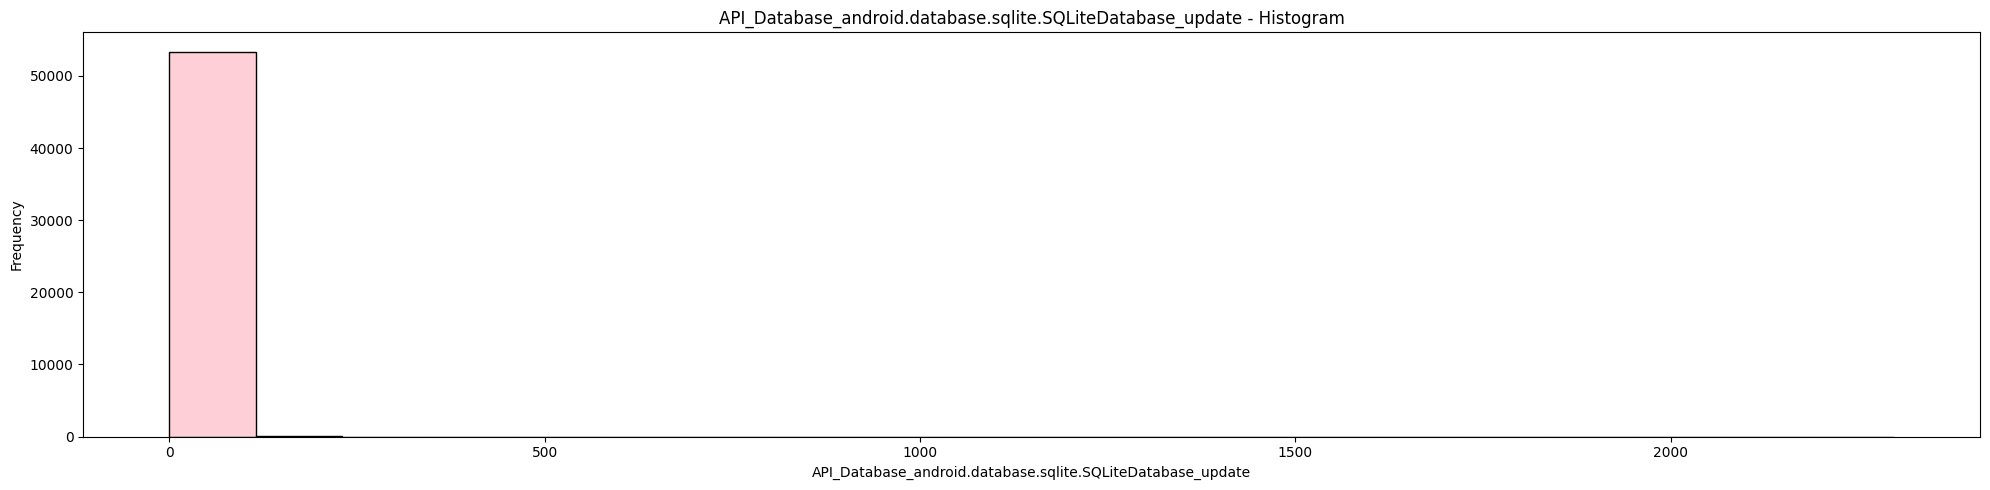

In [93]:
default_pipeline.EDA.plot_histograms(features=["API_Database_android.database.sqlite.SQLiteDatabase_update"], n_cols=1, bins=20)

This histogram shows a heavy right skew for the SQLiteDatabase_update API, with the overwhelming majority of samples never invoking it, and only a sparse set of outliers with higher call counts—suggesting this API is rarely used across the dataset. To better explore actual usage patterns, we will replot the data excluding these zero values.

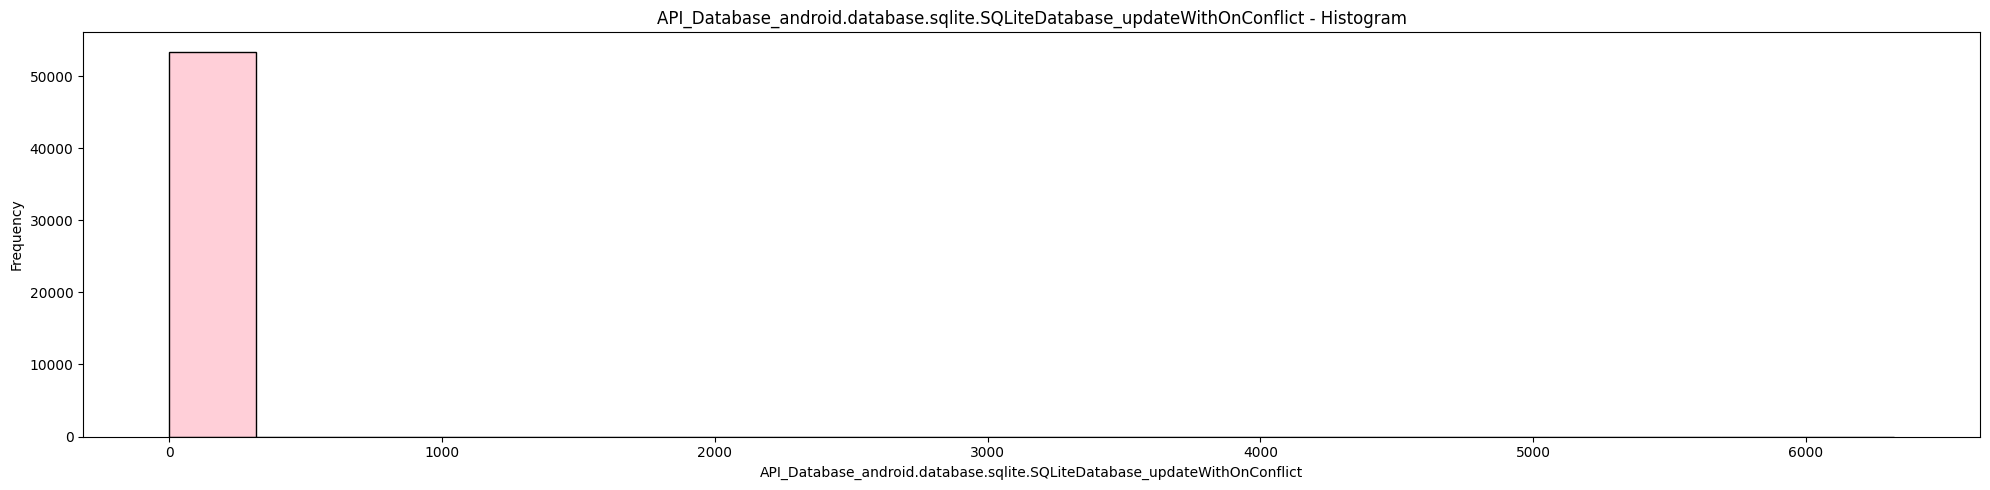

In [90]:
default_pipeline.EDA.plot_histograms(features=["API_Database_android.database.sqlite.SQLiteDatabase_updateWithOnConflict"], n_cols=1, bins=20)

This histogram shows a similar pattern to the previous one. SQLiteDatabase_updateWithOnConflict is rarely used, with nearly all samples making zero calls. A small number of outliers push the maximum up to over 6000 calls, creating a strong right skew and a long-tailed distribution. To better explore actual usage patterns, we will replot the data excluding these zero values.

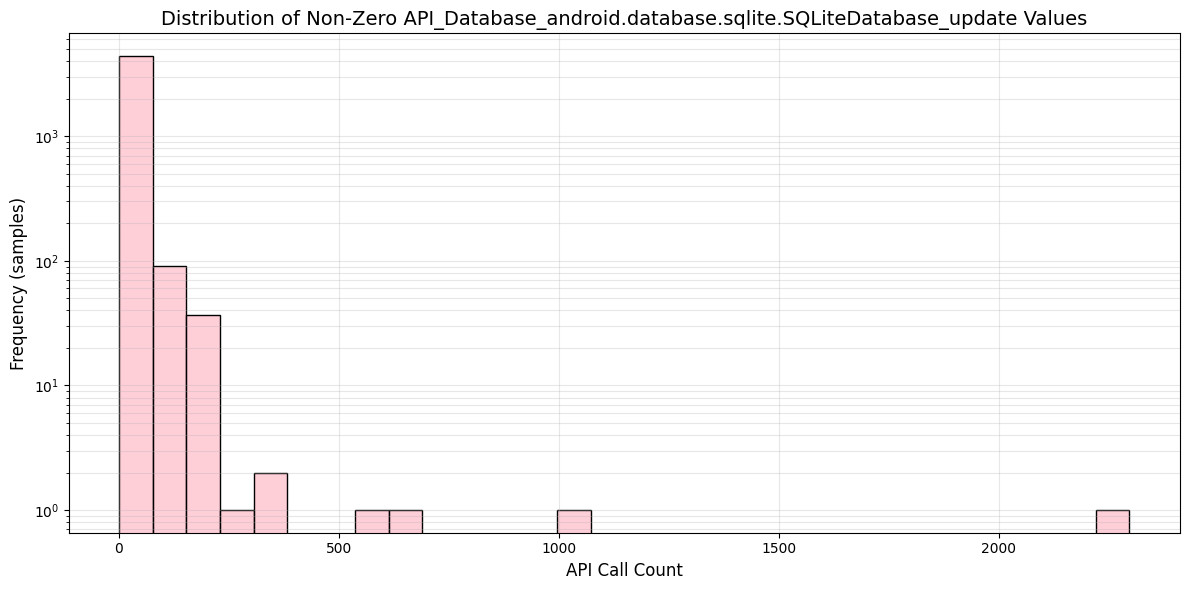

In [94]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Database_android.database.sqlite.SQLiteDatabase_update"] > 0]
sns.histplot(nonzero_samples["API_Database_android.database.sqlite.SQLiteDatabase_update"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Database_android.database.sqlite.SQLiteDatabase_update"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3,which='both')
plt.tight_layout()
plt.show()

This histogram shows a strong right skew in non-zero usage of the SQLiteDatabase_update API. Most samples cluster below 100 calls, but a sparse tail extends beyond 2000, indicating that while database updates are typically minimal, a few samples make extensive use of this functionality, possibly tied to bulk data manipulation or logging behaviors.

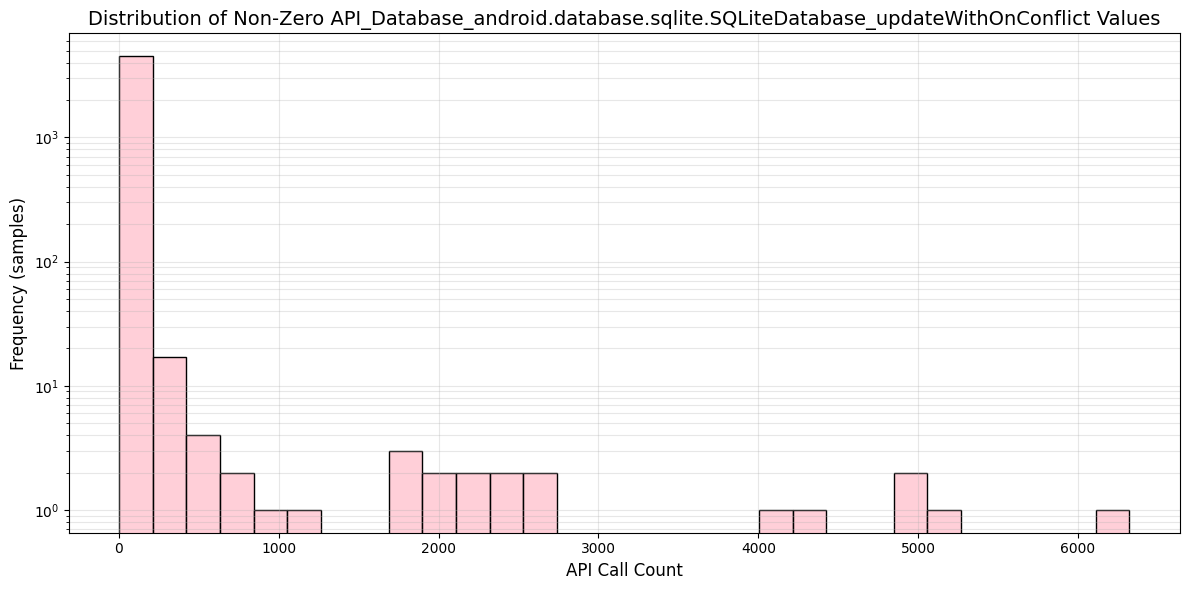

In [92]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Database_android.database.sqlite.SQLiteDatabase_updateWithOnConflict"] > 0]
sns.histplot(nonzero_samples["API_Database_android.database.sqlite.SQLiteDatabase_updateWithOnConflict"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Database_android.database.sqlite.SQLiteDatabase_updateWithOnConflict"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3,which='both')
plt.tight_layout()
plt.show()

The SQLiteDatabase_updateWithOnConflict API is rarely used, with nearly all samples making zero calls. Among the non-zero cases, call frequencies are highly variable, ranging from moderate values to extreme outliers beyond 6000 calls. This long-tailed distribution suggests that, when invoked, this API may support intense transactional operations or automated bulk updates under error-handling logic.

In [120]:
df.groupby('Category')['API_Database_android.database.sqlite.SQLiteDatabase_update'].describe()

count      mean        std  min  25%  50%  75%     max
Category                                                                
Adware          10980.0  0.619126  22.901750  0.0  0.0  0.0  0.0  2297.0
Backdoor         1137.0  1.716799  36.291596  0.0  0.0  0.0  0.0  1010.0
FileInfector      248.0  0.016129   0.254000  0.0  0.0  0.0  0.0     4.0
No_Category      1932.0  0.621118   6.273858  0.0  0.0  0.0  0.0   158.0
PUA              1290.0  0.852713  16.369711  0.0  0.0  0.0  0.0   560.0
Ransomware       3411.0  0.027558   0.367048  0.0  0.0  0.0  0.0    10.0
Riskware        14053.0  0.426884   5.153715  0.0  0.0  0.0  0.0   226.0
Scareware         886.0  0.020316   0.509386  0.0  0.0  0.0  0.0    15.0
Trojan           8437.0  2.203390   3.898836  0.0  0.0  0.0  6.0    55.0
Trojan_Banker     241.0  2.024896   7.014227  0.0  0.0  0.0  0.0    54.0
Trojan_Dropper   1570.0  0.277707   2.722205  0.0  0.0  0.0  0.0    54.0
Trojan_SMS       1939.0  0.060340   0.832127  0.0  0.0  0.0  0.0    21.0
Trojan_Spy       2840.0  0.787324   1.736168  0.0  0.0  0.0  0.0    14.0
Zero_Day         4475.0  3.464804  19.928421  0.0  0.0  0.0  0.0   231.0

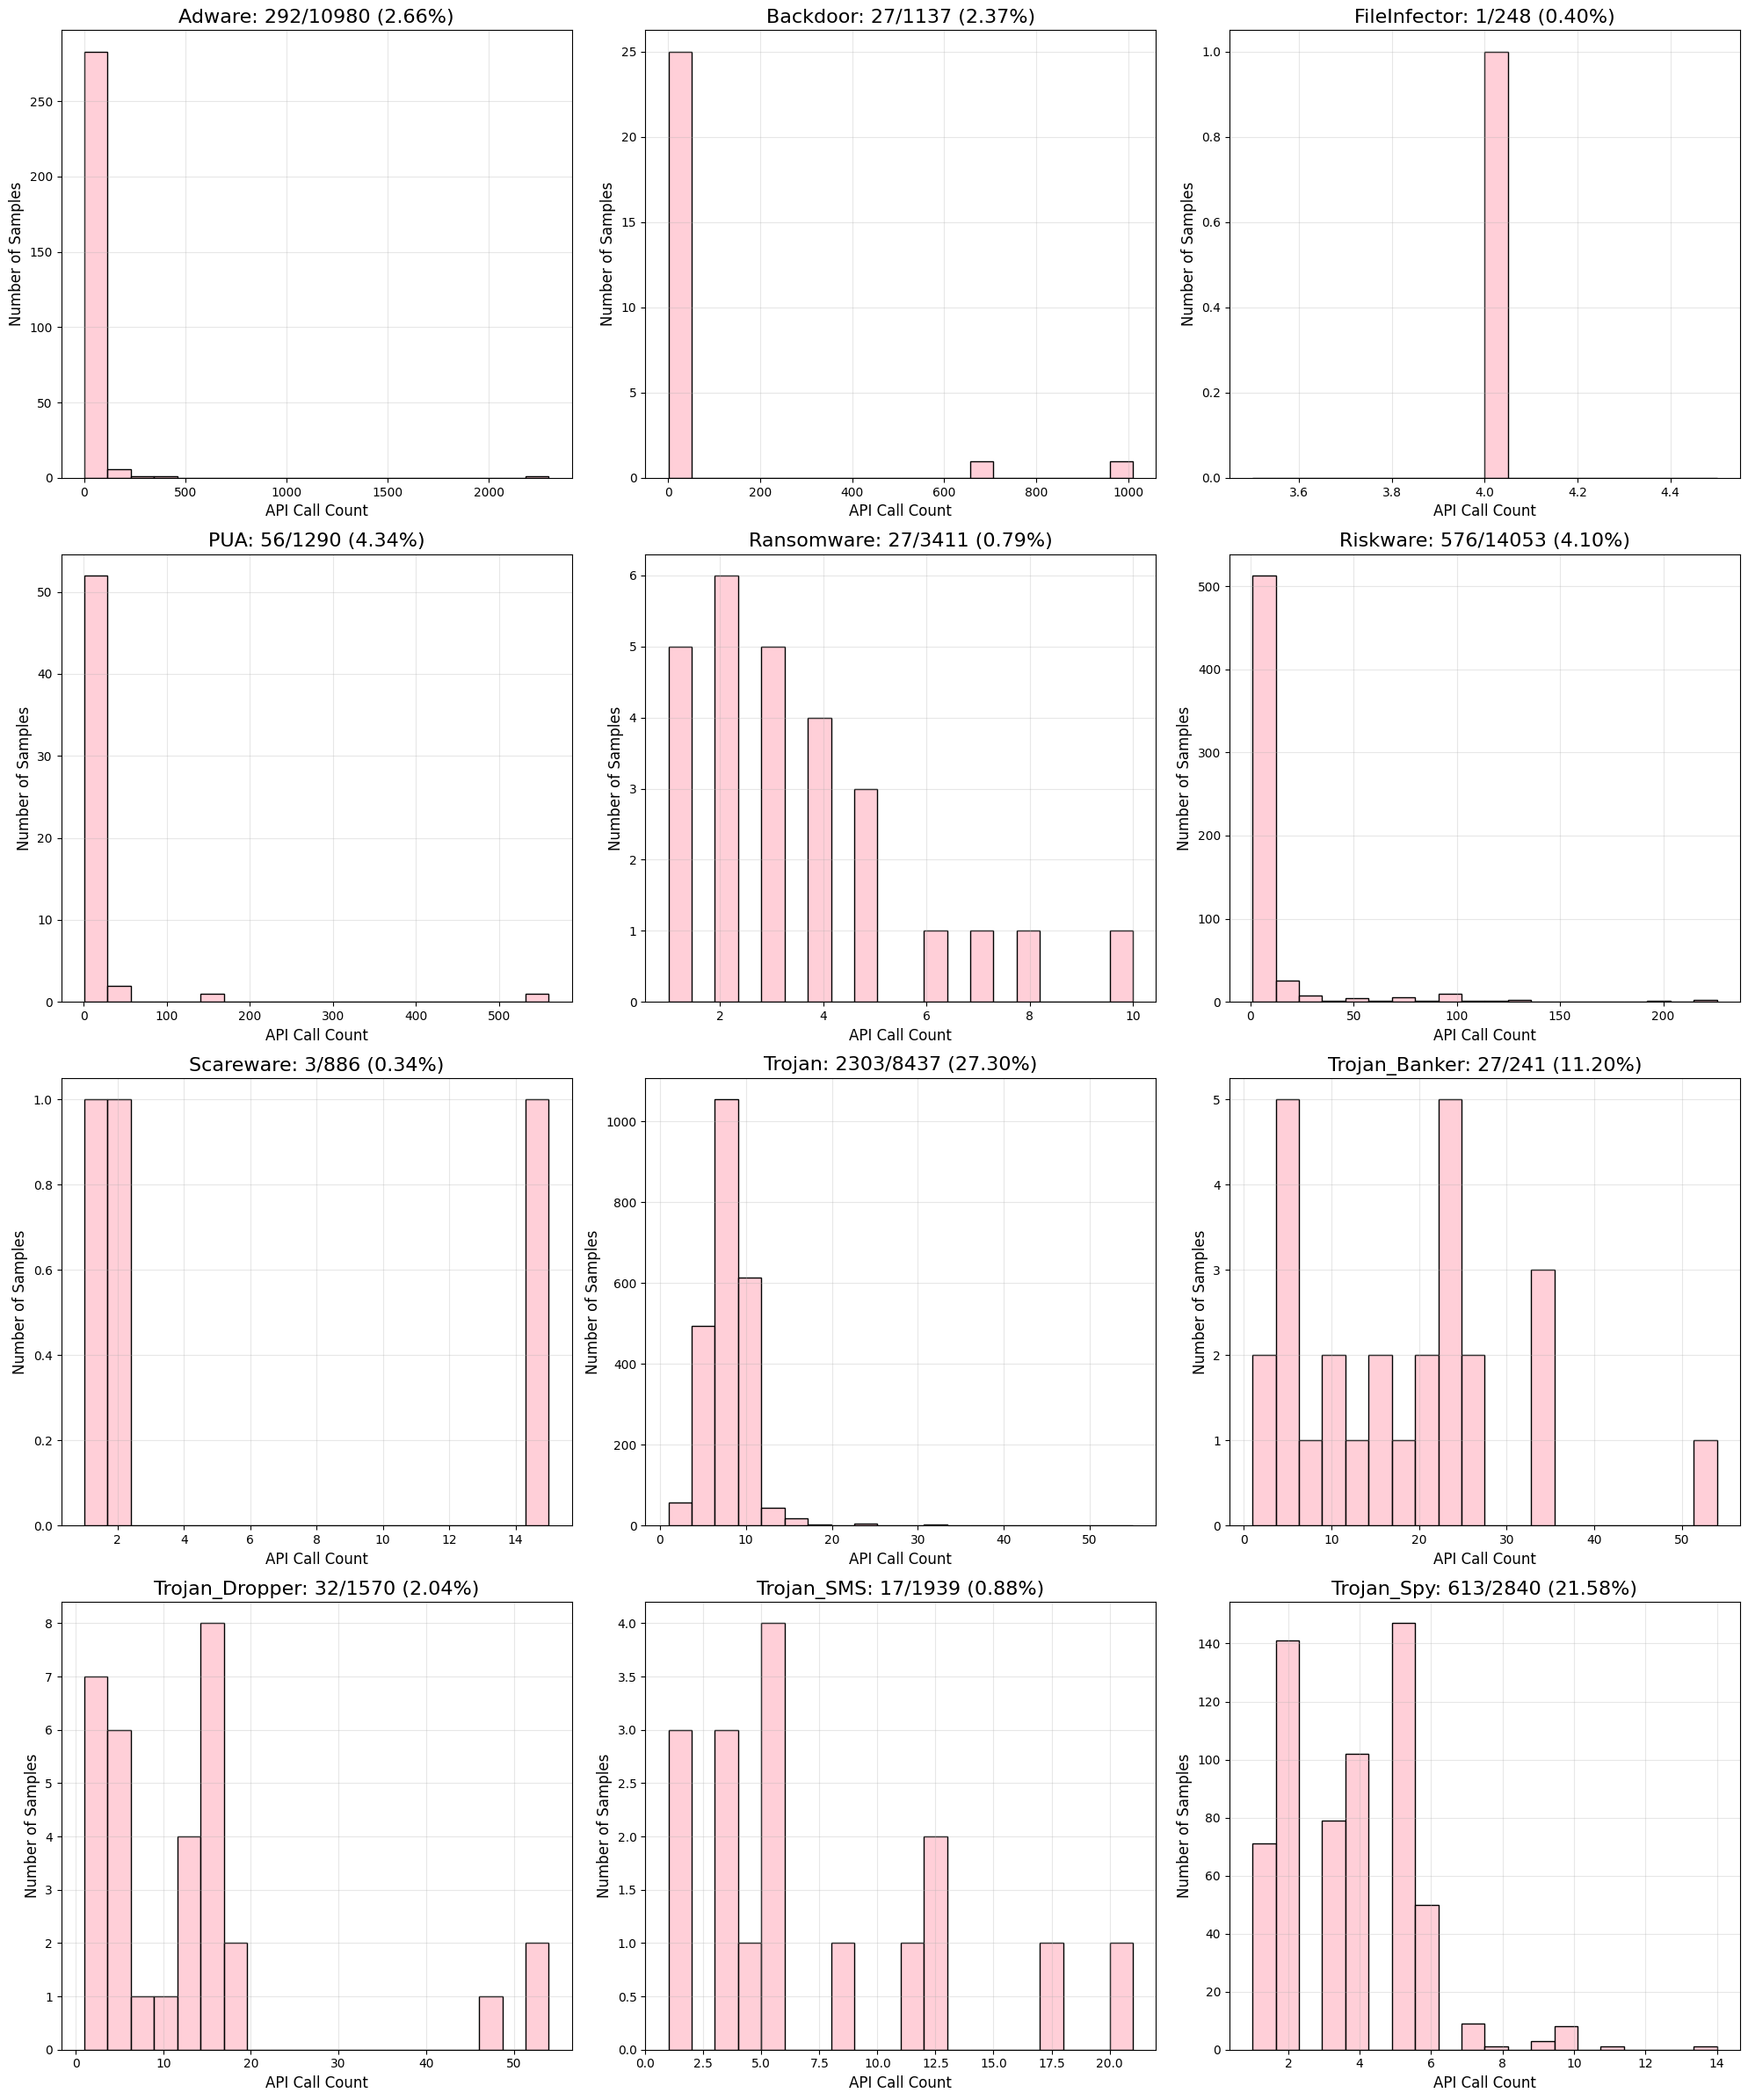

In [61]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]

api_feature = "API_Database_android.database.sqlite.SQLiteDatabase_update"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

The SQLiteDatabase_update API exhibits sparse usage across categories, with the majority of samples making zero calls. 

Trojan and Trojan_Banker show slightly higher average call counts (2.20 and 2.02), hinting at selective use during data manipulation or payload installation. 

Adware, PUA, and Zero_Day also show elevated max values, with a few extreme outliers (up to 2297 calls) likely linked to automated or persistent background operations. 

However, for most malware families, usage remains minimal, reinforcing this API’s limited role in common malicious workflows.

In [63]:
df.groupby('Category')['API_Database_android.database.sqlite.SQLiteDatabase_updateWithOnConflict'].describe()

count      mean         std  min  25%  50%  75%     max
Category                                                                 
Adware          10980.0  3.919217  113.645826  0.0  0.0  0.0  0.0  5095.0
Backdoor         1137.0  1.781003   36.357968  0.0  0.0  0.0  0.0  1010.0
FileInfector      248.0  0.016129    0.254000  0.0  0.0  0.0  0.0     4.0
No_Category      1932.0  1.436853   39.593829  0.0  0.0  0.0  0.0  1726.0
PUA              1290.0  8.583721  213.557694  0.0  0.0  0.0  0.0  6322.0
Ransomware       3411.0  0.036646    0.477782  0.0  0.0  0.0  0.0    14.0
Riskware        14053.0  0.488152    7.554844  0.0  0.0  0.0  0.0   575.0
Scareware         886.0  0.020316    0.509386  0.0  0.0  0.0  0.0    15.0
Trojan           8437.0  2.203627    3.900161  0.0  0.0  0.0  6.0    55.0
Trojan_Banker     241.0  2.024896    7.014227  0.0  0.0  0.0  0.0    54.0
Trojan_Dropper   1570.0  0.277707    2.722205  0.0  0.0  0.0  0.0    54.0
Trojan_SMS       1939.0  0.070139    1.009874  0.0  0.0  0.0  0.0    22.0
Trojan_Spy       2840.0  0.787324    1.736168  0.0  0.0  0.0  0.0    14.0
Zero_Day         4475.0  4.971844   43.078025  0.0  0.0  0.0  0.0  1823.0

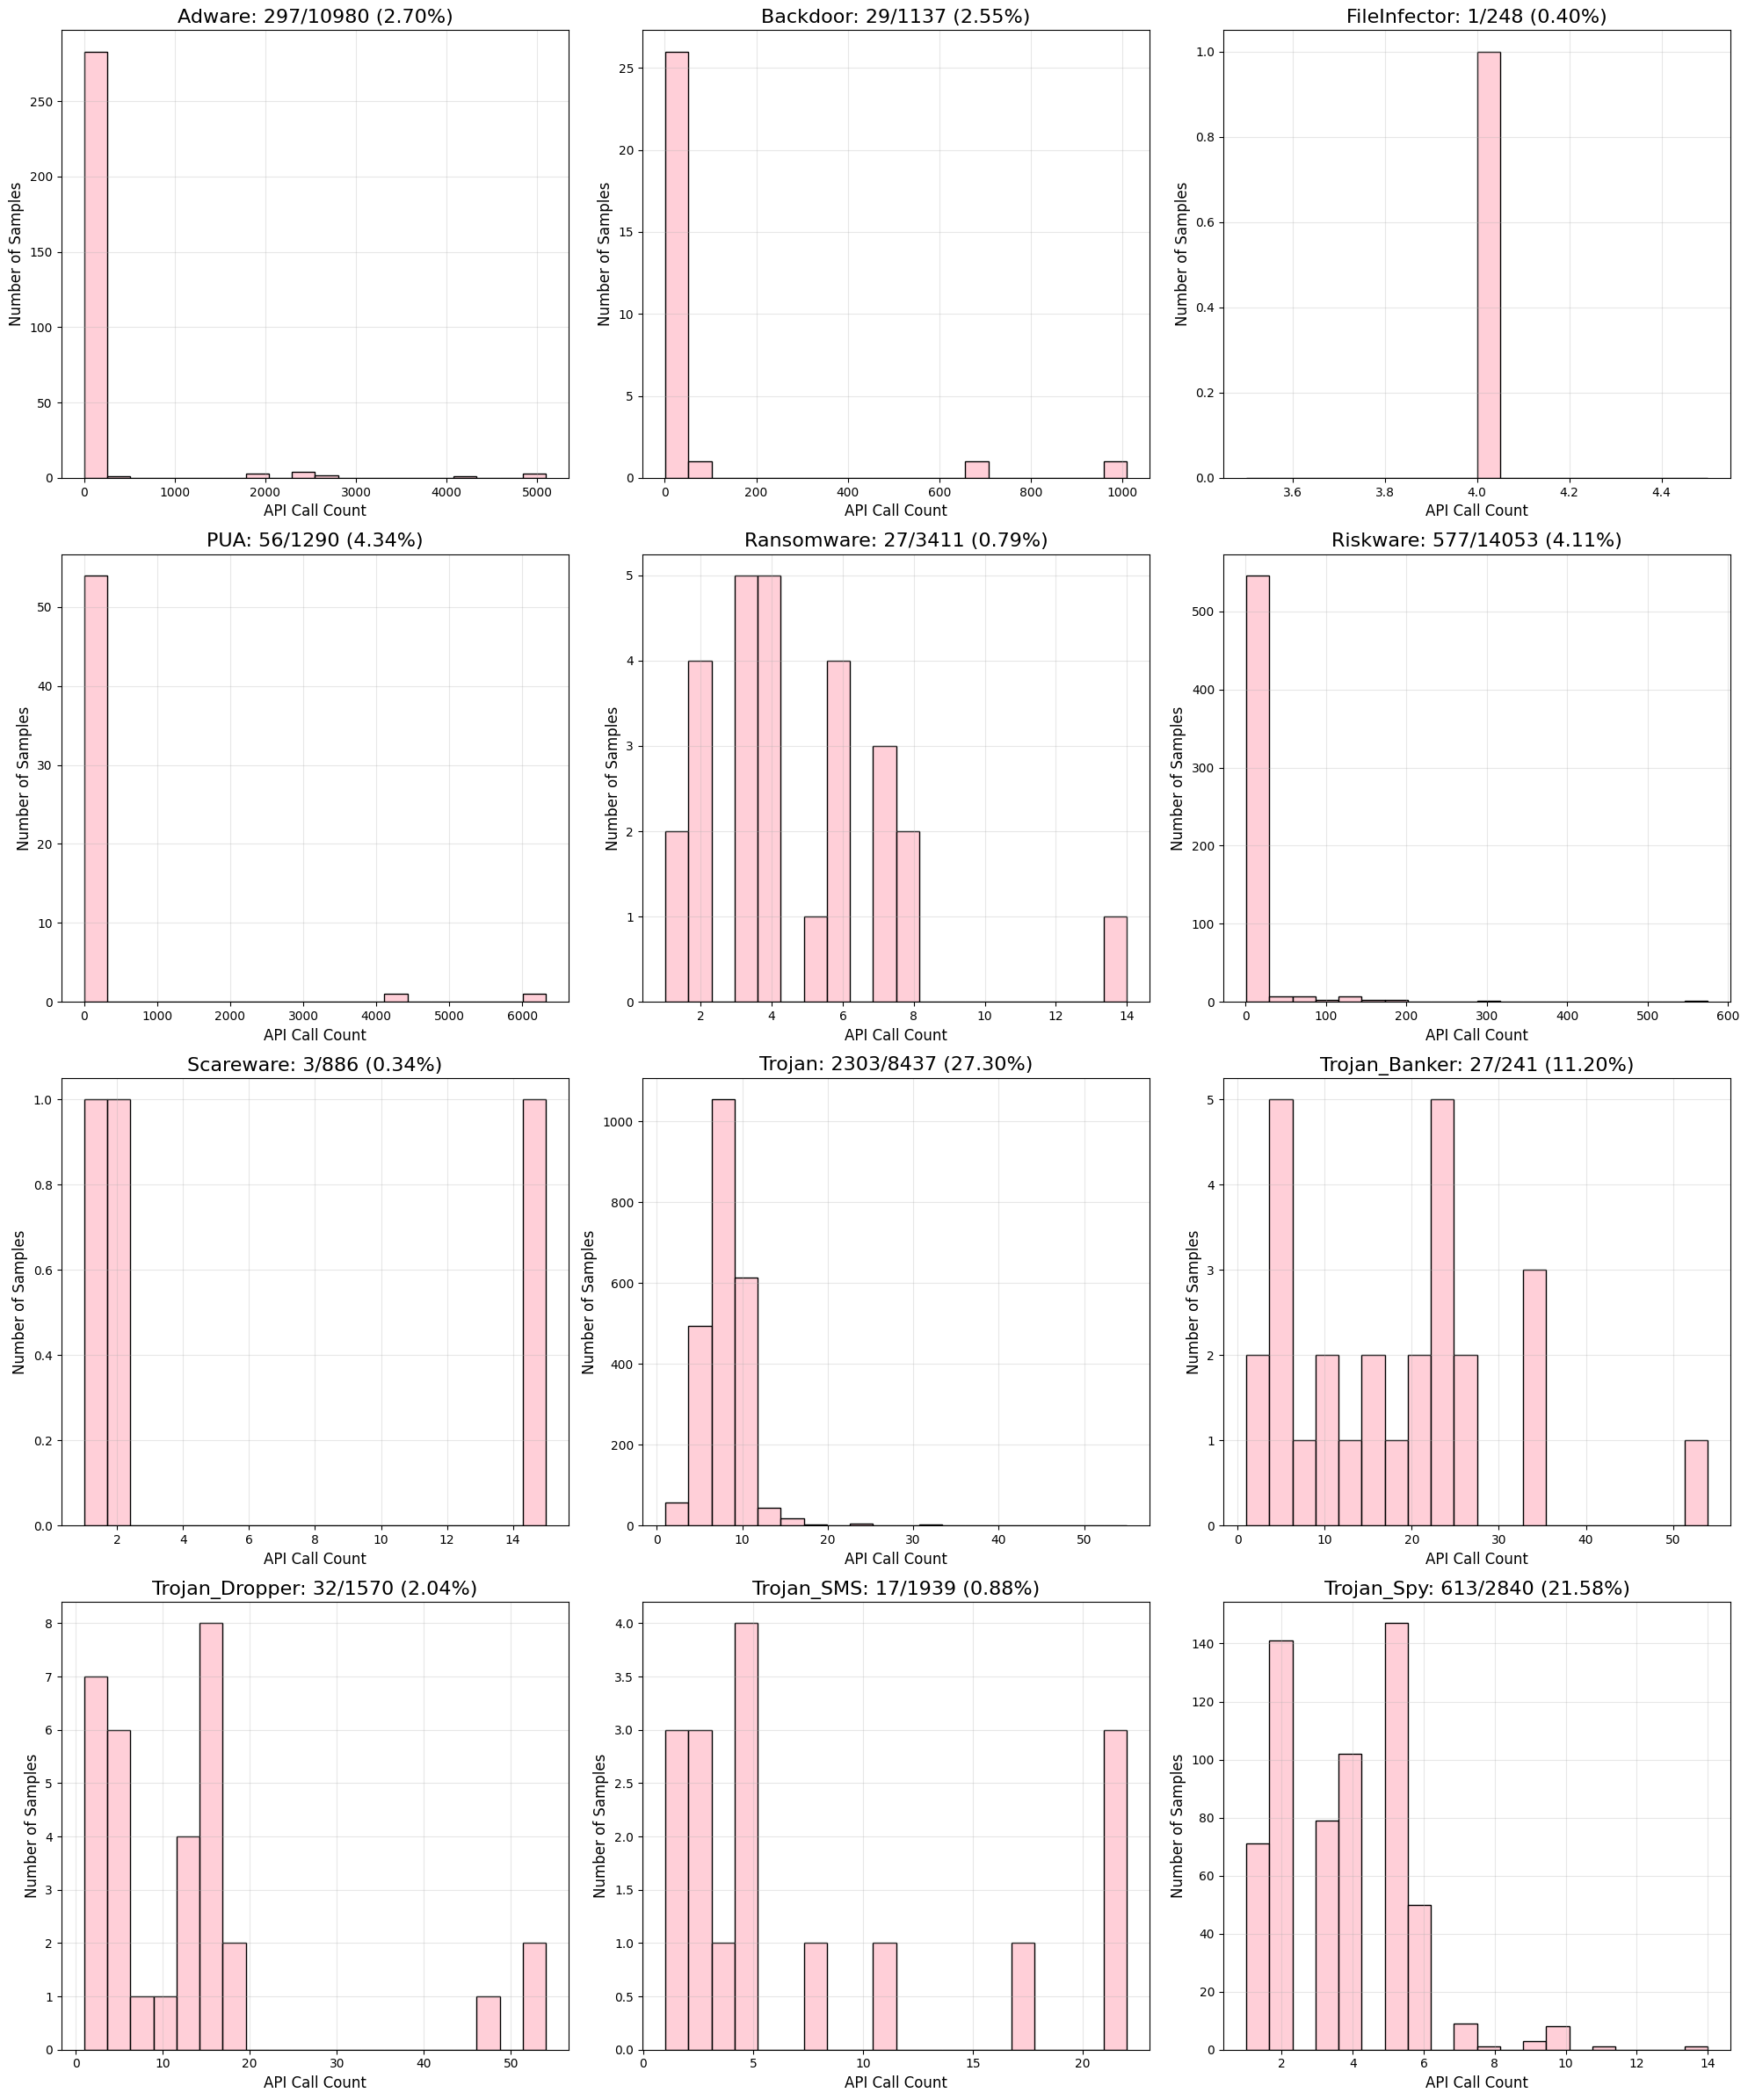

In [62]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]

api_feature = "API_Database_android.database.sqlite.SQLiteDatabase_updateWithOnConflict"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

The SQLiteDatabase_updateWithOnConflict API displays sparse but occasionally intense usage across malware categories. 

PUA and Adware stand out with elevated mean values (8.58 and 3.91) and extreme max outliers (up to 6322 and 5095 calls), suggesting repeated conflict handling updates in a small number of samples. 

Trojan and Trojan_Banker show moderate engagement, likely reflecting conditional data manipulation during infection routines. 

Most other families, especially Scareware, Ransomware, and FileInfector, barely use this API, indicating limited adoption. While not broadly used, the high variability and bursty usage in select categories could make this API a weak but situational signal.

#### SQLiteDatabase_compileStatement

In [69]:
df['API_Database_android.database.sqlite.SQLiteDatabase_compileStatement'].describe()

count    53439.000000
mean         7.657142
std         28.589411
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max       1615.000000
Name: API_Database_android.database.sqlite.SQLiteDatabase_compileStatement, dtype: float64

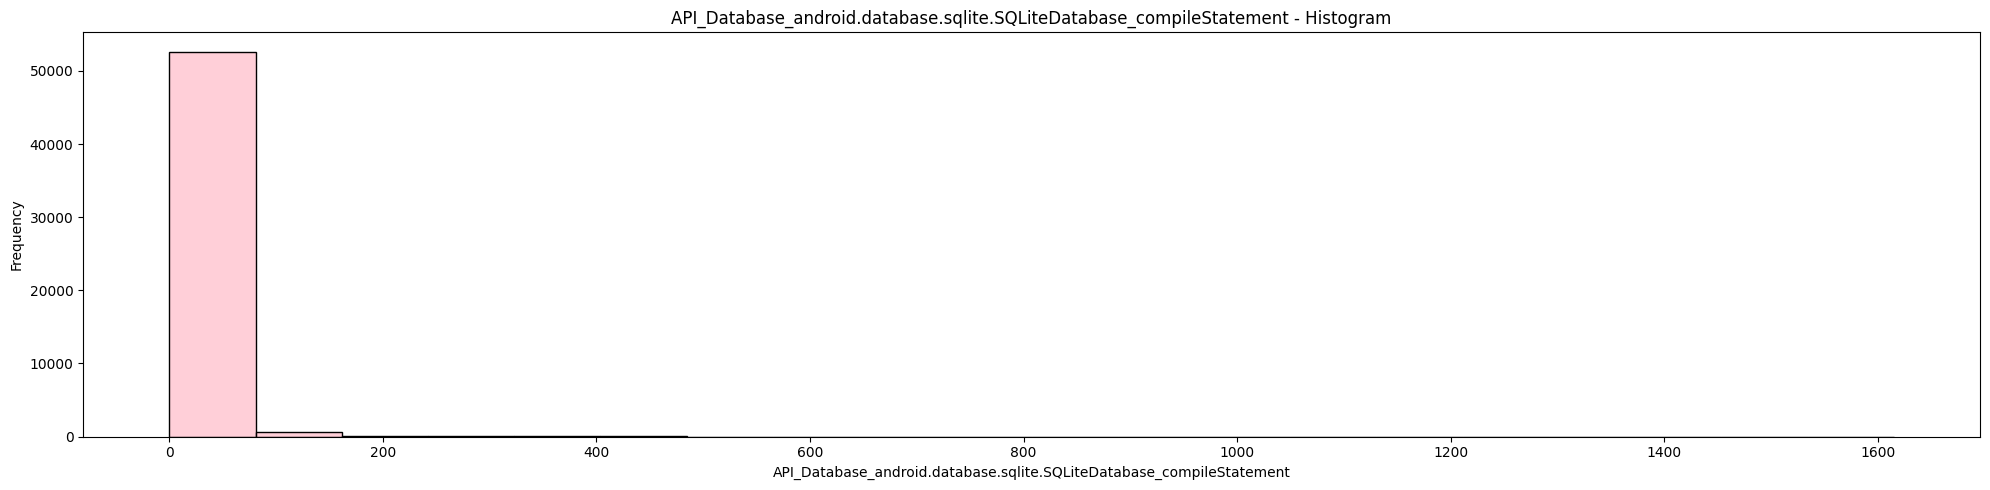

In [95]:
default_pipeline.EDA.plot_histograms(features=["API_Database_android.database.sqlite.SQLiteDatabase_compileStatement"], n_cols=1, bins=20)

The SQLiteDatabase_compileStatement API shows a moderately skewed distribution, with most samples making few or no calls. The median is zero and 75% of samples remain under two calls, yet the mean is elevated (7.66) due to a long tail extending to a maximum of 1615. This suggests that while this API is generally unused, a small subset of apps, possibly those generating dynamic SQL at scale—heavily rely on it. Its sporadic but intense usage could serve as a weak signal in models sensitive to database-heavy behaviors. To better explore actual usage patterns, we will replot the data excluding these zero values.

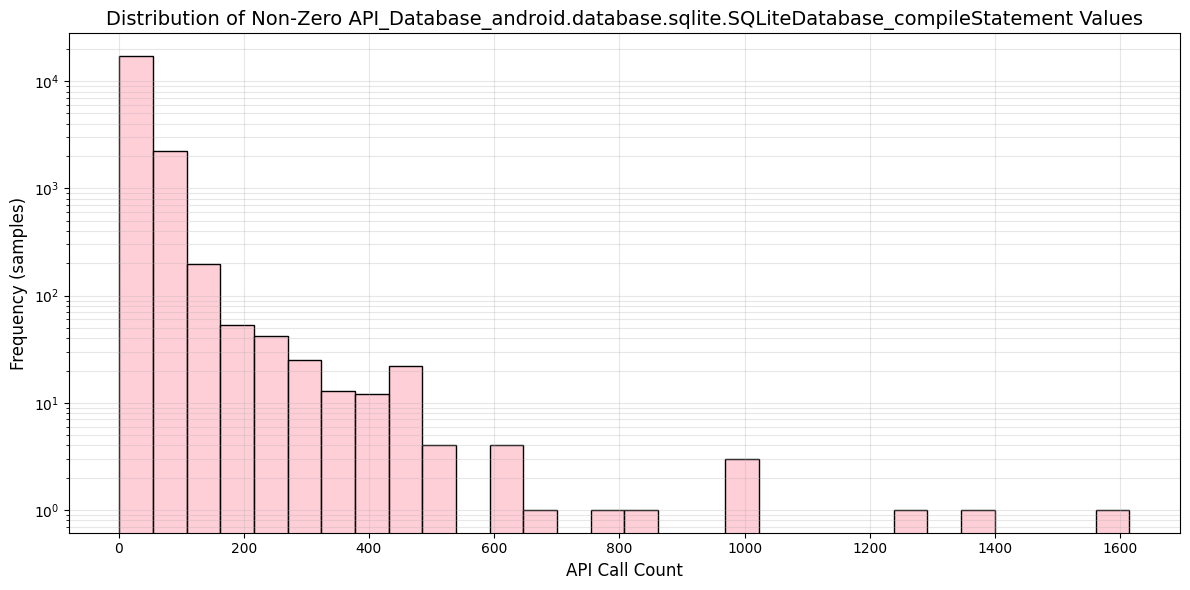

In [96]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Database_android.database.sqlite.SQLiteDatabase_compileStatement"] > 0]
sns.histplot(nonzero_samples["API_Database_android.database.sqlite.SQLiteDatabase_compileStatement"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Database_android.database.sqlite.SQLiteDatabase_compileStatement"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale('log')
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()


This histogram of non-zero SQLiteDatabase_compileStatement calls reveals a steep drop-off in frequency as call counts increase. Most non-zero samples cluster below 200 calls, suggesting lightweight or occasional use. However, a long tail stretches past 1000 calls, with rare outliers exceeding 1500, reflecting extreme usage in a small number of apps. The log-scaled y-axis highlights this sparsity, with exponentially fewer samples contributing to higher bins. This pattern reinforces the idea that while generally infrequent, this API can act as a niche signal in cases involving intense SQL compilation activity.

In [97]:
df.groupby('Category')['API_Database_android.database.sqlite.SQLiteDatabase_compileStatement'].describe()

count       mean        std  min  25%  50%  75%     max
Category                                                                 
Adware          10980.0   7.552732  30.184858  0.0  0.0  0.0  4.0  1615.0
Backdoor         1137.0   4.214600  13.634749  0.0  0.0  0.0  4.0   149.0
FileInfector      248.0   0.520161   4.879893  0.0  0.0  0.0  0.0    74.0
No_Category      1932.0   5.434265  47.679084  0.0  0.0  0.0  1.0  1365.0
PUA              1290.0  12.029457  61.809894  0.0  0.0  0.0  0.0   599.0
Ransomware       3411.0   1.690707  22.186749  0.0  0.0  0.0  0.0   416.0
Riskware        14053.0  14.127233  27.697684  0.0  0.0  1.0  8.0   383.0
Scareware         886.0   0.288939   3.330060  0.0  0.0  0.0  0.0    65.0
Trojan           8437.0   4.550196  26.197951  0.0  0.0  0.0  2.0  1008.0
Trojan_Banker     241.0   4.244813  14.400023  0.0  0.0  0.0  0.0   140.0
Trojan_Dropper   1570.0   5.719745  19.343671  0.0  0.0  0.0  0.0   346.0
Trojan_SMS       1939.0   1.606498  11.912537  0.0  0.0  0.0  0.0   281.0
Trojan_Spy       2840.0   4.720775  13.738354  0.0  0.0  0.0  2.0   164.0
Zero_Day         4475.0   5.777654  27.637250  0.0  0.0  0.0  2.0   835.0

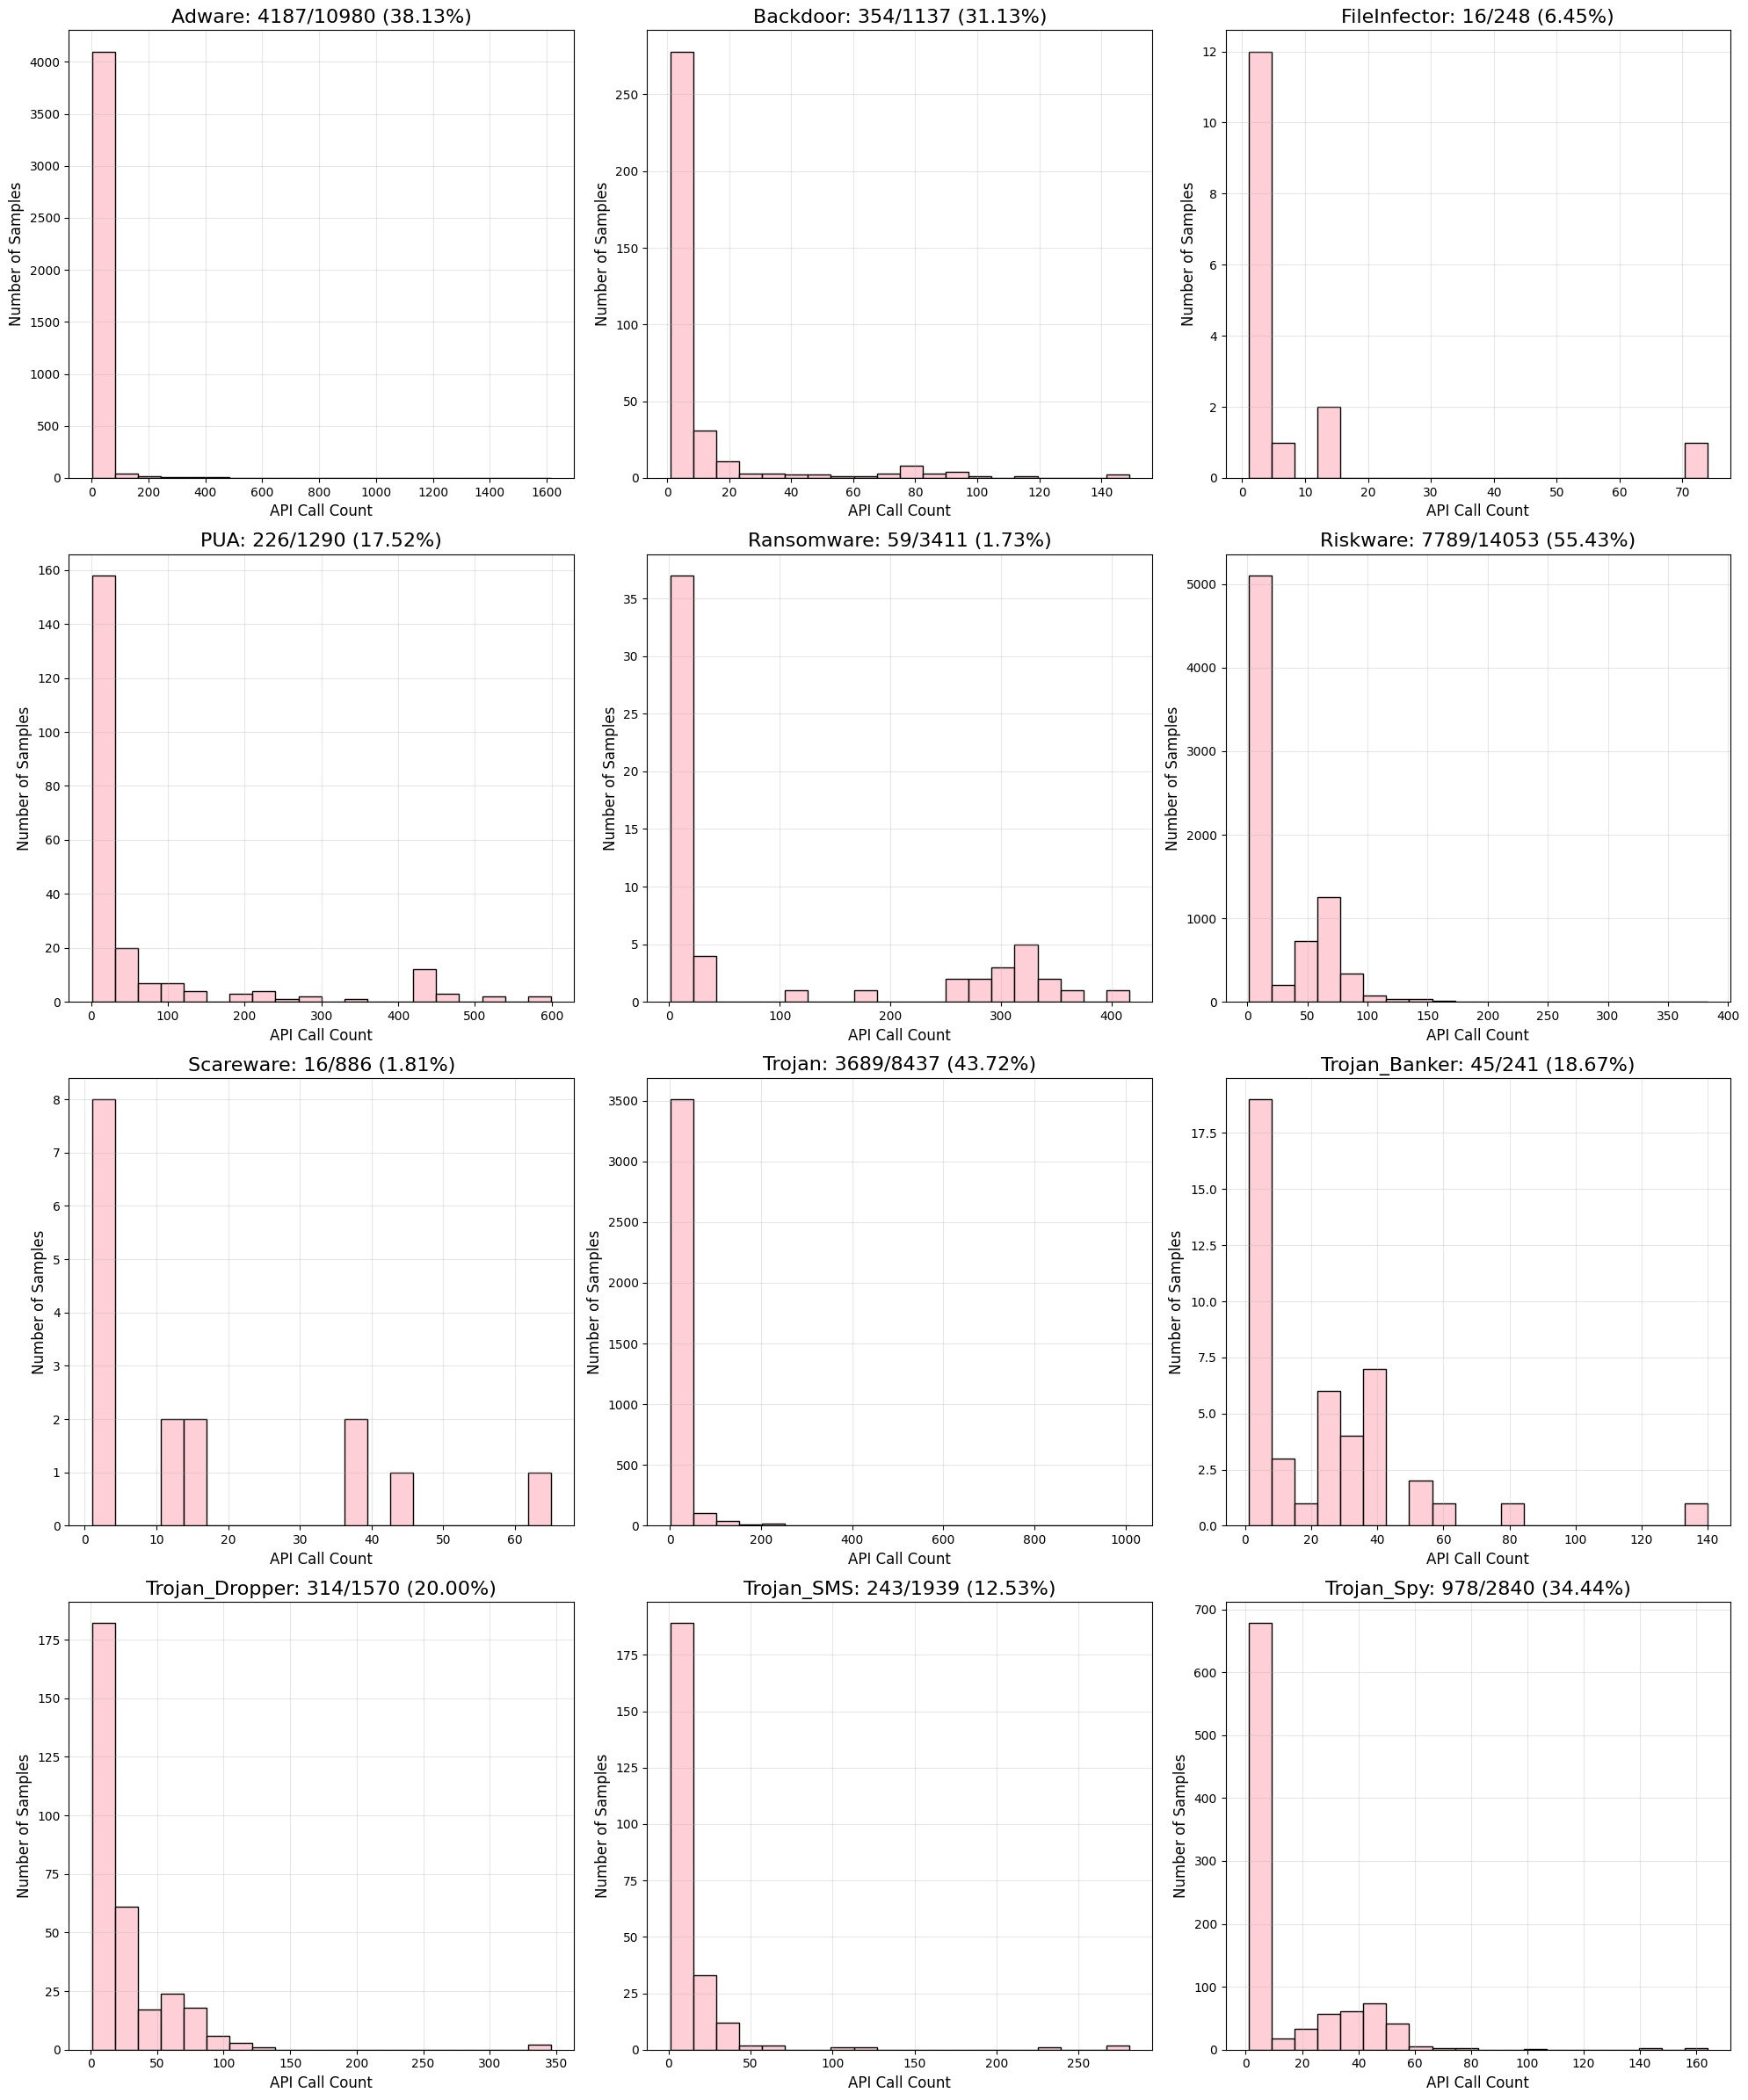

In [99]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]

api_feature = "API_Database_android.database.sqlite.SQLiteDatabase_compileStatement"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Despite its relatively low average use, SQLiteDatabase_compileStatement exhibits wide variation between malware categories. 

Trojan and Adware families show the highest mean usage, with Trojans peaking at over 1000 calls in a few extreme cases. 

Riskware and Zero_Day also stand out, with moderate average use and outliers pushing beyond 800. 

Families like Scareware and FileInfector rarely use this API, with near-zero averages and low maximums. 

The broad spread and high standard deviations in some categories suggest that compileStatement activity is context-dependent, making it a potentially discriminative feature in nuanced scenarios.

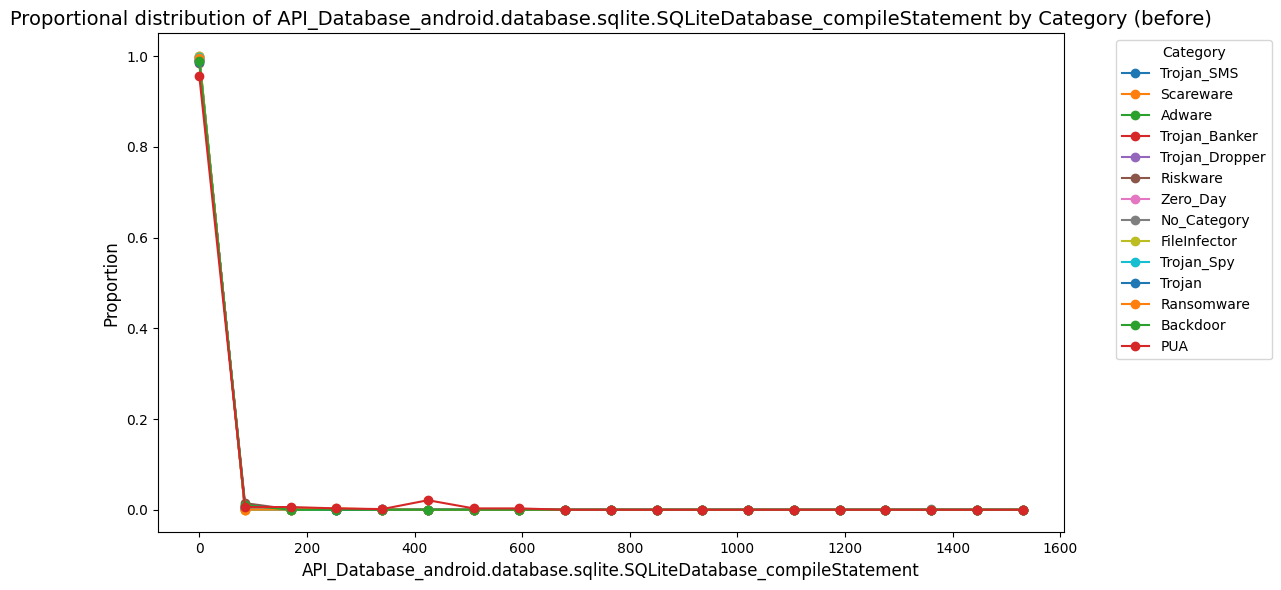

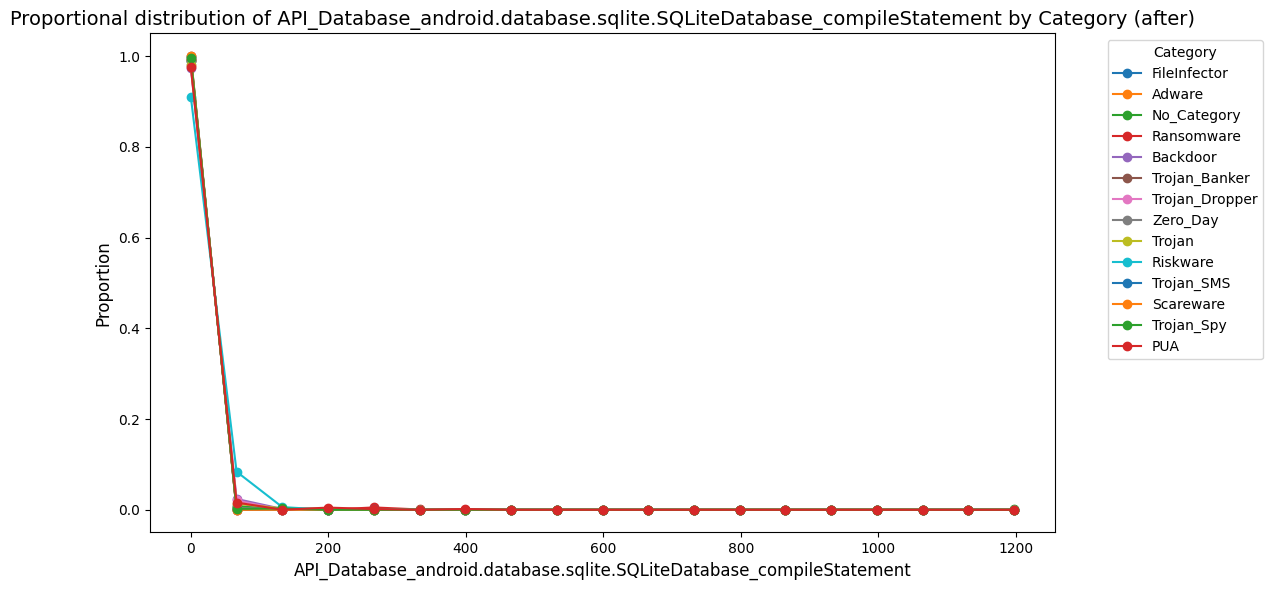

In [102]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature='API_Database_android.database.sqlite.SQLiteDatabase_compileStatement',
    category_column="Category",
    by_reboot = True
)

This analysis examines compileStatement usage across malware families. The distribution is highly right-skewed, with most samples making zero calls and a few outliers exceeding 1,500 calls. Despite a relatively low mean, the long tail reflects intense usage in specific apps.

At the category level, Riskware, Adware, Trojan, and PUA exhibit higher call volumes and greater variance, suggesting heavier reliance on precompiled SQL execution. In contrast, categories like Scareware and FileInfector show negligible use.

The proportional breakdown by category highlights sharp drop-offs after zero calls, with only a few families maintaining non-trivial activity beyond 100 calls. This niche usage pattern indicates that while rare, compileStatement can act as a strong signal in detecting certain malware behaviors.

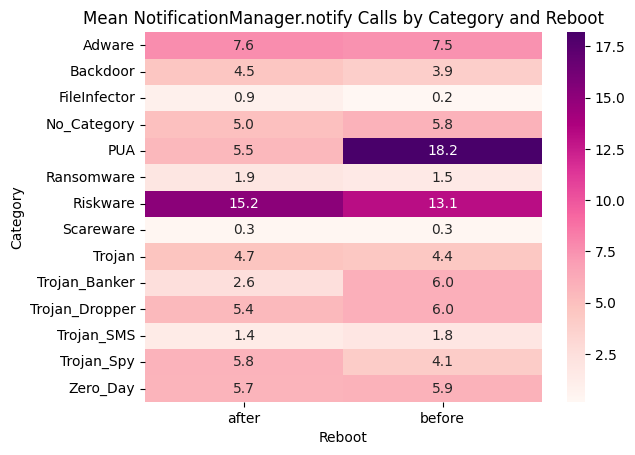

In [101]:
df = default_pipeline.dataset.df.copy()
df['notify_bin'] = pd.cut(df['API_Database_android.database.sqlite.SQLiteDatabase_compileStatement'], bins=5)

pivot = df.pivot_table(index='Category', columns='Reboot', values='API_Database_android.database.sqlite.SQLiteDatabase_compileStatement', aggfunc='mean')
sns.heatmap(pivot, annot=True, fmt=".1f", cmap='RdPu')
plt.title('Mean NotificationManager.notify Calls by Category and Reboot')
plt.show()

This heatmap compares mean notify call counts before and after reboot events. Riskware shows the highest activity in both states, followed by PUA, which spikes post-reboot. Most categories remain stable across reboot states, with generally low usage. These patterns suggest targeted use of notifications by specific malware families for persistence or user interaction.

#### SQLiteDatabase_create

In [52]:
df['API_Database_android.database.sqlite.SQLiteDatabase_create'].describe()

count    53439.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: API_Database_android.database.sqlite.SQLiteDatabase_create, dtype: float64

This feature has no predicting power and should be removed.

### IPC - 6

Allows communication between processes.

API_IPC_android.content.ContextWrapper_sendBroadcast: allows an application to send a broadcast message to any interested components within the system

API_IPC_android.content.ContextWrapper_sendStickyBroadcast: sends a broadcast that remains available after the broadcast is complete. You can still retrieve the broadcast after it has been sent.

API_IPC_android.content.ContextWrapper_startActivity: launches a new activity, which can be within the same app or in a different app

EDA NOTE => seems something intrusive (Adware may have lots of these)

API_IPC_android.content.ContextWrapper_startService: starts a background service (Services can continue running even when the user is not interacting with the application, useful for downloading files or syncing data)

EDA NOTE => Very likely increase in Trojan_Spy

API_IPC_android.content.ContextWrapper_stopService: stops a service

API_IPC_android.content.ContextWrapper_registerReceiver: registers a BroadcastReceiver to receive specific messages. The receiver will be notified whenever matching broadcasts are sent

Features

Different Technical Purposes

Regular broadcasts: Temporary communication
Sticky broadcasts: Persistent state communication
Different Malware Signatures

Adware: May use regular broadcasts for ads
Spyware: Might prefer sticky broadcasts for persistent monitoring
Trojans: Pattern differences between families (as seen with startActivity)

So we will analyze them separately and then together


#### sendBroadcast

In [ ]:
df['API_IPC_android.content.ContextWrapper_sendBroadcast'].describe()

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_IPC_android.content.ContextWrapper_sendBroadcast"], n_cols=1, bins=500)

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_IPC_android.content.ContextWrapper_sendBroadcast"] > 0]
sns.histplot(nonzero_samples["API_IPC_android.content.ContextWrapper_sendBroadcast"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_IPC_android.content.ContextWrapper_sendBroadcast"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()


Key Observations in Overall Distribution
Extremely Skewed Logarithmic Distribution

The majority use low regular broadcasts. After the first bin there is an extremely big drop of calls with only around 50 calls.

wwe can also observe three clusters:
From 0 calls to 300 calls, 800 calls to 1300 calls and 1600 calls to almost 2000 calls and some rare outliers past 2000 calls.

This difference is probably attributed to different strategies when broadcasting.

In [ ]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]

api_feature = "API_IPC_android.content.ContextWrapper_sendBroadcast"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Ransomware is the only category with significant high-range activity, having clusters around 1000 and 2000 calls.
Scareware and Trojan_Spy show a bimodal distribution, 
PUA has most of its values centered around 0 but makes up to more than 1200 calls.
Adware is extremely right skewed, which is contrary to what would be expected for a software that shows ads.

Overall, every malware show unique distributions and different ranges, having an incredible discriminatory potential. 

#### sendStickyBroadcast

In [ ]:
df['API_IPC_android.content.ContextWrapper_sendStickyBroadcast'].describe()

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_IPC_android.content.ContextWrapper_sendStickyBroadcast"], n_cols=1, bins=500)

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_IPC_android.content.ContextWrapper_sendStickyBroadcast"] > 0]
sns.histplot(nonzero_samples["API_IPC_android.content.ContextWrapper_sendStickyBroadcast"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_IPC_android.content.ContextWrapper_sendStickyBroadcast"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()

Sticky broadcast are barely called. Let's move on and analyze which categories have these few non-zero values.

In [ ]:
# Filter to non-zero samples and count by category
sticky_broadcast_column = "API_IPC_android.content.ContextWrapper_sendStickyBroadcast"

nonzero_counts = df[df[sticky_broadcast_column] > 0]['Category'].value_counts()
# Display just category names and their counts
print("Categories with non-zero sticky broadcasts:")
for category, count in nonzero_counts.items():
    print(f"{category}: {count}")

# Get total count of non-zero samples
total_nonzero = nonzero_counts.sum()
print(f"\nTotal samples with non-zero sticky broadcasts: {total_nonzero}")

Because there are only 5 missing values all coresponding to adware this becomes a potential signature for the feature. So a binary feature could be created.

When deploying a model into the real world, we cannot rely so much on this feature. This is because if the model learns during training that sticky broadcast automatically means Adware because of a few examples, overfitting becomes a risk. This is because the model would be treating that feature as a guaranteed signal when in reality, it might just be a coincidence in the limited training data. And this makes sense, since our dataset is highly imbalanced, going from around ten thousand samples for adware to 250 samples for trojan_banker

In production, this could lead to a lot of false positives, especially since sticky broadcasts could also appear in other malware families. 

So, if we consider production, this feature should probably be deleted.



#### startActivity

In [ ]:
df['API_IPC_android.content.ContextWrapper_startActivity'].describe()

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_IPC_android.content.ContextWrapper_startActivity"], n_cols=1, bins=500)

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_IPC_android.content.ContextWrapper_startActivity"] > 0]
sns.histplot(nonzero_samples["API_IPC_android.content.ContextWrapper_startActivity"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_IPC_android.content.ContextWrapper_startActivity"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()


Most samples make very few startActivity calls, but those that don't make a lot of calls.


In [ ]:
df.groupby('Category')['API_IPC_android.content.ContextWrapper_startActivity'].describe()


At least 75% of samples across all categories make zero startActivity calls. 

Trojan_SMS has the highest mean (18.87) and extreme maximum (9,286 calls). Some SMS trojans rely heavily on UI manipulation for permission granting or SMS interception. It also has a very big standard deviation, indicating really different number of calls throughout. 
Ransomware has the second highest mean (14.20). On the other hand FileInfector and Scareware almost don't make this type of call. 

Trojan_Spy has a very big maximum but a very low mean, which means it has a few but very large outliers.


In [ ]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]

api_feature = "API_IPC_android.content.ContextWrapper_startActivity"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.yscale("log")
    plt.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()


Trojan_SMS & Trojan_Spy have extreme outliers and in general larger values than other categories.
Scareware and FileInfector make minimal calls between 0 and 6.
Ransomware has a distinctive bimodal distribution
Backdoor has multiple clusters which might suggest different variants. 
The extreme outliers in Trojan_SMS and Trojan_Spy categories provide clear behavioral signatures.

Categories show distinct patterns, making startActivity counts a valuable classification feature.

Let's now analyse the effect of reboot.

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_IPC_android.content.ContextWrapper_startActivity",
    category_column="Category",
    by_reboot = True
)

No significant difference in before and after reboot is observed.

#### startService and stopService

In [ ]:
df['API_IPC_android.content.ContextWrapper_startService'].describe()

In [ ]:
df['API_IPC_android.content.ContextWrapper_stopService'].describe()

At first glance, someone might expect startService and stopService call counts to be somewhat similar, if you start a service, logically you would expect to stop it at some point. But the data shows this is not the case.

Malware often starts services but does not stop them. This is because they run in the background for tasks like data exfiltration or surveillance. In fact, the services are often designed to run indefinitely, in contrast to legitimate apps that do stop them when no longer needed.


Since we already know the distributions are going to be highly right skewed with an unproportional amount of 0s compared to the rest of values we will move directly to the plotting without 0s to clearly visualize the values that actually matter the most.

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_IPC_android.content.ContextWrapper_startService"] > 0]
sns.histplot(nonzero_samples["API_IPC_android.content.ContextWrapper_startService"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_IPC_android.content.ContextWrapper_startService"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_IPC_android.content.ContextWrapper_stopService"] > 0]
sns.histplot(nonzero_samples["API_IPC_android.content.ContextWrapper_stopService"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_IPC_android.content.ContextWrapper_stopService"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()

startService is usually called a few number of times but a few go up to even more than 2500 calls. This means that the services started probably do not require user interaction and just run persistently on the background. On the other hand, stopService has a much lower range of values, being the maximum less than 40 and with the majority of values being less than 10. Which shows than once started the malware would almost never stops itself. Which makes sense, because it would basically be stopping what it is trying to achieve. However, the few that do call stopService could have a more advanced code to detect when it is being tracked and conditionally stop services or terminate. This is known as anti-VM techniques.

Lets now focus on the service ratio by category

In [ ]:
service_ratio = df_copy['API_IPC_android.content.ContextWrapper_stopService'] / (
    df_copy['API_IPC_android.content.ContextWrapper_startService'] + 1e-5
)

# Step 3: Add the ratio as a new column
df_copy['service_ratio'] = service_ratio

# Step 4: Preview the first few values
print(df_copy[['API_IPC_android.content.ContextWrapper_startService',
               'API_IPC_android.content.ContextWrapper_stopService',
               'service_ratio']].head())

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(data=df_copy, x='Category', y='service_ratio')
plt.title('Service Stop/Start Ratio by Malware Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Most samples have a very low ratio (clustered near 0), meaning they call startService far more often than stopService. 

However, some Trojan_SMS, Riskware, and No_Category samples have extremely high ratios, where they call stopService without corresponding startService activity. This might indicate evasive behavior, like terminating services to cover their tracks or hijack others.

In [ ]:
df_copy.groupby('Category')['service_ratio'].describe()

Most malware samples (even at the 75th percentile) follow the expected pattern of a zero ratio, but certain categories contain samples with extremely unusual service stopping behavior that would be less obvious when analyzing start/stop metrics separately..

REBOOT

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature='API_IPC_android.content.ContextWrapper_startService',
    category_column="Category",
    by_reboot = True
)

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature='API_IPC_android.content.ContextWrapper_stopService',
    category_column="Category",
    by_reboot = True
)

#### registerReceiver

In [ ]:
df['API_IPC_android.content.ContextWrapper_registerReceiver'].describe()

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_IPC_android.content.ContextWrapper_registerReceiver"], n_cols=1, bins=500)

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_IPC_android.content.ContextWrapper_registerReceiver"] > 0]
sns.histplot(nonzero_samples["API_IPC_android.content.ContextWrapper_registerReceiver"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_IPC_android.content.ContextWrapper_registerReceiver"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()

Most samples (tens of thousands) use this API 0 to 100 times. Frequency drops off exponentially as counts increase.

There are two outliers at around 1000 and 1750, representing extreme monitoring.

What's particularly interesting here is the presence of a few extreme outliers, two specifically at around 1000 and 1750, representing extreme monitoring.

In [ ]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]

api_feature = "API_IPC_android.content.ContextWrapper_registerReceiver"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


This feature is probably mostly useful to recognize Scareware since it is the only one showing a bimodal distribution and has a bvery high number of non-zero values. FileInfector has also a very high number of non-zero values (93.95%). On the other hand, Ransomware is the one with the most zero values having only 8.47% of non-zeros. 


Despite similar names, Trojan variants show meaningfully different patterns Trojan_Dopper and Banker and mostly concentrated ast lowest values, Trojan_SMS in the 0 to 200 range, and Trojan_Spy in the 0 to 100. Moreover, Trojan_Dopper has a lower usage rate of 27.01% compared to other Trojan variants.

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_IPC_android.content.ContextWrapper_registerReceiver",
    category_column="Category",
    by_reboot = True
)

### Binder - 3

Binder
API_Binder_android.app.ContextImpl_registerReceiver: Registers a receiver in the app context.
this means the app is subscribing to system-wide events (like screen unlock, boot completed, connectivity changes, etc.).

API_Binder_android.app.ActivityThread_handleReceiver: Handles broadcast receivers in ActivityThread. 

When your app (or malware) tells Android:

"Hey Android, if something important happens (like Wi-Fi turning on, battery getting low, or reboot happening), I want to know."

➔ Android remembers that.
➔ When that thing happens later, Android automatically calls handleReceiver to wake up your app and let it respond.

If you see malware using handleReceiver a lot, it's not just sitting there — it's waiting for triggers and reacting in the background to system changes without needing user action.

API_Binder_android.app.Activity_startActivity: Starts an activity from another component.
EDA NOTE => seems something intrusive 


#### ContextImpl_registerReceiver

High usage suggests the app is actively responding to multiple system broadcasts — e.g., malware constantly reacts to state changes.

In [ ]:
df['API_Binder_android.app.ContextImpl_registerReceiver'].describe()

Immediately this feature stands out because it is one of the first, if not the first, feature with a 50th percentile different from zero.
Despite eight is a small number, it still indicates that the API is actively being used and it is still higher use compared to all other APIs analysed up to the moment.

Also 25% of them make 58 or more calls, which is pretty high activity.


In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_Binder_android.app.ContextImpl_registerReceiver"], n_cols=1, bins=500)

The feature is extremely right skewed, no surprise.

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Binder_android.app.ContextImpl_registerReceiver"] > 0]
sns.histplot(nonzero_samples["API_Binder_android.app.ContextImpl_registerReceiver"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Binder_android.app.ContextImpl_registerReceiver"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log") 
plt.grid(alpha=0.3, which='both') 
plt.tight_layout()
plt.show()

A very large number of samples make up to around 350 calls.

The right tail stretches toward extreme outliers (max = 5157), showing that while most samples use it moderately, a few apps use it very heavily. 

In [ ]:
df.groupby('Category')['API_Binder_android.app.ContextImpl_registerReceiver'].describe()

Here Scareware stands out. It has the highest median (128) and 75th percentile (171), which are significantly higher compared to all other categories.

Riskware and Adware also show an active use with 75th percentiles being 165 and 84 and means 87.7 aand 60.6, resspectively.

FileInfector has a pretty consistent usage.

PUA, Trojan_Dopper and Ransomware show low usage. They probably don’t rely on this broadcast mechanisms. Since these features barely use registerReceiver, if the model sees an app making a lot of these calls, it's probably safe to say it's not one of them. So it is probably be a good feature to include in the model.


In [ ]:
top_categories = top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]
api_feature = "API_Binder_android.app.ContextImpl_registerReceiver"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.yscale("log") 
    plt.grid(alpha=0.3, which='both') 
   

plt.tight_layout()
plt.show()


Most malware samples across categories use this API a lot. For example, over 68% of Adware samples, 70% of Riskware samples, and 71% of generic Trojans make non-zero calls. This means this feature is very informative.

Almost all distributions look right skewedut for Scareware. Many distributions like Trojan or Riskware have ome very extreme outliers, so log scaling should be considered.

This API requests the system to notify the malware when specific system events occur, for instance, when the device completes the booting process, allowing the application to automatically resume or initiate its activities without direct user interaction. So a reboot analysis is very much worth in this scenario.

In [ ]:
df.groupby('Reboot')['API_Binder_android.app.ContextImpl_registerReceiver'].describe()

On average, samples use this API more after rebooting. This supports the idea that malware often sets up background listeners during the reboot sequence to stay active or re-establish persistence.

The number of calls also increase in the top 25% but the median remains the same. Which means the major changes happen among the more suspicious or intensive samples.

The maximum value after reboot is smaller, indicating a more consistent number of calls compared to before.

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_Binder_android.app.ContextImpl_registerReceiver",
    category_column="Category",
    by_reboot = True
)


Before reboot, nearly all categories show very similar proportional distributions, they are overlapping a lot. However, after reboot, the different categories start to be noticed.

Adware, Riskware, and Scareware start to show higher proportions of calls, indicating more persistent or background-listening behavior after reboot. This implies they wake up once the device is restarted to bypass detection mechanisms.

So this feature mainly has its significant value on samples after reboot, as we are able to notice the different behaviour across malware categories.

An interaction effect with reboot could be added. (Note: tree-based models can implicitly learn interactions so for them this step should not be needed)


#### ActivityThread_handleReceiver

In [ ]:
df['API_Binder_android.app.ActivityThread_handleReceiver'].describe()

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_Binder_android.app.ActivityThread_handleReceiver"], n_cols=1, bins=500)

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Binder_android.app.ActivityThread_handleReceiver"] > 0]
sns.histplot(nonzero_samples["API_Binder_android.app.ActivityThread_handleReceiver"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Binder_android.app.ActivityThread_handleReceiver"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which ='both')
plt.tight_layout()
plt.show()

There appears to be specific clusters around high values. These peaks probably represent share code. 

In [ ]:
df.groupby('Category')['API_Binder_android.app.ActivityThread_handleReceiver'].describe()

Most categories have 0 as the median and 25th percentile, and often even as the 75th percentile.
This feature does not seem very informative in general but it could be useful for tree-based models which can learn from sparse features.

However, for logistic regression, it might not be useful and only add noise.
For logistic regression a binary usage flag or quantile binning (like never used, light use, moderate use, aggressive use )could prevent this issue.

In [ ]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]

api_feature = "API_Binder_android.app.ActivityThread_handleReceiver"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.yscale("log") 
    plt.grid(alpha=0.3, which='both') 

plt.tight_layout()
plt.show()



We need to know if different malware types use this API in distinct ways to see if there is any predictive power in this feature. But most distributions look pretty similar, meaning it is probably not very useful. In order to actually quantify 

the usefulness of this feature across malware categories we will use Kullback-Leiber (KL) divergence, which is a statistical measure that will tell us how diffeerent the probability distributions are from one another. More formally, KL divergence measures the information lost when you approximate one distribution (P) with another (Q).

A result close to 0 means the patterns are to similar and so the feature probably does not have a strong predicting power. 

In [ ]:
from scipy.special import rel_entr

api_column = "API_Binder_android.app.ContextImpl_registerReceiver"
category_column = "Category"

# --- FUNCTIONS ---
def compute_distributions(df, api_column, category_column, bins=50):
    distributions = {}
    bin_edges = None

    for category, group in df.groupby(category_column):
        hist, bin_edges = np.histogram(group[api_column], bins=bins, range=(0, df[api_column].max()), density=True)
        # Add a small constant to avoid division by zero
        distributions[category] = hist + 1e-10

    return distributions, bin_edges

def compute_kl_divergences(distributions):
    categories = list(distributions.keys())
    kl_matrix = pd.DataFrame(index=categories, columns=categories)

    for cat1 in categories:
        for cat2 in categories:
            kl_div = np.sum(rel_entr(distributions[cat1], distributions[cat2]))
            kl_matrix.loc[cat1, cat2] = kl_div

    return kl_matrix.astype(float)

# --- MAIN EXECUTION ---

# 1. Compute per-category distributions
distributions, bin_edges = compute_distributions(df, api_column, category_column)

# 2. Compute KL divergence matrix
kl_matrix = compute_kl_divergences(distributions)

# 3. Plot the KL divergence heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(kl_matrix, cmap="magma", annot=True, fmt=".2f", cbar_kws={"label": "KL Divergence"})
plt.title(f"KL Divergence between Categories for {api_column}", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


Most values are 0.00 to 0.01, meaning the API usage patterns across categories are very similar. This API feature (on its own) has very limited discriminative power between malware categories.

We will now analyse reboot effect

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_Binder_android.app.ActivityThread_handleReceiver",
    category_column="Category",
    by_reboot = True
)


There is a similar overall distribution before and after reboot. There is a slightly more visible category separation between 10 to 20 calls after reboot but not dramatic changes overall.

An interaction effect would have limited value.

#### Activity_startActivity

In [ ]:
df['API_Binder_android.app.Activity_startActivity'].describe()

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_Binder_android.app.Activity_startActivity"], n_cols=1, bins=500)

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Binder_android.app.Activity_startActivity"] > 0]
sns.histplot(nonzero_samples["API_Binder_android.app.Activity_startActivity"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Binder_android.app.Activity_startActivity"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()

Majority of samples dont use much activity launching. The peaks at around 450 and 600 are probably specialized variants.

Since we do not want to loose the information on the specialized variants, if any transformation to this feature is applied, log transformation might be the most accurate to use.


In [ ]:
df.groupby('Category')['API_Binder_android.app.Activity_startActivity'].describe()

Trojan_Dropper has the highest mean and maximum value by far. Followed by riskware.

Adware has a pretty balanced approach and Ransomware, Trojan_Banker and Trojan_Spy barely use this call.

Backdoor's has the second-highest maximum (460.0) but also has a moderate mean (5.36). This indicates it might be one of the specialized variants previously mentioned. Same as Trojan_Dropper's 630 maximum. 

In [ ]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]
api_feature = "API_Binder_android.app.Activity_startActivity"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.yscale("log") 
    plt.grid(alpha=0.3, which='both') 

plt.tight_layout()
plt.show()


Most categories cluster around very low usage, with many samples at or near zero.
Trojan_Banker  stands out with a relatively distinct spread and higher average call count, despite its smaller sample size. FileInfector also shows a different pattern.

This feature isn’t very discriminative, but it does act as a fingerprint for these specific classes.

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_Binder_android.app.Activity_startActivity",
    category_column="Category",
    by_reboot = True
)


After reboot, activity becomes more structured, many features show a proportional decline after reboot. The way they launch activities become more consistent.  

Trojan_Dropper changes the most as before reboot it had a pretty spread pattern but after it becomes more concentrated. Same with Riskware.

Scareware, FileInfector, Trojan_Banker and some Trojans,  Scareware and FileInfector do not really change at all.

Different malwares behaved in their own way before the device is restarted but then they start API calls in a very proportional way. The fact that the category distributions barely overlap in proportion at certain API call count ranges is a strong indicator that this feature could be useful for distinguishing between malware types. So if one malware type consistently has a higher proportion of samples in a specific call count range, and others don't, a well-tuned model can learn to use that signal to differentiate them. 

#### Combination of features

A new feature binder_activity_mix could be created to capture whether the malware tends to quietly listen for system events or actively launch components.

**binder_activity_mix** = registerReceiver_calls / (registerReceiver + startActivity + handleReceiver)

A value near 1 suggests the app mostly listens (passive, stealthy behavior).

A value near 0 suggests the app mostly initiates actions (startActivity) or handles responses (handleReceiver).

### Crypto - 4

Cryptographic functionalities

API_Crypto_javax.crypto.spec.SecretKeySpec_$init: Initializes a secret key specification. Typically the first step in setting up encryption or decryption operations, prepares the cryptographic key that will be used with a cipher

API_Crypto_javax.crypto.Cipher_doFinal: performs encryption or decryption.

API_Crypto-Hash_java.security.MessageDigest_digest: computes a cryptographic hash

API_Crypto-Hash_java.security.MessageDigest_update: updates a hash calculation with additional input data.

Ransomware often uses SecretKeySpec + doFinal to encrypt user data.

This combination is more suspicious than seeing either one alone — SecretKeySpec without doFinal

#### Crypto 

##### spec.SecretKeySpec_$init

This initializes a SecretKeySpec, which defines the secret key and algorithm to be used for encryption or decryption. 

This is usually the very first step before anything can be encrypted or decrypted, making it a strong indicator of cryptographic activity.

In [ ]:
df['API_Crypto_javax.crypto.spec.SecretKeySpec_$init'].describe()

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_Crypto_javax.crypto.spec.SecretKeySpec_$init"], n_cols=1, bins=500)

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Crypto_javax.crypto.spec.SecretKeySpec_$init"] > 0]
sns.histplot(nonzero_samples["API_Crypto_javax.crypto.spec.SecretKeySpec_$init"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Crypto_javax.crypto.spec.SecretKeySpec_$init"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale('log')
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()

Again, most values have "low" key initialization. But there are just two samples at aroung 28000 and 33000. These should definetely be handled carefully as they could highly distrot the model. 
They could potentially represent errors.

In [ ]:
df.groupby('Category')['API_Crypto_javax.crypto.spec.SecretKeySpec_$init'].describe()

The fact that both extreme outliers come from Riskware samples indicates it is unlikely to be an error. This extreme pattern is good to identify Riskware. 

Riskware and Trojan show pretty high 75th percentiles compared to the rest of malware, which could help identifying them using this feature.

In [ ]:
top_categories = top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]
api_feature = "API_Crypto_javax.crypto.spec.SecretKeySpec_$init"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.yscale("log")
    plt.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()


Most malware samples don't invoke this API but the mean and max values are pretty high for some classes.

Trojan_Dropper and Riskware both have very high means which makes sense because Droppers often encrypt and decrypt playloads and Riskware may protect modules with encryption.

This feature is pretty sparse but has different spikes which is probably good to differenciate classes.

Log-scaling should be considered due to very high maximum value.

However, the fact that an algorithm was defined and a secret key created does not indicate they were used. If it was defined but not used it might indicate that the malware is trying to confuse the sandbox or delaying encryption. 

For logistic regression, keeping only Cipher_doFinal might be a better idea (since it  already means that encryption actually happened) as both are probably highly correlated risking multicollinearity. 

But for tree-based it might be good to keep both for the model to figure out interactions.

##### Cipher_doFinal

This API actually performs the final encryption or decryption operation — turning readable data into encrypted bytes (or vice versa).

Why it matters: This is where the real data transformation happens. If malware is stealing sensitive info, it might encrypt it before sending it to avoid detection

In [ ]:
df['API_Crypto_javax.crypto.Cipher_doFinal'].describe()

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_Crypto_javax.crypto.Cipher_doFinal"], n_cols=1, bins=500)

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Crypto_javax.crypto.Cipher_doFinal"] > 0]
sns.histplot(nonzero_samples["API_Crypto_javax.crypto.Cipher_doFinal"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Crypto_javax.crypto.Cipher_doFinal"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log") 
plt.grid(alpha=0.3, which='both') 
plt.tight_layout()
plt.show()

The ranges of common number of calls is pretty similar as expected to the previous calls for the last feature. However, we do not have the extreme outliers that we were able to see before. This might mean that Riskware has a specific variant that regularly requests cryptographic keys but doesn't really use them. 

In [ ]:
df.groupby('Category')['API_Crypto_javax.crypto.Cipher_doFinal'].describe()

Despite 0 being the median across all categories, some of Riskware, Trojan_Dropper and Adware stand out since they have a higher mean usage and very high maximum values of 1124, 1904 and 4391, respectively.

On the other hand, Trojan_Banker has the lowest average, reinforcing its minimal cryptographic behavior. 

These differences indicate that doFinal can help distinguish between operational strategies.

In [ ]:
top_categories = top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]
api_feature = "API_Crypto_javax.crypto.Cipher_doFinal"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.yscale("log") 
    plt.grid(alpha=0.3, which='both') 

plt.tight_layout()
plt.show()


Distributions have notable differences, possibly making it a good predictor.


We will move on to analyse whether reboot influences the behavior of this API call.

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_Crypto_javax.crypto.Cipher_doFinal",
    category_column="Category",
    by_reboot = True
)


No differences in before and after reboot are observed

**Crypto Analysis**

For logistic regression, simple binary features often work better because the model assumes linear separability, 

So, for logistic regression it could be good to create a binary feature that considers whether doFinal is non-zero or not and another one to detect whether there is SecretKeySpec but zero doFinal. These summarize the API behavior.

#### Security

##### MessageDigest_digest

In [ ]:
df['API_Crypto-Hash_java.security.MessageDigest_digest'].describe()

Half the samples use it very little, 6 times or less but the upper tail has very extreme values up to 14287 calls. 

And the 75th percentile (61) already shows a strong split from the lower half. This long-tailed behavior is a classic indicator of a high-variance, high-impact feature, especially useful for tree-based models that can isolate outlier behavior. 

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_Crypto-Hash_java.security.MessageDigest_digest"], n_cols=1, bins=500)

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Crypto-Hash_java.security.MessageDigest_digest"] > 0]
sns.histplot(nonzero_samples["API_Crypto-Hash_java.security.MessageDigest_digest"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Crypto-Hash_java.security.MessageDigest_digest"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log") 
plt.grid(alpha=0.3, which='both') 
plt.tight_layout()
plt.show()

This histogram confirms that MessageDigest_digest has a high variance and long tail. Most samples have low usage but a meaningful number of samples show thousands of hash operations.

These outliers are consistent and non-random, meaning certain malware families likely depend heavily on hashing.

In [ ]:
df.groupby('Category')['API_Crypto-Hash_java.security.MessageDigest_digest'].describe()

Riskware is the only one that has non-zero 25th percentile, with  value of 20.
It also has a pretty distinctive median compared to the rest of malware.

Adware, Backdoor, PUA and Riskware make extensive use of cryptographic hashing. They show high means and maximums.

In contrast, Ransomware, Scareware, and Trojan_Banker show minimal usage (near-zero medians and lower max values), suggesting hashing is not a core behavior for those classes.

This feature is highly informative, especially for distinguishing hashing-heavy families from stealthier or more action-driven malware. 

##### MessageDigest_update

In [ ]:
df['API_Crypto-Hash_java.security.MessageDigest_update'].describe()

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_Crypto-Hash_java.security.MessageDigest_update"], n_cols=1, bins=500)

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Crypto-Hash_java.security.MessageDigest_update"] > 0]
sns.histplot(nonzero_samples["API_Crypto-Hash_java.security.MessageDigest_update"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Crypto-Hash_java.security.MessageDigest_update"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()

The MessageDigest_update distribution has a much wider range compared to MessageDigest_digest. This aligns with the fact that multiple update calls are made to add data chunks before finalizing with a single digest call.

So multiple update() calls are made to add data chunks before finishing with a single digest() call.
Both are heavily right-skewed, but digest() shows more distinct clustering at specific values.

The ratio between these two calls might be meaningful for identifying different types of malware, as it could reveal different cryptographic implementation patterns.

In [ ]:
df.groupby('Category')['API_Crypto-Hash_java.security.MessageDigest_update'].describe()

The usage of MessageDigest.update varies significantly across malware families. Most categories show little to no use of this API, with medians at zero. However, Trojan_SMS stands out dramatically, with the highest average call count and extreme upper values, suggesting it may perform repetitive or large scale hashing, possibly to process multiple chunks of input data. 

Categories like Riskware, PUA, and Backdoor also show elevated averages with very high maximums. 

In contrast, families like Ransomware or Trojan_Banker show minimal use, possibly doing less frequent hashing. 

In [ ]:
top_categories = top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]
api_feature = "API_Crypto-Hash_java.security.MessageDigest_update"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.yscale("log")
    plt.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()

Most categories have a right-skewed distribution. However, the scale varies. For example, Trojan_SMS shows an unusually high average usage with many samples exceeding 10,000 calls, while categories like Ransomware, Trojan_Banker or Trojan_Spy call it much less. 
These patterns could be very important for classification, especially since some families are consistently high (Trojan_SMS, Riskware), and others are low.

#### Digest and Update Ratio

If update is called a lot without corresponding digest, it may suggest incomplete or repeated hashing attempts.

If digest occurs more frequently than update, the input data may be very small or static.

A balanced or proportional usage may reflect legitimate or structured hashing behavior.

In [ ]:

# Assume df is your full dataset
df_hash = df.copy()

# Create ratio (avoid divide-by-zero)
df_hash["digest_update_ratio"] = df_hash["API_Crypto-Hash_java.security.MessageDigest_digest"] / (
    df_hash["API_Crypto-Hash_java.security.MessageDigest_update"] + 1e-5
)

# Filter rows with any hash activity
df_active_hash = df_hash[
    (df_hash["API_Crypto-Hash_java.security.MessageDigest_digest"] > 0) |
    (df_hash["API_Crypto-Hash_java.security.MessageDigest_update"] > 0)
]

# 1. Scatter plot to see direct relationship
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_active_hash,
    x="API_Crypto-Hash_java.security.MessageDigest_update",
    y="API_Crypto-Hash_java.security.MessageDigest_digest",
    alpha=0.3,
    color = 'hotpink'
)
plt.title("Digest vs Update Calls")
plt.xlabel("Update Calls")
plt.ylabel("Digest Calls")
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Boxplot of ratio across categories
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_active_hash,
    x="Category",
    y="digest_update_ratio", 
    color = 'lightpink'
)
plt.xticks(rotation=45, ha="right")
plt.title("Digest/Update Ratio by Malware Category")
plt.yscale("log")
plt.tight_layout()
plt.show()


The scatter plot shows a strong linear trend on a log-log scale, which suggests that most samples follow a consistent update-to-digest behavior. However, the spread below the diagonal line (where digest < update) indicates some samples do extensive hashing without finalizing, possibly for tracking or chunk-wise integrity checking.

The box plot of the digest/update ratio by malware category shows that most malware families operate near a consistent ratio, often close to 1, but some, mainly Trojan_SMS and Scareware deviate. This could mean those malware types prepare hash updates without completing the hash operation, which might indicate sloppy implementation, obfuscation, or misuse for other logic.

In [ ]:
# Define the relevant crypto hash APIs
update_api = "API_Crypto-Hash_java.security.MessageDigest_update"
digest_api = "API_Crypto-Hash_java.security.MessageDigest_digest"



# Calculate the ratio of update to digest calls (chunks per digest)
# Adding a small constant (0.1) to handle cases with zero digest calls
df_hash['chunks_per_digest'] = df_hash.apply(
    lambda row: 0 if row[update_api] == 0 and row[digest_api] == 0
                else float('inf') if row[digest_api] == 0 and row[update_api] > 0
                else row[update_api] / (row[digest_api] + 0.1),  # Adding small constant to avoid division by very small numbers
    axis=1
)

# Create a more interpretable categorical version
df_hash['hash_chunking_pattern'] = df_hash.apply(
    lambda row: 'no_hashing' if row[update_api] == 0 and row[digest_api] == 0
                else 'digest_only' if row[update_api] == 0 and row[digest_api] > 0
                else 'update_only' if row[digest_api] == 0 and row[update_api] > 0
                else 'single_chunk' if 0 < row['chunks_per_digest'] <= 1.5
                else 'small_chunks' if 1.5 < row['chunks_per_digest'] <= 5
                else 'medium_chunks' if 5 < row['chunks_per_digest'] <= 15
                else 'large_chunks',
    axis=1
)

# Plot 2: Distribution of chunking patterns across categories
chunking_patterns = pd.crosstab(
    df_hash['Category'], 
    df_hash['hash_chunking_pattern'], 
    normalize='index'
) * 100  # Convert to percentages

plt.figure(figsize=(14, 8))
chunking_patterns.plot(
    kind='bar', 
    stacked=True,
    colormap='RdPu',
    figsize=(14, 8)
)
plt.title('Hash Chunking Patterns by Malware Category', fontsize=16)
plt.xlabel('Malware Category', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Chunking Pattern', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Crytpo Behavior Score

In [ ]:
# Assume you have your original dataframe called df
# and it includes the following features:
#   - API_Crypto_javax.crypto.spec.SecretKeySpec_$init
#   - API_Crypto_javax.crypto.Cipher_doFinal
#   - API_Crypto-Hash_java.security.MessageDigest_digest
#   - API_Crypto-Hash_java.security.MessageDigest_update

# 1. Create a safe copy to avoid modifying original df
df_crypto = df.copy()

# 2. Create new features:

# A boolean flag: Did both key initialization and encryption happen?
df_crypto["has_crypto_activity"] = (
    (df_crypto["API_Crypto_javax.crypto.spec.SecretKeySpec_$init"] > 0) &
    (df_crypto["API_Crypto_javax.crypto.Cipher_doFinal"] > 0)
)

# A combined score: total crypto-related API calls
df_crypto["crypto_behavior_score"] = (
    df_crypto["API_Crypto_javax.crypto.spec.SecretKeySpec_$init"] +
    df_crypto["API_Crypto_javax.crypto.Cipher_doFinal"] +
    df_crypto["API_Crypto-Hash_java.security.MessageDigest_digest"] +
    df_crypto["API_Crypto-Hash_java.security.MessageDigest_update"]
)

# 3. Preview the results
print(df_crypto[["has_crypto_activity", "crypto_behavior_score"]].head())


In [ ]:
# Create a simpler bar chart of average crypto score by category
plt.figure(figsize=(12, 7))

# Calculate mean crypto behavior score by category
avg_by_category = df_crypto.groupby('Category')['crypto_behavior_score'].mean().sort_values(ascending=False)

# Create bar chart with a nicer color
sns.barplot(x=avg_by_category.index, y=avg_by_category.values, color='orchid')

# Add labels and title
plt.title('Average Crypto Behavior Score by Malware Category', fontsize=16)
plt.xlabel('Malware Category', fontsize=14)
plt.ylabel('Average Crypto API Calls', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Annotate bars with values
for i, value in enumerate(avg_by_category.values):
    plt.text(i, value + (max(avg_by_category.values) * 0.02), 
             f"{value:.1f}", 
             ha='center', fontsize=10)

# Beautify
plt.tight_layout()

# Show plot
plt.show()


### Device - 4

Retrieves various identifiers and information about the device

API_DeviceInfo_android.telephony.TelephonyManager_getDeviceId: Retrieves the device ID, usually requires specific permissions due to privacy concerns

API_DeviceInfo_android.telephony.TelephonyManager_getSubscriberId: retrieves the unique identifier for the device's current subscriber. It identifies the sim card rather than device. Also requires specific permissions due to privacy concerns

API_DeviceInfo_android.telephony.TelephonyManager_getLine1Number: Retrieves the device’s phone number. Also requires specific permissions due to privacy concerns

API_DeviceInfo_android.telephony.TelephonyManager_getNetworkOperator: retrieves the Mobile Country Code (MCC) and Mobile Network Code (MNC) of the current network operator


#### getDeviceId

In [ ]:
df['API_DeviceInfo_android.telephony.TelephonyManager_getDeviceId'].describe()

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_DeviceInfo_android.telephony.TelephonyManager_getDeviceId"], n_cols=1, bins=500)

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_DeviceInfo_android.telephony.TelephonyManager_getDeviceId"] > 0]
sns.histplot(nonzero_samples["API_DeviceInfo_android.telephony.TelephonyManager_getDeviceId"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_DeviceInfo_android.telephony.TelephonyManager_getDeviceId"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()

The majority of samples make a small number of calls. However, there are some outliers past the 2000 calls up to even more than 10000. These may be specialized variants. 

Since getDeviceID() would always return the same value (the ID of the device) calling it so many times is wierd, as the value does not even change during execution.  

This kind of behavior could be a way to hide more suspicious actions by burying them among repetitive, benign-looking API calls. It could also result from sloppy code, like looping without caching the result, or from multiple app components redundantly asking for the same thing. In some cases, it might be part of a debug or testing phase where the malware logs info excessively. Either way, it's a red flag that hints either at intentional evasion tactics or messy, potentially automated behavior generation.


In [ ]:
df.groupby('Category')['API_DeviceInfo_android.telephony.TelephonyManager_getDeviceId'].describe()


Riskware stands out with the highest mean (61) and an extreme maximum of 374 calls, suggesting it's much more likely to repeatedly access device identifiers, possibly for tracking or evasion purposes. 

Adware also shows a notably high maximum of over 11,000 calls, but has a median of 6, which indicates it has a few extreme outliers that inflate its average. 

Categories like FileInfector, Scareware, and PUA have very low averages and medians, indicating little to no calls to this API. 

Overall, repeated access to device IDs may be more characteristic of tracking-oriented malware rather than destructive types.

In [ ]:
top_categories = top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]
api_feature = "API_DeviceInfo_android.telephony.TelephonyManager_getDeviceId"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.yscale("log")
    plt.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()


While the majority of samples in all categories tend to call this API most of the times less than 100 times, there are some outliers. Mostly in Adware, Trojan and Ransomware.

Again, it is wierd that Adware calls a deviceID even 10000 times, since it returns an id which is a static value. But it is probably doing wso to evadde detection by overwhelming logging systems, or implement redundant routines.

On the other hand, malware types like Scareware, FileInfector, and Ransomware barely use this API at all. This likely means they either don't depend on device specific information to carry out their attacks, or they intentionally avoid these calls to avoid detection.

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_DeviceInfo_android.telephony.TelephonyManager_getDeviceId",
    category_column="Category",
    by_reboot = True
)



Reboot does not seem to produce any change in the number of calls made by category to this API.

#### getSubscriberId

In [ ]:
df['API_DeviceInfo_android.telephony.TelephonyManager_getSubscriberId'].describe()

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_DeviceInfo_android.telephony.TelephonyManager_getSubscriberId"], n_cols=1, bins=500)

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_DeviceInfo_android.telephony.TelephonyManager_getSubscriberId"] > 0]
sns.histplot(nonzero_samples["API_DeviceInfo_android.telephony.TelephonyManager_getSubscriberId"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_DeviceInfo_android.telephony.TelephonyManager_getSubscriberId"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()

Compared to deviceID which had a faster drop, subsciberID seems to be more gradual up to around 600 calls. It has a few extreme outliers past 1100 calls. This is a pretty low number compared to the 10000 calls we saw for devideID. Maybe subscriberID requires permissions harder to obtain.

This API also returns an ID which, will never change. Malware that calls both deviceID and subscriberID is trying to really keep track of the user because if a user changes their phone but keeps the same SIM card, the subscriberID remains the same. And, if a user changes their SIM card but keeps the same phone, the deviceID remains the same. This makes it harder for users to avoid being tracked.

Normally, devideID and subscriberID dont change during an app session so calling them so many times is wierd. This is probably to always have the latest IDs, but the amount of times is still suspicious.


In [ ]:
df.groupby('Category')['API_DeviceInfo_android.telephony.TelephonyManager_getSubscriberId'].describe()


Again, Riskware shows the most aggressive behavior, having the highest average number of calls with a mean of 54 and a high 75th percentile of calls, indicating frequent attempts to access SIM subscriberID. 

Adware and Trojan_Dropper also show a pretty high average. 

Ransomware samples have again a low mean but the highest maximum value (such as in deviceID).

For most categories the median and 75th percentile are zero, indicating that most samples do not use this API at all. These reinforces the idea that expecting ID is more common in malware catefories that focus on monetization, persistence, surveillance, etc. 

In [ ]:
top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]
api_feature = "API_DeviceInfo_android.telephony.TelephonyManager_getSubscriberId"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.yscale("log")
    plt.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()


Many distributions are pretty consistent. However, some stand out. Riskware, for example, shows a broad distribution across a large range reaching over 400 calls. Backdoor shows a bimodal pattern.

Categories like Scareware, Ransomware, and FileInfector almost never make this call, reinforcing their focus on other objectives rather than data collection. The varying intensity and spread suggest that frequent getSubscriberId usage may be characteristic of surveillance focused or information exfiltration malware categories.

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_DeviceInfo_android.telephony.TelephonyManager_getSubscriberId",
    category_column="Category",
    by_reboot = True
)

Rebooting does not seem to change the number of API calls.

In [ ]:
# 3. Histogram showing distribution by malware category
def plot_category_distribution():
    plt.figure(figsize=(14, 7))
    
    # Calculate percentage by category
    category_percentages = df.groupby('Category')['identity_dual_grab'].mean() * 100
    category_percentages = category_percentages.sort_values(ascending=False)
    
    # Create bar chart
    ax = category_percentages.plot(kind='bar', color='pink')
    plt.xlabel('Malware Category', fontsize=12)
    plt.ylabel('Samples with Dual ID Grabbing (%)', fontsize=12)
    plt.title('Percentage of Samples Collecting Both Device & SIM IDs by Category', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    for i, p in enumerate(ax.patches):
        ax.annotate(f"{p.get_height():.1f}%", 
                  (p.get_x() + p.get_width()/2, p.get_height()+1),
                  ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()



# Run all analyses
plot_category_distribution()


Riskware, Adware and PUA are the features with the highest collection rates. While Ransomware, FileInfector and Scareware barelly do.

The top three categories, Riskware, Adware, and PUAs, all rely on revenue models that depend heavily on tracking users. Riskware typically generates income by collecting and monetizing user data. Adware needs to consistently identify individual users to deliver targeted advertising effectively. Similarly, PUAs focus on building user profiles for monetization, often through ads or other data-driven strategies. In all three cases, persistent access to device identifiers plays a key role in allowing this.


Categories with lowest rates (Ransomware, FileInfector, Scareware) don't require persistent identification as their primary functions are engaging in one-time actions, like encryption, rather than engaging in continuous monitoring.

#### getLine1Number

In [ ]:
df['API_DeviceInfo_android.telephony.TelephonyManager_getLine1Number'].describe()

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_DeviceInfo_android.telephony.TelephonyManager_getLine1Number"], n_cols=1, bins=500)

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_DeviceInfo_android.telephony.TelephonyManager_getLine1Number"] > 0]
sns.histplot(nonzero_samples["API_DeviceInfo_android.telephony.TelephonyManager_getLine1Number"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_DeviceInfo_android.telephony.TelephonyManager_getLine1Number"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()

The distribution has a heavily right skewed pattern with outliers higher than 3000 calls, and some even reaching 8000 calls. This is again unusual since phone number does not change during execution, and maybe the malware is just trying to overwhelm logging systems.

In [ ]:
df.groupby('Category')['API_DeviceInfo_android.telephony.TelephonyManager_getLine1Number'].describe()

No surprise, most categories have 0 at the 25%, 50%, and 75% percentiles, which indicates most do not use this API.
Trojan_SMS has the highest mean by far and so the highest maximum value. This makes sense since Trojan_SMS need the phone number for their core operations. These likely represent SMS interception operations, frauds, etc.
However, it was surprising that 25% of Trojan_SMS is 0 or grater than 0 while 25% of the samples of PUA, Riskware and Trojan_Spy do have at least 2 calls.

PUAs, Riskware, and Trojan_Spy variants may access the user's phone number for tracking, monetization, or surveillance. For PUAs and Riskware, the phone number can act as a persistent identifier, allowing them to build user profiles, track behavior across apps, and even match users to third-party advertising or data platforms for targeted marketing or attribution fraud. In the case of Trojan_Spy, it could use the phone number to identify specific victims, monitor activity, or enable further attacks such as SMS phishing or contact list exploitation. 

In [ ]:
top_categories = top_categories = ["Adware", "Backdoor", "FileInfector", "PUA", "Ransomware", "Riskware", 
                  "Scareware", "Trojan", "Trojan_Banker", "Trojan_Dropper", "Trojan_SMS", "Trojan_Spy"]
api_feature = "API_DeviceInfo_android.telephony.TelephonyManager_getLine1Number"

# Option 2: Grid layout with larger subplots
plt.figure(figsize=(20, 24))
for i, category in enumerate(top_categories):
    plt.subplot(4, 3, i+1)
    
    # Filter for category and non-zero values
    cat_data = default_pipeline.EDA.dataset[
        (default_pipeline.EDA.dataset['Category'] == category) & 
        (default_pipeline.EDA.dataset[api_feature] > 0)
    ]
    
    # Count how many samples we're looking at
    sample_count = len(cat_data)
    total_category_count = len(default_pipeline.EDA.dataset[default_pipeline.EDA.dataset['Category'] == category])
    percent = (sample_count / total_category_count) * 100
    
    # Create histogram of actual values
    sns.histplot(cat_data[api_feature], bins=20, color='pink')
    plt.title(f"{category}: {sample_count}/{total_category_count} ({percent:.2f}%)", fontsize=16)
    plt.xlabel("API Call Count", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.yscale("log")
    plt.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()

The feature is probably good for distinguishing Trojan_SMS from other categories due to the extreme outlier pattern. And probably Backdoor, as it has a more distinct distribution, less right skewed compared to other categories.

Ransomware has also a peculiar cluster around 600 which might be specific to a variant.

Log transformation must be considered log to handle the range difference which is extremely high between features.


In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_DeviceInfo_android.telephony.TelephonyManager_getLine1Number",
    category_column="Category",
    by_reboot = True
)


Rebooting does not seem to affect the number of this API calls.

#### getNetworkOperator

In [ ]:
df['API_DeviceInfo_android.telephony.TelephonyManager_getNetworkOperator'].describe()

In [ ]:
default_pipeline.EDA.plot_histograms(features=["API_DeviceInfo_android.telephony.TelephonyManager_getNetworkOperator"], n_cols=1, bins=500)

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_DeviceInfo_android.telephony.TelephonyManager_getNetworkOperator"] > 0]
sns.histplot(nonzero_samples["API_DeviceInfo_android.telephony.TelephonyManager_getNetworkOperator"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_DeviceInfo_android.telephony.TelephonyManager_getNetworkOperator"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.yscale("log")
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()

Most samples do not use this API call widely. However, the distribution does have a pretty long tail, reaching values higher than 400.

These outliers might represent malware variants that repeatedly check for network changes or attempt to exfiltrate network data in a loop, perhaps for location inference, billing fraud, or adapting behavior based on the operator. 

In [ ]:
df.groupby('Category')['API_DeviceInfo_android.telephony.TelephonyManager_getNetworkOperator'].describe()

Trojan_SMS, despite not having the highest overall count, has the highest mean (3.17), and a relatively large standard deviation (9.45), suggesting that a minority of samples use it very aggressively. 

PUA is the only one whose 75th percentile is different than 0, differenciating it from other categories.

Ransomware, Scareware, and Riskware are the ones that interact the less with this API.

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_DeviceInfo_android.telephony.TelephonyManager_getNetworkOperator",
    category_column="Category",
    by_reboot = True
)

Reboot seems to have to impact on the number of API calls.

#### Correlation

In [ ]:
import matplotlib.colors as mcolors

rename_map = {
    'API_DeviceInfo_android.telephony.TelephonyManager_getDeviceId': 'getDeviceId',
    'API_DeviceInfo_android.telephony.TelephonyManager_getSubscriberId': 'getSubscriberId',
    'API_DeviceInfo_android.telephony.TelephonyManager_getLine1Number': 'getLine1Number',
    'API_DeviceInfo_android.telephony.TelephonyManager_getNetworkOperator': 'getNetworkOperator'
}

short_df = df[list(rename_map.keys())].rename(columns=rename_map)

corr_matrix = short_df.corr()

pink_cmap = mcolors.LinearSegmentedColormap.from_list(
    "strong_pink", ["#fff0f5", "#ffb6c1", "#ff69b4", "#ff1493", "#c71585"]
)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap=pink_cmap, fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Device Info API Call Counts", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

We should consider combining  getDeviceId and getSubscriberId into a single feature.

## Summary Statistics Overview

## Histograms


In [ ]:
"""# Select only numerical features
numerical_cols = dataset.df.select_dtypes(include=[np.number]).columns

# Define number of rows and columns for subplots
num_features = len(numerical_cols)
cols = 4  # Number of columns per row
rows = math.ceil(num_features / cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()  # Flatten to easily iterate

# Plot histograms
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])  # kde=True for smooth curve
    axes[i].set_title(col)

# Remove empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()"""

We can see most distributions tend to be right-skewed and only a small portion follows a normal distribution. This right-skewness will be dealt in feature-engineering.

In [ ]:
"""# Select only numerical features
numerical_cols = dataset.df.select_dtypes(include=[np.number]).columns

# Define number of rows and columns for subplots
num_features = len(numerical_cols)
cols = 4  # Number of columns per row
rows = math.ceil(num_features / cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()  # Flatten to easily iterate

# Plot boxplots
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=dataset.df[col], ax=axes[i])  # Boxplot for each feature
    axes[i].set_title(col)

# Remove empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()"""

## Numerical Features

Seemed to be grouped by prefixes: Memory, Network, Battery, Logcat, Process y API.

According to dataset authors to capture how various malware families and categories behave at runtime, the analysis relies on six distinct sets of features obtained after executing each sample within a controlled emulated environment. These feature groups offer a comprehensive view of the malware's dynamic activity.

This categories appear before the first _ in every feature label and are defined as:


"Memory: Memory features define activities performed by malware by utilizing memory.

API: Application Programming Interface (API) features delineate the communication between two applications.

Network: Network features describe the data transmitted and received between other devices in the network. It indicates foreground and background network usage.

Battery: Battery features describe the access to battery wakelock and services by malware.

Logcat: Logcat features write log messages corresponding to a function performed by malware.

Process: Process features count the interaction of malware with total number of processes."



In [ ]:
"""numeric_cols = dataset.df.select_dtypes(include='number').columns

# Grouping based on the first prefix before "_"
prefix_groups = defaultdict(list)

for col in numeric_cols:
    prefix = col.split("_")[0]  # Get the first word before the underscore
    prefix_groups[prefix].append(col)

for prefix, columns in prefix_groups.items():
    print(f"\n {prefix} ({len(columns)} features):")
    for col in columns:
        print(f"  - {col}")"""

## Categorical Features

In [ ]:
"""#Statistical summary for categorical features
dataset.df.describe(include=["object", "category", "bool"])"""

In [ ]:
"""print(dataset.df[['Hash', 'Category', 'Family']].head())"""

Hash: unique identifier that represents each malware sample. <<<>>>THIS IS PROBABLY WRONG<<<>>>

Category: general classification of the malware sample based on its behavior.

Family: more fine-grained grouping of malware based on its codebase or origin

For hash, it will first be checked if the same malware before and after reboot contains the same hash value.

In [ ]:
"""# Count how many times each hash appears in 'before' and 'after'
hash_reboot_counts =dataset.df.groupby(['Hash', 'reboot']).size().unstack(fill_value=0)

# Hashes in both with exactly one in each
hashes_with_one_each = hash_reboot_counts[
    (hash_reboot_counts['before'] == 1) & (hash_reboot_counts['after'] == 1)
].index

# Hashes in both but with extra rows
hashes_in_both_but_not_clean = hash_reboot_counts[
    (hash_reboot_counts['before'] > 0) &
    (hash_reboot_counts['after'] > 0) &
    ~((hash_reboot_counts['before'] == 1) & (hash_reboot_counts['after'] == 1))
].index

# Total unique hashes
total_unique_hashes = dataset.df['Hash'].nunique()

# Hashes in only one reboot condition
hashes_in_one_condition = hash_reboot_counts[
    (hash_reboot_counts['before'] == 0) | (hash_reboot_counts['after'] == 0)
]

# Only once in one reboot condition
only_once_in_one = hashes_in_one_condition[
    (hashes_in_one_condition['before'] == 1) | (hashes_in_one_condition['after'] == 1)
]

# More than once in one reboot condition
more_than_once_in_one = hashes_in_one_condition[
    ((hashes_in_one_condition['before'] > 1) & (hashes_in_one_condition['after'] == 0)) |
    ((hashes_in_one_condition['after'] > 1) & (hashes_in_one_condition['before'] == 0))
]

# Split those into counts
more_than_once_in_before = more_than_once_in_one[more_than_once_in_one['before'] > 1]
more_than_once_in_after = more_than_once_in_one[more_than_once_in_one['after'] > 1]

# --- PRINT RESULTS ---
print(f"Hashes with EXACTLY one row in BOTH before and after: {len(hashes_with_one_each)}")
print(f"Hashes in BOTH, BUT with extra rows: {len(hashes_in_both_but_not_clean)}")

print(f"\nHashes in ONLY ONE reboot condition:")
print(f"• Appearing ONLY ONCE: {len(only_once_in_one)}")
print(f"• Appearing MORE THAN ONCE: {len(more_than_once_in_one)}")
print(f"   - More than once in BEFORE: {len(more_than_once_in_before)}")
print(f"   - More than once in AFTER: {len(more_than_once_in_after)}")

print(f"\nTotal breakdown:")
print(f"• In BOTH (any): {len(hashes_with_one_each) + len(hashes_in_both_but_not_clean)}")
print(f"• In ONLY ONE reboot: {len(hashes_in_one_condition)}")
print(f"• TOTAL unique hashes: {total_unique_hashes}")
"""

A total of 19,169 hashes appear exactly once in both before and after conditions. These are highly reliable for paired  comparisons, ideal for understanding how reboot affects malware behavior.


There are 158 hashes that appear in both reboot states but not exactly once in each. These extra instances may come from inconsistencies in data capture like multiple logs for the same sample and should be checked.

A significant portion of samples appear only in one reboot condition. This is consistent with limitations described in the original dataset paper, where some malware samples failed to execute after the reboot. However, what is curious is that some still have been logged more than once.


In [ ]:
"""dataset.df.drop(columns=['Hash'], inplace=True)
'''
The Hash column is a high-cardinality feature, containing unique values for a high number of rows in the dataset.
It serves as an identifier for each malware sample. Including this column in modeling
would not only offer no predictive value but could also lead to overfitting or cause issues with algorithms that are
sensitive to high-cardinality categorical features.
 <<<>>> J.N: may be better to focus the argumentation on ID not being useful rather than high-cardinality per se. Also write the 
  argumentation in a text cell not in this type of comments. <<<>>>
'''"""

This research will be using both Category and Family as the target variables for classification.

## Reboot Analysis

In [ ]:
"""print(dataset.df["reboot"].value_counts())"""

The imbalance observed in the dataset, with 28,380 samples collected before reboot and only 25,059 after reboot, is explained by limitations found during the dynamic analysis. The authors of the dataset note that "there was no entry point in some Android malware samples and some Android malware samples stopped abruptly." This means that certain malware applications either failed to launch or terminated unexpectedly during execution, preventing the collection of dynamic behavior data, particularly after the reboot phase.

Additionally, the study highlights another critical limitation: "the dynamic analysis is performed in an emulator. Some malware samples are able to detect the emulated environment and are not executed." This behavior reflects common anti-analysis techniques used by sophisticated malware, which can detect when they are running in a sandbox or emulator and intentionally suspend their malicious actions.




<<<>>>THIS ANALYSIS IS SUPER GOOD (you can delete this comment)<<<>>>

The displayed features are the top 10  most affected by reboot showing a clear reboot-sensitive behavior.

In [ ]:
"""#Category distribution across reboot
plt.figure(figsize=(12, 6))
sns.countplot(data=dataset.df, x='Category', hue='reboot')
plt.title("Malware Categories by Reboot Condition")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()"""


To identify which numeric features are most influenced by the reboot condition, the dataset will be grouped by the reboot variable, separating entries collected before and after the device reboot. Within each group, the mean of every numeric feature will be computed, allowing for the comparison of average behavior across both states.

A new column labeled 'diff' was then added, representing the difference between the mean values after and before the reboot for each feature. A positive value indicates that the feature increased after reboot, while a negative value shows it decreased.

In [ ]:
"""reboot_means = dataset.df.groupby('reboot').mean(numeric_only=True).T
reboot_means['diff'] = reboot_means['after'] - reboot_means['before']
reboot_means_sorted = reboot_means.sort_values(by='diff', ascending=False)

reboot_means_sorted.head(10)"""

The results reveal that several features show clear shifts after reboot. Specially, network-related features such as Network_TotalReceivedBytes and Network_TotalTransmittedBytes demonstrate significant increases, suggesting that some malware types intensify data transmission once the device has rebooted. Memory features like Memory_SharedClean, Memory_HeapSize, and Memory_HeapAlloc also show increased values after reboot, indicating greater memory use or altered memory management after reboot.
This shows that the reboot condition plays an important role in runtime behavior and should be treated as an important factor in exploratory analysis and modeling.

## Family

In [ ]:
"""#How many categories each family belongs to
dataset.df.groupby("Family")["Category"].nunique().sort_values(ascending=False)"""

Almost every family is either unknown or unique


In [ ]:
# <<<Error: NameError: name 'family_to_category' is not defined>>> (this Irina's code; copied from Argentinan guy's notebook)
# multi_cat_families = family_to_category[family_to_category > 1]
# print(f"Number of families mapping to multiple categories: {len(multi_cat_families)}")
# print(multi_cat_families)

There is only one Family that maps to multiple categories, and is the placeholder unknown.

The following code displays how many samples with unknown family labels belong to each malware category.

In [ ]:
"""dataset.df[dataset.df["Family"] == "<unknown>"]["Category"].value_counts()"""

In [ ]:
"""# Step 1: Count unique families per category
family_amount = dataset.df.groupby("Category")["Family"].nunique()

# Step 2: Total number of instances per category
total_per_category = dataset.df["Category"].value_counts()

# Step 3: Count how many of those are <unknown> per category
unknown_amount = dataset.df[dataset.df["Family"] == "<unknown>"]["Category"].value_counts()

# Step 4: Combine all stats into a summary table
summary_df = pd.DataFrame({
    "Family_amount": family_amount,
    "Total_category": total_per_category,
    "Unknown_amount": unknown_amount
}).fillna(0).astype({"Unknown_amount": int})

# Step 5: Calculate percentage of unknowns per category
summary_df["%_Unknown"] = (summary_df["Unknown_amount"] / summary_df["Total_category"] * 100).round(2)

# Reorder columns for readability
summary_df = summary_df[["Family_amount", "Total_category", "Unknown_amount", "%_Unknown"]]

# Display the summary
print(summary_df)"""

In [ ]:
"""unknown_count = (dataset.df["Family"] == "<unknown>").sum()
print(f"Number of rows with Family == '<unknown>': {unknown_count}")"""


Based on the analysis of family distribution across categories:

The Adware category stands out with zero instances labeled as <unknown> and a balanced distribution across 43 families. This makes it a strong candidate for modeling.

In contrast, Zero_Day and No_Category The categories Zero_Day and No_Category exhibit extremely high family dispersion, with 2576 and 335 unique families. These values are significantly higher than all other categories, which generally have fewer than 50 families each.


This suggests they function more as placeholder labels. In particular, Zero_Day likely serves as a catch-all label for unknown or uncategorized threats, making it ambiguous. In cybersecurity, this term is refered to a new unknown vulnerability, not yet classified in terms of malware behavior, this is why samples are varied. They do not seem to represent a consistent type. On the other hand, No_Category explicitly denotes a lack of category. So, including these instances would only bring noise to the training process, preventing the model from learning meaningful patterns.
Therefore, they are excluded from the final dataset to preserve the quality and consistency of the classification task.


Additionally, categories like FileInfector show a high percentage of <unknown> families (6.85%) despite having a small total count, raising concerns about label quality. Most other categories maintain a relatively stable level of unknowns (around 3–5%), indicating that the presence of <unknown> is manageable.

<hr>

# 2. DATA SPLITTING
### TO BE DONE
- Statistical analysis of this
- Make sure they follow the same distributions

### Data Splitting: Category as target variable
Originally, we will focus only on category

Lets first get the X and y extracted from our dataset

Also object!
Lets get back to the splitting!

Before, we split the dataset lets observe the SE of accuracy variation based on our choice of split. 
Brief explanation: we can model accuracy via a Binomial distribution. We know each event in a binomial distribution can be modelled through a bernoulli distribution, where the outcome represents the probability predicting the correct class or not. We make the assumption that each classification error is independent from each other. For:
$$
\text{Bin} \sim (n, p)
$$
 let us assume that the parameter of this distribution is p = .85 and n is given by the choice of sample split for the test set. The SE of the sample proportion can be modeled via: 
$$
\text{SE}_{\hat{p}} = \sqrt{\frac{p(1 - p)}{n}}

$$

Before we continue to assess all possible choices of split based on a variant n, also note that that choice of evenly distributed split (e.g: 10% for each hold-out set) between hold-out sets is arbitrary. Proper choice is that which guarantees an equivalent distribution at each hold-out sets, which may not neccesarily be the equivalent split. This brings a new choice of tradeoff between certainity of prediction accuracy (higher test size, smaller validaiton set) but possibly less space for proper hyperparemter optimization or the inverse (higher validation size, smaller set set). As with other tradeoffs, the priority for a given option is rooted in the model's application (which may come derived from a client/employer). For our case, we dont favor either option of the tradeoof, thus we will keep the even hold-out distribution.

Finally, also note that that choice of evenly distributed split between hold-out sets is arbitrary. Proper choice is that which guarantees an equivalent distribution at each hold-out sets, which may not neccesarily be the equivalent split. This brings a new choice of tradeoff between certainity of prediction accuracy (higher test size, smaller validaiton set) but possibly less space for proper hyperparemter optimization or the inverse (higher validation size, smaller set set). As with other tradeoffs, the priority for a given option is rooted in the model's application (which may come derived from a client/employer). For our case, we dont favor either option of the tradeoof, thus we will keep the even hold-out distribution.


In [ ]:
default_pipeline.dataset.split.asses_split_classifier(p=.85, step=.05, plot=True)

[We can see a diminishing-returns class graph](https://en.wikipedia.org/wiki/Knee_of_a_curve). The more we decline the training set percentage the slower and more steadier the current SE varies as well as the difference to prior SE, in percentage. We can see that the knee in the curve is between 80 and 90 training set percentage. This represents the area where when you start going below the lower bound, no **significant** improve appears. Given the fact that our criteria for choice of split percentage is to keep as much training possible while increasing hold-out sets size only if the decrease in SE is significant **we are going to select 80% for the training set**.

In [ ]:
default_pipeline.dataset.split.split_data(y_column="Category",
                                   train_size=.8, 
                                   validation_size=.1,
                                   test_size=.1, 
                                   plot_distribution=False)

In [ ]:
default_pipeline.dataset.X_train.shape, default_pipeline.dataset.X_val.shape, default_pipeline.dataset.X_test.shape, default_pipeline.dataset.y_train.shape, default_pipeline.dataset.y_val.shape, default_pipeline.dataset.y_test.shape

<hr>

# 3. DATA PREPROCESSING

### Feature Scaling

We will work only with the training set to avoid data leakage.

In [ ]:
#dataset.X_train

We eliminate the field `Reboot_before` since it is boolean.

In [ ]:
# preprocessor.remove_reboot_column()
# preprocessor.X_train_without_reboot

In [ ]:
# preprocessor.X_train_without_reboot.describe().T[['min', 'max']]

Secondly, we're gonna check for kurtosis and skewness. If skewness is high we might need to consider standardizing.

In [ ]:
# print(f"\nSkewness:\n----------------\n{preprocessor.X_train_without_reboot.skew()}")
# print(f"\nKurtosis:\n----------------\n{preprocessor.X_train_without_reboot.kurt()}")

Since there is a very large number of fields, we need to avoid looking at the distribution and information about each feature. For this, we decided to create an automation that decides the appropriate scaling method -if necessary- for each feature.

This function `determine_scaling_method` takes into account outlier detection and skewness and based on that it decides to use a **robust scaler**, **normalize** or **none**.

**Note**: we use robust scaler rather than a standard scaler because robust scales with the median and IQR, which is less sensitive to outliers than standardizing is -computed with $\mu$ and $\sigma$. It will turn the median to 0 and turn the values in a field in values between -1 and 1 with some outliers.

Normalization Formula:
 

Robust Scaler Formula:
 
Where:

IQR (Interquartile Range) = Q3 - Q1

In [ ]:
# preprocessor.prepare_scaling()

In [ ]:
# X_train_scaled = preprocessor.apply_scaling()

# "\nRobust complete! The training data is now ready for modeling."

In [ ]:
# X_train_scaled

The histograms show how `RobustScaler` compresses extreme values and brings the bulk of the data closer to a common scale. Despite the presence of outliers, the core distribution becomes more uniform and comparable across features — ideal for many ML models.

This section below shall be properly written. It is set now for early debugging

## !> Pipeline example
Let us show an example of the pipeline divergence. We will create a divergence for the baseline pipeline. We will exempt it from being scaled. This specific example is not meant to be kept, but rather show the purpose of the corresponding functions.

In [ ]:
baseline_pipeline = pipeline_manager.create_pipeline_divergence(category="baseline", pipelineName="logistic")

In [ ]:
default_pipeline.dataset.X_train.describe()

In [ ]:
default_pipeline.preprocessing.scale_features(scaler="robust",
                                      columnsToScale=default_pipeline.dataset.X_train.select_dtypes(include=["number"]).columns)

In [ ]:
default_pipeline.dataset.X_train.describe()

In [ ]:
default_pipeline.dataset.X_train.describe()

In [ ]:
# This is not updated (as expected)
baseline_pipeline.dataset.X_train.describe()

### Outliers 

In [ ]:
#models_pipeline.preprocessing.get_outliers_df(plot=True)

<hr>

# 4. FEATURE ANALYSIS

Here we will take adjust the features that compose the learning inputs to our model. The correctness of this section is pivotal for proper learning by the model


## FEATURE ENGINEERING
- Domain-specific features
- Binning
- Interaction terms


In [ ]:
featuresToEncode = ["Reboot"]

In [ ]:
encoded_maps_perPipeline = pipeline_manager.all_pipelines_execute(methodName="feature_analysis.feature_transformation.get_categorical_features_encoded", verbose=True, features=featuresToEncode, encode_y=True)

Lets visualize the results of the encoding...

In [ ]:
default_pipeline.dataset.X_train

In [ ]:
default_pipeline.dataset.y_train

In [ ]:
baseline_pipeline.dataset.X_train

In [ ]:
baseline_pipeline.dataset.y_train

## FEATURE SELECTION
- Analyze correlation and low-variances


## Feature selection 
As explained before, we now proceed to carefully reduce the present high-dimensionality. High-dimensionality increases the chances of the model overfitting (capturing noise from irrelevant features; increasing variance and reducing bias), as well as introducing a significant computational overhead. We match this high-dimensionality with a highly filtering models_pipeline of feature selection.
The most extensive cut comes given at the first level, with the mutual information threshold-based cut. This metric captures the level of uncertainity between the feature and the target variable (cnt). In marked contrast with pearson coefficeint (correlation), it is able to model non-linear and linea relationships altoghther. 
This feature-selectin models_pipeline is compromised of five (3 as of the final models_pipeline) cuts:
 - mutual information
 - low variance
 - multicolinearity analysis
 - PCA
 - Boruta and/or Lasso

The different thresholds for each of this cuts have been altered over the different models_pipeline iterations. Specifically, in the bias-variance tradeoff (to be elaborated in further detail later), I increased all the thresholds in order to avoid por performance.

#### Feature to target variable mutual information

In [ ]:
# models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="MutualInformation", threshold=.2, delete_features=True, plot=True)

#### Eliminating low-variances features
Features with low variances provide little new information for the model to learn from, thus they could introduce statistical noise. Due to this reason, they should be elimanted from the dataset. The reason why we don't focus on high-variance is because this symbolizes outliers, which have been dealt with before in data preporcesing.
This function call eliminate low-variance (based on threshold) and all cosntant variables (regardless of threshold)

We will start off this analysis eliminating univariate features (i.e: the featuers with constant values)

In [ ]:
# default_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="LowVariances", 
#                                                                          threshold=0.5, 
#                                                                          delete_features=True, 
#                                                                          plot=True)

As explained in scikit-learn's in (1.13.1 Feature selection)[https://scikit-learn.org/stable/modules/feature_selection.html], the variance threshold must be selected carefully. Too low may delete few variables, and too may be too restrictive, deleting more variables than it should.

#### Eliminating highly correlated feature 
Highly correlated variables (multicolinearity) are problem for models because they introduce a redundancy (features that contain significantly related similar information are not bringing much new insight into the model's input) to the model that can introduce significant variance. This is due to the fact that small changes in the data may make the coefficeints of the highly correlated variables **swing** more than it should

A note on the shape of this heatmap: due to the high amount of features, and the redundancy to measure the correlation between features (where corr(A,B) = corr(B,A)) we set 'np.triu(np.ones_like(corr, dtype=bool))' in the utilities functions in order to show only new non-redudant correlations between features, thus the right triangle shape.
Well, thats a lot to digest! We can see some solid red (high positive correlation) and medium-solid blue (some high negative correlation). 
Lets use a non-visual methodology to confirm our initial hypothesis. We will use variance inflaction factor (VIF) along with checking manually.
A brief explanation on VIF. 
Formula: 
$$
VIF_i = \frac{1}{1 - R_i^2}
$$
You regress (i.e: do linear regression) on the ith feature as target variable, and all other features as predictors. You then compute the coefficient of determination as a way to measure how well the predictors fit the target variable. VIF values ranges from [1, inf], where lower bound signifies little multicolinearity (R^2 = 0), and upper bound occurs when R^2=1 (perfect multicolineairty). 5 is considered a standard threshold for VIF as it symbolized an 80% R^2.
Once you ve obtained the results of VIF, you need to delete the variable with the highest VIF, and recompute VIF until there is no multicolinearity. For example, say there are three features that are 4 features, 3 of them being linear combinations of each other. You would delete the variables with VIF until there is no VIF (when only one of those linear combinations remains). You cant delete all n-1 variables where n are the amount of variables with exceeding (with respect to the chosen threshold), because you may be deleting one that has high VIF due to another feature.

A relevant note on why one-hot-encoding must be done dropping the first one:
If we were to not remove one of the labels of one hot encoding, you would be able to predict which level of the categorical variable based on all other ones (there is only degree of freedom for categories levels; they are a linear combination). You would essentially see inf VIF in that area and delete it in this section. 
The VIF has to be computed every time we delete a feature due to high multicolinearity. Lets do that

In [ ]:
#models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="VIF", threshold=10, delete_features=True, plot=False)

### PCA
PCA can still bring some more value to feature selection. It will take into account interaction effects by itself and find the principals that capture as much variance as we specify. Thus, its inclusion in the feature selection models_pipeline.
It has been excldued due to underperformance.

In [ ]:
#models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="PCA", threshold=.95, delete_features=False, plot=False)

### 1.3 Automatic Feature Selection
#### L1 regularization
Because of L1 regularization being able to set weights 0, we can briefly train our logistic regression model with such regulartization and see which features it uses. The reason why it sets 0 to insignificant feature is because the objective function is not only the MSE but added a component of the wieght magnitude (which is trying to minimize)

In [ ]:
# excluded_features, predictive_features, coefficients = models_pipeline.feature_analysis.feature_selection.automatic_feature_selection.fit(type="L1",
#                                                                                                                                     max_iter=1000, 
#                                                                                                                                     print_results=True, delete_features=False)
# excluded_features, len(excluded_features)

#### BORUTA
Boruta is a more powerful feature selection method (thus we use it as a reference for variable deletion). It is more powerful that L1 becuase it compares the importance of features to shuffled versions, ensuring robust feature selection


In [ ]:
# excluded_features, predictive_features = models_pipeline.feature_analysis.feature_selection.automatic_feature_selection.fit(type="Boruta", max_iter=10, print_results=True, delete_features=False)
# excluded_features, len(excluded_features)

Awesome, lets move onto the actual modelling part!

<hr>

# MODELLING

## Fitting the model

QUESTIONS FOR THIS SECTION
- Can the ROC curve be used for multiclass?
- Can a unsupervised learning algorithm (e.g: KNN) be used for this problem even tough its nature is to be supervised?
- Does val to train deltas are meaningful here?

TO BE DONE FOR THIS SECTION
- Multiple models as classifiers
- Learn more about each alogrithms' paremters
- Can KNN be used here?

## Random Forest & Decision Trees
Instead of the originally planned logistic regression, we will be using an ensembled model first: random forest (collection of week decision trees). This model is not only likely to outperform the original choice because its nature to handle multiclass better, but also does this several orders of magnitude faster. We will add its not ensembled version too, along with gradient boosted machine
Note we are not using not-by-default multiclass classifiers (e.g: logistic regressions, svms)

## Non-optimized fitting
We first fit all these models with the default paramterers. This is done to constrat more starkly the difference between pre and post tuning.

In [ ]:
# Ensembled models
gradientBoostingModel = GradientBoostingClassifier()
randomForestModel = RandomForestClassifier()

# Tree-based models
decisionTreeModel = DecisionTreeClassifier()

# Linear models
supportVectorModel = SVC()

# Baseline
logisticRegressionModel = LogisticRegression()

#### MODEL PERFORMANCE, HYPOTHESIS
- Trees (e.g: random forest, decision trees):
  - Time to fit:
    - Ensemble models (random forest) take more time to train due to the fact that they are larger and heavier than their non-ensembled version. 
  - Correctness:
     - High
- Binary-classifiers by default models (e.g: SMV, logistic regression)
  - Time to fit:
    - compute C models for all C number of classes. Each trained to detect a single class, then when we make predictions, we select the ones that has the highest probability in its predictions ("the most confident in its prediction"). This strategy is called One-vs-Rest, note however, a single logistic regression may be used if we used the softmax objective function (instead of log-odds) (it still heavy computationally, tough). They will be sloder than ensemble models
  - Correctness:
     - Very low if the problem is non-linear which it is for the SVM and logistic regression

In [ ]:
pipeline_manager.pipelines

In [ ]:
ensembled_pipeline = pipeline_manager.create_pipeline_divergence(category="models", pipelineName="ensembled")

In [ ]:
pipeline_manager.pipelines

In [ ]:
# Ensembled models
ensembled_pipeline.model_selection.add_model("Gradient Boosting", gradientBoostingModel)
ensembled_pipeline.model_selection.add_model("Random Forest", randomForestModel)

# Tree-based models
tree_pipeline.model_selection.add_model("Decision Tree", decisionTreeModel)

# Linear models
linear_pipeline.model_selection.add_model("SVM", supportVectorModel) 

# Baseline
baseline_pipeline.model_selection.add_model("Logistic Regression", logisticRegressionModel)


While we debug, lets exlclude some models we dont need for now (they are very slow to train)

In [ ]:
# Ensembled models
ensembled_pipeline.model_selection.models_to_exclude = ["Gradient Boosting"]

# Tree-based models
tree_pipeline.model_selection.models_to_exclude = []

# Linear models
linear_pipeline.model_selection.models_to_exclude = ["SVM"]

# Baseline
baseline_pipeline.model_selection.models_to_exclude = ["Logistic Regression"]


In [ ]:
pipeline_manager.all_pipelines_execute(methodName="model_selection.fit_models")

Let's make sure the predictions vary between holdout sets

<i> the aforeshown diagram was originally done with the sole intention to debug an error that made predictions be the same across sets. Insights may not be much meaningful after correctio, but it is worth keeping until the end of the notebook development </i>

### PREDICTIONS RESULTS 
Before we get into the actual results, lets elaborate briefly on all the metrics that we are using to asses our classifiers:

- Accuracy => total correctly predicted elemetnts (sigma over the moments we predicted x_i and it was actually x_i / number_of_samples)
$$
\text{Accuracy} = \frac{\sum_{i} \mathbf{1}(\hat{y}_i = y_i)}{N}
$$
- Precision => out of how many predicted for that class were actually from that class (predicted for class x when it was x/ predicted for class x when it was x + predicted for class x when it was NOT x)
$$
\text{Precision}_x = \frac{\text{TP}_x}{\text{TP}_x + \text{FP}_x}
$$
- Recall => out of all cases that were positive how many got predicted correctly?
$$
\text{Recall}_x = \frac{\text{TP}_x}{\text{TP}_x + \text{FN}_x}
$$
- F1-score => harmonic mean of precision and recall (balances both metrics, heavily penalize spreadness between ratios that are being averaged out)
$$
\text{F1}_x = 2 \times \frac{\text{Precision}_x \times \text{Recall}_x}{\text{Precision}_x + \text{Recall}_x}
$$
- Support => number of actual occurences of class in the dataset
- macro avg => averages given metric across all classes
$$
\text{Macro Avg} = \frac{1}{C} \sum_{i=1}^{C} M_i
$$
- weighted avg => averages with weights per class occurence (considers frequency of class in average computation)
$$
\text{Weighted Avg} = \sum_{i=1}^{C} \frac{\text{Support}_i}{\text{Total Instances}} \times M_i
$$

In [ ]:
comments = "wiLL THIS work?"

In [ ]:
phaseProcess={"is_EDA_done": False,
             "is_DataPreprocessing_done": False,
              "is_FeatureAnalysis_done": False,
              "is_HyperParameterOptimization_done": False
              }

In [ ]:
model_results = pipeline_manager.all_pipelines_execute(methodName="model_selection.evaluate_models", phaseProcess=phaseProcess, comments=comments)

In [ ]:
model_results["models"]["ensembled"]

Observed the updated object with all the correct attributes

In [ ]:
model_results.columns

## VALIDATION OBSERVATIONS

In [ ]:
default_pipeline.model_selection.results_analysis["pre"].plot_multiple_model_metrics(["accuracy_val", "precision_val", "recall_val", "f1-score_val"])

PLOTS:
- Difference between performance 
- Early signs of overfitting
- Feature importance 
- Plot errors 

In [ ]:
importances = models_pipeline.model_selection.list_of_models["Random Forest"].preTuningState.assesment["model_sklearn"].feature_importances_
# Make a nice DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': models_pipeline.dataset.X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
feature_importance_df

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df
)
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
plt.show()

# Hyperparameter Optimization